In [10]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parse_results import *
from utils.utils import *
from db_utils.utils import *
from db_utils.query_storage import *
import networkx as nx
from cardinality_estimation.algs import *
import numpy as np
from cardinality_estimation.losses import *
#from cardinality_estimation.join_loss import JoinLoss, get_join_cost_sql, get_leading_hint
from cardinality_estimation.join_loss import *
from cardinality_estimation.nn import update_samples

from sql_rep.utils import nodes_to_sql, path_to_join_order
import cvxpy as cp
import time
import copy
from multiprocessing import Pool
# FIXME: separate jupyter utils files especially for plotting utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_qerr(true, est):
    qerrs = []
    for k,y in true.items():
        yhat = est[k]
        qerrs.append(max( y / yhat, yhat / y))
    return sum(qerrs) / len(qerrs)

def eval_alg(sql, y, yhat, join_graph):
    env = JoinLoss(COST_MODEL, USER, "", "localhost", 5432, "imdb")

    print("qerr: ", get_qerr(y, yhat))
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
                env.compute_join_order_loss([sql], [join_graph],
                        [y], [yhat], None, True, num_processes=1, postgres=True, pool=None)
    print("jerr: {}".format(est_costs[0]-opt_costs[0]))
    plot_explain_join_order(est_plans[0], y, yhat, None, "Plan based on Estimates")
    plt.show()
    # FIXME:
    plot_explain_join_order(opt_plans[0], y, y, None, "Plan based on true values")
    plt.show()
    return opt_costs[0], opt_plans[0]

#QUAD_BETAS = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,1.9,2.0]
QUAD_BETAS = [2.0]
FLOW_LOSS_BETAS = [1.0, 2.0]

def get_all_errors(y, yhat, qrep):
    env = JoinLoss(COST_MODEL, USER, "", "localhost", 5432, "imdb")
    flow_env = PlanError(COST_MODEL, "flow-loss")
    plan_env = PlanError(COST_MODEL, "plan-loss", USER, "", "localhost", 5432, "imdb")
    qerr = get_qerr(y, yhat)
    sql = qrep["sql"]
    join_graph = qrep["join_graph"]

    
    flow_errs = []
    flow_plan_errs = []
    flow_plans = []
    for beta in FLOW_LOSS_BETAS:
        opt_flow_cost, est_flow_cost, opt_cost, est_cost,opt_plan,est_plan = get_flow_cost(qrep, yhat, y, COST_MODEL, 
                                                                            flow_loss_power=beta)
        flow_errs.append(est_flow_cost-opt_flow_cost)
        flow_plan_errs.append(est_cost-opt_cost)
        #flow_plans.append(opt_plan==est_plan)
        flow_plans.append(est_plan)

    opt_costs, est_costs, est_plans, opt_plans, est_sqls, opt_sqls = plan_env.compute_loss([qrep], [yhat], 
                                                                true_cardinalities=[y], join_graphs=[join_graph],
                                                                                          pool=pool)
    plan_err = est_costs[0] - opt_costs[0]
    
    
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
            env.compute_join_order_loss([sql], [join_graph],
            [y], [yhat], None, True, num_processes=1, postgres=True, pool=None)
    join_err = est_costs[0] - opt_costs[0]
    
    opt_cost, est_cost,_,_ = get_undirected_shortest_path_cost(qrep, yhat, y, COST_MODEL)
    undirected_plan_err = est_cost - opt_cost
    
    quad_costs = []
    quad_flow_costs = []

    for beta in QUAD_BETAS:
        opt_flow_cost, est_flow_cost, opt_cost, est_cost,_,_ = get_quadratic_program_cost(qrep, yhat, y, COST_MODEL, 
                                                                                          beta=beta)
        quadratic_cost = est_cost - opt_cost
        quadratic_flow_cost = est_flow_cost - opt_flow_cost
        quad_costs.append(quadratic_cost)
        quad_flow_costs.append(quadratic_flow_cost)

    return qerr,flow_errs,plan_err,join_err,undirected_plan_err,quad_costs,quad_flow_costs,flow_plan_errs,flow_plans

def plot_flow_path(edges, subsetg, solx, final_node, source_node, fn=None):
    source_node = tuple("s")
    cur_node = final_node
    edge_dict = {}
    edge_widths = {}
    for i, e in enumerate(edges):
        edge_dict[e] = i
        edge_widths[e] = solx[i]
        print(e, type(e))
        edge_dict[tuple((e[1], e[0]))] = i
        edge_widths[tuple((e[1], e[0]))] = solx[i]

    all_edges = []
    best_path_nodes = []
    while True:
        out_edges = subsetg.out_edges(cur_node)
        min_cost_edge = None
        min_cost = -100000000000
    
        for edge in out_edges:
            idx = edge_dict[edge]
            wt = solx[idx]
            if wt > min_cost:
                min_cost_edge = edge
                min_cost = wt
        all_edges.append(min_cost_edge)
        best_path_nodes.append(cur_node)
        cur_node = min_cost_edge[1]
        all_edges.append(min_cost_edge)
        if cur_node == source_node:
            best_path_nodes.append(cur_node) 
            break

    print("going to draw flow path")
    draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths, save_to=fn)
    

In [3]:
#QUERY_DIR = "./our_dataset/queries/"
#query = "4a/4a10.pkl"
#query = "2a/2a300.pkl"
#query = "8a/8a141.pkl"
#query = "8a/8a91.pkl"
#query = "8a/8a127.pkl"
#query = "9a/b1be52459332af1a4f140611e0aa9037ac712eda.pkl"
#query = "11b/47e3b09c19496ff2d5817e5bc935ebb3e8379183.pkl"                                                         

#query = "1a/1a1835.pkl"
#query = "9b/7e37de327d93cc29605213bde97e8b0f1ebe1ecd.pkl"
#query = "2b/2b46.pkl"

## adding NON primary penalty fails for these
#query = "5a/5a749.pkl"

## works for nil8, but not nil9, ugh ughly
#query = "2b/2b238.pkl"

## fails for nil13 example
#query = "10a/1b7d9459de56e6c72e71cae1f55eb3b281602323.pkl"
#query = "2b/2b46.pkl"
#query = "2a/2a308.pkl"

## this was a disaster for true runtime
#query = "2b/2b381.pkl"


## shows improvement of 13, adding NON primary key index penalty
#query = "1a/1a1180.pkl"
#query = "2a/2a380.pkl"

## shows improvement of 13 over nli8
#query = "2a/2a308.pkl"

#COST_MODEL = "nested_loop_index8"
COST_MODEL = "cm1"
COST_KEY = COST_MODEL + "cost"


QUERY_DIR = "./debug_sqls/"
#query = "1.pkl"
query = "2.pkl"

qfn = QUERY_DIR + query
postgres = Postgres()
true_alg = TrueCardinalities()

USER = "pari"
PWD = ""
HOST = "localhost"
PORT = 5432
DB_NAME = "imdb"
SAVE_DIR = "./QueryLabPlots/"

# for join loss computations

QUERY_ERRORS_DATA_FN = "all_subquery/" + query + "/query_data.pkl"

pool = Pool(2)

In [438]:
qrep = load_sql_rep(qfn)
join_graph = qrep["join_graph"]
subset_graph = qrep["subset_graph"]
sql = qrep["sql"]
print(sql)

update_samples([qrep], 0, COST_MODEL, 1)

SELECT COUNT(*)
FROM title as t,
kind_type as kt,
cast_info as ci,
role_type as rt,
name as n
WHERE
t.id = ci.movie_id
AND t.kind_id = kt.id
AND ci.person_id = n.id
AND ci.role_id = rt.id
AND kt.kind IN ('movie')
AND rt.role IN ('actor', 'director')
AND n.gender IN ('f')
AND t.production_year <= 2015

updated samples in 0.0010380744934082031


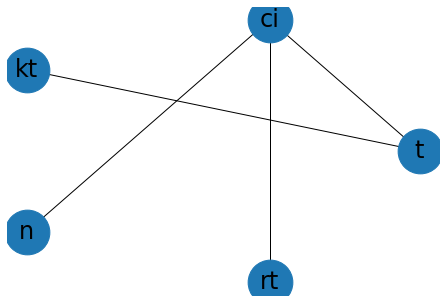

In [439]:
nx.draw(join_graph, pos=nx.circular_layout(join_graph), with_labels=True, node_size=2000, font_size=24)
plt.savefig(SAVE_DIR + "join_graph.png")

In [440]:
y = true_alg.test([qrep])
y_pg = postgres.test([qrep])

#random_alg = Random()
#true_random = TrueRandom()
#y_rand = random_alg.test([qrep])
#y_true_rand = true_random.test([qrep])
sql = fix_query(sql)

opt_cost, opt_plan = eval_alg(sql, y[0], y_pg[0], join_graph)
node_types = extract_values(opt_plan[0][0], "Node Type")
costs = extract_values(opt_plan[0][0], "Total Cost")
print(node_types)
print(costs)
#print(opt_plan)

qerr:  3.5831666418467005
compute postgres join error took:  0.013210535049438477
jerr: 21383.639999999898


ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [441]:
def dont_change_subset(k,v):
    ret = None
    #if "t" in k and "mi1" in k:
    if "ci" in k:
        ret = v
    else:
        ret = v + random.randint(-1000000,1000000)
    if ret <= 0:
        ret = 1
    return ret

def change_subset(k,v):
    ret = None
    # if "n" in k or "ci" in k:
    if "kt" in k and "t" in k and len(k) == 2:
       # ret = v -= random.randint(-100000,100000)
        ret = 10000
    #if "n" in k :
       # ret = random.randint(-100000,100000)
    #elif "rt" in k and "ci" in k and len(k) == 2:
        #ret = v * 1
    elif "rt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and "rt" in k and len(k) == 4:
        ret = 108 * 1000
    else:
        ret = v
        #ret = v + random.randint(-100,100)
    if ret <= 0:
        ret = 1
    return ret

def small_change(k,v):
    v += random.randint(-10000,10000)
    if v <= 0:
        v = 1
    return v
        
test_ests = {}
num_changed = 0
#for k,v in y[0].items():
for k,v in y_pg[0].items():
    test_ests[k] = change_subset(k,v)
    if test_ests[k] != v:
        num_changed += 1
        
print("total: {}, num changed: {}".format(len(y[0]), num_changed))
#eval_alg(sql, y[0], test_ests, join_graph)

total: 17, num changed: 4


In [442]:
def check_errors(y, subsets, qrep, width=100):
    yhat = copy.deepcopy(y)
    xs = []
    qerrs = []
    flow_errs = []
    flow_plan_errs = []
    flow_plans = []
    plan_errs = []
    pg_errs = []
    und_plan_errs = []
    quadratic_errs = []
    quadratic_flow_errs = []

    STEP=10
    for i in range(1, width+2,STEP):
        #err_factor = 2**i
        err_factor = i
        
        ests = []
        for subset in subsets:
            est1 = y[subset] * err_factor
            yhat[subset] = est1
            ests.append(est1)
            
        #xs.append(err_factor)
        xs.append(np.mean(np.array(ests)))

        errors = get_all_errors(y, yhat, qrep)
        qerrs.append(errors[0])
        flow_errs.append(errors[1])
        plan_errs.append(errors[2])
        pg_errs.append(errors[3])
        und_plan_errs.append(errors[4])
        quadratic_errs.append(errors[5])
        quadratic_flow_errs.append(errors[6])
        flow_plan_errs.append(errors[7])
        flow_plans.append(errors[8])

        ests2 = []
        for subset in subsets:
            est2 = y[subset] / err_factor
            yhat[subset] = est2
            ests2.append(est2)

        errors = get_all_errors(y, yhat, qrep)
        
        #xs.append(-err_factor)
        xs.append(np.mean(np.array(ests2)))
        print(xs[-1])
        qerrs.append(errors[0])
        flow_errs.append(errors[1])
        plan_errs.append(errors[2])
        pg_errs.append(errors[3])
        und_plan_errs.append(errors[4])
        quadratic_errs.append(errors[5])
        quadratic_flow_errs.append(errors[6])
        flow_plan_errs.append(errors[7])
        flow_plans.append(errors[8])

    return xs,qerrs,flow_errs,plan_errs,pg_errs,und_plan_errs,quadratic_errs,\
        quadratic_flow_errs,flow_plan_errs,flow_plans

In [443]:
#def get_errors("mul", )

ERROR_FUNCS = [np.divide, np.multiply]
STEP_SIZE = 1
def check_errors2(y, subsets, subsets2, qrep, width=10):
    yhat = copy.deepcopy(y)
    xs = []
    ys = []
    qerrs = []
    flow_errs = []
    plan_errs = []
    pg_errs = []
    #assert len(subsets) == 1
    #assert len(subsets2) == 1
    
    for i in range(0, width,STEP_SIZE):
        err_factor = i
        #xs.append(err_factor)
        #print(err_factor)
        err_factor = 2**i
        
        for ef1 in ERROR_FUNCS:
            est1s = []
            for subset in subsets:
                est1 = ef1(y[subset], err_factor)
                yhat[subset] = est1
                est1s.append(est1)
            
            for j in range(1, width,STEP_SIZE):
                for ef2 in ERROR_FUNCS:
                    est2s = []
                    err_factor2 = j
                    for subset in subsets2:
                        est2 = ef2(y[subset], err_factor2)
                        yhat[subset] = est2
                        est2s.append(est2)
                    
                    errors = get_all_errors(y, yhat, qrep)
                    qerrs.append(errors[0])
                    flow_errs.append(errors[1])
                    plan_errs.append(errors[2])
                    pg_errs.append(errors[3])

                    xs.append(np.mean(np.array(est1s)))
                    ys.append(np.mean(np.array(est2s)))
                    #xs.append(err_factor)
                    #ys.append(err_factor2)


    return xs,ys,qerrs,flow_errs,plan_errs,pg_errs

In [ ]:
#subsets = [("ci", "kt", "t"), ("kt","t")]
#subsets = [("ci", "n", "rt"), ("ci","n"), ("ci", "n", "rt", "t")]
#subsets = [("ci", "n", "rt"), ("ci","n"), ("ci", "n", "rt", "t"), ("ci", "rt", "t"), ("ci", "kt", "rt", "t")]
#subsets = [("ci", "n", "rt")]
#subsets = [("ci", "n", "rt")]

data = {}

def run_subset(subsets, data):
    add_single_node_edges(qrep["subset_graph"])
    xs,qerrs,flow_errs,plan_errs,pg_errs,und_plan_errs,\
        quadratic_errs,quad_flow_errs,flow_plan_errs,flow_plans = check_errors(y[0],subsets, qrep, width=2000)
    subsets.sort()
    subsets = str(subsets)
    data[subsets] = (xs,qerrs,flow_errs,plan_errs,pg_errs,und_plan_errs,quadratic_errs,quad_flow_errs,flow_plan_errs,flow_plans)

# for node in qrep["subset_graph"]:
#     run_subset([node], data)
    
#subsets = [("ci", "n", "rt")]
#subsets = [("ci", "n", "t")]
#subsets = [("ci", "rt")]
#subsets = [("kt", "t")]
#subsets = [("ci", "kt", "rt", "t")]
#subsets = [("ci", "n")]
#subsets = [("kt",)]
subsets = [("ci", "kt", "t")]
run_subset(subsets, data)

compute plan-loss took: 2.4551329612731934
compute postgres join error took:  0.024593591690063477
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal

14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+0

 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
compute plan-loss took: 0.021292448043823242
compute postgres join error took:  0.011887073516845703
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2

10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+0

11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+0

 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.4016e-15 -3.1000e+01  5e+02  2e+00  2e-01  1e+00
 1: -4.4598e+00 -8.8407e+00  6e+01  3e-01  3e-02  1e-01
 2:  1.1338e-01 -2.2717e+00  3e+01  2e-01  1e-02  9e-02
 3:  2.1590e+00  9.7670e-01  1e+01  9e-02  7e-03  5e-02
 4:  3.2318e+00  2.9165e+00  4e+00  3e-02  2e-03  2e-02
 5:  3.7934e+00  3.7277e+00  8e-01  5e-03  4e-04  5e-03
 6:  3.9059e+00  3.8833e+00  3e-01  2e-03  1e-04  2e-03
 7:  3.9494e+00  3.9415e+00  1e-01  7e-04  5e-05  7e-04
 8:  3.9563e+00  3.9499e+0

 1: -8.9157e+00 -1.3240e+01  7e+01  4e-01  4e-02  1e-01
 2: -3.3037e+00 -5.6505e+00  4e+01  2e-01  2e-02  1e-01
 3:  2.7889e-01 -4.6052e-01  1e+01  7e-02  7e-03  4e-02
 4:  1.1146e+00  7.3108e-01  6e+00  4e-02  4e-03  2e-02
 5:  1.5840e+00  1.4004e+00  3e+00  2e-02  2e-03  1e-02
 6:  1.7894e+00  1.6743e+00  2e+00  1e-02  1e-03  9e-03
 7:  2.1924e+00  2.1752e+00  3e-01  2e-03  2e-04  1e-03
 8:  2.2663e+00  2.2620e+00  7e-02  4e-04  4e-05  3e-04
 9:  2.2850e+00  2.2841e+00  1e-02  9e-05  9e-06  7e-05
10:  2.2877e+00  2.2872e+00  7e-03  4e-05  4e-06  4e-05
11:  2.2898e+00  2.2897e+00  1e-03  8e-06  8e-07  6e-06
12:  2.2900e+00  2.2900e+00  6e-04  4e-06  4e-07  3e-06
13:  2.2902e+00  2.2902e+00  9e-05  6e-07  6e-08  5e-07
14:  2.2902e+00  2.2902e+00  3e-05  2e-07  2e-08  2e-07
15:  2.2902e+00  2.2902e+00  4e-06  3e-08  3e-09  2e-08
16:  2.2902e+00  2.2902e+00  1e-06  8e-09  9e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+0

 8:  1.8525e+00  1.8515e+00  8e-03  8e-05  1e-05  6e-05
 9:  1.8537e+00  1.8536e+00  1e-03  1e-05  2e-06  7e-06
10:  1.8539e+00  1.8538e+00  3e-04  3e-06  5e-07  3e-06
11:  1.8539e+00  1.8539e+00  5e-05  5e-07  7e-08  4e-07
12:  1.8539e+00  1.8539e+00  1e-05  2e-07  2e-08  1e-07
13:  1.8539e+00  1.8539e+00  2e-06  3e-08  4e-09  2e-08
14:  1.8539e+00  1.8539e+00  7e-07  8e-09  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+0

 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.9967e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -4.9948e+00 -1.7082e+01  9e+01  5e-01  1e-01  2e-01
 2: -5.6438e-01 -4.7140e+0

14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2733e-14 -3.1000e+01  6e+02  3e+00  1e-01  1e+00
 1: -7.3854e+00 -1.1756e+01  8e+01  4e-01  2e-02  1e-01
 2: -3.6365e+00 -7.4357e+00  7e+01  3e-01  2e-02  1e-01
 3:  2.5677e+00  8.8817e-01  3e+01  2e-01  8e-03  7e-02
 4:  2.9570e+00  1.8502e+00  2e+01  1e-01  5e-03  5e-02
 5:  4.5788e+00  4.4303e+00  3e+00  1e-02  7e-04  8e-03
 6:  4.7098e+00  4.6406e+00  1e+00  6e-03  3e-04  5e-03
 7:  4.8039e+00  4.7903e+00  2e-01  1e-03  6e-05  1e-03
 8:  4.8300e+00  4.8273e+00  5e-02  3e-04  1e-05  3e-04
 9:  4.8374e+00  4.8370e+00  8e-03  4e-05  2e-06  4e-05
10:  4.8383e+00  4.8382e+00  3e-03  2e-05  8e-07  2e-05
11:  4.8389e+00  4.8388e+00  6e-04  3e-06  2e-07  4e-06
12:  4.8389e+00  4.8389e+00  2e-04  1e-06  5e-08  1e-06
13:  4.8390e+00  4.8390e+00  3e-05  2e-07  1e-08  2e-07
14:  4.8390e+00  4.8390e+00  3e-05  2e-07  9e-09  2e-07
15:  4.8390e+00  4.8390e+0

 9:  3.5390e+00  3.5387e+00  4e-03  2e-05  8e-07  4e-05
10:  3.5406e+00  3.5406e+00  7e-04  3e-06  1e-07  6e-06
11:  3.5409e+00  3.5409e+00  1e-04  7e-07  3e-08  1e-06
12:  3.5409e+00  3.5409e+00  5e-05  2e-07  1e-08  5e-07
13:  3.5409e+00  3.5409e+00  1e-05  7e-08  3e-09  1e-07
14:  3.5409e+00  3.5409e+00  4e-06  2e-08  4e-09  4e-08
15:  3.5409e+00  3.5409e+00  4e-06  2e-08  4e-09  4e-08
16:  3.5409e+00  3.5409e+00  3e-06  2e-08  6e-09  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+0

 6:  1.7476e+00  1.6627e+00  8e-01  3e-03  2e-04  3e-03
 7:  1.9235e+00  1.9063e+00  2e-01  7e-04  5e-05  6e-04
 8:  1.9636e+00  1.9576e+00  5e-02  2e-04  2e-05  2e-04
 9:  1.9785e+00  1.9773e+00  1e-02  5e-05  3e-06  5e-05
10:  1.9811e+00  1.9806e+00  4e-03  2e-05  1e-06  2e-05
11:  1.9823e+00  1.9822e+00  1e-03  4e-06  3e-07  5e-06
12:  1.9825e+00  1.9825e+00  6e-04  2e-06  2e-07  3e-06
13:  1.9827e+00  1.9827e+00  9e-05  4e-07  3e-08  4e-07
14:  1.9827e+00  1.9827e+00  4e-05  2e-07  1e-08  2e-07
15:  1.9827e+00  1.9827e+00  6e-06  3e-08  2e-09  3e-08
16:  1.9827e+00  1.9827e+00  3e-06  1e-08  9e-09  1e-08
17:  1.9827e+00  1.9827e+00  6e-07  3e-09  1e-08  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+0

13:  1.5913e+00  1.5913e+00  8e-06  7e-08  1e-08  4e-08
14:  1.5913e+00  1.5913e+00  3e-06  2e-08  5e-09  2e-08
15:  1.5913e+00  1.5913e+00  6e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+0

13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0037e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.4843e+00 -1.0265e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.4287e-01 -2.1485e+00  1e+01  1e-01  3e-02  7e-02
 3:  5.2583e-01  1.2087e-01  4e+00  4e-02  8e-03  2e-02
 4:  7.9556e-01  6.7238e-01  1e+00  1e-02  2e-03  6e-03
 5:  8.8502e-01  8.3772e-01  4e-01  5e-03  9e-04  2e-03
 6:  9.5450e-01  9.4347e-01  1e-01  1e-03  2e-04  6e-04
 7:  9.7157e-01  9.6785e-01  3e-02  4e-04  7e-05  2e-04
 8:  9.7538e-01  9.7317e-01  2e-02  2e-04  4e-05  1e-04
 9:  9.7933e-01  9.7888e-01  4e-03  5e-05  9e-06  2e-05
10:  9.7936e-01  9.7892e-01  4e-03  4e-05  8e-06  2e-05
11:  9.8026e-01  9.8020e-01  6e-04  6e-06  1e-06  3e-06
12:  9.8036e-01  9.8033e-0

 3:  3.0626e+00  1.9943e+00  2e+01  9e-02  3e-03  5e-02
 4:  3.6980e+00  3.4034e+00  6e+00  2e-02  8e-04  3e-02
 5:  3.9842e+00  3.8183e+00  4e+00  1e-02  4e-04  2e-02
 6:  4.5901e+00  4.5680e+00  5e-01  2e-03  6e-05  3e-03
 7:  4.6670e+00  4.6606e+00  1e-01  6e-04  2e-05  8e-04
 8:  4.6975e+00  4.6967e+00  2e-02  7e-05  2e-06  1e-04
 9:  4.7019e+00  4.7017e+00  4e-03  2e-05  5e-07  2e-05
10:  4.7029e+00  4.7029e+00  9e-04  4e-06  1e-07  6e-06
11:  4.7032e+00  4.7032e+00  2e-04  9e-07  3e-08  2e-06
12:  4.7033e+00  4.7033e+00  3e-05  1e-07  4e-09  2e-07
13:  4.7033e+00  4.7033e+00  1e-05  5e-08  2e-09  8e-08
14:  4.7033e+00  4.7033e+00  2e-06  1e-08  4e-10  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+0

 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.0008e-15 -6.2000e+01  9e+02  2e+00  1e-01  1e+00
 1: -1.5191e+01 -2.5000e+01  1e+02  4e-01  2e-02  1e-01
 2: -6.2770e+00 -1.1158e+0

 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5802e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.5410e+00 -9.6563e+00  7e+01  5e-01  9e-02  2e-01
 2:  6.4852e-01 -2.1943e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.9609e+00  1.1171e+00  8e+00  8e-02  1e-02  4e-02
 4:  1.5459e+00  1.3545e+00  2e+00  2e-02  3e-03  9e-03
 5:  1.5478e+00  1.4390e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.5659e+00  1.5492e+00  2e-01  2e-03  3e-04  9e-04
 7:  1.5676e+00  1.5571e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5730e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9063e+00 -8.0532e+00  4e+01  3e-01  4e-02  1e-01
 2:  6.8102e-01 -2.3218e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.5689e-01  4.0061e-01  3e+00  3e-02  4e-03  2e-02
 4:  1.2043e+00  1.0960e+00  8e-01  8e-03  1e-03  5e-03
 5:  1.3036e+00  1.2861e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.3295e+00  1.3265e+00  2e-02  2e-04  3e-05  2e-04
 7:  1.3314e+00  1.3292e+00  2e-02  2e-04  2e-05  1e-04
 8:  1.3351e+00  1.3346e+00  3e-03  4e-05  5e-06  3e-05
 9:  1.3357e+00  1.3355e+00  2e-03  2e-05  2e-06  2e-05
10:  1.3362e+00  1.3361e+00  4e-04  5e-06  6e-07  5e-06
11:  1.3363e+00  1.3363e+00  6e-05  7e-07  9e-08  7e-07
12:  1.3363e+00  1.3363e+00  2e-05  2e-07  3e-08  2e-07
13:  1.3363e+00  1.3363e+00  4e-06  4e-08  6e-09  4e-08
14:  1.3363e+00  1.3363e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3363e+00  1.3363e+00  6e-07  6e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost    

 6:  8.0473e-01  7.7379e-01  2e-01  1e-03  3e-04  8e-04
 7:  8.2699e-01  8.2076e-01  3e-02  2e-04  6e-05  2e-04
 8:  8.2997e-01  8.2665e-01  2e-02  1e-04  3e-05  8e-05
 9:  8.3257e-01  8.3208e-01  2e-03  2e-05  5e-06  1e-05
10:  8.3281e-01  8.3261e-01  1e-03  8e-06  2e-06  5e-06
11:  8.3296e-01  8.3292e-01  2e-04  1e-06  3e-07  8e-07
12:  8.3298e-01  8.3296e-01  8e-05  6e-07  2e-07  4e-07
13:  8.3299e-01  8.3298e-01  2e-05  1e-07  4e-08  8e-08
14:  8.3299e-01  8.3299e-01  3e-06  2e-08  5e-09  1e-08
15:  8.3299e-01  8.3299e-01  4e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5109e-14 -3.1000e+01  8e+02  2e+00  6e-02  1e+00
 1: -7.2409e+00 -1.1420e+01  9e+01  3e-01  8e-03  1e-01
 2: -1.0042e+00 -2.9776e+00  4e+01  2e-01  4e-03  8e-02
 3:  1.9836e+00  1.1722e+00  2e+01  7e-02  2e-03  4e-02
 4:  3.1473e+00  2.9508e+0

11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.6176e-15 -3.1000e+01  9e+02  3e+00  9e-02  1e+00
 1: -1.3342e+01 -1.7255e+01  1e+02  4e-01  1e-02  1e-01
 2: -8.4596e+00 -1.1275e+01  8e+01  3e-01  8e-03  2e-01
 3: -5.4117e-01 -1.2050e+00  2e+01  7e-02  2e-03  5e-02
 4:  7.1335e-01  3.9853e-01  8e+00  3e-02  1e-03  2e-02
 5:  1.6128e+00  1.5130e+00  3e+00  1e-02  3e-04  1e-02
 6:  2.0824e+00  2.0562e+00  7e-01  3e-03  8e-05  3e-03
 7:  2.2449e+00  2.2372e+00  2e-01  8e-04  2e-05  8e-04
 8:  2.2701e+00  2.2646e+00  1e-01  6e-04  2e-05  6e-04
 9:  2.3199e+00  2.3189e+00  3e-02  1e-04  3e-06  1e-04
10:  2.3301e+00  2.3299e+0

15:  1.5217e+00  1.5217e+00  3e-07  4e-09  6e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+0

 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0075e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.0911e+00 -1.7165e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.0220e-01 -4.7045e+00  3e+01  2e-01  4e-02  1e-01
 3:  6.4438e-01 -6.7958e-01  8e+00  5e-02  1e-02  4e-02
 4:  9.1019e-01  5.4714e-01  2e+00  1e-02  4e-03  1e-02
 5:  9.8836e-01  8.5485e-01  8e-01  5e-03  1e-03  4e-03
 6:  9.9147e-01  8.7821e-0

 6:  4.7579e+00  4.7407e+00  5e-01  2e-03  4e-05  2e-03
 7:  4.8017e+00  4.7956e+00  2e-01  6e-04  1e-05  1e-03
 8:  4.8335e+00  4.8327e+00  2e-02  8e-05  2e-06  1e-04
 9:  4.8375e+00  4.8373e+00  6e-03  2e-05  4e-07  3e-05
10:  4.8387e+00  4.8387e+00  1e-03  4e-06  8e-08  7e-06
11:  4.8389e+00  4.8389e+00  3e-04  9e-07  2e-08  2e-06
12:  4.8390e+00  4.8390e+00  6e-05  2e-07  5e-09  4e-07
13:  4.8390e+00  4.8390e+00  2e-05  8e-08  2e-09  1e-07
14:  4.8390e+00  4.8390e+00  5e-06  2e-08  2e-09  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -8.3089e-15 -6.2000e+01  9e+02  2e+00  4e-02  1e+00
 1: -9.0382e+00 -1.8973e+01  1e+02  3e-01  6e-03  1e-01
 2: -9.1886e-01 -3.9893e+00  4e+01  9e-02  2e-03  7e-02
 3:  7.7567e-01 -3.8063e-01  1e+01  3e-02  7e-04  5e-02
 4:  2.8094e+00  2.6769e+00  2e+00  4e-03  9e-05  5e-03
 5:  3.0291e+00  3.0087e+00  3e-01  6e-04  1e-05  1e-03
 6:  3.0913e+00  3.0877e+00  4e-02  1e-04  2e-06  3e-04
 7:  3.1062e+00  3.1054e+00  9e-03  2e-05  5e-07  6e-05
 8:  3.1088e+00  3.1084e+00  5e-03  1e-05  3e-07  3e-05
 9:  3.1107e+00  3.1106e+00  6e-04  2e-06  3e-08  4e-06
10:  3.1109e+00  3.1109e+00  1e-04  3e-07  7e-09  8e-07
11:  3.1109e+00  3.1109e+00  4e-05  9e-08  2e-09  3e-07
12:  3.1109e+00  3.1109e+00  1e-05  3e-08  7e-10  9e-08
13:  3.1109e+00  3.1109e+00  3e-06  9e-09  2e-09  3e-08
14:  3.1109e+00  3.1109e+00  3e-06  7e-09  3e-08  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01 

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5681e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.5665e+00 -9.6787e+00  7e+01  5e-01  9e-02  2e-01
 2:  6.2022e-01 -2.2004e+0

10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5661e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9350e+00 -8.0800e+00  4e+01  3e-01  4e-02  1e-01
 2:  6.2903e-01 -2.9271e-01  7e+00  6e-02  9e-03  3e-02
 3:  9.0019e-01  5.2788e-01  3e+00  3e-02  3e-03  2e-02
 4:  1.1289e+00  9.9892e-01  9e-01  9e-03  1e-03  6e-03
 5:  1.2609e+00  1.2390e+00  2e-01  2e-03  2e-04  1e-03
 6:  1.2751e+00  1.2642e+00  8e-02  8e-04  1e-04  6e-04
 7:  1.2904e+00  1.2890e+00  1e-02  1e-04  1e-05  8e-05
 8:  1.2925e+00  1.2920e+00  3e-03  4e-05  5e-06  3e-05
 9:  1.2935e+00  1.2934e+0

10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0083e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.7786e+00 -1.4491e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.3217e-01 -3.2751e+00  2e+01  1e-01  3e-02  7e-02
 3:  5.1134e-01 -2.8762e-01  4e+00  3e-02  8e-03  2e-02
 4:  6.8854e-01  4.6928e-01  1e+00  8e-03  2e-03  6e-03
 5:  7.3249e-01  6.4040e-01  5e-01  3e-03  9e-04  2e-03
 6:  7.8299e-01  7.4820e-01  2e-01  1e-03  3e-04  9e-04
 7:  8.0765e-01  8.0008e-01  4e-02  3e-04  7e-05  2e-04
 8:  8.0978e-01  8.0428e-0

11:  4.3914e+00  4.3914e+00  4e-04  9e-07  2e-08  2e-06
12:  4.3915e+00  4.3915e+00  7e-05  2e-07  4e-09  4e-07
13:  4.3915e+00  4.3915e+00  7e-05  2e-07  1e-08  4e-07
14:  4.3915e+00  4.3915e+00  3e-05  7e-08  5e-09  1e-07
15:  4.3915e+00  4.3915e+00  6e-06  1e-08  2e-09  3e-08
16:  4.3915e+00  4.3915e+00  2e-06  5e-09  4e-09  8e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  

 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2847e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5618e+00 -8.0045e+00  5e+01  4e-01  7e-02  2e-01
 2:  8.4216e-01 -1.4399e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.3542e+00  5.7448e-01  7e+00  6e-02  1e-02  4e-02
 4:  1.4235e+00  1.2911e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.4363e+00  1.3520e+00  7e-01  7e-03  1e-03  4e-03
 6:  1.4675e+00  1.4522e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4751e+00  1.4688e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.4800e+00  1.4791e+00  7e-03  7e-05  1e-05  5e-05
 9:  1.4808e+00  1.4805e+00  3e-03  3e-05  4e-06  2e-05
10:  1.4812e+00  1.4812e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.0789e-14 -3.1000e+01  1e+03  3e+00  4e-02  1e+00
 1: -1.0820e+01 -1.4839e+01  1e+02  4e-01  6e-03  1e-01
 2: -6.4244e+00 -9.6218e+00  1e+02  3e-01  4e-03  2e-01
 3:  2.0240e+00  7.9488e-0

 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0285e-14 -6.2000e+01  1e+03  2e+00  3e-02  1e+00
 1: -1.0137e+01 -1.9932e+01  2e+02  3e-01  4e-03  1e-01
 2: -1.3621e+00 -4.1890e+00  4e+01  8e-02  1e-03  8e-02
 3:  5.6037e-01 -4.3134e-01  2e+01  3e-02  5e-04  5e-02
 4:  2.7748e+00  2.6570e+00  2e+00  3e-03  6e-05  6e-03
 5:  3.0250e+00  3.0074e+0

18:  2.0080e+00  2.0080e+00  2e-05  5e-08  3e-08  1e-07
19:  2.0080e+00  2.0080e+00  3e-06  7e-09  4e-09  1e-08
20:  2.0080e+00  2.0080e+00  3e-06  7e-09  2e-08  1e-08
21:  2.0080e+00  2.0080e+00  1e-06  3e-09  1e-08  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+0

 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2834e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0469e+00 -7.2248e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.9481e-01 -9.2885e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.9706e-01  3.9082e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.1153e+00  9.1667e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.3202e+00  1.2883e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3596e+00  1.3540e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3655e+00  1.3631e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3681e+00  1.3672e+00  7e-03  7e-05  1e-05  6e-05
 9:  1.3696e+00  1.3695e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3698e+00  1.3698e+0

 3:  5.0302e-01  1.1088e-01  4e+00  4e-02  7e-03  2e-02
 4:  7.2809e-01  5.9398e-01  1e+00  1e-02  3e-03  7e-03
 5:  8.1157e-01  7.5513e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.9513e-01  8.8417e-01  1e-01  1e-03  2e-04  6e-04
 7:  9.1468e-01  9.1176e-01  3e-02  3e-04  6e-05  2e-04
 8:  9.1887e-01  9.1785e-01  9e-03  1e-04  2e-05  5e-05
 9:  9.2064e-01  9.2039e-01  2e-03  2e-05  5e-06  1e-05
10:  9.2101e-01  9.2091e-01  9e-04  1e-05  2e-06  5e-06
11:  9.2119e-01  9.2118e-01  1e-04  2e-06  3e-07  8e-07
12:  9.2120e-01  9.2119e-01  1e-04  1e-06  3e-07  7e-07
13:  9.2123e-01  9.2122e-01  2e-05  2e-07  5e-08  1e-07
14:  9.2123e-01  9.2123e-01  9e-06  1e-07  2e-08  5e-08
15:  9.2123e-01  9.2123e-01  1e-06  2e-08  3e-09  8e-09
16:  9.2123e-01  9.2123e-01  4e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1085e-14 -6.2000e+01  1e+03  2e+00  5e-02  1e+00
 1: -2.0856e+01 -2.9360e+01  2e+02  3e-01  7e-03  1e-01
 2: -1.2740e+01 -1.7844e+01  1e+02  2e-01  4e-03  1e-01
 3: -2.2442e+00 -3.7637e+00  3e+01  6e-02  1e-03  5e-02
 4: -2.1606e-01 -9.7459e-01  2e+01  3e-02  6e-04  3e-02
 5:  1.8719e+00  1.6871e+00  4e+00  8e-03  2e-04  8e-03
 6:  1.7841e+00  1.5975e+0

14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5611e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.5825e+00 -9.6925e+00  7e+01  5e-01  9e-02  2e-01
 2:  6.0107e-01 -2.2059e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.8219e+00  9.8259e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4649e+00  1.2850e+00  2e+00  2e-02  3e-03  9e-03
 5:  1.4564e+00  1.3537e+00  1e+00  9e-03  2e-03  5e-03
 6:  1.4650e+00  1.4493e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4661e+00  1.4580e+00  7e-02  7e-04  1e-04  4e-04
 8:  1.4672e+00  1.4651e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.4674e+00  1.4657e+00  1e-02  1e-04  3e-05  9e-05
10:  1.4676e+00  1.4674e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4677e+00  1.4675e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4678e+00  1.4677e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4678e+00  1.4678e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4678e+00  1.4678e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4678e+00  1.4678e+0

11:  1.2688e+00  1.2688e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2688e+00  1.2688e+00  7e-06  7e-08  1e-08  7e-08
13:  1.2688e+00  1.2688e+00  2e-06  2e-08  3e-09  2e-08
14:  1.2688e+00  1.2688e+00  2e-06  2e-08  3e-09  2e-08
15:  1.2688e+00  1.2688e+00  9e-07  9e-09  2e-09  9e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+0

16:  8.0431e-01  8.0431e-01  2e-07  1e-09  2e-09  8e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.1069e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: 

11:  3.9822e+00  3.9822e+00  1e-03  3e-06  3e-08  8e-06
12:  3.9826e+00  3.9826e+00  3e-04  7e-07  7e-09  2e-06
13:  3.9827e+00  3.9827e+00  1e-04  2e-07  3e-09  8e-07
14:  3.9828e+00  3.9828e+00  2e-05  4e-08  4e-09  1e-07
15:  3.9828e+00  3.9828e+00  6e-06  2e-08  5e-09  5e-08
16:  3.9828e+00  3.9828e+00  1e-06  4e-09  8e-09  8e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+0

 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2702e-14 -6.2000e+01  1e+03  2e+00  4e-02  1e+00
 1: -2.0546e+01 -2.8321e+01  2e+02  3e-01  5e-03  1e-01
 2: -1.8351e+01 -2.4706e+01  1e+02  2e-01  4e-03  2e-01
 3: -3.0346e+00 -4.4348e+00  3e+01  5e-02  1e-03  6e-02
 4: -2.2894e-01 -7.5763e-0

 2:  1.1564e+00 -3.3520e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.5443e+00  3.0700e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3738e+00  1.1358e+00  1e+00  8e-03  2e-03  6e-03
 5:  1.3905e+00  1.2903e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.4104e+00  1.3874e+00  1e-01  8e-04  2e-04  6e-04
 7:  1.4195e+00  1.4151e+00  2e-02  2e-04  3e-05  1e-04
 8:  1.4215e+00  1.4206e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.4218e+00  1.4212e+00  2e-03  2e-05  4e-06  1e-05
10:  1.4221e+00  1.4220e+00  3e-04  3e-06  6e-07  2e-06
11:  1.4221e+00  1.4221e+00  2e-04  1e-06  3e-07  9e-07
12:  1.4221e+00  1.4221e+00  3e-05  2e-07  5e-08  1e-07
13:  1.4221e+00  1.4221e+00  8e-06  7e-08  2e-08  5e-08
14:  1.4221e+00  1.4221e+00  2e-06  2e-08  4e-09  1e-08
15:  1.4221e+00  1.4221e+00  5e-07  4e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+0

11:  1.0340e+00  1.0339e+00  9e-04  6e-06  2e-06  4e-06
12:  1.0341e+00  1.0341e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0342e+00  1.0342e+00  7e-05  5e-07  1e-07  3e-07
14:  1.0342e+00  1.0342e+00  7e-05  5e-07  1e-07  3e-07
15:  1.0342e+00  1.0342e+00  3e-05  2e-07  6e-08  1e-07
16:  1.0342e+00  1.0342e+00  5e-06  4e-08  1e-08  2e-08
17:  1.0342e+00  1.0342e+00  3e-06  2e-08  6e-09  1e-08
18:  1.0342e+00  1.0342e+00  6e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+0

 3:  1.9172e+00  9.2642e-01  4e+01  8e-02  8e-04  7e-02
 4:  3.4828e+00  3.2925e+00  8e+00  2e-02  2e-04  3e-02
 5:  4.4068e+00  4.3785e+00  1e+00  3e-03  3e-05  7e-03
 6:  4.6565e+00  4.6528e+00  2e-01  4e-04  3e-06  9e-04
 7:  4.6923e+00  4.6917e+00  3e-02  6e-05  6e-07  2e-04
 8:  4.7004e+00  4.7003e+00  7e-03  1e-05  1e-07  5e-05
 9:  4.7028e+00  4.7027e+00  1e-03  2e-06  2e-08  8e-06
10:  4.7031e+00  4.7031e+00  5e-04  9e-07  9e-09  3e-06
11:  4.7033e+00  4.7032e+00  6e-05  1e-07  1e-09  4e-07
12:  4.7033e+00  4.7033e+00  2e-05  4e-08  2e-09  1e-07
13:  4.7033e+00  4.7033e+00  3e-06  8e-09  2e-09  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+0

 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4319e-14 -6.2000e+01  2e+03  2e+00  4e-02  1e+00
 1: -2.1991e+01 -3.0227e+01  2e+02  3e-01  5e-03  1e-01
 2: -1.4799e+01 -1.9971e+0

 2:  5.9391e-01 -2.2082e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.8032e+00  9.6489e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4572e+00  1.2792e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4464e+00  1.3444e+00  1e+00  9e-03  2e-03  5e-03
 6:  1.4528e+00  1.4373e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4537e+00  1.4459e+00  7e-02  7e-04  1e-04  4e-04
 8:  1.4546e+00  1.4526e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.4547e+00  1.4532e+00  1e-02  1e-04  2e-05  9e-05
10:  1.4550e+00  1.4547e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4550e+00  1.4549e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4551e+00  1.4551e+00  3e-04  3e-06  6e-07  2e-06
13:  1.4551e+00  1.4551e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4551e+00  1.4551e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4551e+00  1.4551e+00  3e-05  3e-07  5e-08  2e-07
16:  1.4551e+00  1.4551e+00  4e-06  4e-08  8e-09  3e-08
17:  1.4551e+00  1.4551e+00  7e-07  8e-09  1e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+0

 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2708e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0683e+00 -1.0425e+01  4e+01  2e-01  4e-02  2e-01
 2:  7.0854e-01 -1.4308e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.4015e-01  5.0477e-01  2e+00  1e-02  2e-03  1e-02
 4:  1.0183e+00  8.0459e-01  9e-01  6e-03  1e-03  6e-03
 5:  1.1283e+00  1.1011e+0

compute plan-loss took: 0.019367218017578125
compute postgres join error took:  0.007506370544433594
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

     pcost       dcost       gap    pres   dres   k/t
 0:  6.3375e-14 -3.1000e+01  1e+03  2e+00  2e-02  1e+00
 1: -8.3161e+00 -1.3139e+01  2e+02  3e-01  3e-03  2e-01
 2: -2.5830e+00 -4.3223e+00  8e+01  1e-01  1e-03  1e-01
 3:  2.0326e+00  1.6431e+00  2e+01  3e-02  2e-04  3e-02
 4:  1.5287e+00  1.2546e+00  1e+01  2e-02  2e-04  5e-02
 5:  2.9523e+00  2.8926e+00  3e+00  5e-03  4e-05  1e-02
 6:  3.3797e+00  3.3698e+00  5e-01  9e-04  7e-06  4e-03
 7:  3.5167e+00  3.5153e+00  8e-02  1e-04  1e-06  5e-04
 8:  3.5295e+00  3.5289e+00  4e-02  6e-05  5e-07  3e-04
 9:  3.5403e+00  3.5402e+00  7e-03  1e-05  9e-08  6e-05
10:  3.5422e+00  3.5421e+00  2e-03  4e-06  3e-08  2e-05
11:  3.5433e+00  3.5433e+00  4e-04  8e-07  6e-09  4e-06
12:  3.5435e+00  3.5435e+00  8e-05  1e-07  4e-09  7e-07
13:  3.5436e+00  3.5436e+00  2e-05  3e-08  6e-09  2e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1

 3: -3.6472e+00 -5.0406e+00  3e+01  5e-02  8e-04  6e-02
 4: -5.4531e-01 -1.0879e+00  1e+01  2e-02  3e-04  3e-02
 5:  1.1742e+00  1.0283e+00  4e+00  6e-03  8e-05  8e-03
 6:  1.7537e+00  1.7269e+00  7e-01  1e-03  2e-05  2e-03
 7:  1.9182e+00  1.9096e+00  2e-01  3e-04  5e-06  7e-04
 8:  1.9811e+00  1.9787e+00  6e-02  1e-04  1e-06  2e-04
 9:  1.9912e+00  1.9896e+00  4e-02  7e-05  1e-06  2e-04
10:  2.0048e+00  2.0042e+00  1e-02  2e-05  3e-07  5e-05
11:  2.0043e+00  2.0037e+00  1e-02  2e-05  4e-07  6e-05
12:  2.0103e+00  2.0102e+00  2e-03  4e-06  6e-08  1e-05
13:  2.0113e+00  2.0113e+00  5e-04  8e-07  1e-08  2e-06
14:  2.0114e+00  2.0114e+00  2e-04  3e-07  5e-09  8e-07
15:  2.0115e+00  2.0115e+00  5e-05  9e-08  2e-09  2e-07
16:  2.0115e+00  2.0115e+00  5e-05  9e-08  2e-08  2e-07
17:  2.0115e+00  2.0115e+00  3e-05  6e-08  1e-08  1e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 

 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2806e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0589e+00 -7.2340e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.8591e-01 -9.2860e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.7230e-01  3.6247e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0951e+00  8.9636e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2993e+00  1.2669e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3389e+00  1.3332e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3447e+00  1.3422e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3473e+00  1.3464e+0

 1: -5.5518e+00 -1.0324e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.8190e-01 -2.1749e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.9813e-01  1.0880e-01  4e+00  4e-02  7e-03  2e-02
 4:  7.1747e-01  5.8236e-01  1e+00  1e-02  3e-03  7e-03
 5:  8.0031e-01  7.4291e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.8575e-01  8.7478e-01  1e-01  1e-03  2e-04  6e-04
 7:  9.0525e-01  9.0229e-01  3e-02  3e-04  6e-05  2e-04
 8:  9.0962e-01  9.0865e-01  9e-03  1e-04  2e-05  5e-05
 9:  9.1126e-01  9.1101e-01  2e-03  2e-05  5e-06  1e-05
10:  9.1161e-01  9.1150e-01  1e-03  1e-05  2e-06  6e-06
11:  9.1179e-01  9.1176e-01  3e-04  3e-06  5e-07  1e-06
12:  9.1179e-01  9.1176e-01  3e-04  3e-06  6e-07  1e-06
13:  9.1185e-01  9.1184e-01  4e-05  5e-07  9e-08  2e-07
14:  9.1185e-01  9.1185e-01  2e-05  2e-07  3e-08  8e-08
15:  9.1186e-01  9.1186e-01  3e-06  3e-08  7e-09  2e-08
16:  9.1186e-01  9.1186e-01  7e-07  8e-09  2e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+0

11:  4.7032e+00  4.7032e+00  6e-05  1e-07  9e-10  5e-07
12:  4.7033e+00  4.7033e+00  2e-05  3e-08  5e-10  1e-07
13:  4.7033e+00  4.7033e+00  3e-06  6e-09  5e-09  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+0

 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7552e-14 -6.2000e+01  2e+03  2e+00  3e-02  1e+00
 1: -2.2845e+01 -3.0877e+01  2e+02  3e-01  4e-03  1e-01
 2: -1.6685e+01 -2.1917e+01  1e+02  2e-01  3e-03  2e-01
 3: -4.0643e+00 -5.6852e+00  4e+01  7e-02  9e-04  7e-02
 4: -2.0795e-01 -8.4209e-01  2e+01  3e-02  4e-04  3e-02
 5:  1.6242e+00  1.4529e+00  5e+00  7e-03  1e-04  1e-02
 6:  2.0341e+00  1.9533e+0

 6:  1.4447e+00  1.4293e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4454e+00  1.4378e+00  7e-02  7e-04  1e-04  4e-04
 8:  1.4462e+00  1.4443e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.4463e+00  1.4448e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4465e+00  1.4463e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4466e+00  1.4464e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4466e+00  1.4466e+00  3e-04  3e-06  6e-07  2e-06
13:  1.4466e+00  1.4466e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4467e+00  1.4467e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4467e+00  1.4467e+00  3e-05  3e-07  5e-08  2e-07
16:  1.4467e+00  1.4467e+00  4e-06  4e-08  8e-09  3e-08
17:  1.4467e+00  1.4467e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+0

11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2706e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0732e+00 -1.0426e+01  4e+01  2e-01  4e-02  2e-01
 2:  7.0193e-01 -1.4369e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.3349e-01  4.9612e-01  2e+00  1e-02  2e-03  1e-02
 4:  1.0025e+00  7.6893e-01  1e+00  7e-03  1e-03  7e-03
 5:  1.1219e+00  1.0925e+00  1e-01  8e-04  1e-04  8e-04
 6:  1.1389e+00  1.1322e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1437e+00  1.1421e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1439e+00  1.1425e+00  6e-03  4e-05  7e-06  4e-05
 9:  1.1444e+00  1.1436e+00  3e-03  2e-05  4e-06  3e-05
10:  1.1444e+00  1.1436e+00  4e-03  3e-05  4e-06  3e-05
11:  1.1451e+00  1.1451e+00  4e-04  3e-06  5e-07  3e-06
12:  1.1452e+00  1.1452e+0

 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2846e-13 -3.1000e+01  2e+03  3e+00  2e-02  1e+00
 1: -1.2258e+01 -1.6079e+01  2e+02  3e-01  3e-03  1e-01
 2: -8.2161e+00 -1.1138e+01  2e+02  3e-01  2e-03  2e-01
 3:  1.4272e+00  3.3610e-01  6e+01  1e-01  8e-04  8e-02
 4:  3.3086e+00  3.0782e+00  1e+01  2e-02  2e-04  3e-02
 5:  4.2785e+00  4.2069e+0

16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.4334e-14 -3.1000e+01  2e+03  2e+00  1e-02  1e+00
 1: -8.5062e+00 -1.3313e+01  2e+02  3e-01  2e-03  2e-01
 2: -3.0377e+00 -4.7544e+00  9e+01  1e-01  8e-04  1e-01
 3:  2.0191e+00  1.6536e+00  2e+01  3e-02  2e-04  3e-02
 4:  1.5317e+00  1.2474e+00  2e+01  2e-02  1e-04  5e-02
 5:  2.1310e+00  2.0463e+00  5e+00  8e-03  5e-05  3e-02
 6:  3.3824e+00  3.3734e+00  6e-01  8e-04  5e-06  3e-03
 7:  3.5042e+00  3.5023e+00  1e-01  2e-04  1e-06  8e-04
 8:  3.5308e+00  3.5303e+00  3e-02  5e-05  3e-07  2e-04
 9:  3.5370e+00  3.5368e+00  2e-02  2e-05  2e-07  1e-04
10:  3.5419e+00  3.5419e+00  3e-03  4e-06  3e-08  3e-05
11:  3.5432e+00  3.5432e+00  7e-04  1e-06  7e-09  6e-06
12:  3.5436e+00  3.5436e+00  1e-04  2e-07  2e-09  1e-06
13:  3.5436e+00  3.5436e+00  4e-05  6e-08  2e-09  4e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres 

 5:  1.1221e+00  9.8293e-01  4e+00  5e-03  7e-05  8e-03
 6:  1.7101e+00  1.6816e+00  8e-01  1e-03  1e-05  2e-03
 7:  1.9237e+00  1.9168e+00  2e-01  3e-04  3e-06  6e-04
 8:  1.9655e+00  1.9621e+00  1e-01  1e-04  2e-06  3e-04
 9:  2.0005e+00  1.9997e+00  2e-02  3e-05  4e-07  8e-05
10:  2.0075e+00  2.0071e+00  1e-02  1e-05  2e-07  4e-05
11:  2.0096e+00  2.0094e+00  5e-03  8e-06  1e-07  2e-05
12:  2.0120e+00  2.0120e+00  9e-04  1e-06  2e-08  4e-06
13:  2.0123e+00  2.0123e+00  3e-04  5e-07  6e-09  1e-06
14:  2.0124e+00  2.0124e+00  7e-05  1e-07  1e-09  3e-07
15:  2.0124e+00  2.0124e+00  4e-05  7e-08  2e-08  2e-07
16:  2.0125e+00  2.0125e+00  8e-06  1e-08  6e-09  4e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00 

13:  1.4064e+00  1.4064e+00  1e-05  9e-08  2e-08  6e-08
14:  1.4064e+00  1.4064e+00  2e-06  1e-08  3e-09  1e-08
15:  1.4064e+00  1.4064e+00  9e-07  7e-09  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+0

 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0102e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5548e+00 -1.0327e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.8510e-01 -2.1774e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.9652e-01  1.0805e-01  4e+00  4e-02  7e-03  2e-02
 4:  7.1450e-01  5.7916e-01  1e+00  1e-02  3e-03  7e-03
 5:  7.9728e-01  7.3968e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.8328e-01  8.7236e-01  1e-01  1e-03  2e-04  6e-04
 7:  9.0263e-01  8.9964e-01  3e-02  3e-04  6e-05  2e-04
 8:  9.0710e-01  9.0616e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.0786e-14 -6.2000e+01  2e+03  2e+00  3e-02  1e+00
 1: -2.3514e+01 -3.1384e+01  2e+02  3e-01  4e-03  1e-01
 2: -1.8437e+01 -2.3723e+01  2e+02  2e-01  3e-03  2e-01
 3: -4.9628e+00 -6.6322e+00  5e+01  7e-02  8e-04  8e-02
 4: -5.5710e-01 -1.2095e+00  2e+01  3e-02  3e-04  3e-02
 5:  1.1368e+00  9.5417e-01  6e+00  8e-03  9e-05  1e-02
 6:  2.2349e+00  2.1926e+00  1e+00  2e-03  2e-05  4e-03
 7:  2.3423e+00  2.3117e+00  1e+00  1e-03  2e-05  3e-03
 8:  2.6370e+00  2.6319e+0

10:  1.4404e+00  1.4402e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4405e+00  1.4403e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4406e+00  1.4405e+00  3e-04  3e-06  6e-07  2e-06
13:  1.4406e+00  1.4406e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4406e+00  1.4406e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4406e+00  1.4406e+00  2e-05  3e-07  5e-08  2e-07
16:  1.4406e+00  1.4406e+00  4e-06  4e-08  8e-09  3e-08
17:  1.4406e+00  1.4406e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+0

 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2705e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0768e+00 -1.0427e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.9703e-01 -1.4414e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.2858e-01  4.8981e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.8901e-01  7.3713e-01  1e+00  7e-03  1e-03  7e-03
 5:  1.1167e+00  1.0849e+00  1e-01  9e-04  2e-04  9e-04
 6:  1.1357e+00  1.1293e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1403e+00  1.1386e+0

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4768e-13 -3.1000e+01  2e+03  3e+00  2e-02  1e+00
 1: -1.2559e+01 -1.6332e+01  2e+02  3e-01  2e-03  2e-01
 2: -8.7139e+00 -1.1575e+0

 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8190e-14 -6.2000e+01  2e+03  2e+00  1e-02  1e+00
 1: -1.2177e+01 -2.1737e+01  3e+02  3e-01  2e-03  2e-01
 2: -2.7334e+00 -5.0694e+00  6e+01  7e-02  5e-04  1e-01
 3:  2.4182e-01 -3.8631e-01  2e+01  2e-02  1e-04  5e-02
 4:  2.7420e+00  2.6711e+00  2e+00  2e-03  2e-05  6e-03
 5:  3.0129e+00  3.0034e+00  3e-01  3e-04  2e-06  1e-03
 6:  3.0951e+00  3.0938e+00  4e-02  4e-05  3e-07  2e-04
 7:  3.1037e+00  3.1031e+0

compute plan-loss took: 0.023705005645751953
compute postgres join error took:  0.013585090637207031
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2704e-15 -6.2000e+01 

10:  6.9236e-01  6.9235e-01  3e-05  3e-07  4e-08  5e-07
11:  6.9237e-01  6.9237e-01  4e-06  3e-08  5e-09  6e-08
12:  6.9237e-01  6.9237e-01  1e-06  9e-09  1e-09  2e-08
13:  6.9237e-01  6.9237e-01  7e-08  6e-10  1e-10  1e-09
Optimal solution found.
68583.07947019867
compute plan-loss took: 0.023025035858154297
compute postgres join error took:  0.007875680923461914
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.

14:  3.5436e+00  3.5436e+00  2e-05  2e-08  3e-09  2e-07
15:  3.5436e+00  3.5436e+00  4e-06  5e-09  8e-09  4e-08
16:  3.5436e+00  3.5436e+00  3e-06  4e-09  7e-09  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+0

 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.7537e-14 -3.1000e+01  1e+03  1e+00  7e-03  1e+00
 1: -4.2776e+00 -9.1901e+00  2e+02  2e-01  1e-03  2e-01
 2: -2.8239e+00 -3.8395e+00  4e+01  5e-02  2e-04  2e-01
 3:  9.8672e-01  8.3957e-01  6e+00  7e-03  4e-05  2e-02
 4:  1.4561e+00  1.4401e+00  9e-01  9e-04  5e-06  7e-03
 5:  1.6768e+00  1.6750e+00  1e-01  1e-04  6e-07  1e-03
 6:  1.7083e+00  1.7079e+0

 1: -3.0658e+00 -7.2392e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.8012e-01 -9.2905e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.5802e-01  3.4656e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0834e+00  8.8462e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2878e+00  1.2551e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3273e+00  1.3217e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3331e+00  1.3307e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3357e+00  1.3348e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3373e+00  1.3371e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3375e+00  1.3374e+00  3e-04  3e-06  4e-07  2e-06
11:  1.3375e+00  1.3375e+00  1e-04  1e-06  2e-07  8e-07
12:  1.3375e+00  1.3375e+00  3e-05  4e-07  5e-08  3e-07
13:  1.3375e+00  1.3375e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3375e+00  1.3375e+00  2e-06  2e-08  5e-09  2e-08
15:  1.3375e+00  1.3375e+00  3e-07  3e-09  7e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+0

 7:  8.9989e-01  8.9685e-01  3e-02  3e-04  6e-05  2e-04
 8:  9.0450e-01  9.0358e-01  8e-03  9e-05  2e-05  5e-05
 9:  9.0607e-01  9.0582e-01  2e-03  2e-05  5e-06  1e-05
10:  9.0643e-01  9.0633e-01  9e-04  1e-05  2e-06  5e-06
11:  9.0659e-01  9.0656e-01  2e-04  2e-06  4e-07  1e-06
12:  9.0659e-01  9.0656e-01  2e-04  2e-06  4e-07  1e-06
13:  9.0663e-01  9.0663e-01  3e-05  4e-07  7e-08  2e-07
14:  9.0664e-01  9.0663e-01  1e-05  1e-07  3e-08  7e-08
15:  9.0664e-01  9.0664e-01  2e-06  3e-08  5e-09  1e-08
16:  9.0664e-01  9.0664e-01  5e-07  6e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+0

 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6690e-13 -6.2000e+01  2e+03  2e+00  2e-02  1e+00
 1: -1.8072e+01 -2.5594e+01  2e+02  3e-01  2e-03  1e-01
 2: -1.0152e+01 -1.4692e+0

 1: -2.4288e+01 -3.1966e+01  3e+02  3e-01  3e-03  1e-01
 2: -2.0867e+01 -2.6227e+01  2e+02  2e-01  2e-03  2e-01
 3: -6.2094e+00 -7.9276e+00  6e+01  7e-02  7e-04  9e-02
 4: -9.5974e-01 -1.6132e+00  2e+01  3e-02  3e-04  4e-02
 5:  7.4902e-01  5.6162e-01  7e+00  8e-03  8e-05  2e-02
 6:  2.1642e+00  2.1213e+00  2e+00  2e-03  2e-05  5e-03
 7:  2.3026e+00  2.2734e+00  1e+00  1e-03  1e-05  4e-03
 8:  2.6385e+00  2.6342e+00  2e-01  2e-04  2e-06  5e-04
 9:  2.6567e+00  2.6536e+00  1e-01  1e-04  1e-06  4e-04
10:  2.6953e+00  2.6945e+00  3e-02  3e-05  3e-07  1e-04
11:  2.6992e+00  2.6987e+00  2e-02  2e-05  2e-07  7e-05
12:  2.7063e+00  2.7061e+00  5e-03  6e-06  6e-08  2e-05
13:  2.7083e+00  2.7083e+00  1e-03  1e-06  1e-08  4e-06
14:  2.7087e+00  2.7087e+00  3e-04  4e-07  4e-09  1e-06
15:  2.7088e+00  2.7088e+00  1e-04  1e-07  9e-09  5e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 

 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2788e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5858e+00 -8.0241e+00  5e+01  4e-01  7e-02  2e-01
 2:  8.1276e-01 -1.4444e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2961e+00  5.3893e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3766e+00  1.2454e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3831e+00  1.2912e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.4128e+00  1.3922e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.4211e+00  1.4145e+0

16:  1.1383e+00  1.1383e+00  6e-07  4e-09  8e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+0

14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7651e-13 -3.1000e+01  2e+03  3e+00  2e-02  1e+00
 1: -1.2933e+01 -1.6642e+01  2e+02  3e-01  2e-03  2e-01
 2: -9.4110e+00 -1.2192e+01  2e+02  3e-01  2e-03  2e-01
 3:  1.1314e+00  1.2838e-01  7e+01  9e-02  6e-04  8e-02
 4:  3.0999e+00  2.9013e+00  1e+01  2e-02  1e-04  3e-02
 5:  4.2242e+00  4.1654e+00  5e+00  6e-03  4e-05  1e-02
 6:  4.7041e+00  4.6965e+00  7e-01  9e-04  6e-06  3e-03
 7:  4.8161e+00  4.8150e+00  1e-01  1e-04  8e-07  5e-04
 8:  4.8322e+00  4.8320e+00  3e-02  4e-05  2e-07  1e-04
 9:  4.8376e+00  4.8375e+00  5e-03  7e-06  4e-08  3e-05
10:  4.8386e+00  4.8386e+00  1e-03  2e-06  1e-08  8e-06
11:  4.8388e+00  4.8388e+00  5e-04  7e-07  4e-09  3e-06
12:  4.8390e+00  4.8390e+00  8e-05  1e-07  8e-10  5e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  

 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.1154e-14 -6.2000e+01  2e+03  2e+00  1e-02  1e+00
 1: -1.2564e+01 -2.2085e+01  3e+02  3e-01  2e-03  2e-01
 2: -3.2075e+00 -5.4412e+00  7e+01  6e-02  4e-04  1e-01
 3:  2.5402e-01 -2.8995e-01  2e+01  2e-02  1e-04  5e-02
 4:  2.7332e+00  2.6718e+00  2e+00  2e-03  1e-05  6e-03
 5:  3.0162e+00  3.0085e+00  3e-01  3e-04  2e-06  1e-03
 6:  3.0963e+00  3.0953e+00  4e-02  3e-05  2e-07  2e-04
 7:  3.1041e+00  3.1036e+00  2e-02  2e-05  1e-07  1e-04
 8:  3.1110e+00  3.1109e+0

compute postgres join error took:  0.008294105529785156
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5583e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9733e+00 -8.1131e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.6046e-01 -3.6962e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.8308e-01  5.1868e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.7293e-01  7.4131e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1950e+00  1.1622e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2216e+00  1.2079e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2411e+00  1.2392e+0

10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0105e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8137e+00 -1.4520e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.6117e-01 -3.2930e+00  2e+01  1e-01  3e-02  7e-02
 3:  5.0053e-01 -2.7525e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.6072e-01  4.3214e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.2335e-01  6.4033e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5938e-01  7.1967e-01  2e-01  1e-03  4e-04  1e-03
 7:  7.8566e-01  7.7682e-01  4e-02  3e-04  8e-05  2e-04
 8:  7.9082e-01  7.8717e-0

15:  4.3915e+00  4.3915e+00  8e-06  1e-08  5e-09  4e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution

 3: -4.0953e+00 -4.7230e+00  5e+01  7e-02  4e-04  8e-02
 4: -4.0118e-01 -6.2020e-01  2e+01  2e-02  2e-04  4e-02
 5:  1.1542e+00  1.0893e+00  5e+00  7e-03  5e-05  1e-02
 6:  1.8450e+00  1.8238e+00  2e+00  2e-03  2e-05  5e-03
 7:  2.1881e+00  2.1839e+00  4e-01  5e-04  3e-06  1e-03
 8:  2.2329e+00  2.2301e+00  3e-01  4e-04  2e-06  1e-03
 9:  2.3020e+00  2.3011e+00  8e-02  1e-04  7e-07  4e-04
10:  2.3335e+00  2.3334e+00  1e-02  2e-05  1e-07  7e-05
11:  2.3391e+00  2.3391e+00  6e-03  8e-06  5e-08  3e-05
12:  2.3409e+00  2.3408e+00  2e-03  3e-06  2e-08  1e-05
13:  2.3408e+00  2.3408e+00  2e-03  3e-06  2e-08  1e-05
14:  2.3417e+00  2.3417e+00  4e-04  6e-07  4e-09  2e-06
15:  2.3417e+00  2.3417e+00  4e-04  6e-07  6e-09  2e-06
16:  2.3419e+00  2.3419e+00  8e-05  1e-07  1e-09  4e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0106e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1364e+00 -1.7202e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.4553e-01 -4.7250e+00  3e+01  2e-01  4e-02  1e-01
 3:  6.1300e-01 -6.6925e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.5325e-01  4.7792e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.4077e-01  8.0024e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.3967e-01  8.1312e-0

 5:  4.2070e+00  4.1523e+00  5e+00  6e-03  3e-05  1e-02
 6:  4.6941e+00  4.6869e+00  7e-01  9e-04  5e-06  3e-03
 7:  4.8176e+00  4.8167e+00  9e-02  1e-04  6e-07  5e-04
 8:  4.8271e+00  4.8267e+00  5e-02  6e-05  3e-07  3e-04
 9:  4.8364e+00  4.8363e+00  1e-02  1e-05  7e-08  5e-05
10:  4.8384e+00  4.8384e+00  2e-03  2e-06  1e-08  1e-05
11:  4.8388e+00  4.8388e+00  5e-04  6e-07  3e-09  3e-06
12:  4.8390e+00  4.8390e+00  1e-04  1e-07  7e-10  6e-07
13:  4.8390e+00  4.8390e+00  2e-05  3e-08  2e-09  1e-07
14:  4.8390e+00  4.8390e+00  7e-06  9e-09  3e-09  5e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00 

 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.3130e-14 -6.2000e+01  2e+03  2e+00  1e-02  1e+00
 1: -1.2771e+01 -2.2273e+01  3e+02  3e-01  2e-03  2e-01
 2: -3.5211e+00 -5.6976e+00  8e+01  6e-02  4e-04  1e-01
 3:  2.9200e-01 -2.0153e-01  2e+01  2e-02  9e-05  5e-02
 4:  2.7299e+00  2.6741e+00  2e+00  2e-03  1e-05  6e-03
 5:  3.0207e+00  3.0142e+00  3e-01  2e-04  1e-06  1e-03
 6:  3.0982e+00  3.0975e+00  3e-02  3e-05  1e-07  2e-04
 7:  3.1048e+00  3.1044e+00  2e-02  1e-05  7e-08  1e-04
 8:  3.1113e+00  3.1112e+00  2e-03  2e-06  1e-08  1e-05
 9:  3.1121e+00  3.1121e+0

 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5540e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.5999e+00 -9.7071e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.7805e-01 -2.2140e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7635e+00  9.2789e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4421e+00  1.2682e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4266e+00  1.3262e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4286e+00  1.4134e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4287e+00  1.4214e+0

 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2703e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0834e+00 -1.0428e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.8779e-01 -1.4496e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.1834e-01  4.7056e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.7645e-01  7.1375e-01  1e+00  7e-03  1e-03  8e-03
 5:  1.1096e+00  1.0764e+00  1e-01  9e-04  2e-04  9e-04
 6:  1.1299e+00  1.1239e+0

compute plan-loss took: 0.01996922492980957
compute postgres join error took:  0.008632183074951172
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

 5:  4.3332e-02 -1.2040e-01  2e+01  2e-02  7e-05  8e-02
 6:  3.0727e+00  3.0547e+00  2e+00  2e-03  8e-06  1e-02
 7:  3.4353e+00  3.4321e+00  4e-01  4e-04  1e-06  2e-03
 8:  3.4969e+00  3.4959e+00  1e-01  1e-04  5e-07  9e-04
 9:  3.5339e+00  3.5338e+00  2e-02  2e-05  1e-07  2e-04
10:  3.5400e+00  3.5399e+00  8e-03  8e-06  3e-08  6e-05
11:  3.5425e+00  3.5425e+00  2e-03  2e-06  7e-09  2e-05
12:  3.5432e+00  3.5432e+00  8e-04  8e-07  3e-09  7e-06
13:  3.5435e+00  3.5435e+00  2e-04  2e-07  7e-10  2e-06
14:  3.5436e+00  3.5436e+00  3e-05  3e-08  4e-09  3e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00 

10:  2.0089e+00  2.0087e+00  1e-02  1e-05  8e-08  4e-05
11:  2.0105e+00  2.0103e+00  7e-03  7e-06  6e-08  3e-05
12:  2.0138e+00  2.0138e+00  1e-03  1e-06  9e-09  4e-06
13:  2.0142e+00  2.0142e+00  3e-04  3e-07  2e-09  1e-06
14:  2.0143e+00  2.0143e+00  1e-04  1e-07  2e-08  5e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2782e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0695e+00 -7.2420e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.7674e-01 -9.2952e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.5021e-01  3.3805e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0770e+00  8.7821e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2817e+00  1.2489e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3212e+00  1.3155e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3271e+00  1.3246e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3296e+00  1.3287e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3312e+00  1.3311e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3314e+00  1.3314e+00  3e-04  3e-06  4e-07  2e-06
11:  1.3314e+00  1.3314e+00  1e-04  1e-06  2e-07  8e-07
12:  1.3314e+00  1.3314e+00  3e-05  4e-07  5e-08  3e-07
13:  1.3315e+00  1.3315e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3315e+00  1.3315e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3315e+00  1.3315e+00  3e-07  3e-09  6e-10  2e-09
Optimal solution found.
     pcost       dcost    

 5:  7.9087e-01  7.3301e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.7829e-01  8.6757e-01  1e-01  1e-03  2e-04  6e-04
 7:  8.9698e-01  8.9386e-01  3e-02  3e-04  6e-05  2e-04
 8:  9.0182e-01  9.0094e-01  8e-03  9e-05  2e-05  5e-05
 9:  9.0325e-01  9.0298e-01  2e-03  3e-05  5e-06  1e-05
10:  9.0375e-01  9.0369e-01  5e-04  6e-06  1e-06  3e-06
11:  9.0385e-01  9.0383e-01  1e-04  1e-06  3e-07  7e-07
12:  9.0387e-01  9.0387e-01  4e-05  4e-07  8e-08  2e-07
13:  9.0388e-01  9.0388e-01  8e-06  9e-08  2e-08  4e-08
14:  9.0388e-01  9.0388e-01  6e-06  7e-08  1e-08  3e-08
15:  9.0388e-01  9.0388e-01  1e-06  1e-08  2e-09  5e-09
16:  9.0388e-01  9.0388e-01  2e-07  2e-09  5e-10  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-0

 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.1496e-13 -6.2000e+01  3e+03  2e+00  1e-02  1e+00
 1: -1.8797e+01 -2.6284e+01  3e+02  3e-01  2e-03  1e-01
 2: -1.1061e+01 -1.5384e+01  2e+02  2e-01  1e-03  2e-01
 3:  8.7003e-01 -2.0657e-01  4e+01  4e-02  3e-04  5e-02
 4:  2.4974e+00  2.2032e+00  1e+01  1e-02  7e-05  2e-02
 5:  3.3413e+00  3.2437e+00  4e+00  4e-03  2e-05  1e-02
 6:  4.2573e+00  4.2462e+0

 1: -2.5202e+01 -3.2646e+01  3e+02  3e-01  2e-03  1e-01
 2: -2.4511e+01 -2.9973e+01  2e+02  2e-01  2e-03  2e-01
 3: -8.0590e+00 -9.8174e+00  8e+01  7e-02  5e-04  1e-01
 4: -1.3111e+00 -1.9180e+00  3e+01  3e-02  2e-04  4e-02
 5:  3.8556e-01  2.0765e-01  8e+00  8e-03  6e-05  2e-02
 6:  2.0992e+00  2.0596e+00  2e+00  2e-03  1e-05  5e-03
 7:  2.2642e+00  2.2386e+00  1e+00  1e-03  9e-06  4e-03
 8:  2.6346e+00  2.6310e+00  2e-01  2e-04  1e-06  6e-04
 9:  2.6627e+00  2.6606e+00  1e-01  1e-04  7e-07  4e-04
10:  2.6966e+00  2.6961e+00  2e-02  2e-05  2e-07  9e-05
11:  2.7000e+00  2.6996e+00  2e-02  2e-05  1e-07  7e-05
12:  2.7065e+00  2.7064e+00  5e-03  5e-06  4e-08  2e-05
13:  2.7085e+00  2.7084e+00  1e-03  1e-06  9e-09  5e-06
14:  2.7085e+00  2.7085e+00  1e-03  1e-06  1e-08  4e-06
15:  2.7090e+00  2.7090e+00  3e-04  3e-07  3e-09  1e-06
16:  2.7091e+00  2.7091e+00  5e-05  5e-08  3e-09  2e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 

14:  1.4273e+00  1.4273e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4273e+00  1.4273e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4273e+00  1.4273e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4273e+00  1.4273e+00  6e-07  7e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.2702e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0848e+00 -1.0429e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.8575e-01 -1.4514e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.1602e-01  4.6602e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.7431e-01  7.1033e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.1082e+00  1.0748e+00  1e-01  1e-03  2e-04  9e-04
 6:  1.1287e+00  1.1227e+00  2e-02  2e-04  3e-05  2e-04
 7:  1.1330e+00  1.1312e+00  7e-03  5e-05  9e-06  5e-05
 8:  1.1339e+00  1.1331e+00  3e-03  2e-05  4e-06  2e-05
 9:  1.1344e+00  1.1343e+00  4e-04  3e-06  6e-07  3e-06
10:  1.1345e+00  1.1344e+00  2e-04  1e-06  2e-07  1e-06
11:  1.1345e+00  1.1345e+00  4e-05  3e-07  5e-08  3e-07
12:  1.1345e+00  1.1345e+00  3e-05  2e-07  3e-08  2e-07
13:  1.1345e+00  1.1345e+00  1e-05  9e-08  2e-08  9e-08
14:  1.1345e+00  1.1345e+00  1e-05  8e-08  2e-08  9e-08
15:  1.1345e+00  1.1345e+00  2e-06  1e-08  2e-09  1e-08
16:  1.1345e+00  1.1345e+00  4e-07  3e-09  9e-10  

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2457e-13 -3.1000e+01 

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.6094e-14 -6.2000e+01  3e+03  2e+00  9e-03  1e+00
 1: -1.3031e+01 -2.2508e+01  4e+02  3e-01  1e-03  2e-01
 2: -3.9900e+00 -6.0923e+00  9e+01  6e-02  3e-04  1e-01
 3:  3.8811e-01 -3.5683e-0

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5534e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6015e+00 -9.7084e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.7580e-01 -2.2148e+0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2702e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0854e+00 -1.0429e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.8486e-01 -1.4522e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.1499e-01  4.6402e-0

 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.2941e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.5998e+00 -5.0926e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.9367e-01 -2.4189e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.9220e-01  4.9252e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.5124e-01  6.2461e-01  1e-01  1e-03  1e-04  1e-03
 5:  6.7418e-01  6.6436e-01  5e-02  4e-04  5e-05  5e-04
 6:  6.8391e-01  6.8090e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8909e-01  6.8882e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8947e-01  6.8939e-01  4e-04  3e-06  4e-07  6e-06
 9:  6.8954e-01  6.8951e-01  2e-04  1e-06  2e-07  2e-06
10:  6.8960e-01  6.8959e-0

 7:  3.9230e+00  3.9219e+00  2e-01  2e-04  7e-07  1e-03
 8:  3.9683e+00  3.9680e+00  4e-02  4e-05  2e-07  3e-04
 9:  3.9793e+00  3.9793e+00  9e-03  9e-06  3e-08  6e-05
10:  3.9814e+00  3.9814e+00  3e-03  3e-06  1e-08  2e-05
11:  3.9814e+00  3.9814e+00  3e-03  3e-06  1e-08  2e-05
12:  3.9822e+00  3.9822e+00  1e-03  1e-06  5e-09  9e-06
13:  3.9827e+00  3.9827e+00  2e-04  2e-07  9e-10  2e-06
14:  3.9827e+00  3.9827e+00  1e-04  1e-07  2e-09  8e-07
15:  3.9828e+00  3.9828e+00  3e-05  3e-08  2e-09  2e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00 

 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.6954e-14 -6.2000e+01  3e+03  2e+00  2e-02  1e+00
 1: -2.4352e+01 -3.1883e+0

 1: -2.9287e+00 -1.5386e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1317e+00 -3.3504e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.4937e+00  2.6571e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3493e+00  1.1190e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3610e+00  1.2623e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3789e+00  1.3566e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3875e+00  1.3833e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3894e+00  1.3885e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3897e+00  1.3891e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3899e+00  1.3899e+00  4e-04  3e-06  6e-07  2e-06
11:  1.3900e+00  1.3899e+00  2e-04  1e-06  3e-07  9e-07
12:  1.3900e+00  1.3900e+00  3e-05  2e-07  5e-08  1e-07
13:  1.3900e+00  1.3900e+00  8e-06  7e-08  2e-08  5e-08
14:  1.3900e+00  1.3900e+00  2e-06  2e-08  4e-09  1e-08
15:  1.3900e+00  1.3900e+00  5e-07  4e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+0

 8:  1.0070e+00  9.9140e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0162e+00  1.0136e+00  1e-02  1e-04  3e-05  7e-05
10:  1.0177e+00  1.0171e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0181e+00  1.0180e+00  1e-03  7e-06  2e-06  4e-06
12:  1.0183e+00  1.0182e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0183e+00  1.0183e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0183e+00  1.0183e+00  5e-05  3e-07  9e-08  2e-07
15:  1.0183e+00  1.0183e+00  1e-05  7e-08  2e-08  4e-08
16:  1.0183e+00  1.0183e+00  6e-06  4e-08  1e-08  2e-08
17:  1.0183e+00  1.0183e+00  1e-06  9e-09  2e-09  5e-09
18:  1.0183e+00  1.0183e+00  3e-07  2e-09  6e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+0

 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4206e-13 -3.1000e+01  3e+03  2e+00  1e-02  1e+00
 1: -1.0235e+01 -1.4258e+01  3e+02  3e-01  1e-03  2e-01
 2: -6.9979e+00 -9.3778e+00  2e+02  2e-01  8e-04  3e-01
 3:  1.7219e+00  1.0222e+00  6e+01  6e-02  2e-04  8e-02
 4:  1.8787e+00  1.5519e+00  3e+01  3e-02  1e-04  7e-02
 5:  3.5511e+00  3.4395e+00  1e+01  1e-02  4e-05  3e-02
 6:  3.3967e+00  3.2982e+00  1e+01  1e-02  4e-05  3e-02
 7:  4.3806e+00  4.3611e+00  2e+00  2e-03  8e-06  7e-03
 8:  4.6108e+00  4.6063e+00  5e-01  5e-04  2e-06  2e-03
 9:  4.6898e+00  4.6895e+00  4e-02  4e-05  2e-07  2e-04
10:  4.6980e+00  4.6979e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5530e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6023e+00 -9.7091e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.7458e-01 -2.2153e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7551e+00  9.2018e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4388e+00  1.2659e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4226e+00  1.3225e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4238e+00  1.4087e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4237e+00  1.4165e+00  7e-02  7e-04  1e-04  4e-04
 8:  1.4241e+00  1.4223e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.4242e+00  1.4228e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5575e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9780e+00 -8.1170e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.5149e-01 -3.7920e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.7754e-01  5.1097e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.6576e-01  7.3056e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1890e+00  1.1558e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2160e+00  1.2021e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2357e+00  1.2338e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2386e+00  1.2381e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2394e+00  1.2393e+00  8e-04  8e-06  1e-06  8e-06
10:  1.2396e+00  1.2396e+00  2e-04  2e-06  3e-07  2e-06
11:  1.2397e+00  1.2397e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2397e+00  1.2397e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2397e+00  1.2397e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2397e+00  1.2397e+00  2e-06  3e-08  3e-09  2e-08
15:  1.2397e+00  1.2397e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2397e+00  1.2397e+00  2e-07  2e-09  3e-10  

 6:  7.5685e-01  7.1687e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.8327e-01  7.7434e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8866e-01  7.8515e-01  2e-02  1e-04  3e-05  9e-05
 9:  7.9139e-01  7.9086e-01  3e-03  2e-05  5e-06  1e-05
10:  7.9165e-01  7.9143e-01  1e-03  8e-06  2e-06  5e-06
11:  7.9180e-01  7.9177e-01  2e-04  1e-06  4e-07  9e-07
12:  7.9182e-01  7.9181e-01  8e-05  6e-07  2e-07  4e-07
13:  7.9183e-01  7.9183e-01  2e-05  1e-07  4e-08  9e-08
14:  7.9184e-01  7.9184e-01  4e-06  3e-08  8e-09  2e-08
15:  7.9184e-01  7.9184e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

 6:  3.8463e+00  3.8433e+00  5e-01  4e-04  2e-06  3e-03
 7:  3.9151e+00  3.9141e+00  2e-01  2e-04  7e-07  1e-03
 8:  3.9661e+00  3.9659e+00  5e-02  4e-05  2e-07  3e-04
 9:  3.9791e+00  3.9790e+00  9e-03  8e-06  3e-08  6e-05
10:  3.9813e+00  3.9813e+00  3e-03  3e-06  1e-08  2e-05
11:  3.9813e+00  3.9813e+00  3e-03  3e-06  1e-08  3e-05
12:  3.9822e+00  3.9822e+00  1e-03  1e-06  4e-09  9e-06
13:  3.9822e+00  3.9822e+00  1e-03  1e-06  5e-09  9e-06
14:  3.9827e+00  3.9827e+00  2e-04  2e-07  1e-09  2e-06
15:  3.9827e+00  3.9827e+00  1e-04  1e-07  6e-10  9e-07
16:  3.9827e+00  3.9827e+00  6e-05  6e-08  1e-08  5e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00 

 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.0188e-14 -6.2000e+0

13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5529e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9296e+00 -1.5387e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1304e+00 -3.3504e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.4911e+00  2.6362e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3475e+00  1.1175e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3595e+00  1.2608e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3774e+00  1.3551e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3860e+00  1.3818e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3879e+00  1.3870e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3882e+00  1.3876e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3884e+00  1.3884e+00  4e-04  3e-06  6e-07  2e-06
11:  1.3885e+00  1.3884e+00  2e-04  1e-06  3e-07  9e-07
12:  1.3885e+00  1.3885e+0

 5:  9.3656e-01  7.9554e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.3538e-01  8.0804e-01  7e-01  5e-03  1e-03  3e-03
 7:  1.0012e+00  9.7862e-01  1e-01  9e-04  2e-04  6e-04
 8:  1.0063e+00  9.9062e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0154e+00  1.0128e+00  1e-02  1e-04  3e-05  7e-05
10:  1.0170e+00  1.0163e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0174e+00  1.0172e+00  1e-03  7e-06  2e-06  4e-06
12:  1.0175e+00  1.0175e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0175e+00  1.0175e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0176e+00  1.0176e+00  5e-05  3e-07  9e-08  2e-07
15:  1.0176e+00  1.0176e+00  9e-06  7e-08  2e-08  4e-08
16:  1.0176e+00  1.0176e+00  6e-06  4e-08  1e-08  2e-08
17:  1.0176e+00  1.0176e+00  1e-06  9e-09  2e-09  5e-09
18:  1.0176e+00  1.0176e+00  3e-07  2e-09  2e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+0

 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5320e-13 -3.1000e+01  3e+03  2e+00  9e-03  1e+00
 1: -1.0375e+01 -1.4388e+01  4e+02  3e-01  1e-03  2e-01
 2: -7.2920e+00 -9.6306e+00  2e+02  2e-01  7e-04  3e-01
 3:  1.7250e+00  1.0561e+0

 8:  3.1103e+00  3.1102e+00  4e-03  3e-06  1e-08  3e-05
 9:  3.1115e+00  3.1115e+00  2e-03  1e-06  5e-09  1e-05
10:  3.1119e+00  3.1118e+00  1e-03  8e-07  4e-09  1e-05
11:  3.1125e+00  3.1125e+00  2e-04  1e-07  5e-10  1e-06
12:  3.1126e+00  3.1126e+00  5e-05  3e-08  2e-09  3e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00 

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5528e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6030e+00 -9.7097e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.7354e-01 -2.2158e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7526e+00  9.1787e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4378e+00  1.2652e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4213e+00  1.3213e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4224e+00  1.4073e+0

 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2701e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0874e+00 -1.0429e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.8190e-01 -1.4548e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.1157e-01  4.5741e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.7028e-01  7.0388e-0

compute plan-loss took: 0.019266128540039062
compute postgres join error took:  0.00798940658569336
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.1034e-14 -6.2000e+01  3e+03  2e+00  7e-03  1e+00
 1: -1.3370e+01 -2.2818e+01  4e+02  3e-01  1e-03  2e-01
 2: -4.7715e+00 -6.7705e+00  1e+02  6e-02  2e-04  1e-01
 3:  6.3654e-01  3.1657e-01  2e+01  1e-02  4e-05  4e-02
 4:  2.7406e+00  2.7055e+00  2e+00  1e-03  5e-06  6e-03
 5:  3.0454e+00  3.0419e+0

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5526e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6034e+00 -9.7100e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.7306e-01 -2.2160e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7515e+00  9.1684e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4370e+00  1.2645e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4206e+00  1.3207e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4217e+00  1.4066e+0

 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2701e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0878e+00 -1.0429e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.8128e-01 -1.4553e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.1085e-01  4.5604e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.6964e-01  7.0285e-0

compute plan-loss took: 0.018938302993774414
compute postgres join error took:  0.0077838897705078125
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Opti

11:  3.5132e+00  3.5130e+00  7e-02  5e-05  2e-07  6e-04
12:  3.5308e+00  3.5308e+00  3e-02  2e-05  5e-08  2e-04
13:  3.5414e+00  3.5414e+00  4e-03  3e-06  8e-09  4e-05
14:  3.5431e+00  3.5431e+00  9e-04  7e-07  2e-09  9e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00 

compute plan-loss took: 0.021729469299316406
compute postgres join error took:  0.008127689361572266
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

12:  1.2378e+00  1.2378e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2378e+00  1.2378e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2378e+00  1.2378e+00  2e-06  2e-08  3e-09  2e-08
15:  1.2378e+00  1.2378e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2378e+00  1.2378e+00  2e-07  2e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+0

 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.3150e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.6016e+00 -5.0929e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.9181e-01 -2.6446e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.9070e-01  4.9060e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.5024e-01  6.2367e-01  1e-01  1e-03  1e-04  1e-03
 5:  6.7307e-01  6.6323e-01  5e-02  4e-04  5e-05  5e-04
 6:  6.8283e-01  6.7984e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8801e-01  6.8774e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8839e-01  6.8831e-01  4e-04  3e-06  4e-07  6e-06
 9:  6.8847e-01  6.8843e-01  2e-04  1e-06  2e-07  2e-06
10:  6.8852e-01  6.8852e-0

 7:  3.9267e+00  3.9259e+00  2e-01  1e-04  5e-07  1e-03
 8:  3.9592e+00  3.9589e+00  7e-02  6e-05  2e-07  4e-04
 9:  3.9787e+00  3.9786e+00  1e-02  9e-06  3e-08  7e-05
10:  3.9799e+00  3.9798e+00  8e-03  6e-06  2e-08  5e-05
11:  3.9823e+00  3.9823e+00  1e-03  9e-07  3e-09  8e-06
12:  3.9824e+00  3.9824e+00  1e-03  8e-07  2e-09  7e-06
13:  3.9824e+00  3.9824e+00  1e-03  8e-07  5e-09  7e-06
14:  3.9827e+00  3.9827e+00  1e-04  9e-08  5e-10  9e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00 

 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost  

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5524e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9311e+00 -1.5388e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1283e+00 -3.3504e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.4869e+00  2.6024e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3445e+00  1.1149e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3570e+00  1.2585e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3750e+00  1.3528e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3836e+00  1.3794e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3855e+00  1.3846e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3858e+00  1.3852e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3860e+00  1.3860e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3861e+00  1.3860e+00  2e-04  1e-06  3e-07  9e-07
12:  1.3861e+00  1.3861e+00  3e-05  2e-07  5e-08  1e-07
13:  1.3861e+00  1.3861e+00  8e-06  7e-08  2e-08  4e-08
14:  1.3861e+00  1.3861e+00  2e-06  2e-08  4e-09  1e-08
15:  1.3861e+00  1.3861e+00  5e-07  4e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost    

 8:  1.0050e+00  9.8935e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0142e+00  1.0116e+00  1e-02  1e-04  3e-05  7e-05
10:  1.0158e+00  1.0151e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0162e+00  1.0160e+00  1e-03  7e-06  2e-06  4e-06
12:  1.0163e+00  1.0163e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0163e+00  1.0163e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0164e+00  1.0164e+00  5e-05  3e-07  9e-08  2e-07
15:  1.0164e+00  1.0164e+00  9e-06  7e-08  2e-08  4e-08
16:  1.0164e+00  1.0164e+00  6e-06  4e-08  1e-08  2e-08
17:  1.0164e+00  1.0164e+00  1e-06  9e-09  2e-09  5e-09
18:  1.0164e+00  1.0164e+00  2e-07  2e-09  2e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+0

11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7547e-13 -3.1000e+01  3e+03  2e+00  8e-03  1e+00
 1: -1.0636e+01 -1.4632e+01  4e+02  3e-01  1e-03  2e-01
 2: -7.8559e+00 -1.0113e+01  3e+02  2e-01  6e-04  3e-01
 3:  1.7456e+00  1.1343e+00  7e+01  5e-02  2e-04  9e-02
 4:  1.4992e+00  1.1457e+00  4e+01  3e-02  1e-04  8e-02
 5:  3.4055e+00  3.2897e+00  1e+01  1e-02  4e-05  3e-02
 6:  3.1941e+00  3.0898e+00  1e+01  1e-02  3e-05  4e-02
 7:  4.3780e+00  4.3605e+00  2e+00  2e-03  6e-06  7e-03
 8:  4.6094e+00  4.6055e+00  6e-01  4e-04  1e-06  2e-03
 9:  4.6883e+00  4.6879e+00  6e-02  4e-05  1e-07  2e-04
10:  4.6974e+00  4.6973e+00  2e-02  1e-05  4e-08  9e-05
11:  4.7020e+00  4.7020e+00  3e-03  2e-06  6e-09  2e-05
12:  4.7031e+00  4.7031e+0

 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.8272e-14 -6.2000e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5523e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6042e+00 -9.7107e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.7182e-01 -2.2165e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7485e+00  9.1412e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4348e+00  1.2625e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4187e+00  1.3189e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4200e+00  1.4049e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4198e+00  1.4126e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4202e+00  1.4184e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4203e+00  1.4188e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4204e+00  1.4201e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4204e+00  1.4203e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4205e+00  1.4205e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4205e+00  1.4205e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4205e+00  1.4205e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4205e+00  1.4205e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4205e+00  1.4205e+00  4e-06  4e-08  7e-09  

16:  1.2370e+00  1.2370e+00  2e-07  2e-09  2e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
  

10:  6.8826e-01  6.8825e-01  3e-05  3e-07  4e-08  5e-07
11:  6.8827e-01  6.8827e-01  4e-06  4e-08  5e-09  6e-08
12:  6.8827e-01  6.8827e-01  1e-06  9e-09  1e-09  2e-08
13:  6.8827e-01  6.8827e-01  7e-08  6e-10  2e-10  1e-09
Optimal solution found.
33299.18006430868
compute plan-loss took: 0.021303892135620117
compute postgres join error took:  0.008126258850097656
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.

 2: -7.0092e+00 -8.6677e+00  2e+02  1e-01  3e-04  2e-01
 3:  1.5383e+00  1.2482e+00  3e+01  2e-02  6e-05  5e-02
 4:  4.8336e-01  3.1548e-01  2e+01  2e-02  4e-05  7e-02
 5: -1.6092e-01 -2.0469e-01  1e+01  8e-03  2e-05  8e-02
 6:  3.1629e+00  3.1587e+00  1e+00  8e-04  2e-06  8e-03
 7:  3.3931e+00  3.3920e+00  4e-01  3e-04  8e-07  3e-03
 8:  3.5115e+00  3.5113e+00  8e-02  5e-05  1e-07  6e-04
 9:  3.5163e+00  3.5162e+00  6e-02  4e-05  1e-07  5e-04
10:  3.5271e+00  3.5271e+00  4e-02  2e-05  6e-08  3e-04
11:  3.5284e+00  3.5283e+00  3e-02  2e-05  6e-08  3e-04
12:  3.5383e+00  3.5383e+00  1e-02  7e-06  2e-08  1e-04
13:  3.5427e+00  3.5427e+00  2e-03  1e-06  3e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00 

 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.4903e-14 -3.1000e+01  2e+03  1e+00  3e-03  1e+00
 1: -4.6480e+00 -9.5423e+00  4e+02  2e-01  5e-04  2e-01
 2: -5.5083e+00 -7.0025e+00  1e+02  7e-02  2e-04  2e-01
 3:  7.5237e-01  5.8312e-01  1e+01  8e-03  2e-05  3e-02
 4:  1.2868e+00  1.2726e+00  2e+00  1e-03  3e-06  1e-02
 5:  1.6567e+00  1.6550e+00  2e-01  1e-04  3e-07  2e-03
 6:  1.6999e+00  1.6996e+0

 3:  9.4123e-01  3.2848e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0696e+00  8.7084e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2748e+00  1.2420e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3145e+00  1.3088e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3203e+00  1.3179e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3229e+00  1.3220e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3245e+00  1.3243e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3247e+00  1.3246e+00  3e-04  3e-06  4e-07  2e-06
11:  1.3247e+00  1.3247e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3247e+00  1.3247e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3247e+00  1.3247e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3247e+00  1.3247e+00  2e-06  2e-08  4e-09  2e-08
15:  1.3247e+00  1.3247e+00  3e-07  3e-09  6e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+0

 8:  8.9883e-01  8.9798e-01  8e-03  8e-05  2e-05  4e-05
 9:  9.0015e-01  8.9986e-01  3e-03  3e-05  5e-06  1e-05
10:  9.0071e-01  9.0067e-01  4e-04  5e-06  9e-07  2e-06
11:  9.0079e-01  9.0077e-01  1e-04  1e-06  3e-07  7e-07
12:  9.0081e-01  9.0081e-01  4e-05  5e-07  9e-08  2e-07
13:  9.0082e-01  9.0082e-01  2e-05  2e-07  4e-08  1e-07
14:  9.0082e-01  9.0082e-01  5e-06  5e-08  1e-08  3e-08
15:  9.0082e-01  9.0082e-01  5e-06  6e-08  1e-08  3e-08
16:  9.0082e-01  9.0082e-01  8e-07  9e-09  2e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+0

 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.2068e-13 -6.2000e+01  4e+03  2e+00  9e-03  1e+00
 1: -1.9807e+01 -2.7254e+01  4e+02  3e-01  1e-03  1e-01
 2: -1.2938e+01 -1.6909e+01  2e+02  1e-01  6e-04  2e-01
 3:  5.4832e-01 -3.9498e-01  5e+01  3e-02  1e-04  5e-02
 4:  2.2644e+00  2.0311e+00  1e+01  9e-03  4e-05  3e-02
 5:  3.4073e+00  3.3465e+0

 3: -1.1339e+01 -1.3089e+01  1e+02  7e-02  4e-04  1e-01
 4: -1.6689e+00 -2.1583e+00  3e+01  2e-02  1e-04  4e-02
 5:  7.4083e-01  6.1615e-01  8e+00  6e-03  3e-05  2e-02
 6:  1.8913e+00  1.8514e+00  3e+00  2e-03  9e-06  7e-03
 7:  2.4917e+00  2.4832e+00  6e-01  4e-04  2e-06  2e-03
 8:  2.5392e+00  2.5330e+00  4e-01  3e-04  1e-06  1e-03
 9:  2.6640e+00  2.6626e+00  1e-01  7e-05  3e-07  3e-04
10:  2.6703e+00  2.6691e+00  8e-02  6e-05  3e-07  3e-04
11:  2.6981e+00  2.6978e+00  2e-02  1e-05  7e-08  8e-05
12:  2.7046e+00  2.7044e+00  9e-03  6e-06  3e-08  3e-05
13:  2.7078e+00  2.7077e+00  3e-03  2e-06  1e-08  1e-05
14:  2.7078e+00  2.7077e+00  3e-03  2e-06  1e-08  1e-05
15:  2.7090e+00  2.7090e+00  6e-04  4e-07  2e-09  3e-06
16:  2.7093e+00  2.7093e+00  1e-04  8e-08  4e-09  5e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 

 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2772e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5927e+00 -8.0296e+00  5e+01  4e-01  7e-02  2e-01
 2:  8.0337e-01 -1.4466e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2782e+00  5.2768e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3615e+00  1.2315e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3684e+00  1.2771e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3987e+00  1.3781e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.4068e+00  1.4002e+0

11:  1.1302e+00  1.1301e+00  5e-05  4e-07  7e-08  4e-07
12:  1.1302e+00  1.1301e+00  4e-05  3e-07  6e-08  3e-07
13:  1.1302e+00  1.1302e+00  8e-06  6e-08  1e-08  6e-08
14:  1.1302e+00  1.1302e+00  3e-06  2e-08  4e-09  2e-08
15:  1.1302e+00  1.1302e+00  1e-06  1e-08  2e-09  1e-08
16:  1.1302e+00  1.1302e+00  1e-06  9e-09  2e-09  1e-08
17:  1.1302e+00  1.1302e+00  2e-07  1e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+0

compute postgres join error took:  0.0073888301849365234
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost   

 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.6963e-14 -6.2000e+01  4e+03  2e+00  6e-03  1e+00
 1: -1.3681e+01 -2.3103e+01  5e+02  3e-01  9e-04  2e-01
 2: -5.7129e+00 -7.6090e+00  1e+02  6e-02  2e-04  2e-01
 3:  8.0819e-01  5.3622e-01  2e+01  9e-03  3e-05  4e-02
 4:  2.7270e+00  2.6866e+0

 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5520e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6049e+00 -9.7113e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.7079e-01 -2.2169e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7460e+00  9.1187e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4329e+00  1.2608e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4171e+00  1.3175e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4185e+00  1.4035e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4183e+00  1.4112e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4187e+00  1.4169e+0

16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5569e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9813e+00 -8.1197e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.4507e-01 -3.8596e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.7335e-01  5.0536e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.6075e-01  7.2331e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1849e+00  1.1514e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2121e+00  1.1982e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2320e+00  1.2301e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2349e+00  1.2344e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2358e+00  1.2356e+00  8e-04  8e-06  1e-06  8e-06
10:  1.2360e+00  1.2359e+00  2e-04  2e-06  3e-07  2e-06
11:  1.2360e+00  1.2360e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2360e+00  1.2360e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2360e+00  1.2360e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2360e+00  1.2360e+00  2e-06  2e-08  3e-09  2e-08
15:  1.2360e+00  1.2360e+0

 3:  4.9623e-01 -2.7355e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.5459e-01  4.2473e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.2011e-01  6.3787e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5509e-01  7.1495e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.8164e-01  7.7267e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8715e-01  7.8371e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8981e-01  7.8929e-01  2e-03  2e-05  5e-06  1e-05
10:  7.9006e-01  7.8984e-01  1e-03  8e-06  2e-06  5e-06
11:  7.9022e-01  7.9018e-01  2e-04  1e-06  4e-07  9e-07
12:  7.9024e-01  7.9022e-01  8e-05  6e-07  2e-07  4e-07
13:  7.9025e-01  7.9024e-01  2e-05  1e-07  4e-08  9e-08
14:  7.9025e-01  7.9025e-01  4e-06  3e-08  8e-09  2e-08
15:  7.9025e-01  7.9025e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-0

 1: -1.0348e+01 -1.4319e+01  5e+02  3e-01  9e-04  1e-01
 2: -3.9095e+00 -5.2225e+00  2e+02  1e-01  3e-04  1e-01
 3:  1.1986e+00  7.7264e-01  5e+01  4e-02  1e-04  6e-02
 4:  1.1801e+00  1.1068e+00  1e+01  1e-02  3e-05  6e-02
 5:  3.3738e+00  3.3606e+00  3e+00  2e-03  5e-06  1e-02
 6:  3.8626e+00  3.8609e+00  4e-01  3e-04  8e-07  2e-03
 7:  3.9278e+00  3.9272e+00  2e-01  1e-04  3e-07  1e-03
 8:  3.9581e+00  3.9579e+00  7e-02  5e-05  1e-07  4e-04
 9:  3.9788e+00  3.9788e+00  1e-02  7e-06  2e-08  7e-05
10:  3.9800e+00  3.9800e+00  7e-03  5e-06  1e-08  5e-05
11:  3.9823e+00  3.9823e+00  1e-03  7e-07  2e-09  7e-06
12:  3.9824e+00  3.9824e+00  9e-04  6e-07  2e-09  6e-06
13:  3.9827e+00  3.9827e+00  1e-04  8e-08  3e-10  8e-07
14:  3.9828e+00  3.9828e+00  4e-05  3e-08  2e-09  3e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 

 7:  2.0446e+00  2.0406e+00  8e-01  7e-04  2e-06  3e-03
 8:  2.2696e+00  2.2689e+00  2e-01  1e-04  4e-07  6e-04
 9:  2.2875e+00  2.2870e+00  1e-01  9e-05  3e-07  5e-04
10:  2.3255e+00  2.3254e+00  3e-02  3e-05  9e-08  2e-04
11:  2.3394e+00  2.3393e+00  6e-03  5e-06  2e-08  3e-05
12:  2.3418e+00  2.3417e+00  2e-03  2e-06  6e-09  1e-05
13:  2.3423e+00  2.3423e+00  7e-04  6e-07  3e-09  4e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00 

 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5520e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9325e+00 -1.5389e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1264e+00 -3.3504e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.4830e+00  2.5704e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3417e+00  1.1125e+0

12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0110e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1428e+00 -1.7207e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.5423e-01 -4.7302e+00  3e+01  2e-01  4e-02  1e-01
 3:  6.0520e-01 -6.6966e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.4281e-01  4.6578e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.3337e-01  7.9197e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.3220e-01  8.0425e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9884e-01  9.7614e-01  1e-01  9e-04  2e-04  6e-04
 8:  1.0039e+00  9.8817e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0131e+00  1.0105e+00  1e-02  1e-04  3e-05  7e-05
10:  1.0147e+00  1.0140e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.0332e-13 -3.1000e+01 

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 5:  1.4161e+00  1.3166e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4177e+00  1.4027e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4175e+00  1.4104e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4178e+00  1.4161e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4180e+00  1.4165e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4181e+00  1.4178e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4181e+00  1.4180e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4182e+00  1.4182e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4182e+00  1.4182e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4182e+00  1.4182e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4182e+00  1.4182e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4182e+00  1.4182e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4182e+00  1.4182e+00  6e-07  7e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+0

 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2701e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0903e+00 -1.0430e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.7753e-01 -1.4585e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.0641e-01  4.4760e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.6570e-01  6.9652e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.1025e+00  1.0681e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1235e+00  1.1173e+00  2e-02  2e-04  3e-05  2e-04
 7:  1.1279e+00  1.1263e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5913e-13 -3.1000e+01 

 2: -7.9712e+00 -9.6263e+00  2e+02  1e-01  3e-04  3e-01
 3:  1.4220e+00  1.1447e+00  4e+01  2e-02  5e-05  5e-02
 4:  9.8653e-02  7.3372e-03  2e+01  1e-02  3e-05  8e-02
 5:  6.0378e-01  5.7815e-01  1e+01  6e-03  1e-05  6e-02
 6:  2.9745e+00  2.9737e+00  1e+00  8e-04  2e-06  1e-02
 7:  3.4515e+00  3.4513e+00  2e-01  1e-04  3e-07  2e-03
 8:  3.4944e+00  3.4944e+00  1e-01  7e-05  2e-07  1e-03
 9:  3.5327e+00  3.5327e+00  2e-02  1e-05  3e-08  2e-04
10:  3.5393e+00  3.5393e+00  8e-03  5e-06  1e-08  8e-05
11:  3.5427e+00  3.5427e+00  1e-03  9e-07  2e-09  1e-05
12:  3.5433e+00  3.5433e+00  6e-04  3e-07  2e-09  6e-06
13:  3.5436e+00  3.5436e+00  1e-04  7e-08  1e-09  1e-06
14:  3.5436e+00  3.5436e+00  5e-05  3e-08  1e-09  5e-07
15:  3.5437e+00  3.5437e+00  1e-05  9e-09  1e-09  1e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 

10:  2.0093e+00  2.0092e+00  1e-02  7e-06  3e-08  4e-05
11:  2.0123e+00  2.0122e+00  6e-03  4e-06  2e-08  2e-05
12:  2.0129e+00  2.0129e+00  5e-03  3e-06  1e-08  2e-05
13:  2.0150e+00  2.0150e+00  1e-03  7e-07  3e-09  5e-06
14:  2.0155e+00  2.0155e+00  3e-04  2e-07  2e-09  1e-06
15:  2.0156e+00  2.0156e+00  4e-05  2e-08  5e-09  2e-07
16:  2.0156e+00  2.0156e+00  1e-05  1e-08  3e-09  6e-08
17:  2.0156e+00  2.0156e+00  6e-06  5e-09  3e-09  3e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00 

 5:  1.2730e+00  1.2401e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3127e+00  1.3071e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3186e+00  1.3161e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3212e+00  1.3202e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3227e+00  1.3226e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3229e+00  1.3229e+00  3e-04  3e-06  4e-07  2e-06
11:  1.3230e+00  1.3229e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3230e+00  1.3230e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3230e+00  1.3230e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3230e+00  1.3230e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3230e+00  1.3230e+00  3e-07  3e-09  8e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+0

 9:  8.9937e-01  8.9909e-01  3e-03  3e-05  5e-06  1e-05
10:  8.9992e-01  8.9988e-01  4e-04  5e-06  9e-07  2e-06
11:  9.0000e-01  8.9998e-01  1e-04  1e-06  3e-07  7e-07
12:  9.0002e-01  9.0002e-01  4e-05  4e-07  8e-08  2e-07
13:  9.0002e-01  9.0002e-01  2e-05  3e-07  5e-08  1e-07
14:  9.0003e-01  9.0003e-01  6e-06  7e-08  1e-08  3e-08
15:  9.0003e-01  9.0003e-01  6e-06  7e-08  1e-08  3e-08
16:  9.0003e-01  9.0003e-01  8e-07  9e-09  2e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+0

 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.6874e-13 -6.2000e+01  4e+03  2e+00  8e-03  1e+00
 1: -2.0139e+01 -2.7573e+01  5e+02  3e-01  1e-03  2e-01
 2: -1.3767e+01 -1.7605e+01  3e+02  1e-01  5e-04  2e-01
 3:  4.1799e-01 -4.7745e-0

 6:  1.7329e+00  1.6872e+00  3e+00  2e-03  9e-06  8e-03
 7:  2.4505e+00  2.4412e+00  7e-01  4e-04  2e-06  2e-03
 8:  2.5160e+00  2.5097e+00  5e-01  3e-04  1e-06  2e-03
 9:  2.6614e+00  2.6602e+00  1e-01  6e-05  3e-07  3e-04
10:  2.6721e+00  2.6712e+00  8e-02  5e-05  2e-07  3e-04
11:  2.7003e+00  2.7000e+00  2e-02  1e-05  5e-08  6e-05
12:  2.7027e+00  2.7026e+00  1e-02  8e-06  3e-08  5e-05
13:  2.7077e+00  2.7076e+00  3e-03  2e-06  8e-09  1e-05
14:  2.7089e+00  2.7089e+00  9e-04  6e-07  3e-09  4e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2770e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5936e+00 -8.0304e+00  5e+01  4e-01  7e-02  2e-01
 2:  8.0199e-01 -1.4470e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2756e+00  5.2600e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3592e+00  1.2294e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3663e+00  1.2750e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3967e+00  1.3761e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.4048e+00  1.3982e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.4083e+00  1.4051e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4107e+00  1.4100e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4113e+00  1.4111e+00  2e-03  2e-05  2e-06  1e-05
11:  1.4116e+00  1.4115e+00  2e-04  2e-06  3e-07  1e-06
12:  1.4116e+00  1.4116e+00  5e-05  5e-07  8e-08  4e-07
13:  1.4116e+00  1.4116e+00  9e-06  1e-07  1e-08  7e-08
14:  1.4116e+00  1.4116e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4116e+00  1.4116e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost    

 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost  

     pcost       dcost       gap    pres   dres   k/t
 0:  3.7835e-13 -3.1000e+01  4e+03  3e+00  8e-03  1e+00
 1: -1.4455e+01 -1.8094e+01  5e+02  3e-01  9e-04  2e-01
 2: -1.2548e+01 -1.4958e+01  3e+02  2e-01  7e-04  3e-01
 3:  6.0515e-01 -1.5860e-01  1e+02  8e-02  2e-04  1e-01
 4:  2.4339e+00  2.3120e+00  2e+01  1e-02  4e-05  5e-02
 5:  4.0911e+00  4.0601e+00  6e+00  4e-03  1e-05  2e-02
 6:  4.6061e+00  4.6019e+00  1e+00  8e-04  2e-06  5e-03
 7:  4.8032e+00  4.8026e+00  2e-01  1e-04  3e-07  7e-04
 8:  4.8258e+00  4.8256e+00  6e-02  4e-05  1e-07  3e-04
 9:  4.8358e+00  4.8358e+00  1e-02  8e-06  2e-08  6e-05
10:  4.8383e+00  4.8383e+00  2e-03  2e-06  5e-09  1e-05
11:  4.8388e+00  4.8388e+00  6e-04  4e-07  1e-09  4e-06
12:  4.8390e+00  4.8390e+00  1e-04  7e-08  1e-09  6e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2

 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -4.1903e-14 -6.2000e+01  4e+03  2e+00  5e-03  1e+00
 1: -1.3891e+01 -2.3296e+01  6e+02  3e-01  8e-04  2e-01
 2: -6.5616e+00 -8.4437e+00  1e+02  6e-02  2e-04  2e-01
 3:  1.1325e+00  8.9634e-01  2e+01  8e-03  2e-05  4e-02
 4:  2.7235e+00  2.6854e+00  3e+00  1e-03  4e-06  6e-03
 5:  2.9851e+00  2.9792e+00  5e-01  2e-04  6e-07  2e-03
 6:  3.0924e+00  3.0916e+00  7e-02  3e-05  9e-08  3e-04
 7:  3.1026e+00  3.1023e+00  3e-02  1e-05  4e-08  1e-04
 8:  3.1109e+00  3.1109e+00  3e-03  1e-06  4e-09  2e-05
 9:  3.1121e+00  3.1121e+0

 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5517e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6059e+00 -9.7121e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6940e-01 -2.2175e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7427e+00  9.0888e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4304e+00  1.2586e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4149e+00  1.3155e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4166e+00  1.4016e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4164e+00  1.4093e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4167e+00  1.4150e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4169e+00  1.4154e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5567e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9824e+00 -8.1206e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.4271e-01 -3.8843e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.7175e-01  5.0326e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5892e-01  7.2071e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1834e+00  1.1498e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2107e+00  1.1967e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2306e+00  1.2287e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2335e+00  1.2331e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2344e+00  1.2343e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2346e+00  1.2346e+00  2e-04  2e-06  3e-07  2e-06
11:  1.2347e+00  1.2347e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2347e+00  1.2347e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2347e+00  1.2347e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2347e+00  1.2347e+00  2e-06  2e-08  3e-09  2e-08
15:  1.2347e+00  1.2347e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2347e+00  1.2347e+00  2e-07  2e-09  6e-10  

 6:  7.5445e-01  7.1424e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.8105e-01  7.7207e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8660e-01  7.8319e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8924e-01  7.8873e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8949e-01  7.8927e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8965e-01  7.8961e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8967e-01  7.8965e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8968e-01  7.8968e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8968e-01  7.8968e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8968e-01  7.8968e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2560e-13 -3.1000e+01  4e+03  2e+00  6e-03  1e+00
 1: -1.0456e+01 -1.4422e+01  5e+02  3e-01  8e-04  2e-01
 2: -4.3095e+00 -5.5874e+00  2e+02  1e-01  3e-04  2e-01
 3:  1.0882e+00  6.7442e-01  6e+01  4e-02  9e-05  6e-02
 4:  5.6871e-01  4.9645e-01  2e+01  1e-02  3e-05  7e-02
 5:  3.0917e+00  3.0761e+00  4e+00  2e-03  6e-06  2e-02
 6:  3.7893e+00  3.7876e+00  6e-01  4e-04  1e-06  4e-03
 7:  3.9443e+00  3.9441e+00  1e-01  7e-05  2e-07  7e-04
 8:  3.9650e+00  3.9649e+00  5e-02  3e-05  7e-08  3e-04
 9:  3.9759e+00  3.9759e+00  2e-02  1e-05  3e-08  1e-04
10:  3.9812e+00  3.9812e+00  4e-03  2e-06  5e-09  3e-05
11:  3.9815e+00  3.9815e+00  3e-03  2e-06  4e-09  2e-05
12:  3.9825e+00  3.9825e+00  5e-04  3e-07  7e-10  3e-06
Terminated (singular KKT m

 7:  2.0266e+00  2.0231e+00  9e-01  7e-04  2e-06  3e-03
 8:  2.2665e+00  2.2659e+00  2e-01  1e-04  4e-07  7e-04
 9:  2.2822e+00  2.2818e+00  1e-01  9e-05  3e-07  5e-04
10:  2.3195e+00  2.3194e+00  5e-02  3e-05  1e-07  2e-04
11:  2.3381e+00  2.3381e+00  8e-03  6e-06  2e-08  4e-05
12:  2.3416e+00  2.3416e+00  3e-03  2e-06  6e-09  1e-05
13:  2.3424e+00  2.3424e+00  8e-04  6e-07  2e-09  4e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00 

 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5516e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9336e+00 -1.5390e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1249e+00 -3.3505e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.4799e+00  2.5462e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3395e+00  1.1105e+0

12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0110e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1437e+00 -1.7208e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.5562e-01 -4.7311e+00  3e+01  2e-01  4e-02  1e-01
 3:  6.0385e-01 -6.6983e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.4101e-01  4.6373e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.3214e-01  7.9060e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.3099e-01  8.0281e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9797e-01  9.7523e-01  1e-01  9e-04  2e-04  6e-04
 8:  1.0030e+00  9.8727e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0123e+00  1.0096e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0138e+00  1.0132e+0

14:  4.8390e+00  4.8390e+00  2e-05  2e-08  3e-08  1e-07
15:  4.8390e+00  4.8390e+00  5e-06  6e-09  8e-09  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+0

 8:  3.1108e+00  3.1108e+00  3e-03  1e-06  4e-09  2e-05
 9:  3.1122e+00  3.1122e+00  7e-04  3e-07  9e-10  5e-06
10:  3.1125e+00  3.1125e+00  2e-04  8e-08  1e-09  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5516e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6062e+00 -9.7123e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6894e-01 -2.2177e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7416e+00  9.0788e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4295e+00  1.2578e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4142e+00  1.3148e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4160e+00  1.4010e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4157e+00  1.4086e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4161e+00  1.4143e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4162e+00  1.4148e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4163e+00  1.4161e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4164e+00  1.4162e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4165e+00  1.4164e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4165e+00  1.4164e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4165e+00  1.4165e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4165e+00  1.4165e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4165e+00  1.4165e+00  4e-06  4e-08  7e-09  

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2700e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0914e+00 -1.0430e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.7590e-01 -1.4599e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.0444e-01  4.4391e-0

compute plan-loss took: 0.02394866943359375
compute postgres join error took:  0.007580995559692383
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

 1: -9.6703e+00 -1.4400e+01  6e+02  3e-01  7e-04  2e-01
 2: -8.9045e+00 -1.0556e+01  3e+02  1e-01  3e-04  3e-01
 3:  1.3174e+00  1.0520e+00  4e+01  2e-02  4e-05  6e-02
 4:  7.6922e-02  5.0169e-03  2e+01  1e-02  2e-05  8e-02
 5:  2.2601e+00  2.2519e+00  4e+00  2e-03  5e-06  3e-02
 6:  3.3777e+00  3.3769e+00  5e-01  3e-04  6e-07  3e-03
 7:  3.4695e+00  3.4694e+00  2e-01  1e-04  2e-07  2e-03
 8:  3.5307e+00  3.5307e+00  3e-02  2e-05  3e-08  2e-04
 9:  3.5372e+00  3.5372e+00  1e-02  7e-06  2e-08  1e-04
10:  3.5424e+00  3.5424e+00  2e-03  1e-06  2e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5515e-15 -3.1000e+01 

 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5566e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9830e+00 -8.1211e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.4156e-01 -3.8963e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.7094e-01  5.0222e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5801e-01  7.1944e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1827e+00  1.1490e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2100e+00  1.1960e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2300e+00  1.2281e+0

11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0110e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8224e+00 -1.4528e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7163e-01 -3.3004e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9503e-01 -2.7334e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.5309e-01  4.2302e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1938e-01  6.3734e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5414e-01  7.1390e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.8077e-01  7.7178e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8633e-01  7.8293e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8897e-01  7.8845e-0

10:  4.3906e+00  4.3906e+00  2e-03  1e-06  3e-09  9e-06
11:  4.3913e+00  4.3913e+00  6e-04  3e-07  9e-10  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00 

 2: -2.9286e+01 -3.2472e+01  5e+02  3e-01  1e-03  4e-01
 3: -7.7114e+00 -8.2863e+00  1e+02  7e-02  2e-04  1e-01
 4: -8.8219e-01 -1.0209e+00  3e+01  2e-02  5e-05  4e-02
 5: -2.1854e-01 -2.8005e-01  1e+01  9e-03  3e-05  3e-02
 6:  1.7828e+00  1.7731e+00  2e+00  1e-03  4e-06  6e-03
 7:  2.0174e+00  2.0142e+00  9e-01  6e-04  2e-06  4e-03
 8:  2.2646e+00  2.2641e+00  2e-01  1e-04  3e-07  7e-04
 9:  2.2797e+00  2.2793e+00  1e-01  9e-05  3e-07  6e-04
10:  2.3178e+00  2.3177e+00  5e-02  3e-05  1e-07  2e-04
11:  2.3380e+00  2.3380e+00  9e-03  6e-06  2e-08  4e-05
12:  2.3416e+00  2.3415e+00  3e-03  2e-06  6e-09  1e-05
13:  2.3415e+00  2.3415e+00  3e-03  2e-06  8e-09  1e-05
14:  2.3425e+00  2.3425e+00  8e-04  6e-07  2e-09  4e-06
15:  2.3428e+00  2.3428e+00  2e-04  2e-07  8e-10  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 

 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5514e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9341e+00 -1.5391e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1242e+00 -3.3505e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4784e+00  2.5342e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3384e+00  1.1096e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3521e+00  1.2538e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3703e+00  1.3481e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3789e+00  1.3747e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3808e+00  1.3799e+0

15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0111e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1442e+00 -1.7208e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.5630e-01 -4.7315e+00  3e+01  2e-01  4e-02  1e-01
 3:  6.0317e-01 -6.6992e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.4010e-01  4.6270e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.3152e-01  7.8991e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.3038e-01  8.0209e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9754e-01  9.7478e-01  1e-01  9e-04  2e-04  6e-04
 8:  1.0026e+00  9.8683e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0119e+00  1.0092e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0134e+00  1.0128e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0139e+00  1.0137e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0140e+00  1.0140e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0140e+00  1.0140e+0

 4:  2.3246e+00  2.2153e+00  2e+01  1e-02  3e-05  5e-02
 5:  4.0720e+00  4.0449e+00  6e+00  4e-03  9e-06  2e-02
 6:  4.5836e+00  4.5801e+00  1e+00  8e-04  2e-06  5e-03
 7:  4.8007e+00  4.8002e+00  2e-01  1e-04  3e-07  8e-04
 8:  4.8252e+00  4.8251e+00  6e-02  4e-05  9e-08  3e-04
 9:  4.8357e+00  4.8356e+00  1e-02  8e-06  2e-08  6e-05
10:  4.8382e+00  4.8382e+00  3e-03  2e-06  4e-09  1e-05
11:  4.8388e+00  4.8388e+00  7e-04  4e-07  1e-09  4e-06
12:  4.8390e+00  4.8390e+00  1e-04  7e-08  7e-10  7e-07
13:  4.8390e+00  4.8390e+00  3e-05  2e-08  2e-09  2e-07
14:  4.8390e+00  4.8390e+00  9e-06  7e-09  2e-09  5e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00 

 1: -1.4071e+01 -2.3462e+01  7e+02  3e-01  7e-04  2e-01
 2: -7.5346e+00 -9.5555e+00  2e+02  6e-02  2e-04  2e-01
 3:  7.9042e-01  4.2608e-01  3e+01  1e-02  3e-05  4e-02
 4:  2.5757e+00  2.5384e+00  3e+00  1e-03  3e-06  8e-03
 5:  3.0135e+00  3.0092e+00  4e-01  2e-04  4e-07  1e-03
 6:  3.0873e+00  3.0867e+00  6e-02  3e-05  7e-08  4e-04
 7:  3.1073e+00  3.1072e+00  1e-02  5e-06  1e-08  6e-05
 8:  3.1105e+00  3.1105e+00  4e-03  2e-06  4e-09  3e-05
 9:  3.1123e+00  3.1123e+00  5e-04  2e-07  5e-10  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00 

compute postgres join error took:  0.008407831192016602
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5566e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9834e+00 -8.1214e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.4087e-01 -3.9035e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.7046e-01  5.0159e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5747e-01  7.1869e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1822e+00  1.1486e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2096e+00  1.1956e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2296e+00  1.2277e+0

11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0111e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8227e+00 -1.4528e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7203e-01 -3.3007e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9478e-01 -2.7330e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.5279e-01  4.2268e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1924e-01  6.3724e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5395e-01  7.1369e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.8060e-01  7.7161e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8617e-01  7.8278e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8881e-01  7.8829e-0

 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5344e-13 -3.1000e+01  4e+03  2e+00  5e-03  1e+00
 1: -1.0550e+01 -1.4512e+01  6e+02  3e-01  7e-04  2e-01
 2: -4.7041e+00 -5.9492e+0

 3: -7.9455e+00 -8.5168e+00  1e+02  7e-02  2e-04  1e-01
 4: -9.5084e-01 -1.0853e+00  3e+01  2e-02  5e-05  4e-02
 5: -2.4096e-01 -3.0018e-01  1e+01  9e-03  2e-05  3e-02
 6:  1.7758e+00  1.7665e+00  2e+00  1e-03  4e-06  6e-03
 7:  2.0128e+00  2.0099e+00  1e+00  6e-04  2e-06  4e-03
 8:  2.2638e+00  2.2633e+00  2e-01  1e-04  3e-07  7e-04
 9:  2.2789e+00  2.2785e+00  1e-01  9e-05  2e-07  6e-04
10:  2.3172e+00  2.3171e+00  5e-02  3e-05  9e-08  2e-04
11:  2.3380e+00  2.3380e+00  9e-03  6e-06  2e-08  4e-05
12:  2.3415e+00  2.3415e+00  3e-03  2e-06  6e-09  1e-05
13:  2.3420e+00  2.3420e+00  2e-03  1e-06  3e-09  9e-06
14:  2.3428e+00  2.3428e+00  2e-04  2e-07  1e-09  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00 

 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5513e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9344e+00 -1.5391e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1237e+00 -3.3505e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4775e+00  2.5271e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3377e+00  1.1090e+0

12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0111e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1445e+00 -1.7209e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.5671e-01 -4.7317e+00  3e+01  2e-01  4e-02  1e-01
 3:  6.0276e-01 -6.6998e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.3956e-01  4.6208e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.3114e-01  7.8950e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.3002e-01  8.0165e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9729e-01  9.7451e-01  1e-01  9e-04  2e-04  6e-04
 8:  1.0023e+00  9.8656e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0116e+00  1.0090e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0132e+00  1.0125e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5901e-13 -3.1000e+01 

 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost  

 1: -3.6068e+00 -9.7129e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6795e-01 -2.2181e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7393e+00  9.0576e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4277e+00  1.2562e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4126e+00  1.3134e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4146e+00  1.3996e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4143e+00  1.4073e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4147e+00  1.4130e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4149e+00  1.4134e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4150e+00  1.4147e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4150e+00  1.4149e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4151e+00  1.4151e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4151e+00  1.4151e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4151e+00  1.4151e+00  3e-05  4e-07  6e-08  2e-07
15:  1.4151e+00  1.4151e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4151e+00  1.4151e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4151e+00  1.4151e+00  7e-07  7e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost  

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2700e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0923e+00 -1.0430e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.7461e-01 -1.4609e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.0287e-01  4.4098e-0

compute plan-loss took: 0.019257307052612305
compute postgres join error took:  0.008676290512084961
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

 1: -9.7953e+00 -1.4517e+01  7e+02  3e-01  6e-04  2e-01
 2: -9.8115e+00 -1.1460e+01  3e+02  1e-01  2e-04  3e-01
 3:  1.2232e+00  9.6888e-01  4e+01  2e-02  4e-05  6e-02
 4:  4.0135e-02 -2.1109e-02  2e+01  9e-03  2e-05  8e-02
 5:  2.4561e+00  2.4485e+00  4e+00  2e-03  4e-06  2e-02
 6:  3.3884e+00  3.3876e+00  5e-01  3e-04  5e-07  3e-03
 7:  3.4655e+00  3.4656e+00  2e-01  1e-04  2e-07  2e-03
 8:  3.5309e+00  3.5309e+00  3e-02  1e-05  3e-08  2e-04
 9:  3.5375e+00  3.5375e+00  1e-02  7e-06  1e-08  1e-04
10:  3.5425e+00  3.5425e+00  2e-03  1e-06  2e-09  2e-05
11:  3.5425e+00  3.5425e+00  2e-03  1e-06  8e-09  2e-05
12:  3.5431e+00  3.5431e+00  9e-04  4e-07  3e-09  8e-06
13:  3.5435e+00  3.5435e+00  2e-04  1e-07  9e-10  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5513e-15 -3.1000e+01 

 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5565e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9838e+00 -8.1218e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3994e-01 -3.9131e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6980e-01  5.0075e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5675e-01  7.1768e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1816e+00  1.1479e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2091e+00  1.1951e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2291e+00  1.2272e+0

11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0111e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8231e+00 -1.4528e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7256e-01 -3.3011e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9444e-01 -2.7326e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.5238e-01  4.2222e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1904e-01  6.3710e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5369e-01  7.1341e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.8038e-01  7.7138e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8596e-01  7.8257e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8859e-01  7.8807e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.7015e-13 -3.1000e+01 

 4: -9.7961e-01 -1.1110e+00  3e+01  2e-02  4e-05  4e-02
 5: -2.8639e-01 -3.4369e-01  1e+01  9e-03  2e-05  3e-02
 6:  1.7667e+00  1.7577e+00  2e+00  1e-03  4e-06  6e-03
 7:  2.0016e+00  1.9988e+00  1e+00  6e-04  2e-06  4e-03
 8:  2.2618e+00  2.2613e+00  2e-01  1e-04  3e-07  7e-04
 9:  2.2778e+00  2.2774e+00  1e-01  9e-05  2e-07  6e-04
10:  2.3158e+00  2.3157e+00  5e-02  3e-05  9e-08  2e-04
11:  2.3378e+00  2.3377e+00  9e-03  6e-06  1e-08  4e-05
12:  2.3417e+00  2.3417e+00  3e-03  2e-06  4e-09  1e-05
13:  2.3426e+00  2.3426e+00  6e-04  4e-07  1e-09  3e-06
14:  2.3429e+00  2.3429e+00  1e-04  9e-08  1e-09  7e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00 

 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5512e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9348e+00 -1.5391e+0

10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0111e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1449e+00 -1.7209e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.5727e-01 -4.7321e+00  3e+01  2e-01  4e-02  1e-01
 3:  6.0220e-01 -6.7007e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.3880e-01  4.6123e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.3063e-01  7.8893e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2952e-01  8.0106e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9694e-01  9.7414e-01  1e-01  9e-04  2e-04  6e-04
 8:  1.0020e+00  9.8621e-0

14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.7446e-13 -3.1000e+01  5e+03  3e+00  6e-03  1e+00
 1: -1.4947e+01 -1.8643e+01  6e+02  3e-01  8e-04  2e-01
 2: -1.3579e+01 -1.5825e+01  4e+02  2e-01  5e-04  3e-01
 3:  4.9227e-01 -1.8379e-01  1e+02  7e-02  2e-04  1e-01
 4:  2.2312e+00  2.1334e+00  2e+01  1e-02  3e-05  5e-02
 5:  4.0562e+00  4.0325e+00  6e+00  3e-03  8e-06  2e-02
 6:  4.5616e+00  4.5586e+00  1e+00  8e-04  2e-06  6e-03
 7:  4.7983e+00  4.7979e+00  2e-01  1e-04  2e-07  8e-04
 8:  4.8246e+00  4.8245e+00  6e-02  3e-05  8e-08  3e-04
 9:  4.8355e+00  4.8355e+00  1e-02  7e-06  2e-08  7e-05
10:  4.8382e+00  4.8382e+00  3e-03  2e-06  4e-09  2e-05
11:  4.8387e+00  4.8387e+00  8e-04  5e-07  1e-09  5e-06
12:  4.8390e+00  4.8390e+00  1e-04  7e-08  7e-10  7e-07
13:  4.8390e+00  4.8390e+00  3e-05  2e-08  2e-09  2e-07
14:  4.8390e+00  4.8390e+00  1e-05  7e-09  3e-09  6e-08
Terminated (singular KKT m

13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -5.1784e-14 -6.2000e+01  5e+03  2e+00  4e-03  1e+00
 1: -1.4231e+01 -2.3609e+01  7e+02  3e-01  6e-04  2e-01
 2: -8.4684e+00 -1.0624e+01  2e+02  7e-02  2e-04  2e-01
 3:  6.5214e-01  2.4043e-01  3e+01  1e-02  3e-05  4e-02
 4:  2.0265e+00  1.9585e+00  6e+00  2e-03  6e-06  2e-02
 5:  2.9645e+00  2.9562e+00  8e-01  3e-04  7e-07  2e-03
 6:  3.0582e+00  3.0566e+00  2e-01  7e-05  2e-07  8e-04
 7:  3.1032e+00  3.1030e+00  3e-02  1e-05  2e-08  1e-04
 8:  3.1083e+00  3.1083e+00  1e-02  4e-06  8e-09  5e-05
 9:  3.1119e+00  3.1119e+00  1e-03  4e-07  9e-10  6e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5512e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6072e+00 -9.7132e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6745e-01 -2.2183e+00  3e+01  3e-01  4e-02  1e-01
 3:  1.7381e+00  9.0469e-0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2700e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0927e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.7395e-01 -1.4615e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.0206e-01  4.3949e-0

compute postgres join error took:  0.008379459381103516
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

 3:  1.1712e+00  9.2324e-01  5e+01  2e-02  4e-05  6e-02
 4: -4.8917e-04 -5.6231e-02  2e+01  9e-03  2e-05  8e-02
 5:  2.4849e+00  2.4776e+00  4e+00  2e-03  3e-06  2e-02
 6:  3.3887e+00  3.3880e+00  6e-01  2e-04  4e-07  3e-03
 7:  3.4633e+00  3.4634e+00  2e-01  1e-04  2e-07  2e-03
 8:  3.5308e+00  3.5308e+00  3e-02  1e-05  2e-08  2e-04
 9:  3.5374e+00  3.5374e+00  1e-02  6e-06  1e-08  1e-04
10:  3.5425e+00  3.5425e+00  2e-03  9e-07  2e-09  2e-05
11:  3.5425e+00  3.5425e+00  2e-03  9e-07  3e-09  2e-05
12:  3.5432e+00  3.5432e+00  9e-04  4e-07  1e-09  8e-06
13:  3.5435e+00  3.5435e+00  2e-04  1e-07  4e-10  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00 

11:  2.0124e+00  2.0124e+00  7e-03  3e-06  1e-08  3e-05
12:  2.0140e+00  2.0140e+00  4e-03  2e-06  6e-09  1e-05
13:  2.0140e+00  2.0140e+00  4e-03  2e-06  6e-09  1e-05
14:  2.0154e+00  2.0154e+00  1e-03  6e-07  2e-09  5e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00 

11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2766e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0765e+00 -7.2472e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6967e-01 -9.3097e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.3473e-01  3.2170e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0641e+00  8.6544e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2699e+00  1.2369e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3099e+00  1.3042e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3157e+00  1.3133e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3183e+00  1.3173e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3198e+00  1.3197e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3200e+00  1.3200e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3201e+00  1.3200e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3201e+00  1.3201e+0

 4:  7.0098e-01  5.6515e-01  1e+00  1e-02  3e-03  7e-03
 5:  7.8460e-01  7.2666e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.7385e-01  8.6351e-01  1e-01  1e-03  2e-04  5e-04
 7:  8.9118e-01  8.8776e-01  3e-02  3e-04  6e-05  2e-04
 8:  8.9675e-01  8.9592e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9808e-01  8.9781e-01  2e-03  3e-05  5e-06  1e-05
10:  8.9861e-01  8.9856e-01  4e-04  4e-06  9e-07  2e-06
11:  8.9868e-01  8.9866e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9870e-01  8.9870e-01  4e-05  4e-07  8e-08  2e-07
13:  8.9870e-01  8.9870e-01  2e-05  2e-07  4e-08  1e-07
14:  8.9871e-01  8.9871e-01  5e-06  6e-08  1e-08  3e-08
15:  8.9871e-01  8.9871e-01  5e-06  6e-08  1e-08  3e-08
16:  8.9871e-01  8.9871e-01  7e-07  9e-09  2e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-0

 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.9368e-13 -6.2000e+01  5e+03  2e+00  6e-03  1e+00
 1: -2.0778e+01 -2.8331e+01  6e+02  3e-01  8e-04  2e-01
 2: -1.5595e+01 -1.9115e+01  3e+02  1e-01  4e-04  2e-01
 3:  1.6503e-01 -6.1969e-01  7e+01  3e-02  8e-05  6e-02
 4:  2.0212e+00  1.8588e+00  2e+01  6e-03  2e-05  3e-02
 5:  3.5970e+00  3.5665e+00  3e+00  1e-03  4e-06  1e-02
 6:  4.2799e+00  4.2760e+00  4e-01  2e-04  5e-07  1e-03
 7:  4.3384e+00  4.3368e+0

 8:  2.4763e+00  2.4708e+00  6e-01  3e-04  9e-07  2e-03
 9:  2.6536e+00  2.6526e+00  1e-01  6e-05  2e-07  4e-04
10:  2.6686e+00  2.6679e+00  9e-02  4e-05  1e-07  3e-04
11:  2.7004e+00  2.7003e+00  2e-02  8e-06  3e-08  6e-05
12:  2.7027e+00  2.7026e+00  1e-02  6e-06  2e-08  5e-05
13:  2.7076e+00  2.7076e+00  3e-03  2e-06  5e-09  1e-05
14:  2.7088e+00  2.7088e+00  1e-03  6e-07  2e-09  4e-06
15:  2.7094e+00  2.7094e+00  2e-04  1e-07  3e-09  9e-07
16:  2.7094e+00  2.7094e+00  9e-05  5e-08  5e-08  3e-07
17:  2.7095e+00  2.7095e+00  1e-05  9e-09  7e-09  6e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2766e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5953e+00 -8.0317e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9961e-01 -1.4476e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2710e+00  5.2309e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3551e+00  1.2258e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3626e+00  1.2715e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3933e+00  1.3728e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.4014e+00  1.3948e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.4049e+00  1.4017e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4073e+00  1.4066e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4079e+00  1.4077e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4082e+00  1.4081e+00  2e-04  2e-06  3e-07  1e-06
12:  1.4082e+00  1.4082e+00  5e-05  6e-07  8e-08  4e-07
13:  1.4082e+00  1.4082e+00  9e-06  1e-07  1e-08  7e-08
14:  1.4082e+00  1.4082e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4082e+00  1.4082e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost    

 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost  

11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.0329e-13 -3.1000e+01  5e+03  3e+00  6e-03  1e+00
 1: -1.5086e+01 -1.8799e+01  6e+02  3e-01  7e-04  3e-01
 2: -1.3874e+01 -1.6068e+01  4e+02  2e-01  5e-04  4e-01
 3:  4.6576e-01 -1.8499e-01  1e+02  7e-02  1e-04  1e-01
 4:  2.1839e+00  2.0926e+00  2e+01  1e-02  3e-05  5e-02
 5:  4.0483e+00  4.0264e+00  6e+00  3e-03  7e-06  2e-02
 6:  4.5489e+00  4.5463e+00  1e+00  7e-04  2e-06  6e-03
 7:  4.7970e+00  4.7967e+00  2e-01  1e-04  2e-07  8e-04
 8:  4.8243e+00  4.8242e+00  6e-02  3e-05  7e-08  3e-04
 9:  4.8354e+00  4.8354e+00  1e-02  7e-06  2e-08  7e-05
10:  4.8381e+00  4.8381e+00  3e-03  2e-06  3e-09  2e-05
11:  4.8387e+00  4.8387e+00  9e-04  5e-07  1e-09  5e-06
12:  4.8389e+00  4.8389e+0

 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -5.4748e-14 -6.2000e+01  5e+03  2e+00  4e-03  1e+00
 1: -1.4319e+01 -2.3691e+01  8e+02  3e-01  6e-04  2e-01
 2: -9.0111e+00 -1.1245e+01  2e+02  7e-02  1e-04  2e-01
 3:  6.0839e-01  1.8280e-01  4e+01  1e-02  3e-05  4e-02
 4:  1.6126e+00  1.5042e+00  1e+01  4e-03  8e-06  2e-02
 5:  2.9337e+00  2.9221e+00  1e+00  4e-04  9e-07  3e-03
 6:  3.0418e+00  3.0396e+0

 6:  1.6923e+00  1.6923e+00  8e-02  3e-05  5e-08  8e-04
 7:  1.7160e+00  1.7161e+00  2e-02  6e-06  1e-08  2e-04
 8:  1.7246e+00  1.7246e+00  5e-03  2e-06  3e-09  7e-05
 9:  1.7276e+00  1.7276e+00  6e-04  2e-07  3e-10  8e-06
10:  1.7279e+00  1.7279e+00  1e-04  5e-08  2e-09  2e-06
Terminated (singular KKT matrix).
compute plan-loss took: 0.02307415008544922
compute postgres join error took:  0.008085250854492188
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00 

 6:  1.2083e+00  1.1943e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2284e+00  1.2265e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2313e+00  1.2309e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2322e+00  1.2321e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2324e+00  1.2324e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2325e+00  1.2325e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2325e+00  1.2325e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2325e+00  1.2325e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2325e+00  1.2325e+00  2e-06  2e-08  3e-09  2e-08
15:  1.2325e+00  1.2325e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2325e+00  1.2325e+00  2e-07  2e-09  4e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+0

13:  7.8871e-01  7.8871e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8872e-01  7.8872e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8872e-01  7.8872e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
  

11:  3.9811e+00  3.9811e+00  4e-03  2e-06  3e-09  3e-05
12:  3.9813e+00  3.9813e+00  4e-03  2e-06  3e-09  3e-05
13:  3.9814e+00  3.9814e+00  3e-03  2e-06  7e-09  2e-05
14:  3.9825e+00  3.9825e+00  5e-04  2e-07  1e-09  4e-06
15:  3.9827e+00  3.9827e+00  2e-04  1e-07  6e-10  2e-06
16:  3.9828e+00  3.9828e+00  4e-05  2e-08  6e-10  3e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00 

15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.3843e-14 -6.2000e+01  5e+03  2e+00  7e-03  1e+00
 1: -2.6690e+01 -3.3995e+01  6e+02  3e-01  9e-04  2e-01
 2: -4.1713e+01 -4.8558e+01  6e+02  3e-01  8e-04  4e-01
 3: -1.1979e+01 -1.3300e+01  1e+02  5e-02  2e-04  1e-01
 4: -2.0401e+00 -2.3236e+00  3e+01  1e-02  4e-05  4e-02
 5: -6.2107e-01 -7.4466e-01  1e+01  5e-03  2e-05  3e-02
 6:  1.4145e+00  1.3917e+00  2e+00  1e-03  3e-06  5e-03
 7:  1.6452e+00  1.6363e+00  1e+00  4e-04  1e-06  3e-03
 8:  1.9289e+00  1.9273e+00  2e-01  8e-05  2e-07  6e-04
 9:  1.9758e+00  1.9751e+00  8e-02  3e-05  1e-07  3e-04
10:  2.0088e+00  2.0087e+00  1e-02  5e-06  2e-08  4e-05
11:  2.0123e+00  2.0122e+00  7e-03  3e-06  9e-09  3e-05
12:  2.0143e+00  2.0143e+00  3e-03  1e-06  5e-09  1e-05
13:  2.0142e+00  2.0142e+0

13:  1.3793e+00  1.3793e+00  8e-06  6e-08  1e-08  4e-08
14:  1.3793e+00  1.3793e+00  3e-06  2e-08  5e-09  2e-08
15:  1.3793e+00  1.3793e+00  5e-07  4e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+0

 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0111e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5677e+00 -1.0338e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0189e-01 -2.1912e+0

 8:  4.6968e+00  4.6968e+00  2e-02  8e-06  1e-08  1e-04
 9:  4.7009e+00  4.7009e+00  6e-03  3e-06  5e-09  4e-05
10:  4.7029e+00  4.7029e+00  7e-04  3e-07  6e-10  5e-06
11:  4.7032e+00  4.7032e+00  2e-04  8e-08  6e-09  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00 

 1: -2.7665e+01 -3.4383e+01  6e+02  3e-01  8e-04  1e-01
 2: -4.0359e+01 -4.6165e+01  6e+02  2e-01  7e-04  3e-01
 3: -1.5475e+01 -1.7060e+01  2e+02  7e-02  2e-04  2e-01
 4: -2.6321e+00 -3.0285e+00  4e+01  2e-02  5e-05  5e-02
 5:  2.8281e-01  1.8839e-01  1e+01  4e-03  1e-05  2e-02
 6:  1.4004e+00  1.3594e+00  5e+00  2e-03  6e-06  1e-02
 7:  2.3821e+00  2.3739e+00  9e-01  4e-04  1e-06  3e-03
 8:  2.4581e+00  2.4526e+00  7e-01  3e-04  9e-07  2e-03
 9:  2.6518e+00  2.6508e+00  1e-01  5e-05  2e-07  4e-04
10:  2.6640e+00  2.6633e+00  1e-01  4e-05  1e-07  3e-04
11:  2.6999e+00  2.6997e+00  2e-02  8e-06  2e-08  7e-05
12:  2.7051e+00  2.7050e+00  8e-03  4e-06  1e-08  3e-05
13:  2.7083e+00  2.7082e+00  2e-03  1e-06  3e-09  8e-06
14:  2.7087e+00  2.7087e+00  1e-03  6e-07  2e-09  5e-06
15:  2.7094e+00  2.7094e+00  2e-04  1e-07  1e-09  9e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2766e-15 -3.1000e+01 

 9:  1.1267e+00  1.1266e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1267e+00  1.1266e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1268e+00  1.1267e+00  1e-04  8e-07  1e-07  9e-07
12:  1.1268e+00  1.1267e+00  1e-04  8e-07  1e-07  9e-07
13:  1.1268e+00  1.1268e+00  2e-05  1e-07  3e-08  2e-07
14:  1.1268e+00  1.1268e+00  5e-06  3e-08  6e-09  4e-08
15:  1.1268e+00  1.1268e+00  2e-06  1e-08  2e-09  1e-08
16:  1.1268e+00  1.1268e+00  5e-07  3e-09  7e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.3213e-13 -3.1000e+01 

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -5.7712e-14 -6.2000e+01 

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5510e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6077e+00 -9.7136e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6661e-01 -2.2186e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7361e+00  9.0289e-0

 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2700e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0934e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.7285e-01 -1.4624e+00  1e+01  6e-02  1e-02  5e-02
 3:  9.0070e-01  4.3698e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.6068e-01  6.8844e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.4174e-13 -3.1000e+01 

 9:  3.5368e+00  3.5369e+00  2e-02  6e-06  1e-08  1e-04
10:  3.5423e+00  3.5423e+00  2e-03  1e-06  2e-09  2e-05
11:  3.5423e+00  3.5423e+00  2e-03  1e-06  1e-08  2e-05
12:  3.5432e+00  3.5432e+00  8e-04  3e-07  4e-09  7e-06
13:  3.5435e+00  3.5435e+00  2e-04  8e-08  9e-10  2e-06
14:  3.5436e+00  3.5436e+00  6e-05  3e-08  1e-09  6e-07
15:  3.5437e+00  3.5437e+00  1e-05  7e-09  1e-09  1e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00 

compute plan-loss took: 0.024714946746826172
compute postgres join error took:  0.008712053298950195
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2700e-15 -6.2000e+01 

compute plan-loss took: 0.01913762092590332
compute postgres join error took:  0.008545637130737305
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

 9:  3.5367e+00  3.5368e+00  2e-02  6e-06  9e-09  1e-04
10:  3.5423e+00  3.5423e+00  3e-03  1e-06  2e-09  2e-05
11:  3.5432e+00  3.5432e+00  8e-04  3e-07  5e-10  7e-06
12:  3.5435e+00  3.5435e+00  2e-04  8e-08  2e-09  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00 

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5509e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6079e+00 -9.7138e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6637e-01 -2.2188e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7355e+00  9.0237e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4248e+00  1.2535e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4101e+00  1.3111e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4124e+00  1.3975e+0

13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5563e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9850e+00 -8.1227e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3751e-01 -3.9382e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6805e-01  4.9851e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5483e-01  7.1504e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1801e+00  1.1463e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2077e+00  1.1936e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2278e+00  1.2259e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2307e+00  1.2303e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2316e+00  1.2315e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2318e+00  1.2318e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2319e+00  1.2319e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2319e+00  1.2319e+0

14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0111e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8241e+00 -1.4529e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7397e-01 -3.3021e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9352e-01 -2.7319e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.5127e-01  4.2100e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1854e-01  6.3676e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5302e-01  7.1266e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7979e-01  7.7078e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8541e-01  7.8203e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8803e-01  7.8751e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8827e-01  7.8805e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8843e-01  7.8839e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8845e-01  7.8843e-0

14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.2584e-13 -3.1000e+01  6e+03  2e+00  4e-03  1e+00
 1: -1.0754e+01 -1.4705e+01  7e+02  3e-01  5e-04  2e-01
 2: -5.7069e+00 -6.8731e+00  2e+02  1e-01  2e-04  2e-01
 3:  7.2316e-01  3.9259e-01  7e+01  3e-02  5e-05  7e-02
 4: -3.6775e-01 -4.1480e-01  2e+01  1e-02  2e-05  9e-02
 5:  2.6319e+00  2.6209e+00  6e+00  3e-03  5e-06  3e-02
 6:  3.6612e+00  3.6614e+00  1e+00  4e-04  7e-07  6e-03
 7:  3.9077e+00  3.9077e+00  2e-01  1e-04  2e-07  1e-03
 8:  3.9551e+00  3.9552e+00  7e-02  3e-05  5e-08  5e-04
 9:  3.9684e+00  3.9685e+00  3e-02  1e-05  3e-08  3e-04
10:  3.9801e+00  3.9801e+00  6e-03  3e-06  4e-09  4e-05
11:  3.9805e+00  3.9805e+00  5e-03  2e-06  4e-09  4e-05
12:  3.9824e+00  3.9824e+00  7e-04  3e-07  5e-10  5e-06
13:  3.9826e+00  3.9826e+00  4e-04  2e-07  9e-10  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres 

 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost  

15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5509e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9359e+00 -1.5392e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1216e+00 -3.3506e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4732e+00  2.4923e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3344e+00  1.1062e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3490e+00  1.2509e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3675e+00  1.3453e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3761e+00  1.3718e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3779e+00  1.3771e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3782e+00  1.3777e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3785e+00  1.3784e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3785e+00  1.3785e+00  2e-04  1e-06  3e-07  9e-07
12:  1.3785e+00  1.3785e+00  3e-05  2e-07  5e-08  1e-07
13:  1.3785e+00  1.3785e+00  8e-06  6e-08  1e-08  4e-08
14:  1.3785e+00  1.3785e+0

 8:  1.0011e+00  9.8528e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0105e+00  1.0078e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0120e+00  1.0114e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0124e+00  1.0122e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0126e+00  1.0125e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0126e+00  1.0126e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0126e+00  1.0126e+00  4e-05  3e-07  8e-08  2e-07
15:  1.0126e+00  1.0126e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0126e+00  1.0126e+00  3e-06  2e-08  6e-09  1e-08
17:  1.0126e+00  1.0126e+00  6e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+0

 6:  4.6021e+00  4.6016e+00  4e-01  2e-04  3e-07  2e-03
 7:  4.6438e+00  4.6438e+00  2e-01  9e-05  1e-07  1e-03
 8:  4.6961e+00  4.6962e+00  2e-02  8e-06  1e-08  1e-04
 9:  4.7013e+00  4.7013e+00  4e-03  2e-06  3e-09  3e-05
10:  4.7028e+00  4.7028e+00  1e-03  4e-07  8e-10  8e-06
11:  4.7032e+00  4.7032e+00  2e-04  8e-08  2e-09  1e-06
12:  4.7033e+00  4.7033e+00  4e-05  2e-08  1e-09  3e-07
13:  4.7033e+00  4.7032e+00  3e-05  1e-08  6e-08  2e-07
14:  4.7033e+00  4.7033e+00  5e-06  3e-09  1e-08  4e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  9.3544e-14 -6.2000e+01  6e+03  2e+00  7e-03  1e+00
 1: -2.7877e+01 -3.4520e+01  6e+02  3e-01  7e-04  1e-01
 2: -4.1967e+01 -4.7796e+01  6e+02  2e-01  7e-04  4e-01
 3: -1.6165e+01 -1.7699e+01  2e+02  7e-02  2e-04  2e-01
 4: -2.8834e+00 -3.2487e+00  4e+01  2e-02  5e-05  5e-02
 5:  1.2743e-01  4.2177e-02  1e+01  4e-03  1e-05  2e-02
 6:  1.1322e+00  1.0900e+00  5e+00  2e-03  6e-06  1e-02
 7:  2.3269e+00  2.3185e+00  1e+00  4e-04  1e-06  3e-03
 8:  2.4076e+00  2.4018e+00  8e-01  3e-04  9e-07  2e-03
 9:  2.6409e+00  2.6399e+00  1e-01  6e-05  2e-07  5e-04
10:  2.6598e+00  2.6590e+00  1e-01  4e-05  1e-07  4e-04
11:  2.6973e+00  2.6971e+00  2e-02  9e-06  3e-08  8e-05
12:  2.6990e+00  2.6989e+00  2e-02  8e-06  2e-08  8e-05
13:  2.7063e+00  2.7062e+00  6e-03  2e-06  7e-09  2e-05
14:  2.7088e+00  2.7088e+00  1e-03  5e-07  2e-09  5e-06
15:  2.7091e+00  2.7091e+00  7e-04  3e-07  2e-09  3e-06
16:  2.7095e+00  2.7095e+00  9e-05  4e-08  2e-09  

17:  1.4126e+00  1.4126e+00  7e-07  7e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
  

 7:  1.1248e+00  1.1232e+00  6e-03  5e-05  8e-06  5e-05
 8:  1.1260e+00  1.1257e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1262e+00  1.1262e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1263e+00  1.1262e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1263e+00  1.1263e+00  1e-04  9e-07  2e-07  9e-07
12:  1.1263e+00  1.1263e+00  1e-04  8e-07  1e-07  9e-07
13:  1.1263e+00  1.1263e+00  2e-05  2e-07  3e-08  2e-07
14:  1.1263e+00  1.1263e+00  5e-06  4e-08  6e-09  4e-08
15:  1.1263e+00  1.1263e+00  2e-06  1e-08  2e-09  2e-08
16:  1.1263e+00  1.1263e+00  5e-07  4e-09  9e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+0

compute plan-loss took: 0.024717092514038086
compute postgres join error took:  0.007696628570556641
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

 2: -1.2063e+01 -1.3697e+01  4e+02  1e-01  2e-04  4e-01
 3:  1.0194e+00  7.9108e-01  5e+01  2e-02  3e-05  7e-02
 4: -2.0864e-01 -2.4859e-01  2e+01  8e-03  1e-05  8e-02
 5:  2.4187e+00  2.4127e+00  5e+00  2e-03  3e-06  2e-02
 6:  3.3762e+00  3.3759e+00  6e-01  2e-04  3e-07  3e-03
 7:  3.4566e+00  3.4569e+00  3e-01  1e-04  1e-07  2e-03
 8:  3.5301e+00  3.5302e+00  3e-02  1e-05  2e-08  3e-04
 9:  3.5365e+00  3.5365e+00  2e-02  6e-06  9e-09  1e-04
10:  3.5422e+00  3.5422e+00  3e-03  1e-06  1e-09  2e-05
11:  3.5432e+00  3.5432e+00  7e-04  3e-07  2e-09  7e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00 

compute plan-loss took: 0.02173137664794922
compute postgres join error took:  0.008088350296020508
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

16:  1.2316e+00  1.2316e+00  2e-07  2e-09  2e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
  

compute plan-loss took: 0.0266571044921875
compute postgres join error took:  0.008266210556030273
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal

 7:  3.4560e+00  3.4563e+00  3e-01  1e-04  1e-07  2e-03
 8:  3.5300e+00  3.5301e+00  3e-02  1e-05  2e-08  3e-04
 9:  3.5364e+00  3.5365e+00  2e-02  6e-06  9e-09  1e-04
10:  3.5422e+00  3.5422e+00  3e-03  1e-06  1e-09  2e-05
11:  3.5432e+00  3.5432e+00  7e-04  3e-07  6e-10  7e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00 

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5508e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6082e+00 -9.7140e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6593e-01 -2.2189e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7345e+00  9.0144e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4239e+00  1.2528e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4094e+00  1.3105e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4118e+00  1.3969e+0

13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5562e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9854e+00 -8.1230e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3676e-01 -3.9460e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6749e-01  4.9781e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5423e-01  7.1422e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1796e+00  1.1458e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2072e+00  1.1932e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2274e+00  1.2255e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2303e+00  1.2299e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2312e+00  1.2311e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2314e+00  1.2314e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2315e+00  1.2315e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2315e+00  1.2315e+0

 2: -5.7441e-01 -3.3024e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9322e-01 -2.7318e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.5091e-01  4.2061e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1839e-01  6.3666e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5280e-01  7.1242e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7961e-01  7.7060e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8523e-01  7.8186e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8785e-01  7.8734e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8810e-01  7.8788e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8825e-01  7.8822e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8827e-01  7.8826e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8828e-01  7.8828e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8829e-01  7.8829e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8829e-01  7.8829e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-0

 6:  3.7475e+00  3.7468e+00  9e-01  4e-04  6e-07  4e-03
 7:  3.8982e+00  3.8984e+00  3e-01  1e-04  2e-07  2e-03
 8:  3.9691e+00  3.9691e+00  4e-02  1e-05  2e-08  2e-04
 9:  3.9734e+00  3.9735e+00  2e-02  1e-05  2e-08  2e-04
10:  3.9814e+00  3.9814e+00  3e-03  1e-06  2e-09  2e-05
11:  3.9820e+00  3.9820e+00  2e-03  7e-07  1e-09  1e-05
12:  3.9826e+00  3.9826e+00  4e-04  2e-07  7e-10  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00 

13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.8394e-14 -6.2000e+01  6e+03  2e+00  6e-03  1e+00
 1: -2.7164e+01 -3.4410e+01  7e+02  3e-01  7e-04  2e-01
 2: -4.3848e+01 -5.0667e+01  7e+02  3e-01  7e-04  5e-01
 3: -1.3429e+01 -1.4784e+01  1e+02  5e-02  1e-04  1e-01
 4: -2.1922e+00 -2.4537e+00  3e+01  1e-02  3e-05  4e-02
 5: -7.4925e-01 -8.6330e-01  1e+01  5e-03  1e-05  3e-02
 6:  1.3944e+00  1.3733e+00  3e+00  1e-03  3e-06  5e-03
 7:  1.6204e+00  1.6124e+00  1e+00  4e-04  1e-06  3e-03
 8:  1.9257e+00  1.9243e+00  2e-01  7e-05  2e-07  6e-04
 9:  1.9741e+00  1.9735e+00  8e-02  3e-05  8e-08  3e-04
10:  2.0089e+00  2.0089e+00  1e-02  5e-06  1e-08  4e-05
11:  2.0121e+00  2.0120e+0

13:  1.3780e+00  1.3780e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3780e+00  1.3780e+00  3e-06  3e-08  6e-09  2e-08
15:  1.3780e+00  1.3780e+00  6e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+0

 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0112e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5684e+00 -1.0339e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0286e-01 -2.1920e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8558e-01  1.0190e-01  4e+00  4e-02  7e-03  2e-02
 4:  6.9983e-01  5.6402e-0

 8:  4.6954e+00  4.6954e+00  2e-02  8e-06  1e-08  1e-04
 9:  4.7013e+00  4.7013e+00  4e-03  2e-06  3e-09  3e-05
10:  4.7029e+00  4.7029e+00  7e-04  3e-07  5e-10  5e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00 

 6:  1.1041e+00  1.0706e+00  5e+00  2e-03  5e-06  1e-02
 7:  2.3104e+00  2.3033e+00  1e+00  4e-04  1e-06  3e-03
 8:  2.3791e+00  2.3738e+00  8e-01  3e-04  8e-07  3e-03
 9:  2.6414e+00  2.6405e+00  1e-01  6e-05  1e-07  5e-04
10:  2.6593e+00  2.6586e+00  1e-01  4e-05  1e-07  4e-04
11:  2.6960e+00  2.6959e+00  3e-02  1e-05  3e-08  9e-05
12:  2.6989e+00  2.6988e+00  2e-02  8e-06  2e-08  8e-05
13:  2.7067e+00  2.7066e+00  5e-03  2e-06  5e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2764e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5962e+00 -8.0324e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9826e-01 -1.4480e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2684e+00  5.2142e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3528e+00  1.2237e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3605e+00  1.2695e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3915e+00  1.3709e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3995e+00  1.3930e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.4031e+00  1.3998e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4054e+00  1.4047e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4060e+00  1.4058e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4063e+00  1.4063e+00  2e-04  2e-06  3e-07  1e-06
12:  1.4063e+00  1.4063e+00  5e-05  6e-07  8e-08  4e-07
13:  1.4063e+00  1.4063e+00  9e-06  1e-07  1e-08  7e-08
14:  1.4063e+00  1.4063e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4063e+00  1.4063e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost    

16:  1.1260e+00  1.1260e+00  5e-07  4e-09  7e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+0

11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  6.1863e-13 -3.1000e+01  6e+03  3e+00  5e-03  1e+00
 1: -1.5619e+01 -1.9398e+01  8e+02  4e-01  6e-04  3e-01
 2: -1.4987e+01 -1.6956e+01  5e+02  2e-01  4e-04  4e-01
 3:  3.8574e-01 -1.6719e-01  1e+02  6e-02  1e-04  1e-01
 4:  2.0652e+00  1.9964e+00  2e+01  1e-02  2e-05  6e-02
 5:  4.0289e+00  4.0132e+00  6e+00  3e-03  5e-06  2e-02
 6:  4.5047e+00  4.5034e+00  2e+00  7e-04  1e-06  7e-03
 7:  4.7861e+00  4.7859e+00  2e-01  1e-04  2e-07  1e-03
 8:  4.8280e+00  4.8280e+00  4e-02  2e-05  3e-08  2e-04
 9:  4.8363e+00  4.8363e+00  1e-02  4e-06  7e-09  5e-05
10:  4.8365e+00  4.8365e+00  9e-03  4e-06  7e-09  5e-05
11:  4.8386e+00  4.8386e+00  1e-03  6e-07  1e-09  7e-06
12:  4.8389e+00  4.8389e+0

 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.6605e-14 -6.2000e+01  6e+03  2e+00  3e-03  1e+00
 1: -1.4632e+01 -2.3979e+01  9e+02  3e-01  5e-04  2e-01
 2: -1.1060e+01 -1.3590e+01  3e+02  8e-02  1e-04  2e-01
 3:  5.2265e-01  9.1892e-02  5e+01  1e-02  2e-05  4e-02
 4:  7.3787e-01  5.5753e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5507e-15 -3.1000e+01 

 4:  9.5382e-01  7.1367e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1793e+00  1.1454e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2069e+00  1.1929e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2271e+00  1.2252e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2300e+00  1.2296e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2309e+00  1.2308e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2311e+00  1.2311e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2312e+00  1.2312e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2312e+00  1.2312e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2312e+00  1.2312e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2312e+00  1.2312e+00  2e-06  3e-08  3e-09  3e-08
15:  1.2312e+00  1.2312e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2312e+00  1.2312e+00  2e-07  2e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+0

10:  7.8798e-01  7.8776e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8814e-01  7.8810e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8816e-01  7.8814e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8817e-01  7.8816e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8817e-01  7.8817e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8817e-01  7.8817e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  

     pcost       dcost       gap    pres   dres   k/t
 0:  1.0324e-13 -6.2000e+01  6e+03  2e+00  6e-03  1e+00
 1: -2.7311e+01 -3.4538e+01  8e+02  3e-01  7e-04  2e-01
 2: -4.4493e+01 -5.1301e+01  8e+02  3e-01  7e-04  5e-01
 3: -1.3874e+01 -1.5237e+01  2e+02  6e-02  1e-04  1e-01
 4: -2.2327e+00 -2.4865e+00  3e+01  1e-02  3e-05  4e-02
 5: -7.8684e-01 -8.9745e-01  1e+01  5e-03  1e-05  3e-02
 6:  1.3901e+00  1.3696e+00  3e+00  1e-03  2e-06  5e-03
 7:  1.6143e+00  1.6066e+00  1e+00  4e-04  1e-06  3e-03
 8:  1.9252e+00  1.9239e+00  2e-01  7e-05  2e-07  6e-04
 9:  1.9741e+00  1.9736e+00  8e-02  3e-05  8e-08  3e-04
10:  2.0090e+00  2.0089e+00  1e-02  4e-06  1e-08  4e-05
11:  2.0121e+00  2.0120e+00  7e-03  3e-06  7e-09  3e-05
12:  2.0144e+00  2.0144e+00  3e-03  1e-06  3e-09  1e-05
13:  2.0144e+00  2.0144e+00  3e-03  1e-06  3e-09  1e-05
14:  2.0156e+00  2.0156e+00  1e-03  5e-07  2e-09  5e-06
15:  2.0158e+00  2.0158e+00  9e-04  3e-07  2e-09  4e-06
16:  2.0163e+00  2.0163e+00  1e-04  4e-08  2e-09  

14:  1.3777e+00  1.3777e+00  3e-06  3e-08  6e-09  2e-08
15:  1.3777e+00  1.3777e+00  6e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+0

 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0112e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5685e+00 -1.0339e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0312e-01 -2.1922e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8537e-01  1.0177e-01  4e+00  4e-02  7e-03  2e-02
 4:  6.9960e-01  5.6380e-0

 7:  4.6488e+00  4.6489e+00  2e-01  7e-05  1e-07  1e-03
 8:  4.6947e+00  4.6947e+00  2e-02  9e-06  1e-08  1e-04
 9:  4.7013e+00  4.7013e+00  4e-03  2e-06  3e-09  3e-05
10:  4.7029e+00  4.7029e+00  8e-04  3e-07  5e-10  5e-06
11:  4.7031e+00  4.7031e+00  4e-04  1e-07  9e-10  3e-06
12:  4.7032e+00  4.7032e+00  4e-05  2e-08  6e-09  3e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00 

16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0486e-13 -6.2000e+01  7e+03  2e+00  6e-03  1e+00
 1: -2.8125e+01 -3.4709e+01  7e+02  3e-01  7e-04  1e-01
 2: -4.3848e+01 -4.9687e+01  7e+02  2e-01  6e-04  4e-01
 3: -1.7087e+01 -1.8567e+01  2e+02  6e-02  2e-04  2e-01
 4: -3.6711e+00 -3.9670e+00  4e+01  1e-02  4e-05  6e-02
 5: -7.1843e-01 -7.9993e-01  1e+01  4e-03  1e-05  3e-02
 6:  1.3925e+00  1.3656e+00  4e+00  1e-03  4e-06  1e-02
 7:  2.2886e+00  2.2817e+00  1e+00  4e-04  1e-06  3e-03
 8:  2.2839e+00  2.2772e+00  1e+00  4e-04  1e-06  3e-03
 9:  2.5895e+00  2.5879e+00  3e-01  9e-05  2e-07  9e-04
10:  2.6015e+00  2.6002e+00  2e-01  8e-05  2e-07  8e-04
11:  2.6645e+00  2.6640e+00  9e-02  3e-05  8e-08  3e-04
12:  2.6970e+00  2.6969e+00  2e-02  8e-06  2e-08  9e-05
13:  2.6987e+00  2.6986e+00  2e-02  7e-06  2e-08  8e-05
14:  2.7065e+00  2.7065e+0

12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2764e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5964e+00 -8.0325e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9800e-01 -1.4481e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2679e+00  5.2110e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3523e+00  1.2233e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3601e+00  1.2691e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3911e+00  1.3706e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3991e+00  1.3926e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.4027e+00  1.3994e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4050e+00  1.4044e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4057e+00  1.4055e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4059e+00  1.4059e+00  2e-04  2e-06  3e-07  1e-06
12:  1.4059e+00  1.4059e+00  5e-05  6e-07  8e-08  4e-07
13:  1.4060e+00  1.4060e+0

15:  1.1258e+00  1.1258e+00  2e-06  1e-08  3e-09  2e-08
16:  1.1258e+00  1.1258e+00  5e-07  4e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+0

11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  6.4746e-13 -3.1000e+01  7e+03  3e+00  5e-03  1e+00
 1: -1.5748e+01 -1.9543e+01  8e+02  4e-01  6e-04  3e-01
 2: -1.5249e+01 -1.7156e+01  5e+02  2e-01  3e-04  4e-01
 3:  3.7104e-01 -1.5807e-01  1e+02  6e-02  9e-05  1e-01
 4:  2.0492e+00  1.9835e+00  3e+01  1e-02  2e-05  6e-02
 5:  4.0709e+00  4.0600e+00  6e+00  2e-03  4e-06  2e-02
 6:  4.6176e+00  4.6172e+00  1e+00  4e-04  7e-07  5e-03
 7:  4.8037e+00  4.8036e+00  2e-01  7e-05  1e-07  7e-04
 8:  4.8251e+00  4.8251e+00  6e-02  2e-05  4e-08  3e-04
 9:  4.8357e+00  4.8357e+00  1e-02  5e-06  8e-09  6e-05
10:  4.8383e+00  4.8383e+00  2e-03  1e-06  2e-09  1e-05
11:  4.8388e+00  4.8388e+00  5e-04  2e-07  4e-10  3e-06
12:  4.8390e+00  4.8390e+0

 4:  6.5026e-01  4.7074e-01  2e+01  6e-03  1e-05  4e-02
 5:  2.8211e+00  2.8063e+00  2e+00  5e-04  9e-07  4e-03
 6:  3.0009e+00  2.9990e+00  4e-01  1e-04  2e-07  2e-03
 7:  3.0952e+00  3.0950e+00  5e-02  1e-05  2e-08  2e-04
 8:  3.1035e+00  3.1034e+00  2e-02  6e-06  1e-08  1e-04
 9:  3.1112e+00  3.1112e+00  2e-03  6e-07  1e-09  1e-05
10:  3.1122e+00  3.1122e+00  7e-04  2e-07  9e-10  5e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00 

14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5506e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6085e+00 -9.7143e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6537e-01 -2.2192e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7332e+00  9.0025e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4228e+00  1.2518e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4085e+00  1.3096e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4111e+00  1.3961e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4108e+00  1.4038e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4112e+00  1.4095e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4113e+00  1.4099e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4115e+00  1.4112e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4115e+00  1.4113e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4116e+00  1.4115e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4116e+00  1.4116e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4116e+00  1.4116e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4116e+00  1.4116e+0

10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0944e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.7123e-01 -1.4637e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9865e-01  4.3326e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5887e-01  6.8554e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.0981e+00  1.0630e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1196e+00  1.1133e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1243e+00  1.1227e+00  6e-03  5e-05  8e-06  5e-05
 8:  1.1254e+00  1.1251e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1257e+00  1.1256e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1257e+00  1.1256e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1257e+00  1.1257e+0

13:  6.8618e-01  6.8618e-01  7e-08  6e-10  3e-10  1e-09
Optimal solution found.
15433.748137108792
compute plan-loss took: 0.023142337799072266
compute postgres join error took:  0.015230655670166016
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4

 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -7.0557e-14 -6.2000e+01  7e+03  2e+00  3e-03  1e+00
 1: -1.4726e+01 -2.4066e+01  1e+03  3e-01  4e-04  2e-01
 2: -1.1703e+01 -1.4326e+01  3e+02  8e-02  1e-04  3e-01
 3:  5.0243e-01  7.6869e-02  5e+01  1e-02  2e-05  4e-02
 4:  6.2568e-01  4.4682e-01  2e+01  6e-03  1e-05  4e-02
 5:  2.8180e+00  2.8032e+00  2e+00  5e-04  9e-07  4e-03
 6:  2.9991e+00  2.9972e+00  4e-01  1e-04  2e-07  2e-03
 7:  3.0950e+00  3.0948e+0

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5506e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6086e+00 -9.7143e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6529e-01 -2.2192e+0

 7:  1.2268e+00  1.2249e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2297e+00  1.2293e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2306e+00  1.2305e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2308e+00  1.2308e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2309e+00  1.2309e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2309e+00  1.2309e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2309e+00  1.2309e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2309e+00  1.2309e+00  2e-06  3e-08  3e-09  3e-08
15:  1.2309e+00  1.2309e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2309e+00  1.2309e+00  2e-07  2e-09  2e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+0

12:  7.8802e-01  7.8800e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8803e-01  7.8803e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8803e-01  7.8803e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8803e-01  7.8803e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+0

 5:  2.3245e+00  2.3012e+00  1e+01  4e-03  6e-06  3e-02
 6:  3.7227e+00  3.7197e+00  2e+00  6e-04  9e-07  5e-03
 7:  3.8375e+00  3.8367e+00  7e-01  3e-04  4e-07  3e-03
 8:  3.9070e+00  3.9068e+00  3e-01  1e-04  2e-07  1e-03
 9:  3.9718e+00  3.9717e+00  4e-02  2e-05  2e-08  2e-04
10:  3.9751e+00  3.9751e+00  3e-02  1e-05  1e-08  1e-04
11:  3.9816e+00  3.9816e+00  4e-03  1e-06  2e-09  2e-05
12:  3.9822e+00  3.9822e+00  2e-03  6e-07  2e-09  1e-05
13:  3.9823e+00  3.9823e+00  1e-03  5e-07  1e-08  8e-06
14:  3.9826e+00  3.9826e+00  3e-04  1e-07  4e-09  2e-06
15:  3.9826e+00  3.9826e+00  3e-04  1e-07  4e-09  2e-06
16:  3.9826e+00  3.9827e+00  3e-04  1e-07  3e-09  2e-06
17:  3.9827e+00  3.9827e+00  7e-05  3e-08  8e-10  5e-07
18:  3.9828e+00  3.9828e+00  2e-05  6e-09  1e-09  1e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 

14:  2.3431e+00  2.3431e+00  2e-04  9e-08  2e-09  9e-07
15:  2.3432e+00  2.3432e+00  6e-05  3e-08  7e-09  3e-07
16:  2.3432e+00  2.3432e+00  1e-05  7e-09  3e-09  5e-08
17:  2.3432e+00  2.3430e+00  3e-06  2e-09  2e-07  2e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5506e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9367e+00 -1.5393e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1204e+00 -3.3507e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4707e+00  2.4729e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3325e+00  1.1045e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3475e+00  1.2495e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3662e+00  1.3440e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3747e+00  1.3705e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3766e+00  1.3758e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3769e+00  1.3764e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3772e+00  1.3771e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3772e+00  1.3772e+00  2e-04  1e-06  3e-07  8e-07
12:  1.3772e+00  1.3772e+00  3e-05  2e-07  5e-08  1e-07
13:  1.3773e+00  1.3772e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3773e+00  1.3772e+00  4e-06  3e-08  7e-09  2e-08
15:  1.3773e+00  1.3773e+00  6e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost    

 6:  9.2714e-01  7.9822e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9533e-01  9.7244e-01  1e-01  9e-04  2e-04  6e-04
 8:  1.0004e+00  9.8455e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0098e+00  1.0072e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0114e+00  1.0107e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0118e+00  1.0116e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0119e+00  1.0119e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0119e+00  1.0119e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0120e+00  1.0120e+00  4e-05  3e-07  8e-08  2e-07
15:  1.0120e+00  1.0120e+00  7e-06  6e-08  1e-08  3e-08
16:  1.0120e+00  1.0120e+00  3e-06  2e-08  5e-09  1e-08
17:  1.0120e+00  1.0120e+00  7e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+0

 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.9267e-13 -3.1000e+01  7e+03  2e+00  3e-03  1e+00
 1: -1.2752e+01 -1.6579e+01  9e+02  3e-01  4e-04  4e-01
 2: -1.2200e+01 -1.4010e+01  5e+02  2e-01  2e-04  4e-01
 3:  9.0750e-01  4.6959e-01  1e+02  4e-02  6e-05  1e-01
 4:  1.8942e+00  1.8084e+00  3e+01  1e-02  2e-05  7e-02
 5:  4.2428e+00  4.2343e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 3:  1.7326e+00  8.9973e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4224e+00  1.2514e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4081e+00  1.3093e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4107e+00  1.3958e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4105e+00  1.4034e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4109e+00  1.4091e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4110e+00  1.4096e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4111e+00  1.4109e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4112e+00  1.4110e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4112e+00  1.4112e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4113e+00  1.4112e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4113e+00  1.4113e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4113e+00  1.4113e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4113e+00  1.4113e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4113e+00  1.4113e+00  7e-07  7e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01 

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  6.8591e-13 -3.1000e+01  7e+03  3e+00  4e-03  1e+00
 1: -1.5919e+01 -1.9735e+01  9e+02  4e-01  6e-04  3e-01
 2: -1.5808e+01 -1.7630e+0

12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -7.3521e-14 -6.2000e+01  7e+03  2e+00  3e-03  1e+00
 1: -1.4794e+01 -2.4128e+01  1e+03  3e-01  4e-04  2e-01
 2: -1.2173e+01 -1.4864e+01  3e+02  8e-02  1e-04  3e-01
 3:  4.8790e-01  6.6321e-02  5e+01  1e-02  2e-05  5e-02
 4:  5.6381e-01  3.8793e-01  2e+01  6e-03  1e-05  4e-02
 5:  2.8107e+00  2.7961e+00  2e+00  5e-04  9e-07  4e-03
 6:  2.9931e+00  2.9912e+00  4e-01  1e-04  2e-07  2e-03
 7:  3.0945e+00  3.0942e+00  5e-02  1e-05  2e-08  2e-04
 8:  3.1031e+00  3.1030e+00  2e-02  6e-06  1e-08  1e-04
 9:  3.1111e+00  3.1111e+00  2e-03  6e-07  1e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5506e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6088e+00 -9.7145e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6505e-01 -2.2193e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7324e+00  8.9956e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4222e+00  1.2513e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4079e+00  1.3092e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4106e+00  1.3957e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01 

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  6.9552e-13 -3.1000e+01  7e+03  3e+00  4e-03  1e+00
 1: -1.5961e+01 -1.9782e+01  9e+02  4e-01  5e-04  3e-01
 2: -1.6092e+01 -1.7899e+0

12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -7.4509e-14 -6.2000e+01  7e+03  2e+00  3e-03  1e+00
 1: -1.4816e+01 -2.4149e+01  1e+03  3e-01  4e-04  2e-01
 2: -1.2327e+01 -1.5041e+01  3e+02  8e-02  1e-04  3e-01
 3:  4.8319e-01  6.2953e-02  5e+01  1e-02  2e-05  5e-02
 4:  5.4668e-01  3.7205e-01  2e+01  6e-03  1e-05  4e-02
 5:  2.8088e+00  2.7942e+00  2e+00  5e-04  8e-07  5e-03
 6:  2.9910e+00  2.9891e+00  4e-01  1e-04  2e-07  2e-03
 7:  3.0943e+00  3.0940e+00  5e-02  1e-05  2e-08  2e-04
 8:  3.1030e+00  3.1029e+00  2e-02  6e-06  1e-08  1e-04
 9:  3.1111e+00  3.1111e+00  2e-03  6e-07  1e-09  2e-05
10:  3.1122e+00  3.1122e+00  7e-04  2e-07  2e-09  5e-06
11:  3.1126e+00  3.1126e+00  1e-04  3e-08  1e-09  8e-07
12:  3.1127e+00  3.1127e+00  5e-05  1e-08  9e-10  4e-07
13:  3.1127e+00  3.1127e+0

 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5506e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6088e+00 -9.7145e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6497e-01 -2.2194e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7322e+00  8.9940e-01  8e+00  8e-02  1e-02  4e-02
 4:  1.4221e+00  1.2512e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01 

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.0513e-13 -3.1000e+01  7e+03  3e+00  4e-03  1e+00
 1: -1.6003e+01 -1.9830e+01  9e+02  4e-01  5e-04  3e-01
 2: -1.6376e+01 -1.8195e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -7.5498e-14 -6.2000e+01 

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5505e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6089e+00 -9.7145e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6490e-01 -2.2194e+0

 7:  1.2264e+00  1.2245e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2294e+00  1.2289e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2303e+00  1.2301e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2305e+00  1.2304e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2305e+00  1.2305e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2305e+00  1.2305e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2305e+00  1.2305e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2305e+00  1.2305e+00  2e-06  3e-08  3e-09  3e-08
15:  1.2305e+00  1.2305e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2305e+00  1.2305e+00  2e-07  3e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+0

11:  7.8785e-01  7.8781e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8787e-01  7.8785e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8788e-01  7.8787e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8788e-01  7.8788e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8788e-01  7.8788e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+0

 1: -1.0962e+01 -1.4900e+01  9e+02  3e-01  4e-04  2e-01
 2: -6.8987e+00 -7.9737e+00  3e+02  1e-01  1e-04  2e-01
 3: -1.5193e+00 -1.8050e+00  9e+01  3e-02  4e-05  1e-01
 4:  1.4828e+00  1.4257e+00  2e+01  8e-03  1e-05  5e-02
 5:  2.5395e+00  2.5264e+00  9e+00  3e-03  4e-06  3e-02
 6:  3.7886e+00  3.7876e+00  1e+00  3e-04  5e-07  4e-03
 7:  3.8828e+00  3.8826e+00  4e-01  2e-04  2e-07  2e-03
 8:  3.9136e+00  3.9137e+00  3e-01  9e-05  1e-07  1e-03
 9:  3.9721e+00  3.9722e+00  4e-02  1e-05  2e-08  2e-04
10:  3.9797e+00  3.9797e+00  8e-03  3e-06  4e-09  5e-05
11:  3.9816e+00  3.9816e+00  3e-03  1e-06  1e-09  2e-05
12:  3.9816e+00  3.9816e+00  3e-03  1e-06  1e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00 

 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost  

11:  1.3768e+00  1.3767e+00  2e-04  1e-06  3e-07  8e-07
12:  1.3768e+00  1.3768e+00  3e-05  2e-07  5e-08  1e-07
13:  1.3768e+00  1.3768e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3768e+00  1.3768e+00  4e-06  3e-08  7e-09  2e-08
15:  1.3768e+00  1.3768e+00  6e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+0

17:  1.0117e+00  1.0117e+00  7e-07  5e-09  2e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+0

 2: -1.2549e+01 -1.4353e+01  5e+02  2e-01  2e-04  5e-01
 3:  8.1325e-01  3.8499e-01  1e+02  4e-02  6e-05  1e-01
 4:  1.7748e+00  1.6956e+00  3e+01  1e-02  1e-05  7e-02
 5:  4.2211e+00  4.2131e+00  4e+00  1e-03  2e-06  1e-02
 6:  4.5754e+00  4.5755e+00  5e-01  2e-04  2e-07  3e-03
 7:  4.6414e+00  4.6417e+00  2e-01  7e-05  9e-08  1e-03
 8:  4.6943e+00  4.6943e+00  2e-02  8e-06  1e-08  2e-04
 9:  4.7011e+00  4.7011e+00  5e-03  2e-06  2e-09  3e-05
10:  4.7028e+00  4.7029e+00  8e-04  3e-07  1e-09  6e-06
11:  4.7031e+00  4.7031e+00  4e-04  1e-07  1e-09  3e-06
12:  4.7032e+00  4.7032e+00  6e-05  2e-08  3e-09  5e-07
13:  4.7033e+00  4.7033e+00  3e-05  1e-08  1e-09  2e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00 

10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1941e-13 -6.2000e+01  7e+03  2e+00  5e-03  1e+00
 1: -2.8363e+01 -3.4967e+01  8e+02  3e-01  6e-04  1e-01
 2: -4.5865e+01 -5.1686e+01  8e+02  2e-01  5e-04  4e-01
 3: -1.8668e+01 -2.0179e+01  2e+02  7e-02  1e-04  2e-01
 4: -4.3384e+00 -4.6008e+00  4e+01  1e-02  3e-05  7e-02
 5: -4.2661e+00 -4.4254e+00  3e+01  9e-03  2e-05  6e-02
 6:  1.2764e+00  1.2480e+00  5e+00  2e-03  3e-06  1e-02
 7:  1.3734e+00  1.3515e+00  4e+00  1e-03  3e-06  1e-02
 8:  2.3923e+00  2.3885e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2763e-15 -3.1000e+01 

 8:  1.1250e+00  1.1246e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1252e+00  1.1251e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1252e+00  1.1251e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1252e+00  1.1252e+00  1e-04  9e-07  2e-07  1e-06
12:  1.1252e+00  1.1252e+00  1e-04  9e-07  2e-07  1e-06
13:  1.1253e+00  1.1253e+00  2e-05  2e-07  3e-08  2e-07
14:  1.1253e+00  1.1253e+00  5e-06  4e-08  7e-09  4e-08
15:  1.1253e+00  1.1253e+00  2e-06  1e-08  3e-09  2e-08
16:  1.1253e+00  1.1253e+00  5e-07  4e-09  7e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+0

compute plan-loss took: 0.021596193313598633
compute postgres join error took:  0.00830078125
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solu

     pcost       dcost       gap    pres   dres   k/t
 0:  4.1953e-13 -3.1000e+01  7e+03  2e+00  2e-03  1e+00
 1: -1.0452e+01 -1.5129e+01  1e+03  3e-01  4e-04  3e-01
 2: -1.4662e+01 -1.6267e+01  5e+02  1e-01  2e-04  5e-01
 3:  8.1074e-01  6.0740e-01  6e+01  2e-02  2e-05  7e-02
 4: -6.1237e-01 -6.2982e-01  2e+01  7e-03  8e-06  9e-02
 5:  2.1643e+00  2.1618e+00  7e+00  2e-03  2e-06  3e-02
 6:  3.3411e+00  3.3417e+00  7e-01  2e-04  3e-07  4e-03
 7:  3.4475e+00  3.4482e+00  3e-01  8e-05  1e-07  2e-03
 8:  3.5284e+00  3.5285e+00  4e-02  1e-05  1e-08  3e-04
 9:  3.5353e+00  3.5354e+00  2e-02  6e-06  7e-09  2e-04
10:  3.5420e+00  3.5420e+00  3e-03  9e-07  1e-09  3e-05
11:  3.5431e+00  3.5431e+00  9e-04  3e-07  8e-10  8e-06
12:  3.5435e+00  3.5435e+00  2e-04  7e-08  1e-09  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1

 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7766e-13 -3.1000e+01  5e+03  1e+00  1e-03  1e+00
 1: -5.1401e+00 -1.0005e+01  8e+02  2e-01  2e-04  2e-01
 2: -9.9960e+00 -1.2239e+01  4e+02  1e-01  1e-04  4e-01
 3:  6.6699e-02 -1.4507e-01  4e+01  1e-02  1e-05  5e-02
 4:  9.4145e-01  9.3834e-01  4e+00  9e-04  1e-06  2e-02
 5:  1.6099e+00  1.6097e+00  5e-01  1e-04  1e-07  3e-03
 6:  1.6826e+00  1.6829e+0

 3:  9.3060e-01  3.1748e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0605e+00  8.6191e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2667e+00  1.2336e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3070e+00  1.3013e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3129e+00  1.3104e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3154e+00  1.3145e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3170e+00  1.3168e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3172e+00  1.3171e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3172e+00  1.3172e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3172e+00  1.3172e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3172e+00  1.3172e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3172e+00  1.3172e+00  2e-06  2e-08  4e-09  2e-08
15:  1.3172e+00  1.3172e+00  3e-07  3e-09  5e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+0

 8:  8.9548e-01  8.9467e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9682e-01  8.9657e-01  2e-03  3e-05  5e-06  1e-05
10:  8.9732e-01  8.9727e-01  4e-04  4e-06  9e-07  2e-06
11:  8.9739e-01  8.9737e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9741e-01  8.9740e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9742e-01  8.9741e-01  1e-05  1e-07  2e-08  5e-08
14:  8.9742e-01  8.9742e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9742e-01  8.9742e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9742e-01  8.9742e-01  2e-07  2e-09  2e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+0

 1: -2.1737e+01 -2.9530e+01  9e+02  3e-01  5e-04  2e-01
 2: -2.0348e+01 -2.3688e+01  4e+02  1e-01  2e-04  3e-01
 3: -8.2827e-01 -1.5900e+00  1e+02  3e-02  5e-05  8e-02
 4:  1.2805e+00  1.0771e+00  3e+01  8e-03  2e-05  4e-02
 5:  3.8501e+00  3.8227e+00  4e+00  1e-03  2e-06  7e-03
 6:  4.2857e+00  4.2831e+00  4e-01  1e-04  2e-07  1e-03
 7:  4.3527e+00  4.3520e+00  1e-01  4e-05  7e-08  4e-04
 8:  4.3834e+00  4.3833e+00  2e-02  6e-06  1e-08  8e-05
 9:  4.3874e+00  4.3874e+00  9e-03  3e-06  5e-09  4e-05
10:  4.3909e+00  4.3909e+00  1e-03  3e-07  6e-10  5e-06
11:  4.3913e+00  4.3913e+00  4e-04  1e-07  9e-10  2e-06
12:  4.3915e+00  4.3915e+00  7e-05  2e-08  6e-09  3e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00 

13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2265e-13 -3.1000e+01  7e+03  3e+00  5e-03  1e+00
 1: -2.0389e+01 -2.3794e+01  8e+02  3e-01  5e-04  2e-01
 2: -3.5236e+01 -3.8290e+01  9e+02  3e-01  5e-04  5e-01
 3: -1.1455e+01 -1.2034e+01  2e+02  7e-02  1e-04  2e-01
 4: -1.4626e+00 -1.5496e+00  3e+01  1e-02  2e-05  5e-02
 5: -3.3391e-01 -3.6602e-01  2e+01  6e-03  1e-05  3e-02
 6:  1.7498e+00  1.7448e+00  3e+00  1e-03  2e-06  7e-03
 7:  1.9697e+00  1.9690e+00  1e+00  5e-04  7e-07  4e-03
 8:  2.2609e+00  2.2608e+00  2e-01  7e-05  1e-07  7e-04
 9:  2.2808e+00  2.2808e+00  1e-01  6e-05  9e-08  5e-04
10:  2.3134e+00  2.3134e+00  6e-02  2e-05  4e-08  3e-04
11:  2.3355e+00  2.3355e+00  1e-02  6e-06  9e-09  6e-05
12:  2.3402e+00  2.3402e+0

 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5505e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9372e+00 -1.5393e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1197e+00 -3.3507e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4694e+00  2.4622e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3314e+00  1.1036e+0

12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0112e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1470e+00 -1.7211e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6048e-01 -4.7341e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9885e-01 -6.7066e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.3422e-01  4.5612e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2746e-01  7.8546e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2653e-01  7.9751e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9494e-01  9.7202e-01  1e-01  9e-04  2e-04  6e-04
 8:  1.0000e+00  9.8414e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0095e+00  1.0068e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0110e+00  1.0104e+0

 1: -1.6212e+01 -2.0065e+01  1e+03  4e-01  5e-04  3e-01
 2: -1.7762e+01 -1.9640e+01  6e+02  2e-01  3e-04  5e-01
 3:  4.8858e-03 -4.7763e-01  1e+02  5e-02  8e-05  1e-01
 4:  1.4522e+00  1.3635e+00  4e+01  1e-02  2e-05  7e-02
 5:  4.4203e+00  4.4097e+00  5e+00  2e-03  3e-06  1e-02
 6:  4.3862e+00  4.3832e+00  3e+00  1e-03  1e-06  9e-03
 7:  4.5954e+00  4.5942e+00  1e+00  5e-04  7e-07  5e-03
 8:  4.5747e+00  4.5737e+00  2e+00  6e-04  8e-07  6e-03
 9:  4.7972e+00  4.7972e+00  2e-01  7e-05  1e-07  8e-04
10:  4.8192e+00  4.8193e+00  8e-02  3e-05  4e-08  4e-04
11:  4.8356e+00  4.8356e+00  1e-02  4e-06  6e-09  6e-05
12:  4.8369e+00  4.8369e+00  7e-03  2e-06  3e-09  4e-05
13:  4.8387e+00  4.8387e+00  9e-04  3e-07  5e-10  5e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00 

 1: -1.4946e+01 -2.4268e+01  1e+03  3e-01  4e-04  2e-01
 2: -1.3231e+01 -1.6076e+01  4e+02  9e-02  1e-04  3e-01
 3:  4.5635e-01  4.4394e-02  5e+01  1e-02  2e-05  5e-02
 4:  4.7028e-01  3.0503e-01  2e+01  6e-03  8e-06  4e-02
 5:  2.8012e+00  2.7870e+00  2e+00  5e-04  8e-07  5e-03
 6:  2.9787e+00  2.9767e+00  5e-01  1e-04  2e-07  2e-03
 7:  3.0931e+00  3.0928e+00  6e-02  1e-05  2e-08  3e-04
 8:  3.1024e+00  3.1023e+00  3e-02  6e-06  9e-09  1e-04
 9:  3.1109e+00  3.1109e+00  3e-03  6e-07  9e-10  2e-05
10:  3.1122e+00  3.1122e+00  8e-04  2e-07  6e-10  5e-06
11:  3.1126e+00  3.1126e+00  1e-04  3e-08  1e-08  8e-07
12:  3.1127e+00  3.1126e+00  6e-05  1e-08  1e-08  4e-07
13:  3.1127e+00  3.1127e+00  9e-06  3e-09  2e-09  7e-08
14:  3.1127e+00  3.1127e+00  3e-06  1e-09  3e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+0

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5504e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6091e+00 -9.7147e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6456e-01 -2.2195e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7313e+00  8.9853e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4213e+00  1.2504e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4071e+00  1.3084e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4099e+00  1.3950e+0

13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5560e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9865e+00 -8.1239e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3438e-01 -3.9703e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6569e-01  4.9556e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5230e-01  7.1163e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1781e+00  1.1441e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2059e+00  1.1918e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2261e+00  1.2242e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2290e+00  1.2286e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2299e+00  1.2298e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2302e+00  1.2301e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2302e+00  1.2302e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2302e+00  1.2302e+0

 2: -5.7580e-01 -3.3034e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9224e-01 -2.7316e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4973e-01  4.1936e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1789e-01  6.3633e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5212e-01  7.1164e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7904e-01  7.7001e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8469e-01  7.8131e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8731e-01  7.8680e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8756e-01  7.8734e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8771e-01  7.8768e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8773e-01  7.8772e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8774e-01  7.8774e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8775e-01  7.8775e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8775e-01  7.8775e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  4.4279e-13 -3.1000e+01  8e+03  2e+00  3e-03  1e+00
 1: -1.1022e+01 -1.4955e+01  1e+03  3e-01  4e-04  2e-01
 2: -7.2880e+00 -8.3549e+00  3e+02  1e-01  1e-04  2e-01
 3: -3.3113e+00 -3.6825e+00  1e+02  4e-02  5e-05  2e-01
 4:  1.4572e+00  1.4000e+00  3e+01  8e-03  1e-05  5e-02
 5:  2.0413e+00  2.0395e+00  9e+00  3e-03  4e-06  4e-02
 6:  3.6376e+00  3.6382e+00  1e+00  4e-04  5e-07  6e-03
 7:  3.8853e+00  3.8857e+00  3e-01  1e-04  1e-07  2e-03
 8:  3.9440e+00  3.9442e+00  1e-01  3e-05  4e-08  7e-04
 9:  3.9710e+00  3.9711e+00  3e-02  1e-05  1e-08  2e-04
10:  3.9804e+00  3.9804e+00  6e-03  2e-06  2e-09  4e-05
11:  3.9809e+00  3.9809e+00  5e-03  1e-06  2e-09  3e-05
12:  3.9825e+00  3.9825e+00  7e-04  2e-07  3e-10  5e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8

14:  2.3431e+00  2.3431e+00  3e-04  1e-07  2e-09  1e-06
15:  2.3432e+00  2.3432e+00  1e-04  5e-08  9e-10  6e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00 

 4:  1.3312e+00  1.1034e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3465e+00  1.2485e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3654e+00  1.3432e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3739e+00  1.3696e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3758e+00  1.3749e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3761e+00  1.3756e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3763e+00  1.3763e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3764e+00  1.3763e+00  2e-04  1e-06  3e-07  8e-07
12:  1.3764e+00  1.3764e+00  3e-05  2e-07  5e-08  1e-07
13:  1.3764e+00  1.3764e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3764e+00  1.3764e+00  4e-06  3e-08  8e-09  2e-08
15:  1.3764e+00  1.3764e+00  7e-07  5e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+0

13:  1.0115e+00  1.0115e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0115e+00  1.0115e+00  4e-05  3e-07  8e-08  2e-07
15:  1.0115e+00  1.0115e+00  8e-06  6e-08  1e-08  3e-08
16:  1.0115e+00  1.0115e+00  2e-06  2e-08  5e-09  1e-08
17:  1.0115e+00  1.0115e+00  7e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+0

 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.4836e-13 -3.1000e+01  8e+03  2e+00  3e-03  1e+00
 1: -1.3218e+01 -1.7077e+01  1e+03  3e-01  4e-04  4e-01
 2: -1.2830e+01 -1.4620e+01  5e+02  2e-01  2e-04  5e-01
 3:  7.3060e-01  3.1466e-01  1e+02  4e-02  5e-05  1e-01
 4:  1.6680e+00  1.5957e+00  3e+01  1e-02  1e-05  7e-02
 5:  4.2009e+00  4.1937e+0

12:  3.1126e+00  3.1126e+00  7e-05  2e-08  6e-10  5e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00 

 2:  5.6444e-01 -2.2196e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7310e+00  8.9827e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4210e+00  1.2502e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4069e+00  1.3082e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4098e+00  1.3948e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4096e+00  1.4025e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4100e+00  1.4082e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4101e+00  1.4087e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4102e+00  1.4100e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4103e+00  1.4101e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4103e+00  1.4103e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4103e+00  1.4103e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4103e+00  1.4103e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4103e+00  1.4103e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4103e+00  1.4103e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4103e+00  1.4103e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0952e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.7000e-01 -1.4647e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9708e-01  4.3044e-0

compute postgres join error took:  0.012997150421142578
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

 4: -4.8338e-01 -4.9310e-01  2e+01  6e-03  7e-06  9e-02
 5:  2.3643e+00  2.3637e+00  6e+00  2e-03  2e-06  2e-02
 6:  3.3646e+00  3.3650e+00  7e-01  2e-04  2e-07  3e-03
 7:  3.4494e+00  3.4501e+00  3e-01  8e-05  9e-08  2e-03
 8:  3.5292e+00  3.5293e+00  4e-02  1e-05  1e-08  3e-04
 9:  3.5361e+00  3.5362e+00  2e-02  5e-06  5e-09  1e-04
10:  3.5423e+00  3.5423e+00  3e-03  7e-07  8e-10  2e-05
11:  3.5423e+00  3.5423e+00  3e-03  7e-07  9e-09  2e-05
12:  3.5431e+00  3.5431e+00  9e-04  3e-07  3e-09  9e-06
13:  3.5435e+00  3.5435e+00  2e-04  6e-08  9e-10  2e-06
14:  3.5436e+00  3.5436e+00  2e-04  5e-08  3e-09  2e-06
15:  3.5437e+00  3.5437e+00  3e-05  1e-08  2e-09  3e-07
16:  3.5437e+00  3.5437e+00  3e-05  9e-09  5e-08  3e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00 

 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8934e-13 -3.1000e+01  5e+03  1e+00  1e-03  1e+00
 1: -5.1864e+00 -1.0047e+01  9e+02  2e-01  2e-04  2e-01
 2: -1.0356e+01 -1.2654e+01  5e+02  1e-01  1e-04  4e-01
 3:  1.9469e-02 -1.9024e-01  4e+01  1e-02  1e-05  5e-02
 4:  8.8458e-01  8.8311e-01  4e+00  9e-04  1e-06  2e-02
 5:  1.6037e+00  1.6037e+00  5e-01  1e-04  1e-07  3e-03
 6:  1.6807e+00  1.6812e+00  1e-01  2e-05  3e-08  1e-03
 7:  1.7133e+00  1.7134e+00  2e-02  5e-06  5e-09  3e-04
 8:  1.7255e+00  1.7255e+00  5e-03  1e-06  1e-09  7e-05
 9:  1.7284e+00  1.7284e+00  4e-04  1e-07  8e-10  6e-06
Terminated (singular KKT matrix).
compute plan-loss took: 0.022562503814697266
compute postgres join error took:  0.007814884185791016
   

 7:  1.3126e+00  1.3101e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3151e+00  1.3142e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3166e+00  1.3165e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3168e+00  1.3168e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3169e+00  1.3169e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3169e+00  1.3169e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3169e+00  1.3169e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3169e+00  1.3169e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3169e+00  1.3169e+00  3e-07  3e-09  5e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+0

13:  8.9726e-01  8.9726e-01  1e-05  1e-07  2e-08  5e-08
14:  8.9726e-01  8.9726e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9726e-01  8.9726e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9726e-01  8.9726e-01  2e-07  2e-09  7e-10  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+0

10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.9163e-13 -6.2000e+01  8e+03  2e+00  4e-03  1e+00
 1: -2.1902e+01 -2.9734e+01  1e+03  3e-01  5e-04  2e-01
 2: -2.1733e+01 -2.5181e+01  5e+02  1e-01  2e-04  3e-01
 3: -1.2010e+00 -2.0011e+00  1e+02  3e-02  5e-05  8e-02
 4:  1.5516e-01 -1.1981e-01  4e+01  1e-02  2e-05  6e-02
 5:  3.6863e+00  3.6475e+00  6e+00  2e-03  3e-06  9e-03
 6:  4.2505e+00  4.2475e+00  6e-01  2e-04  3e-07  2e-03
 7:  4.3314e+00  4.3305e+00  2e-01  5e-05  1e-07  7e-04
 8:  4.3798e+00  4.3796e+00  3e-02  8e-06  1e-08  1e-04
 9:  4.3864e+00  4.3863e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  

 9:  1.4036e+00  1.4029e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4042e+00  1.4040e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4044e+00  1.4044e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4044e+00  1.4044e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4045e+00  1.4045e+00  9e-06  1e-07  1e-08  7e-08
14:  1.4045e+00  1.4045e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4045e+00  1.4045e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+0

 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0112e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1472e+00 -1.7211e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6082e-01 -4.7343e+0

 1: -1.6419e+01 -2.0298e+01  1e+03  4e-01  5e-04  3e-01
 2: -1.9096e+01 -2.1032e+01  6e+02  2e-01  3e-04  5e-01
 3: -1.8814e-01 -6.6153e-01  2e+02  5e-02  7e-05  1e-01
 4:  1.0396e+00  9.5593e-01  4e+01  1e-02  2e-05  8e-02
 5:  4.3611e+00  4.3516e+00  5e+00  2e-03  2e-06  1e-02
 6:  4.4813e+00  4.4806e+00  2e+00  7e-04  9e-07  7e-03
 7:  4.7487e+00  4.7486e+00  5e-01  2e-04  2e-07  2e-03
 8:  4.7628e+00  4.7630e+00  4e-01  1e-04  2e-07  2e-03
 9:  4.8271e+00  4.8271e+00  5e-02  2e-05  2e-08  2e-04
10:  4.8327e+00  4.8327e+00  2e-02  8e-06  1e-08  1e-04
11:  4.8378e+00  4.8379e+00  4e-03  1e-06  2e-09  2e-05
12:  4.8383e+00  4.8383e+00  2e-03  7e-07  1e-09  1e-05
13:  4.8389e+00  4.8389e+00  2e-04  8e-08  1e-09  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00 

 6:  2.9699e+00  2.9678e+00  5e-01  1e-04  2e-07  2e-03
 7:  3.0923e+00  3.0920e+00  7e-02  1e-05  2e-08  3e-04
 8:  3.1020e+00  3.1019e+00  3e-02  6e-06  9e-09  1e-04
 9:  3.1108e+00  3.1108e+00  3e-03  6e-07  9e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00 

11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5504e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6093e+00 -9.7149e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6426e-01 -2.2197e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7306e+00  8.9790e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4207e+00  1.2499e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4066e+00  1.3080e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4095e+00  1.3946e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4093e+00  1.4023e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4097e+00  1.4080e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4099e+00  1.4084e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4100e+00  1.4097e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4100e+00  1.4099e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4101e+00  1.4101e+0

11:  1.2299e+00  1.2299e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2300e+00  1.2300e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2300e+00  1.2300e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2300e+00  1.2300e+00  2e-06  3e-08  4e-09  3e-08
15:  1.2300e+00  1.2300e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2300e+00  1.2300e+00  2e-07  3e-09  5e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -6.3671e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.6062e+00 -5.0936e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.8658e-01 -3.2331e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.8668e-01  4.8556e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.4763e-01  6.2127e-01  1e-01  1e-03  1e-04  1e-03
 5:  6.7039e-01  6.6060e-01  5e-02  4e-04  5e-05  5e-04
 6:  6.8017e-01  6.7721e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8530e-01  6.8502e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8569e-01  6.8561e-01  4e-04  3e-06  4e-07  5e-06
 9:  6.8576e-01  6.8573e-01  2e-04  1e-06  2e-07  2e-06
10:  6.8582e-01  6.8581e-01  3e-05  3e-07  4e-08  5e-07
11:  6.8583e-01  6.8583e-01  4e-06  3e-08  4e-09  6e-08
12:  6.8583e-01  6.8583e-01  1e-06  9e-09  1e-09  2e-08
13:  6.8583e-01  6.8583e-01  6e-08  6e-10  5e-10  1e-09
Optimal solution found.
12462.148014440434
compute plan-loss took: 0.023218154907226562
compute postgres join error took:  0.013130903244018555
     pcost       d

 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.6336e-13 -3.1000e+01  8e+03  2e+00  2e-03  1e+00
 1: -1.0624e+01 -1.5288e+01  1e+03  3e-01  3e-04  3e-01
 2: -1.5907e+01 -1.7492e+01  5e+02  1e-01  1e-04  5e-01
 3:  6.0401e-01  4.0129e-01  7e+01  2e-02  2e-05  8e-02
 4: -4.4002e-01 -4.4624e-01  2e+01  6e-03  6e-06  9e-02
 5:  2.4334e+00  2.4335e+00  6e+00  2e-03  2e-06  2e-02
 6:  3.3726e+00  3.3730e+0

 4: -2.9780e+00 -3.2110e+00  4e+01  1e-02  2e-05  5e-02
 5: -4.7843e-01 -5.5630e-01  1e+01  4e-03  7e-06  2e-02
 6:  1.4291e+00  1.4140e+00  3e+00  7e-04  1e-06  5e-03
 7:  1.5961e+00  1.5903e+00  1e+00  3e-04  7e-07  4e-03
 8:  1.9304e+00  1.9295e+00  2e-01  5e-05  1e-07  6e-04
 9:  1.9760e+00  1.9757e+00  8e-02  2e-05  5e-08  3e-04
10:  2.0094e+00  2.0093e+00  1e-02  3e-06  7e-09  4e-05
11:  2.0134e+00  2.0133e+00  6e-03  2e-06  3e-09  2e-05
12:  2.0139e+00  2.0139e+00  5e-03  1e-06  1e-08  2e-05
13:  2.0153e+00  2.0153e+00  2e-03  6e-07  5e-09  8e-06
14:  2.0152e+00  2.0152e+00  2e-03  7e-07  5e-09  9e-06
15:  2.0159e+00  2.0159e+00  1e-03  3e-07  3e-09  4e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2762e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0786e+00 -7.2487e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6736e-01 -9.3156e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2982e-01  3.1670e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0598e+00  8.6124e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2661e+00  1.2329e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3065e+00  1.3008e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3124e+00  1.3099e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3149e+00  1.3140e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3165e+00  1.3163e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3167e+00  1.3166e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3167e+00  1.3167e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3167e+00  1.3167e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3167e+00  1.3167e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3167e+00  1.3167e+00  2e-06  2e-08  4e-09  2e-08
15:  1.3167e+00  1.3167e+00  3e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost    

 8:  8.9525e-01  8.9444e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9659e-01  8.9634e-01  2e-03  3e-05  5e-06  1e-05
10:  8.9708e-01  8.9703e-01  4e-04  4e-06  9e-07  2e-06
11:  8.9715e-01  8.9713e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9717e-01  8.9717e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9718e-01  8.9718e-01  1e-05  1e-07  2e-08  5e-08
14:  8.9718e-01  8.9718e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9718e-01  8.9718e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9718e-01  8.9718e-01  2e-07  2e-09  1e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+0

 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.2046e-13 -6.2000e+01  8e+03  2e+00  4e-03  1e+00
 1: -2.1998e+01 -2.9854e+01  1e+03  3e-01  5e-04  2e-01
 2: -2.2544e+01 -2.6056e+01  5e+02  1e-01  2e-04  4e-01
 3: -1.4024e+00 -2.2182e+00  1e+02  3e-02  5e-05  9e-02
 4: -4.2930e-01 -7.3472e-01  5e+01  1e-02  2e-05  6e-02
 5:  3.5386e+00  3.4913e+00  7e+00  2e-03  3e-06  1e-02
 6:  4.1717e+00  4.1671e+00  9e-01  2e-04  4e-07  2e-03
 7:  4.3447e+00  4.3438e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  

 8:  1.4010e+00  1.3977e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4033e+00  1.4027e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4040e+00  1.4038e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4042e+00  1.4042e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4042e+00  1.4042e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4042e+00  1.4042e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4042e+00  1.4042e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4042e+00  1.4042e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+0

 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0112e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1474e+00 -1.7211e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6100e-01 -4.7344e+0

 1: -1.6542e+01 -2.0436e+01  1e+03  4e-01  5e-04  4e-01
 2: -1.9873e+01 -2.1843e+01  6e+02  2e-01  3e-04  5e-01
 3: -2.9815e-01 -7.6476e-01  2e+02  5e-02  7e-05  1e-01
 4:  7.9507e-01  7.1571e-01  4e+01  1e-02  2e-05  8e-02
 5:  4.3232e+00  4.3147e+00  5e+00  2e-03  2e-06  1e-02
 6:  4.5406e+00  4.5406e+00  2e+00  5e-04  7e-07  6e-03
 7:  4.7797e+00  4.7797e+00  3e-01  1e-04  1e-07  1e-03
 8:  4.8065e+00  4.8067e+00  1e-01  4e-05  6e-08  6e-04
 9:  4.8337e+00  4.8337e+00  2e-02  6e-06  8e-09  1e-04
10:  4.8353e+00  4.8353e+00  1e-02  4e-06  6e-09  7e-05
11:  4.8385e+00  4.8385e+00  2e-03  6e-07  7e-10  9e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00 

 5:  2.7945e+00  2.7811e+00  2e+00  5e-04  7e-07  5e-03
 6:  2.9655e+00  2.9634e+00  6e-01  1e-04  2e-07  2e-03
 7:  3.0918e+00  3.0916e+00  7e-02  2e-05  2e-08  3e-04
 8:  3.1017e+00  3.1016e+00  3e-02  6e-06  8e-09  1e-04
 9:  3.1108e+00  3.1108e+00  3e-03  7e-07  9e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00 

 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5503e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6094e+00 -9.7150e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6410e-01 -2.2197e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7302e+00  8.9755e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4204e+00  1.2497e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4064e+00  1.3077e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4093e+00  1.3943e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4091e+00  1.4020e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5560e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9869e+00 -8.1242e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3358e-01 -3.9786e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6507e-01  4.9478e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5163e-01  7.1075e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1775e+00  1.1436e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2054e+00  1.1913e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2257e+00  1.2238e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2286e+00  1.2282e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2295e+00  1.2294e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2297e+00  1.2297e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2298e+00  1.2298e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2298e+00  1.2298e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2298e+00  1.2298e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2298e+00  1.2298e+00  2e-06  3e-08  4e-09  3e-08
15:  1.2298e+00  1.2298e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2298e+00  1.2298e+00  2e-07  3e-09  3e-09  

 6:  7.5188e-01  7.1137e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7885e-01  7.6981e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8451e-01  7.8113e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8713e-01  7.8662e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8738e-01  7.8716e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8753e-01  7.8750e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8755e-01  7.8754e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8756e-01  7.8756e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8757e-01  7.8757e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8757e-01  7.8757e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.8735e-13 -3.1000e+01  8e+03  2e+00  3e-03  1e+00
 1: -1.1114e+01 -1.5041e+01  1e+03  3e-01  4e-04  2e-01
 2: -7.9709e+00 -9.0945e+00  4e+02  1e-01  1e-04  2e-01
 3: -3.2032e+00 -3.5535e+00  1e+02  4e-02  4e-05  2e-01
 4:  1.3155e+00  1.2595e+00  3e+01  9e-03  1e-05  6e-02
 5:  1.7956e+00  1.7824e+00  1e+01  4e-03  5e-06  4e-02
 6:  3.6824e+00  3.6812e+00  2e+00  5e-04  6e-07  5e-03
 7:  3.8558e+00  3.8557e+00  6e-01  2e-04  2e-07  2e-03
 8:  3.8847e+00  3.8849e+00  4e-01  1e-04  1e-07  2e-03
 9:  3.9689e+00  3.9689e+00  5e-02  2e-05  2e-08  2e-04
10:  3.9764e+00  3.9764e+00  2e-02  6e-06  7e-09  1e-04
11:  3.9814e+00  3.9814e+0

 9:  2.2863e+00  2.2863e+00  1e-01  4e-05  6e-08  5e-04
10:  2.3157e+00  2.3157e+00  6e-02  2e-05  3e-08  2e-04
11:  2.3359e+00  2.3359e+00  1e-02  5e-06  7e-09  6e-05
12:  2.3401e+00  2.3401e+00  6e-03  2e-06  3e-09  3e-05
13:  2.3401e+00  2.3401e+00  6e-03  2e-06  5e-09  3e-05
14:  2.3428e+00  2.3428e+00  9e-04  3e-07  8e-10  4e-06
15:  2.3431e+00  2.3431e+00  3e-04  1e-07  2e-09  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00 

 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5503e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9376e+00 -1.5393e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1191e+00 -3.3507e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4680e+00  2.4515e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3303e+00  1.1026e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3459e+00  1.2479e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3648e+00  1.3426e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3733e+00  1.3691e+0

15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0112e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1474e+00 -1.7211e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6111e-01 -4.7345e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9817e-01 -6.7079e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.3327e-01  4.5508e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2679e-01  7.8474e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2592e-01  7.9678e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9454e-01  9.7159e-01  1e-01  9e-04  2e-04  6e-04
 8:  9.9965e-01  9.8373e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0091e+00  1.0064e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0107e+00  1.0100e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0111e+00  1.0109e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0112e+00  1.0112e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0112e+00  1.0112e+0

 4:  6.3512e-01  5.5908e-01  4e+01  1e-02  2e-05  9e-02
 5:  4.3061e+00  4.2987e+00  5e+00  2e-03  2e-06  1e-02
 6:  4.5175e+00  4.5165e+00  2e+00  7e-04  8e-07  7e-03
 7:  4.7803e+00  4.7802e+00  4e-01  1e-04  1e-07  1e-03
 8:  4.7929e+00  4.7931e+00  2e-01  6e-05  8e-08  9e-04
 9:  4.8331e+00  4.8331e+00  2e-02  7e-06  9e-09  1e-04
10:  4.8370e+00  4.8370e+00  8e-03  2e-06  3e-09  4e-05
11:  4.8386e+00  4.8386e+00  1e-03  4e-07  6e-10  7e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00 

 7:  3.0916e+00  3.0913e+00  7e-02  2e-05  2e-08  3e-04
 8:  3.1016e+00  3.1015e+00  3e-02  6e-06  8e-09  1e-04
 9:  3.1107e+00  3.1107e+00  3e-03  7e-07  9e-10  2e-05
10:  3.1122e+00  3.1122e+00  8e-04  2e-07  8e-10  5e-06
11:  3.1126e+00  3.1126e+00  1e-04  3e-08  1e-09  9e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5503e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6094e+00 -9.7150e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6400e-01 -2.2198e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7299e+00  8.9734e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4202e+00  1.2495e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4062e+00  1.3076e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4091e+00  1.3942e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4090e+00  1.4019e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4094e+00  1.4076e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4095e+00  1.4081e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4096e+00  1.4094e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4097e+00  1.4095e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4097e+00  1.4097e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4097e+00  1.4097e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4098e+00  1.4098e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4098e+00  1.4098e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4098e+00  1.4098e+00  4e-06  4e-08  7e-09  

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0956e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6943e-01 -1.4652e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9634e-01  4.2910e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.5891e-13 -3.1000e+01 

 5:  2.4989e+00  2.5000e+00  5e+00  1e-03  1e-06  2e-02
 6:  3.3803e+00  3.3808e+00  7e-01  2e-04  2e-07  3e-03
 7:  3.4513e+00  3.4520e+00  3e-01  7e-05  7e-08  2e-03
 8:  3.5282e+00  3.5283e+00  4e-02  1e-05  1e-08  3e-04
 9:  3.5386e+00  3.5387e+00  1e-02  3e-06  3e-09  9e-05
10:  3.5386e+00  3.5387e+00  1e-02  3e-06  4e-09  9e-05
11:  3.5426e+00  3.5426e+00  2e-03  5e-07  8e-10  2e-05
12:  3.5430e+00  3.5430e+00  1e-03  3e-07  7e-10  1e-05
13:  3.5435e+00  3.5435e+00  3e-04  9e-08  6e-09  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00 

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5503e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6095e+00 -9.7151e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6395e-01 -2.2198e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7298e+00  8.9723e-0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0956e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6936e-01 -1.4653e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9625e-01  4.2895e-0

compute postgres join error took:  0.012952566146850586
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -9.2295e-14 -6.2000e+01 

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5503e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6095e+00 -9.7151e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6390e-01 -2.2198e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7297e+00  8.9713e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4200e+00  1.2493e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4060e+00  1.3074e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4090e+00  1.3941e+0

13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5559e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9870e+00 -8.1244e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3323e-01 -3.9821e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6479e-01  4.9445e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5134e-01  7.1036e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1773e+00  1.1433e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2052e+00  1.1911e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2255e+00  1.2236e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2284e+00  1.2280e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2293e+00  1.2292e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2296e+00  1.2295e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2296e+00  1.2296e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2296e+00  1.2296e+0

 3:  4.9175e-01 -2.7317e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4913e-01  4.1873e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1764e-01  6.3618e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5178e-01  7.1125e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7876e-01  7.6973e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8443e-01  7.8105e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8706e-01  7.8654e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8730e-01  7.8708e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8745e-01  7.8742e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8747e-01  7.8746e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8749e-01  7.8748e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8749e-01  7.8749e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8749e-01  7.8749e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-0

 9:  3.9677e+00  3.9677e+00  6e-02  2e-05  2e-08  3e-04
10:  3.9766e+00  3.9766e+00  2e-02  6e-06  6e-09  1e-04
11:  3.9814e+00  3.9814e+00  4e-03  1e-06  1e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00 

14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4528e-13 -6.2000e+01  9e+03  2e+00  4e-03  1e+00
 1: -2.8447e+01 -3.5539e+01  1e+03  3e-01  5e-04  2e-01
 2: -4.9170e+01 -5.5863e+01  1e+03  3e-01  5e-04  5e-01
 3: -1.7114e+01 -1.8521e+01  2e+02  6e-02  1e-04  2e-01
 4: -3.2358e+00 -3.4582e+00  4e+01  1e-02  2e-05  6e-02
 5: -5.4469e-01 -6.1552e-01  1e+01  3e-03  6e-06  2e-02
 6:  1.4191e+00  1.4055e+00  3e+00  7e-04  1e-06  5e-03
 7:  1.5840e+00  1.5789e+00  1e+00  3e-04  6e-07  4e-03
 8:  1.9316e+00  1.9308e+00  2e-01  5e-05  9e-08  6e-04
 9:  1.9781e+00  1.9778e+00  8e-02  2e-05  4e-08  3e-04
10:  2.0096e+00  2.0096e+00  1e-02  3e-06  5e-09  4e-05
11:  2.0135e+00  2.0134e+00  5e-03  1e-06  3e-09  2e-05
12:  2.0149e+00  2.0148e+0

 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2761e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0788e+00 -7.2489e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6709e-01 -9.3164e-0

 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0112e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5696e+00 -1.0340e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0472e-01 -2.1935e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8409e-01  1.0093e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

 2: -4.9273e+01 -5.5071e+01  9e+02  2e-01  4e-04  4e-01
 3: -2.1294e+01 -2.2851e+01  3e+02  7e-02  1e-04  2e-01
 4: -6.6744e+00 -6.9394e+00  5e+01  1e-02  2e-05  9e-02
 5: -3.8389e+00 -3.9509e+00  2e+01  7e-03  1e-05  6e-02
 6:  1.2942e+00  1.2732e+00  5e+00  1e-03  2e-06  1e-02
 7:  1.6059e+00  1.5933e+00  3e+00  8e-04  2e-06  9e-03
 8:  2.4417e+00  2.4389e+00  7e-01  2e-04  3e-07  2e-03
 9:  2.4708e+00  2.4686e+00  6e-01  2e-04  3e-07  2e-03
10:  2.6421e+00  2.6416e+00  1e-01  4e-05  7e-08  5e-04
11:  2.6558e+00  2.6554e+00  1e-01  3e-05  5e-08  4e-04
12:  2.6974e+00  2.6973e+00  2e-02  6e-06  1e-08  8e-05
13:  2.7005e+00  2.7005e+00  2e-02  5e-06  8e-09  6e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00 

12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2761e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5974e+00 -8.0334e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9643e-01 -1.4485e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2649e+00  5.1914e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3495e+00  1.2207e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3576e+00  1.2668e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3889e+00  1.3684e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3970e+00  1.3905e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.4005e+00  1.3973e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4029e+00  1.4022e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4035e+00  1.4033e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4037e+00  1.4037e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4038e+00  1.4038e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4038e+00  1.4038e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.9735e-13 -3.1000e+01  9e+03  3e+00  3e-03  1e+00
 1: -1.6827e+01 -2.0757e+01  1e+03  4e-01  4e-04  4e-01
 2: -2.1623e+01 -2.3669e+01  7e+02  2e-01  3e-04  6e-01
 3: -5.7004e-01 -1.0194e+00  2e+02  5e-02  6e-05  2e-01
 4:  2.4396e-01  1.7813e-01  4e+01  1e-02  2e-05  9e-02
 5:  4.1346e+00  4.1294e+00  6e+00  2e-03  2e-06  1e-02
 6:  4.4480e+00  4.4476e+00  2e+00  7e-04  9e-07  8e-03
 7:  4.7740e+00  4.7740e+00  4e-01  1e-04  1e-07  1e-03
 8:  4.8147e+00  4.8148e+00  1e-01  3e-05  3e-08  5e-04
 9:  4.8331e+00  4.8331e+0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -9.5259e-14 -6.2000e+01  9e+03  2e+00  2e-03  1e+00
 1: -1.5248e+01 -2.4545e+01  1e+03  3e-01  3e-04  2e-01
 2: -1.5336e+01 -1.8483e+01  5e+02  1e-01  1e-04  3e-01
 3:  2.8538e-01 -1.2423e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.1736e-13 -3.1000e+01  6e+03  1e+00  1e-03  1e+00
 1: -5.2952e+00 -1.0146e+01  1e+03  2e-01  2e-04  2e-01
 2: -1.1143e+01 -1.3557e+01  6e+02  1e-01  1e-04  5e-01
 3: -7.8736e-02 -2.8050e-01  5e+01  1e-02  9e-06  5e-02
 4:  7.4222e-01  7.4530e-01  4e+00  9e-04  8e-07  3e-02
 5:  1.5887e+00  1.5893e+00  5e-01  1e-04  1e-07  3e-03
 6:  1.6767e+00  1.6773e+00  1e-01  2e-05  2e-08  1e-03
 7:  1.7120e+00  1.7122e+00  2e-02  5e-06  5e-09  3e-04
 8:  1.7249e+00  1.7249e+00  6e-03  1e-06  1e-09  8e-05
 9:  1.7282e+00  1.7282e+00  8e-04  2e-07  4e-10  1e-05
10:  1.7287e+00  1.7287e+00  1e-04  2e-08  9e-10  1e-06
11:  1.7288e+00  1.7288e+00  8e-06  3e-09  4e-09  1e-07
Terminated (singular KKT matrix).
compute plan-loss took: 0.022441625595092773
compute postgres join error took:  0.012842416763305664
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5559e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9871e+00 -8.1245e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3299e-01 -3.9846e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6460e-01  4.9421e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5114e-01  7.1010e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1771e+00  1.1432e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2051e+00  1.1909e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2254e+00  1.2235e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2283e+00  1.2279e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2292e+00  1.2291e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2294e+00  1.2294e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2295e+00  1.2295e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2295e+00  1.2295e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2295e+00  1.2295e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2295e+00  1.2295e+00  2e-06  3e-08  4e-09  3e-08
15:  1.2295e+00  1.2295e+00  2e-06  2e-08  2e-09  2e-08
16:  1.2295e+00  1.2295e+00  2e-07  3e-09  2e-09  

 6:  7.5170e-01  7.1116e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7870e-01  7.6967e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8437e-01  7.8099e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8700e-01  7.8649e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8724e-01  7.8702e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8740e-01  7.8736e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8742e-01  7.8740e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8743e-01  7.8743e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8743e-01  7.8743e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8743e-01  7.8743e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.2633e-13 -3.1000e+01  9e+03  2e+00  3e-03  1e+00
 1: -1.1191e+01 -1.5112e+01  1e+03  3e-01  3e-04  2e-01
 2: -8.5276e+00 -9.6973e+00  4e+02  1e-01  1e-04  3e-01
 3: -3.1746e+00 -3.5121e+00  1e+02  4e-02  4e-05  2e-01
 4:  1.1373e+00  1.0803e+00  3e+01  9e-03  9e-06  6e-02
 5:  1.8492e+00  1.8363e+00  2e+01  4e-03  4e-06  4e-02
 6:  3.6768e+00  3.6759e+00  2e+00  5e-04  5e-07  6e-03
 7:  3.8398e+00  3.8398e+00  7e-01  2e-04  2e-07  3e-03
 8:  3.8691e+00  3.8694e+00  5e-01  1e-04  1e-07  2e-03
 9:  3.9669e+00  3.9670e+00  6e-02  2e-05  2e-08  3e-04
10:  3.9767e+00  3.9767e+00  2e-02  5e-06  5e-09  1e-04
11:  3.9813e+00  3.9813e+00  4e-03  1e-06  1e-09  2e-05
12:  3.9813e+00  3.9813e+00  4e-03  1e-06  1e-09  3e-05
13:  3.9825e+00  3.9825e+00  6e-04  2e-07  2e-09  4e-06
14:  3.9827e+00  3.9827e+00  2e-04  7e-08  9e-10  2e-06
15:  3.9828e+00  3.9828e+0

 8:  2.2658e+00  2.2658e+00  2e-01  6e-05  8e-08  7e-04
 9:  2.2854e+00  2.2855e+00  1e-01  4e-05  6e-08  5e-04
10:  2.3158e+00  2.3158e+00  6e-02  2e-05  2e-08  2e-04
11:  2.3358e+00  2.3358e+00  1e-02  5e-06  6e-09  6e-05
12:  2.3397e+00  2.3397e+00  7e-03  2e-06  3e-09  3e-05
13:  2.3427e+00  2.3427e+00  1e-03  4e-07  6e-10  5e-06
14:  2.3431e+00  2.3431e+00  4e-04  2e-07  6e-10  2e-06
15:  2.3432e+00  2.3432e+00  8e-05  3e-08  1e-09  4e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00 

 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5502e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9379e+00 -1.5394e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1187e+00 -3.3508e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4672e+00  2.4453e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3297e+00  1.1021e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3454e+00  1.2474e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3644e+00  1.3422e+0

13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1477e+00 -1.7211e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6147e-01 -4.7347e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9778e-01 -6.7087e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.3271e-01  4.5447e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2639e-01  7.8431e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2556e-01  7.9636e-01  8e-01  5e-03  1e-03  3e-03
 7:  9.9431e-01  9.7135e-01  1e-01  9e-04  2e-04  6e-04
 8:  9.9942e-01  9.8350e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0089e+00  1.0062e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0105e+00  1.0098e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0109e+00  1.0107e+0

 1: -1.6908e+01 -2.0848e+01  1e+03  4e-01  4e-04  4e-01
 2: -2.2108e+01 -2.4175e+01  8e+02  2e-01  3e-04  6e-01
 3: -6.4620e-01 -1.0898e+00  2e+02  5e-02  6e-05  2e-01
 4:  9.1450e-02  3.0483e-02  4e+01  1e-02  2e-05  9e-02
 5:  4.0018e+00  3.9981e+00  6e+00  2e-03  2e-06  2e-02
 6:  4.4015e+00  4.4018e+00  3e+00  8e-04  9e-07  9e-03
 7:  4.7682e+00  4.7683e+00  4e-01  1e-04  1e-07  1e-03
 8:  4.8164e+00  4.8165e+00  9e-02  3e-05  3e-08  4e-04
 9:  4.8320e+00  4.8321e+00  3e-02  8e-06  9e-09  1e-04
10:  4.8374e+00  4.8374e+00  6e-03  2e-06  2e-09  3e-05
11:  4.8378e+00  4.8378e+00  4e-03  1e-06  1e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00 

 1: -1.5287e+01 -2.4581e+01  1e+03  3e-01  3e-04  2e-01
 2: -1.5601e+01 -1.8786e+01  5e+02  1e-01  1e-04  3e-01
 3:  2.3455e-01 -1.7964e-01  7e+01  1e-02  2e-05  5e-02
 4:  7.0559e-01  5.8161e-01  2e+01  4e-03  5e-06  4e-02
 5:  2.8319e+00  2.8195e+00  2e+00  5e-04  6e-07  4e-03
 6:  2.9546e+00  2.9517e+00  7e-01  1e-04  2e-07  2e-03
 7:  3.0910e+00  3.0906e+00  9e-02  2e-05  2e-08  3e-04
 8:  3.1012e+00  3.1011e+00  3e-02  6e-06  8e-09  2e-04
 9:  3.1106e+00  3.1106e+00  3e-03  6e-07  8e-10  2e-05
10:  3.1121e+00  3.1121e+00  8e-04  2e-07  4e-10  5e-06
11:  3.1126e+00  3.1126e+00  1e-04  3e-08  2e-09  9e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00 

 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5502e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6097e+00 -9.7152e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6367e-01 -2.2199e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7292e+00  8.9665e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4195e+00  1.2489e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4057e+00  1.3071e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4087e+00  1.3937e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4085e+00  1.4015e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4090e+00  1.4072e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5559e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9872e+00 -8.1245e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3283e-01 -3.9862e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6448e-01  4.9406e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5101e-01  7.0993e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1770e+00  1.1430e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2050e+00  1.1909e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2253e+00  1.2234e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2282e+00  1.2278e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2291e+00  1.2290e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2294e+00  1.2293e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2294e+00  1.2294e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2294e+00  1.2294e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2294e+00  1.2294e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2294e+00  1.2294e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2294e+00  1.2294e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2294e+00  1.2294e+00  2e-07  3e-09  4e-10  

 2: -5.7671e-01 -3.3041e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9158e-01 -2.7318e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4892e-01  4.1851e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1755e-01  6.3613e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5166e-01  7.1111e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7867e-01  7.6963e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8434e-01  7.8096e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8697e-01  7.8646e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8721e-01  7.8699e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8737e-01  7.8733e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8739e-01  7.8737e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8740e-01  7.8739e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8740e-01  7.8740e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8740e-01  7.8740e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-0

 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.2911e-13 -3.1000e+01  9e+03  2e+00  2e-03  1e+00
 1: -1.0880e+01 -1.5524e+01  1e+03  3e-01  3e-04  3e-01
 2: -1.7721e+01 -1.9270e+01  6e+02  1e-01  1e-04  5e-01
 3:  3.0020e-01  9.8465e-02  8e+01  2e-02  2e-05  9e-02
 4: -4.3683e-01 -4.3204e-01  2e+01  5e-03  5e-06  9e-02
 5:  2.5254e+00  2.5276e+00  5e+00  1e-03  1e-06  2e-02
 6:  3.3836e+00  3.3842e+00  7e-01  2e-04  1e-07  3e-03
 7:  3.4515e+00  3.4523e+00  3e-01  7e-05  6e-08  2e-03
 8:  3.5277e+00  3.5279e+0

17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5337e-13 -6.2000e+01  9e+03  2e+00  4e-03  1e+00
 1: -2.8622e+01 -3.5739e+01  1e+03  3e-01  5e-04  2e-01
 2: -4.9971e+01 -5.6648e+01  1e+03  3e-01  5e-04  5e-01
 3: -1.7712e+01 -1.9134e+01  2e+02  6e-02  1e-04  2e-01
 4: -3.4379e+00 -3.6515e+00  4e+01  1e-02  2e-05  6e-02
 5: -5.9173e-01 -6.5771e-01  1e+01  3e-03  6e-06  3e-02
 6:  1.4113e+00  1.3988e+00  3e+00  7e-04  1e-06  5e-03
 7:  1.5672e+00  1.5624e+00  1e+00  3e-04  5e-07  4e-03
 8:  1.9320e+00  1.9314e+00  2e-01  5e-05  8e-08  6e-04
 9:  1.9790e+00  1.9787e+00  7e-02  2e-05  3e-08  3e-04
10:  2.0096e+00  2.0095e+00  1e-02  3e-06  5e-09  4e-05
11:  2.0096e+00  2.0095e+00  1e-02  3e-06  7e-09  4e-05
12:  2.0136e+00  2.0136e+00  5e-03  1e-06  3e-09  2e-05
13:  2.0148e+00  2.0148e+00  3e-03  8e-07  2e-09  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres 

 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2761e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0790e+00 -7.2490e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6692e-01 -9.3168e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2890e-01  3.1577e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0590e+00  8.6043e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2653e+00  1.2322e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3059e+00  1.3002e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3118e+00  1.3093e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3143e+00  1.3134e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3158e+00  1.3157e+0

 2: -8.0493e-01 -2.1937e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8391e-01  1.0081e-01  4e+00  4e-02  7e-03  2e-02
 4:  6.9797e-01  5.6224e-01  1e+00  1e-02  3e-03  7e-03
 5:  7.8218e-01  7.2427e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.7228e-01  8.6208e-01  9e-02  1e-03  2e-04  5e-04
 7:  8.8893e-01  8.8530e-01  3e-02  4e-04  7e-05  2e-04
 8:  8.9498e-01  8.9417e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9632e-01  8.9607e-01  2e-03  2e-05  5e-06  1e-05
10:  8.9680e-01  8.9675e-01  4e-04  5e-06  9e-07  2e-06
11:  8.9687e-01  8.9685e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9689e-01  8.9689e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9690e-01  8.9690e-01  9e-06  1e-07  2e-08  5e-08
14:  8.9690e-01  8.9690e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9690e-01  8.9690e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9690e-01  8.9690e-01  2e-07  2e-09  1e-08  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+0

 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.3580e-13 -6.2000e+0

 6:  1.3282e+00  1.3088e+00  5e+00  1e-03  2e-06  1e-02
 7:  1.6078e+00  1.5961e+00  3e+00  8e-04  1e-06  9e-03
 8:  2.4645e+00  2.4622e+00  6e-01  2e-04  3e-07  2e-03
 9:  2.5149e+00  2.5133e+00  5e-01  1e-04  2e-07  1e-03
10:  2.6545e+00  2.6542e+00  1e-01  3e-05  5e-08  4e-04
11:  2.6655e+00  2.6652e+00  9e-02  2e-05  4e-08  3e-04
12:  2.6999e+00  2.6998e+00  2e-02  5e-06  8e-09  7e-05
13:  2.7019e+00  2.7018e+00  1e-02  4e-06  6e-09  5e-05
14:  2.7076e+00  2.7076e+00  3e-03  9e-07  2e-09  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00 

 7:  1.3967e+00  1.3902e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.4002e+00  1.3970e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4026e+00  1.4019e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4032e+00  1.4030e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4035e+00  1.4034e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4035e+00  1.4035e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4035e+00  1.4035e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4035e+00  1.4035e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4035e+00  1.4035e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+0

 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1478e+00 -1.7211e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6161e-01 -4.7348e+0

 1: -1.7029e+01 -2.0984e+01  1e+03  4e-01  4e-04  4e-01
 2: -2.2824e+01 -2.4921e+01  8e+02  2e-01  3e-04  6e-01
 3: -7.5895e-01 -1.1933e+00  2e+02  5e-02  6e-05  2e-01
 4: -1.3294e-01 -1.8593e-01  4e+01  1e-02  1e-05  1e-01
 5:  3.4001e+00  3.3984e+00  9e+00  3e-03  3e-06  3e-02
 6:  4.5909e+00  4.5912e+00  1e+00  4e-04  5e-07  5e-03
 7:  4.7569e+00  4.7574e+00  3e-01  9e-05  1e-07  2e-03
 8:  4.8206e+00  4.8207e+00  7e-02  2e-05  2e-08  3e-04
 9:  4.8344e+00  4.8345e+00  1e-02  4e-06  5e-09  8e-05
10:  4.8383e+00  4.8383e+00  2e-03  6e-07  7e-10  1e-05
11:  4.8386e+00  4.8386e+00  1e-03  3e-07  8e-10  7e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00 

 7:  3.0908e+00  3.0905e+00  9e-02  2e-05  2e-08  3e-04
 8:  3.1011e+00  3.1010e+00  3e-02  6e-06  8e-09  2e-04
 9:  3.1106e+00  3.1106e+00  3e-03  6e-07  7e-10  2e-05
10:  3.1121e+00  3.1121e+00  8e-04  2e-07  8e-10  5e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00 

 1: -3.6097e+00 -9.7153e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6355e-01 -2.2200e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7289e+00  8.9638e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4193e+00  1.2487e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4054e+00  1.3069e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4085e+00  1.3935e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4084e+00  1.4013e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4088e+00  1.4070e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4089e+00  1.4075e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4090e+00  1.4088e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4091e+00  1.4089e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4091e+00  1.4091e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4092e+00  1.4091e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4092e+00  1.4092e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4092e+00  1.4092e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4092e+00  1.4092e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4092e+00  1.4092e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost  

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0960e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6883e-01 -1.4657e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9557e-01  4.2773e-0

compute postgres join error took:  0.012208223342895508
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0119e-13 -6.2000e+01 

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5502e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6098e+00 -9.7153e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6351e-01 -2.2200e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7288e+00  8.9630e-0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0960e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6878e-01 -1.4657e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9550e-01  4.2761e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.6463e-13 -3.1000e+01 

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0218e-13 -6.2000e+01  9e+03  2e+00  2e-03  1e+00
 1: -1.5381e+01 -2.4667e+01  1e+03  3e-01  3e-04  2e-01
 2: -1.6249e+01 -1.9526e+01  5e+02  1e-01  1e-04  3e-01
 3:  1.1110e-01 -3.1382e-0

compute postgres join error took:  0.009956836700439453
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5559e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9874e+00 -8.1247e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3248e-01 -3.9898e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6419e-01  4.9371e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5071e-01  7.0953e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1768e+00  1.1428e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2048e+00  1.1906e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2251e+00  1.2232e+0

16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8263e+00 -1.4531e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7692e-01 -3.3043e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9142e-01 -2.7318e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4873e-01  4.1831e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1748e-01  6.3608e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5155e-01  7.1098e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7858e-01  7.6954e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8426e-01  7.8087e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8689e-01  7.8638e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8713e-01  7.8691e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8729e-01  7.8725e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8731e-01  7.8729e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8732e-01  7.8731e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8732e-01  7.8732e-0

10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.6531e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.1266e+01 -1.5182e+01  1e+03  3e-01  3e-04  2e-01
 2: -9.0497e+00 -1.0263e+01  4e+02  1e-01  1e-04  3e-01
 3: -3.1872e+00 -3.5152e+00  1e+02  4e-02  4e-05  2e-01
 4:  9.4589e-01  8.8770e-01  4e+01  9e-03  9e-06  6e-02
 5:  1.7841e+00  1.7714e+00  2e+01  4e-03  4e-06  4e-02
 6:  3.6574e+00  3.6567e+00  2e+00  5e-04  5e-07  6e-03
 7:  3.8218e+00  3.8219e+00  9e-01  2e-04  2e-07  3e-03
 8:  3.8555e+00  3.8559e+00  6e-01  1e-04  1e-07  2e-03
 9:  3.9653e+00  3.9654e+00  7e-02  2e-05  2e-08  3e-04
10:  3.9766e+00  3.9766e+00  2e-02  5e-06  5e-09  1e-04
11:  3.9812e+00  3.9812e+0

 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6145e-13 -6.2000e+0

16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5502e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9381e+00 -1.5394e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1184e+00 -3.3508e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4665e+00  2.4400e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3291e+00  1.1016e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3450e+00  1.2470e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3640e+00  1.3418e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3726e+00  1.3683e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3745e+00  1.3736e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3748e+00  1.3743e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3750e+00  1.3750e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3751e+00  1.3750e+00  2e-04  1e-06  3e-07  8e-07
12:  1.3751e+00  1.3751e+00  3e-05  2e-07  5e-08  2e-07
13:  1.3751e+00  1.3751e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3751e+00  1.3751e+00  6e-06  5e-08  1e-08  3e-08
15:  1.3751e+00  1.3751e+0

 8:  9.9923e-01  9.8329e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0087e+00  1.0061e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0103e+00  1.0097e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0107e+00  1.0105e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0109e+00  1.0108e+00  2e-04  2e-06  4e-07  1e-06
13:  1.0109e+00  1.0108e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0109e+00  1.0109e+00  4e-05  3e-07  8e-08  2e-07
15:  1.0109e+00  1.0109e+00  7e-06  6e-08  1e-08  3e-08
16:  1.0109e+00  1.0109e+00  2e-06  2e-08  4e-09  9e-09
17:  1.0109e+00  1.0109e+00  8e-07  6e-09  3e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+0

 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.7088e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.4201e+01 -1.8169e+01  1e+03  3e-01  3e-04  5e-01
 2: -1.3744e+01 -1.5475e+01  7e+02  2e-01  2e-04  5e-01
 3:  3.9040e-01  3.5519e-02  1e+02  4e-02  4e-05  1e-01
 4:  1.2697e+00  1.2251e+0

 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6307e-13 -6.2000e+0

 2:  5.6339e-01 -2.2200e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7285e+00  8.9605e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4190e+00  1.2484e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4052e+00  1.3066e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4083e+00  1.3933e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4081e+00  1.4011e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4086e+00  1.4068e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4087e+00  1.4073e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4088e+00  1.4086e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4089e+00  1.4087e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4089e+00  1.4089e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4089e+00  1.4089e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4090e+00  1.4089e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4090e+00  1.4089e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4090e+00  1.4090e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4090e+00  1.4090e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+0

 3:  8.9530e-01  4.2725e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5584e-01  6.8074e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.0962e+00  1.0608e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1181e+00  1.1117e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1228e+00  1.1212e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1239e+00  1.1236e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1242e+00  1.1241e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1242e+00  1.1241e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1242e+00  1.1242e+00  1e-04  9e-07  2e-07  1e-06
12:  1.1242e+00  1.1242e+00  1e-04  9e-07  2e-07  1e-06
13:  1.1243e+00  1.1242e+00  2e-05  2e-07  3e-08  2e-07
14:  1.1243e+00  1.1243e+00  5e-06  4e-08  7e-09  4e-08
15:  1.1243e+00  1.1243e+00  2e-06  1e-08  3e-09  2e-08
16:  1.1243e+00  1.1243e+00  5e-07  4e-09  8e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+0

compute plan-loss took: 0.02054429054260254
compute postgres join error took:  0.010043621063232422
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.6747e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.1028e+01 -1.5660e+01  1e+03  3e-01  3e-04  3e-01
 2: -1.8756e+01 -2.0280e+01  6e+02  1e-01  1e-04  6e-01
 3:  1.2491e-01 -7.6162e-02  9e+01  2e-02  2e-05  9e-02
 4: -5.2059e-01 -5.1001e-01  2e+01  5e-03  4e-06  9e-02
 5:  2.5043e+00  2.5077e+00  5e+00  1e-03  1e-06  2e-02
 6:  3.3813e+00  3.3821e+00  7e-01  2e-04  1e-07  3e-03
 7:  3.4506e+00  3.4515e+00  3e-01  7e-05  6e-08  2e-03
 8:  3.5275e+00  3.5276e+00  4e-02  9e-06  8e-09  3e-04
 9:  3.5388e+00  3.5389e+00  1e-02  2e-06  2e-09  9e-05
10:  3.5388e+00  3.5389e+00  1e-02  2e-06  5e-09  9e-05
11:  3.5426e+00  3.5426e+00  2e-03  4e-07  9e-10  2e-05
12:  3.5426e+00  3.5426e+00  2e-03  4e-07  1e-09  2e-05
13:  3.5431e+00  3.5431e+00  1e-03  2e-07  7e-10  1e-05
14:  3.5435e+00  3.5435e+0

 7:  1.5770e+00  1.5735e+00  1e+00  3e-04  4e-07  4e-03
 8:  1.9346e+00  1.9341e+00  2e-01  4e-05  6e-08  6e-04
 9:  1.9771e+00  1.9769e+00  8e-02  2e-05  3e-08  3e-04
10:  2.0055e+00  2.0054e+00  2e-02  4e-06  7e-09  7e-05
11:  2.0142e+00  2.0142e+00  4e-03  1e-06  2e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2761e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0792e+00 -7.2491e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6671e-01 -9.3174e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2845e-01  3.1532e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0586e+00  8.6003e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2650e+00  1.2318e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3056e+00  1.2999e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3115e+00  1.3090e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3140e+00  1.3131e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3155e+00  1.3154e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3157e+00  1.3157e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3158e+00  1.3158e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3158e+00  1.3158e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3158e+00  1.3158e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3158e+00  1.3158e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3158e+00  1.3158e+00  3e-07  3e-09  6e-10  2e-09
Optimal solution found.
     pcost       dcost    

 4:  6.9772e-01  5.6200e-01  1e+00  1e-02  3e-03  7e-03
 5:  7.8198e-01  7.2408e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.7216e-01  8.6197e-01  9e-02  1e-03  2e-04  5e-04
 7:  8.8876e-01  8.8511e-01  3e-02  4e-04  7e-05  2e-04
 8:  8.9485e-01  8.9404e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9619e-01  8.9594e-01  2e-03  2e-05  5e-06  1e-05
10:  8.9666e-01  8.9662e-01  4e-04  5e-06  9e-07  2e-06
11:  8.9673e-01  8.9672e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9676e-01  8.9675e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9676e-01  8.9676e-01  9e-06  1e-07  2e-08  5e-08
14:  8.9676e-01  8.9676e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9677e-01  8.9677e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9677e-01  8.9677e-01  2e-07  2e-09  7e-10  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-0

 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0031e-12 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.2589e+01 -3.0583e+01  1e+03  3e-01  4e-04  2e-01
 2: -2.7360e+01 -3.1252e+01  7e+02  1e-01  2e-04  4e-01
 3: -2.4741e+00 -3.3431e+00  2e+02  3e-02  5e-05  1e-01
 4: -3.4458e+00 -3.8679e+00  8e+01  2e-02  3e-05  1e-01
 5:  2.6910e+00  2.6174e+00  1e+01  3e-03  5e-06  2e-02
 6:  3.6835e+00  3.6707e+0

15:  2.7092e+00  2.7092e+00  7e-04  2e-07  6e-10  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00 

 5:  1.3568e+00  1.2661e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3883e+00  1.3677e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3963e+00  1.3898e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3999e+00  1.3966e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4022e+00  1.4016e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4029e+00  1.4027e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4031e+00  1.4031e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4031e+00  1.4031e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4032e+00  1.4032e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4032e+00  1.4032e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4032e+00  1.4032e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+0

 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost  

 1: -1.7309e+01 -2.1300e+01  1e+03  4e-01  4e-04  4e-01
 2: -2.4440e+01 -2.6608e+01  9e+02  2e-01  3e-04  6e-01
 3: -1.0142e+00 -1.4237e+00  2e+02  5e-02  5e-05  2e-01
 4: -6.4386e-01 -6.8605e-01  5e+01  1e-02  1e-05  1e-01
 5:  3.3623e+00  3.3648e+00  8e+00  2e-03  2e-06  3e-02
 6:  4.4361e+00  4.4380e+00  2e+00  5e-04  6e-07  8e-03
 7:  4.7708e+00  4.7712e+00  3e-01  9e-05  9e-08  1e-03
 8:  4.8125e+00  4.8127e+00  1e-01  3e-05  3e-08  5e-04
 9:  4.8316e+00  4.8317e+00  3e-02  7e-06  8e-09  1e-04
10:  4.8374e+00  4.8374e+00  5e-03  1e-06  2e-09  3e-05
11:  4.8381e+00  4.8381e+00  3e-03  7e-07  9e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00 

11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0712e-13 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.5474e+01 -2.4752e+01  1e+03  3e-01  3e-04  2e-01
 2: -1.6877e+01 -2.0244e+01  6e+02  1e-01  1e-04  4e-01
 3: -7.1712e-03 -4.4184e-01  8e+01  1e-02  1e-05  5e-02
 4:  9.2184e-01  8.1600e-01  2e+01  4e-03  4e-06  3e-02
 5:  2.8494e+00  2.8381e+00  2e+00  4e-04  5e-07  4e-03
 6:  2.9464e+00  2.9433e+00  9e-01  2e-04  2e-07  2e-03
 7:  3.0902e+00  3.0898e+00  1e-01  2e-05  2e-08  3e-04
 8:  3.1006e+00  3.1006e+00  4e-02  6e-06  7e-09  2e-04
 9:  3.1105e+00  3.1105e+00  4e-03  6e-07  7e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5501e-15 -3.1000e+01 

 4:  9.5043e-01  7.0917e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1766e+00  1.1426e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2046e+00  1.1904e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2250e+00  1.2230e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2279e+00  1.2274e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2288e+00  1.2287e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2290e+00  1.2290e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2291e+00  1.2291e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2291e+00  1.2291e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2291e+00  1.2291e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2291e+00  1.2291e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2291e+00  1.2291e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2291e+00  1.2291e+00  2e-07  3e-09  9e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+0

11:  7.8721e-01  7.8718e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8723e-01  7.8722e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8724e-01  7.8724e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8725e-01  7.8725e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8725e-01  7.8725e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  

     pcost       dcost       gap    pres   dres   k/t
 0:  1.6954e-13 -6.2000e+01  1e+04  2e+00  4e-03  1e+00
 1: -2.8961e+01 -3.6127e+01  1e+03  3e-01  4e-04  2e-01
 2: -5.1781e+01 -5.8423e+01  1e+03  3e-01  4e-04  6e-01
 3: -1.8813e+01 -2.0253e+01  3e+02  6e-02  9e-05  2e-01
 4: -3.8902e+00 -4.0913e+00  4e+01  1e-02  1e-05  6e-02
 5: -1.6753e+00 -1.7317e+00  1e+01  3e-03  5e-06  3e-02
 6:  1.2870e+00  1.2770e+00  3e+00  6e-04  9e-07  6e-03
 7:  1.5746e+00  1.5712e+00  1e+00  3e-04  4e-07  4e-03
 8:  1.9325e+00  1.9320e+00  2e-01  4e-05  6e-08  6e-04
 9:  1.9766e+00  1.9763e+00  8e-02  2e-05  3e-08  3e-04
10:  2.0049e+00  2.0048e+00  2e-02  5e-06  7e-09  8e-05
11:  2.0140e+00  2.0140e+00  4e-03  1e-06  2e-09  2e-05
12:  2.0150e+00  2.0150e+00  3e-03  6e-07  1e-09  1e-05
13:  2.0151e+00  2.0151e+00  3e-03  6e-07  1e-09  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5

 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2761e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0792e+00 -7.2492e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6663e-01 -9.3176e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2828e-01  3.1514e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0584e+00  8.5988e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2648e+00  1.2316e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3055e+00  1.2998e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3113e+00  1.3089e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3139e+00  1.3130e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3154e+00  1.3153e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3156e+00  1.3156e+0

12:  8.9670e-01  8.9670e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9671e-01  8.9671e-01  9e-06  1e-07  2e-08  5e-08
14:  8.9671e-01  8.9671e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9671e-01  8.9671e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9671e-01  8.9671e-01  2e-07  2e-09  2e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  1.0319e-12 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.2679e+01 -3.0695e+01  1e+03  3e-01  4e-04  3e-01
 2: -2.8073e+01 -3.2023e+01  7e+02  1e-01  2e-04  4e-01
 3: -2.6172e+00 -3.4894e+00  2e+02  3e-02  5e-05  1e-01
 4: -3.7644e+00 -4.2077e+00  9e+01  2e-02  3e-05  1e-01
 5:  2.5715e+00  2.4938e+00  2e+01  3e-03  5e-06  2e-02
 6:  3.6252e+00  3.6133e+00  3e+00  7e-04  1e-06  9e-03
 7:  4.2768e+00  4.2751e+00  5e-01  1e-04  1e-07  1e-03
 8:  4.3233e+00  4.3226e+00  2e-01  5e-05  7e-08  8e-04
 9:  4.3809e+00  4.3808e+00  3e-02  7e-06  9e-09  1e-04
10:  4.3875e+00  4.3875e+00  1e-02  2e-06  3e-09  4e-05
11:  4.3904e+00  4.3904e+00  2e-03  5e-07  7e-10  9e-06
12:  4.3912e+00  4.3912e+00  7e-04  1e-07  8e-10  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1

Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7115e-13 -3.1000e+01  1e+04  3e+00  3e-03  1e+00
 1: -2.1324e+01 -2.4602e+01  1e+03  3e-01  4e-04  3e-01
 2: -3.9211e+01 -4.2119e+01  1e+03  3e-01  4e-04  6e-01
 3: -1.3184e+01 -1.3727e+01  2e+02  7e-02  8e-05  2e-01
 4: -2.1997e+00 -2.2665e+00  4e+01  1e-02  1e-05  6e-02
 5: -2.3820e-01 -2.5374e-01  2e+01  4e-03  5e-06  3e-02
 6:  1.7559e+00  1.7535e+00  3e+00  8e-04  1e-06  6e-03
 7:  1.9336e+00  1.9341e+00  1e+00  4e-04  4e-07  5e-03
 8:  2.2606e+00  2.2607e+00  2e-01  6e-05  7e-08  7e-04
 9:  2.2806e+00  2.2807e+00  1e-01  4e-05  5e-08  5e-04
10:  2.3157e+00  2.3158e+00  6e-02  2e-05  2e-08  2e-04
11:  2.3358e+00  2.3358e+00  1e-02  4e-06  5e-09  6e-05
12:  2.3395e+00  2.3396e+00  7e-03  2e-06  2e-09  3e-05
13:  2.3427e+00  2.3427e+00  1e-03  3e-07  2e-09  5e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  

 1: -2.9383e+00 -1.5394e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1181e+00 -3.3508e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4660e+00  2.4360e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3287e+00  1.1013e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3446e+00  1.2467e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3638e+00  1.3415e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3723e+00  1.3680e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3742e+00  1.3734e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3745e+00  1.3740e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3748e+00  1.3747e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3748e+00  1.3748e+00  2e-04  1e-06  3e-07  8e-07
12:  1.3748e+00  1.3748e+00  3e-05  2e-07  5e-08  2e-07
13:  1.3748e+00  1.3748e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3748e+00  1.3748e+00  6e-06  5e-08  1e-08  3e-08
15:  1.3748e+00  1.3748e+00  1e-06  9e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+0

11:  1.0106e+00  1.0104e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0107e+00  1.0107e+00  2e-04  2e-06  4e-07  1e-06
13:  1.0107e+00  1.0107e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0108e+00  1.0107e+00  4e-05  3e-07  8e-08  2e-07
15:  1.0108e+00  1.0108e+00  7e-06  6e-08  1e-08  3e-08
16:  1.0108e+00  1.0108e+00  2e-06  2e-08  4e-09  9e-09
17:  1.0108e+00  1.0108e+00  8e-07  6e-09  2e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+0

13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  6.0430e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.4464e+01 -1.8463e+01  1e+03  3e-01  3e-04  5e-01
 2: -1.3918e+01 -1.5631e+01  7e+02  2e-01  2e-04  5e-01
 3:  2.8589e-01 -5.1578e-02  2e+02  4e-02  3e-05  1e-01
 4:  1.2011e+00  1.1616e+00  4e+01  9e-03  8e-06  8e-02
 5:  4.1021e+00  4.0992e+00  5e+00  1e-03  1e-06  1e-02
 6:  4.5203e+00  4.5215e+00  8e-01  2e-04  2e-07  4e-03
 7:  4.6543e+00  4.6547e+00  2e-01  4e-05  4e-08  9e-04
 8:  4.6653e+00  4.6657e+00  1e-01  3e-05  3e-08  7e-04
 9:  4.6918e+00  4.6919e+00  3e-02  8e-06  7e-09  2e-04
10:  4.7017e+00  4.7017e+00  4e-03  9e-07  8e-10  2e-05
11:  4.7026e+00  4.7026e+00  1e-03  3e-07  1e-09  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  

10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7277e-13 -6.2000e+01  1e+04  2e+00  4e-03  1e+00
 1: -2.9064e+01 -3.5734e+01  1e+03  3e-01  4e-04  2e-01
 2: -5.2114e+01 -5.7895e+01  1e+03  2e-01  4e-04  5e-01
 3: -2.3414e+01 -2.5002e+01  3e+02  7e-02  1e-04  2e-01
 4: -9.3550e+00 -9.6390e+00  7e+01  2e-02  2e-05  1e-01
 5: -4.2812e+00 -4.3797e+00  3e+01  6e-03  9e-06  6e-02
 6:  1.1973e+00  1.1781e+00  5e+00  1e-03  2e-06  1e-02
 7:  1.5065e+00  1.4955e+00  3e+00  8e-04  1e-06  1e-02
 8:  2.5045e+00  2.5029e+0

 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2761e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5978e+00 -8.0337e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9583e-01 -1.4487e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2637e+00  5.1838e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3484e+00  1.2198e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3566e+00  1.2659e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3881e+00  1.3675e+0

 8:  1.1238e+00  1.1234e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1240e+00  1.1239e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1240e+00  1.1240e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1241e+00  1.1240e+00  1e-04  9e-07  2e-07  1e-06
12:  1.1241e+00  1.1240e+00  1e-04  9e-07  2e-07  1e-06
13:  1.1241e+00  1.1241e+00  2e-05  2e-07  3e-08  2e-07
14:  1.1241e+00  1.1241e+00  5e-06  4e-08  7e-09  4e-08
15:  1.1241e+00  1.1241e+00  2e-06  1e-08  3e-09  2e-08
16:  1.1241e+00  1.1241e+00  5e-07  4e-09  9e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+0

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0511e-12 -3.1000e+01  1e+04  3e+00  3e-03  1e+00
 1: -1.7469e+01 -2.1479e+01  1e+03  4e-01  4e-04  4e-01
 2: -2.5333e+01 -2.7539e+0

 4: -6.2727e-01 -6.1168e-01  2e+01  5e-03  4e-06  9e-02
 5:  2.4597e+00  2.4643e+00  6e+00  1e-03  9e-07  2e-02
 6:  3.3763e+00  3.3773e+00  7e-01  2e-04  1e-07  3e-03
 7:  3.4493e+00  3.4502e+00  3e-01  6e-05  5e-08  2e-03
 8:  3.5275e+00  3.5276e+00  4e-02  9e-06  7e-09  3e-04
 9:  3.5386e+00  3.5387e+00  1e-02  2e-06  2e-09  9e-05
10:  3.5426e+00  3.5426e+00  2e-03  4e-07  1e-09  2e-05
11:  3.5430e+00  3.5431e+00  1e-03  2e-07  1e-09  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00 

11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5473e-13 -3.1000e+01  7e+03  1e+00  1e-03  1e+00
 1: -5.4367e+00 -1.0274e+01  1e+03  2e-01  2e-04  2e-01
 2: -1.2055e+01 -1.4595e+01  7e+02  1e-01  9e-05  5e-01
 3: -2.9158e-01 -4.9930e-01  6e+01  1e-02  8e-06  5e-02
 4:  6.7471e-01  6.8163e-01  5e+00  8e-04  6e-07  3e-02
 5:  1.5785e+00  1.5795e+00  6e-01  1e-04  8e-08  4e-03
 6:  1.6742e+00  1.6750e+00  1e-01  2e-05  2e-08  1e-03
 7:  1.7119e+00  1.7121e+00  2e-02  4e-06  3e-09  3e-04
 8:  1.7247e+00  1.7247e+00  6e-03  1e-06  8e-10  9e-05
 9:  1.7284e+00  1.7284e+00  9e-04  2e-07  4e-10  1e-05
10:  1.7288e+00  1.7289e+00  1e-04  2e-08  2e-08  1e-06
Terminated (singular KKT matrix).
compute plan-loss took: 0.023186683654785156
compute postgres join error took:  0.008999347686767578
     pcost       dcost       gap    pres   dres   k/t
 0:  

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5558e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9877e+00 -8.1249e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3191e-01 -3.9956e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6374e-01  4.9315e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5023e-01  7.0890e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1764e+00  1.1424e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2045e+00  1.1903e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2248e+00  1.2229e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2278e+00  1.2273e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2287e+00  1.2285e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2289e+00  1.2289e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2289e+00  1.2289e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2289e+00  1.2289e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2289e+00  1.2289e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2289e+00  1.2289e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2289e+00  1.2289e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2289e+00  1.2289e+00  2e-07  3e-09  8e-10  

17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8265e+00 -1.4531e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7725e-01 -3.3045e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9117e-01 -2.7320e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4842e-01  4.1799e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1735e-01  6.3600e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5137e-01  7.1078e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7844e-01  7.6939e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8413e-01  7.8074e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8676e-01  7.8625e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8701e-01  7.8678e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8716e-01  7.8712e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8718e-01  7.8716e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8719e-01  7.8719e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8719e-01  7.8719e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8719e-01  7.8719e-0

 6:  3.6196e+00  3.6191e+00  2e+00  6e-04  5e-07  7e-03
 7:  3.7953e+00  3.7955e+00  1e+00  2e-04  2e-07  3e-03
 8:  3.8376e+00  3.8382e+00  7e-01  2e-04  1e-07  3e-03
 9:  3.9632e+00  3.9633e+00  8e-02  2e-05  2e-08  3e-04
10:  3.9760e+00  3.9761e+00  2e-02  5e-06  4e-09  1e-04
11:  3.9811e+00  3.9811e+00  5e-03  1e-06  1e-09  3e-05
12:  3.9810e+00  3.9811e+00  5e-03  1e-06  1e-09  3e-05
13:  3.9824e+00  3.9824e+00  9e-04  2e-07  4e-10  6e-06
14:  3.9826e+00  3.9826e+00  5e-04  1e-07  9e-10  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00 

10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7600e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.9093e+01 -3.6279e+01  1e+03  3e-01  4e-04  2e-01
 2: -5.2576e+01 -5.9203e+01  1e+03  3e-01  4e-04  6e-01
 3: -1.9219e+01 -2.0662e+01  3e+02  6e-02  9e-05  2e-01
 4: -4.1396e+00 -4.3418e+00  4e+01  1e-02  1e-05  6e-02
 5: -1.8573e+00 -1.9130e+00  2e+01  3e-03  5e-06  4e-02
 6:  1.2539e+00  1.2439e+00  3e+00  6e-04  9e-07  7e-03
 7:  1.5633e+00  1.5601e+00  1e+00  3e-04  4e-07  4e-03
 8:  1.9293e+00  1.9288e+0

15:  1.3747e+00  1.3747e+00  1e-06  9e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
  

 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5700e+00 -1.0340e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0542e-01 -2.1941e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

 4: -9.8844e+00 -1.0172e+01  7e+01  2e-02  2e-05  1e-01
 5: -4.5615e+00 -4.6595e+00  3e+01  6e-03  9e-06  6e-02
 6:  1.1450e+00  1.1260e+00  5e+00  1e-03  2e-06  1e-02
 7:  1.4669e+00  1.4562e+00  4e+00  8e-04  1e-06  1e-02
 8:  2.5001e+00  2.4985e+00  5e-01  1e-04  2e-07  2e-03
 9:  2.5999e+00  2.5994e+00  2e-01  5e-05  8e-08  8e-04
10:  2.6786e+00  2.6784e+00  6e-02  1e-05  2e-08  2e-04
11:  2.6841e+00  2.6840e+00  5e-02  1e-05  2e-08  2e-04
12:  2.7014e+00  2.7014e+00  2e-02  3e-06  5e-09  6e-05
13:  2.7076e+00  2.7076e+00  4e-03  8e-07  1e-09  1e-05
14:  2.7083e+00  2.7083e+00  2e-03  5e-07  8e-09  9e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00 

 6:  1.3879e+00  1.3674e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3960e+00  1.3895e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3996e+00  1.3963e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4019e+00  1.4013e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4026e+00  1.4024e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4028e+00  1.4028e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4028e+00  1.4028e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4028e+00  1.4028e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4028e+00  1.4028e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4028e+00  1.4028e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+0

 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1481e+00 -1.7212e+0

14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0800e-12 -3.1000e+01  1e+04  3e+00  3e-03  1e+00
 1: -1.7588e+01 -2.1614e+01  1e+03  4e-01  4e-04  4e-01
 2: -2.5989e+01 -2.8224e+01  1e+03  2e-01  2e-04  7e-01
 3: -1.2568e+00 -1.6369e+00  2e+02  5e-02  5e-05  2e-01
 4: -1.1017e+00 -1.1281e+00  5e+01  1e-02  1e-05  1e-01
 5:  3.3251e+00  3.3306e+00  8e+00  2e-03  2e-06  3e-02
 6:  4.1871e+00  4.1911e+00  3e+00  7e-04  7e-07  1e-02
 7:  4.7367e+00  4.7374e+00  5e-01  1e-04  1e-07  2e-03
 8:  4.8099e+00  4.8102e+00  1e-01  3e-05  3e-08  5e-04
 9:  4.8301e+00  4.8302e+00  3e-02  8e-06  7e-09  2e-04
10:  4.8367e+00  4.8367e+00  7e-03  2e-06  2e-09  4e-05
11:  4.8372e+00  4.8372e+00  6e-03  1e-06  1e-09  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  

     pcost       dcost       gap    pres   dres   k/t
 0: -1.1403e-13 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.5602e+01 -2.4868e+01  2e+03  3e-01  3e-04  2e-01
 2: -1.7725e+01 -2.1211e+01  6e+02  1e-01  1e-04  4e-01
 3: -1.6420e-01 -6.1096e-01  8e+01  1e-02  1e-05  5e-02
 4:  7.1343e-01  6.0289e-01  2e+01  4e-03  4e-06  4e-02
 5:  2.8281e+00  2.8164e+00  3e+00  4e-04  5e-07  4e-03
 6:  2.9278e+00  2.9245e+00  1e+00  2e-04  2e-07  3e-03
 7:  3.0879e+00  3.0876e+00  1e-01  2e-05  2e-08  3e-04
 8:  3.0993e+00  3.0992e+00  4e-02  7e-06  7e-09  2e-04
 9:  3.1103e+00  3.1103e+00  4e-03  7e-07  7e-10  2e-05
10:  3.1121e+00  3.1121e+00  9e-04  1e-07  8e-10  5e-06
11:  3.1126e+00  3.1126e+00  2e-04  3e-08  7e-09  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9

 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5501e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6101e+00 -9.7155e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6305e-01 -2.2202e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7277e+00  8.9533e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4183e+00  1.2478e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4046e+00  1.3061e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4078e+00  1.3928e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4077e+00  1.4006e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4081e+00  1.4064e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5558e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9877e+00 -8.1249e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3174e-01 -3.9973e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6360e-01  4.9299e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.5008e-01  7.0871e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1763e+00  1.1423e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2044e+00  1.1902e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2247e+00  1.2228e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2277e+00  1.2272e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2286e+00  1.2285e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2288e+00  1.2288e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2288e+00  1.2288e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2289e+00  1.2289e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2289e+00  1.2289e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2289e+00  1.2289e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2289e+00  1.2289e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2289e+00  1.2289e+00  3e-07  3e-09  5e-10  

 6:  7.5132e-01  7.1072e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7840e-01  7.6935e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8409e-01  7.8070e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8673e-01  7.8621e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8697e-01  7.8675e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8712e-01  7.8709e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8714e-01  7.8713e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8715e-01  7.8715e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8716e-01  7.8716e-01  4e-06  3e-08  8e-09  2e-08
15:  7.8716e-01  7.8716e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

 7:  3.7855e+00  3.7858e+00  1e+00  3e-04  2e-07  4e-03
 8:  3.8314e+00  3.8320e+00  7e-01  2e-04  1e-07  3e-03
 9:  3.9624e+00  3.9625e+00  9e-02  2e-05  2e-08  3e-04
10:  3.9758e+00  3.9758e+00  2e-02  5e-06  4e-09  1e-04
11:  3.9810e+00  3.9811e+00  5e-03  1e-06  1e-09  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00 

13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8085e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.9191e+01 -3.6392e+01  1e+03  3e-01  4e-04  2e-01
 2: -5.3198e+01 -5.9813e+01  1e+03  3e-01  4e-04  6e-01
 3: -1.9511e+01 -2.0955e+01  3e+02  6e-02  9e-05  2e-01
 4: -4.3240e+00 -4.5269e+00  5e+01  1e-02  1e-05  7e-02
 5: -1.9942e+00 -2.0493e+00  2e+01  3e-03  5e-06  4e-02
 6:  1.2290e+00  1.2192e+00  3e+00  6e-04  9e-07  7e-03
 7:  1.5461e+00  1.5430e+00  1e+00  3e-04  4e-07  4e-03
 8:  1.9265e+00  1.9261e+00  2e-01  4e-05  6e-08  6e-04
 9:  1.9740e+00  1.9738e+00  8e-02  2e-05  3e-08  3e-04
10:  2.0036e+00  2.0035e+00  2e-02  5e-06  7e-09  9e-05
11:  2.0137e+00  2.0137e+0

 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2760e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0794e+00 -7.2493e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6646e-01 -9.3181e-0

 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5701e+00 -1.0340e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0551e-01 -2.1942e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8342e-01  1.0049e-0

 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0992e-12 -6.2000e+0

 4: -1.0421e+01 -1.0712e+01  7e+01  2e-02  2e-05  1e-01
 5: -4.8432e+00 -4.9406e+00  3e+01  6e-03  9e-06  6e-02
 6:  1.0917e+00  1.0728e+00  6e+00  1e-03  2e-06  1e-02
 7:  1.4260e+00  1.4154e+00  4e+00  8e-04  1e-06  1e-02
 8:  2.4945e+00  2.4930e+00  6e-01  1e-04  2e-07  2e-03
 9:  2.5977e+00  2.5971e+00  2e-01  5e-05  8e-08  8e-04
10:  2.6781e+00  2.6779e+00  6e-02  1e-05  2e-08  2e-04
11:  2.6838e+00  2.6837e+00  5e-02  1e-05  2e-08  2e-04
12:  2.7014e+00  2.7013e+00  2e-02  3e-06  5e-09  6e-05
13:  2.7076e+00  2.7076e+00  4e-03  8e-07  1e-09  1e-05
14:  2.7083e+00  2.7083e+00  2e-03  5e-07  1e-09  9e-06
15:  2.7094e+00  2.7094e+00  4e-04  8e-08  4e-10  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2760e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5979e+00 -8.0338e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9565e-01 -1.4487e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2634e+00  5.1816e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3481e+00  1.2195e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3563e+00  1.2656e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3878e+00  1.3673e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3959e+00  1.3894e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3995e+00  1.3962e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4018e+00  1.4011e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4024e+00  1.4022e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4027e+00  1.4027e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4027e+00  1.4027e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4027e+00  1.4027e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4027e+00  1.4027e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4027e+00  1.4027e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost    

 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost  

14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1088e-12 -3.1000e+01  1e+04  3e+00  3e-03  1e+00
 1: -1.7706e+01 -2.1747e+01  2e+03  4e-01  4e-04  4e-01
 2: -2.6633e+01 -2.8896e+01  1e+03  3e-01  2e-04  7e-01
 3: -1.3565e+00 -1.7227e+00  2e+02  5e-02  4e-05  2e-01
 4: -1.2798e+00 -1.2972e+00  4e+01  1e-02  1e-05  1e-01
 5:  3.3080e+00  3.3146e+00  8e+00  2e-03  2e-06  3e-02
 6:  4.1777e+00  4.1821e+00  3e+00  7e-04  7e-07  1e-02
 7:  4.7345e+00  4.7353e+00  5e-01  1e-04  1e-07  2e-03
 8:  4.8096e+00  4.8098e+00  1e-01  3e-05  2e-08  5e-04
 9:  4.8300e+00  4.8301e+00  3e-02  7e-06  7e-09  2e-04
10:  4.8366e+00  4.8367e+00  7e-03  2e-06  2e-09  4e-05
11:  4.8371e+00  4.8371e+00  6e-03  1e-06  1e-09  3e-05
12:  4.8388e+00  4.8388e+00  7e-04  2e-07  5e-10  4e-06
13:  4.8389e+00  4.8389e+00  3e-04  6e-08  6e-10  1e-06
14:  4.8390e+00  4.8390e+00  5e-05  1e-08  3e-10  3e-07
15:  4.8390e+00  4.8390e+0

Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.1700e-13 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.5655e+01 -2.4917e+01  2e+03  3e-01  3e-04  2e-01
 2: -1.8077e+01 -2.1613e+01  7e+02  1e-01  1e-04  4e-01
 3: -2.2851e-01 -6.7993e-01  9e+01  1e-02  1e-05  5e-02
 4:  6.2872e-01  5.1654e-01  3e+01  4e-03  4e-06  4e-02
 5:  2.8193e+00  2.8075e+00  3e+00  4e-04  4e-07  4e-03
 6:  2.9200e+00  2.9167e+00  1e+00  2e-04  2e-07  3e-03
 7:  3.0870e+00  3.0866e+00  1e-01  2e-05  2e-08  4e-04
 8:  3.0988e+00  3.0987e+00  4e-02  7e-06  7e-09  2e-04
 9:  3.1102e+00  3.1102e+00  4e-03  7e-07  7e-10  2e-05
10:  3.1121e+00  3.1121e+00  9e-04  1e-07  1e-09  5e-06
11:  3.1126e+00  3.1126e+00  2e-04  3e-08  4e-10  1e-06
12:  3.1127e+00  3.1127e+00  5e-05  9e-09  7e-10  3e-07
13:  3.1127e+00  3.1127e+00  1e-05  3e-09  5e-10  7e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  

 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5501e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6101e+00 -9.7156e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6296e-01 -2.2202e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7275e+00  8.9514e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4181e+00  1.2476e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4044e+00  1.3060e+0

13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5558e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9878e+00 -8.1250e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3158e-01 -3.9989e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6347e-01  4.9283e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4994e-01  7.0853e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1762e+00  1.1421e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2043e+00  1.1901e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2247e+00  1.2227e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2276e+00  1.2271e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2285e+00  1.2284e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2287e+00  1.2287e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2288e+00  1.2288e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2288e+00  1.2288e+0

 3:  4.9102e-01 -2.7321e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4824e-01  4.1781e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1727e-01  6.3596e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5127e-01  7.1066e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7836e-01  7.6931e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8406e-01  7.8067e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8669e-01  7.8618e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8693e-01  7.8671e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8709e-01  7.8705e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8711e-01  7.8709e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8712e-01  7.8711e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8712e-01  7.8712e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8712e-01  7.8712e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-0

 9:  3.9617e+00  3.9618e+00  9e-02  2e-05  2e-08  4e-04
10:  3.9755e+00  3.9756e+00  2e-02  5e-06  4e-09  1e-04
11:  3.9810e+00  3.9810e+00  5e-03  1e-06  9e-10  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00 

 2: -5.3842e+01 -6.0444e+01  1e+03  3e-01  4e-04  6e-01
 3: -1.9793e+01 -2.1237e+01  3e+02  6e-02  9e-05  2e-01
 4: -4.5060e+00 -4.7095e+00  5e+01  1e-02  1e-05  7e-02
 5: -2.1375e+00 -2.1925e+00  2e+01  3e-03  5e-06  4e-02
 6:  1.2027e+00  1.1929e+00  3e+00  6e-04  9e-07  7e-03
 7:  1.5268e+00  1.5237e+00  1e+00  3e-04  4e-07  4e-03
 8:  1.9234e+00  1.9229e+00  2e-01  4e-05  6e-08  6e-04
 9:  1.9729e+00  1.9727e+00  8e-02  2e-05  2e-08  3e-04
10:  2.0033e+00  2.0033e+00  2e-02  5e-06  7e-09  9e-05
11:  2.0137e+00  2.0136e+00  5e-03  1e-06  1e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00 

 1: -3.0795e+00 -7.2494e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6639e-01 -9.3183e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2777e-01  3.1463e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0579e+00  8.5942e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2644e+00  1.2312e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3052e+00  1.2995e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3110e+00  1.3085e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3136e+00  1.3126e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3151e+00  1.3150e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3153e+00  1.3153e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3153e+00  1.3153e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3154e+00  1.3153e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3154e+00  1.3154e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3154e+00  1.3154e+00  2e-06  2e-08  4e-09  2e-08
15:  1.3154e+00  1.3154e+00  3e-07  3e-09  9e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+0

 4:  6.9733e-01  5.6163e-01  1e+00  1e-02  3e-03  7e-03
 5:  7.8167e-01  7.2378e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.7197e-01  8.6179e-01  9e-02  1e-03  2e-04  5e-04
 7:  8.8849e-01  8.8480e-01  3e-02  4e-04  7e-05  2e-04
 8:  8.9464e-01  8.9384e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9599e-01  8.9575e-01  2e-03  2e-05  5e-06  1e-05
10:  8.9646e-01  8.9641e-01  4e-04  5e-06  9e-07  2e-06
11:  8.9653e-01  8.9651e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9655e-01  8.9655e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9656e-01  8.9656e-01  9e-06  1e-07  2e-08  5e-08
14:  8.9656e-01  8.9656e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9656e-01  8.9656e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9656e-01  8.9656e-01  2e-07  2e-09  2e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-0

 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1280e-12 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.2977e+01 -3.1061e+01  1e+03  3e-01  4e-04  3e-01
 2: -3.0369e+01 -3.4501e+01  8e+02  2e-01  2e-04  5e-01
 3: -3.0493e+00 -3.9242e+00  2e+02  3e-02  4e-05  1e-01
 4: -4.5477e+00 -5.0284e+00  1e+02  2e-02  3e-05  1e-01
 5:  2.2761e+00  2.1913e+00  2e+01  4e-03  5e-06  3e-02
 6:  3.4546e+00  3.4445e+00  4e+00  7e-04  9e-07  1e-02
 7:  4.2573e+00  4.2560e+0

 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8732e-13 -3.1000e+01  1e+04  3e+00  3e-03  1e+00
 1: -2.1617e+01 -2.4861e+0

 6:  1.3877e+00  1.3672e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3958e+00  1.3893e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3993e+00  1.3961e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4017e+00  1.4010e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4023e+00  1.4021e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4026e+00  1.4025e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4026e+00  1.4026e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4026e+00  1.4026e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4026e+00  1.4026e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4026e+00  1.4026e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+0

 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1483e+00 -1.7212e+0

 1: -1.7825e+01 -2.1881e+01  2e+03  4e-01  4e-04  5e-01
 2: -2.7267e+01 -2.9558e+01  1e+03  3e-01  2e-04  7e-01
 3: -1.4536e+00 -1.8049e+00  2e+02  5e-02  4e-05  2e-01
 4: -1.4461e+00 -1.4529e+00  4e+01  1e-02  1e-05  1e-01
 5:  3.1876e+00  3.1949e+00  8e+00  2e-03  2e-06  3e-02
 6:  4.4793e+00  4.4817e+00  2e+00  4e-04  4e-07  7e-03
 7:  4.7822e+00  4.7827e+00  2e-01  5e-05  5e-08  1e-03
 8:  4.8211e+00  4.8213e+00  6e-02  1e-05  1e-08  3e-04
 9:  4.8350e+00  4.8350e+00  1e-02  3e-06  3e-09  7e-05
10:  4.8379e+00  4.8379e+00  3e-03  8e-07  7e-10  2e-05
11:  4.8387e+00  4.8387e+00  7e-04  2e-07  5e-10  4e-06
12:  4.8389e+00  4.8389e+00  1e-04  3e-08  1e-09  8e-07
13:  4.8390e+00  4.8390e+00  3e-05  9e-09  9e-10  2e-07
14:  4.8390e+00  4.8390e+00  1e-05  4e-09  1e-08  6e-08
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 

10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.1996e-13 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.5709e+01 -2.4966e+01  2e+03  3e-01  3e-04  2e-01
 2: -1.8423e+01 -2.2008e+01  7e+02  1e-01  1e-04  4e-01
 3: -2.9108e-01 -7.4686e-01  9e+01  1e-02  1e-05  6e-02
 4:  5.4703e-01  4.3343e-01  3e+01  4e-03  4e-06  4e-02
 5:  2.8109e+00  2.7990e+00  3e+00  5e-04  4e-07  4e-03
 6:  2.9124e+00  2.9090e+00  1e+00  2e-04  2e-07  3e-03
 7:  3.0861e+00  3.0857e+00  1e-01  2e-05  2e-08  4e-04
 8:  3.0982e+00  3.0981e+00  5e-02  7e-06  7e-09  2e-04
 9:  3.1100e+00  3.1100e+00  5e-03  7e-07  7e-10  3e-05
10:  3.1120e+00  3.1120e+00  9e-04  1e-07  1e-09  5e-06
Terminated (singular KKT m

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5500e-15 -3.1000e+01 

 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5558e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9879e+00 -8.1251e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3143e-01 -4.0005e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6335e-01  4.9268e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4981e-01  7.0836e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1761e+00  1.1420e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2042e+00  1.1900e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2246e+00  1.2227e+0

11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8267e+00 -1.4531e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7753e-01 -3.3047e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9095e-01 -2.7321e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4815e-01  4.1772e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1724e-01  6.3594e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5122e-01  7.1060e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7832e-01  7.6927e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8402e-01  7.8063e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8666e-01  7.8615e-0

11:  4.3903e+00  4.3903e+00  3e-03  5e-07  6e-10  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution

 6:  1.7386e+00  1.7370e+00  3e+00  8e-04  8e-07  7e-03
 7:  1.9080e+00  1.9089e+00  1e+00  4e-04  4e-07  5e-03
 8:  2.2557e+00  2.2559e+00  2e-01  6e-05  6e-08  8e-04
 9:  2.2771e+00  2.2773e+00  2e-01  4e-05  4e-08  6e-04
10:  2.3128e+00  2.3129e+00  6e-02  2e-05  2e-08  3e-04
11:  2.3347e+00  2.3347e+00  2e-02  4e-06  5e-09  7e-05
12:  2.3397e+00  2.3398e+00  7e-03  2e-06  2e-09  3e-05
13:  2.3427e+00  2.3427e+00  1e-03  3e-07  3e-09  5e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00 

 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5500e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9386e+00 -1.5394e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1177e+00 -3.3508e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4652e+00  2.4291e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3280e+00  1.1007e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3441e+00  1.2462e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3633e+00  1.3411e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3718e+00  1.3675e+0

15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1483e+00 -1.7212e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6243e-01 -4.7353e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9672e-01 -6.7110e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.3121e-01  4.5284e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2529e-01  7.8315e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2458e-01  7.9522e-01  8e-01  5e-03  1e-03  4e-03
 7:  9.9368e-01  9.7067e-01  1e-01  9e-04  2e-04  6e-04
 8:  9.9882e-01  9.8286e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0084e+00  1.0057e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0100e+00  1.0093e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0104e+00  1.0101e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0105e+00  1.0105e+00  2e-04  2e-06  4e-07  1e-06
13:  1.0105e+00  1.0105e+0

 4: -1.5500e+00 -1.5494e+00  4e+01  1e-02  9e-06  1e-01
 5:  3.2612e+00  3.2682e+00  8e+00  2e-03  2e-06  3e-02
 6:  4.5399e+00  4.5419e+00  1e+00  4e-04  3e-07  6e-03
 7:  4.7478e+00  4.7486e+00  3e-01  8e-05  7e-08  2e-03
 8:  4.8197e+00  4.8199e+00  7e-02  2e-05  1e-08  4e-04
 9:  4.8314e+00  4.8315e+00  2e-02  5e-06  5e-09  1e-04
10:  4.8380e+00  4.8380e+00  3e-03  7e-07  6e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00 

 7:  3.0855e+00  3.0851e+00  1e-01  2e-05  2e-08  4e-04
 8:  3.0978e+00  3.0978e+00  5e-02  7e-06  7e-09  2e-04
 9:  3.1100e+00  3.1100e+00  5e-03  7e-07  7e-10  3e-05
10:  3.1120e+00  3.1120e+00  9e-04  1e-07  2e-10  5e-06
11:  3.1126e+00  3.1126e+00  2e-04  3e-08  5e-09  1e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00 

 1: -3.6102e+00 -9.7157e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6281e-01 -2.2203e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7272e+00  8.9484e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4178e+00  1.2474e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4042e+00  1.3057e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4074e+00  1.3925e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4074e+00  1.4003e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4078e+00  1.4061e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4079e+00  1.4065e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4080e+00  1.4078e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4081e+00  1.4079e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4082e+00  1.4081e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4082e+00  1.4082e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4082e+00  1.4082e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4082e+00  1.4082e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4082e+00  1.4082e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4082e+00  1.4082e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost  

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0966e+00 -1.0431e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6787e-01 -1.4665e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9430e-01  4.2549e-0

compute postgres join error took:  0.011827945709228516
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

 9:  3.5378e+00  3.5378e+00  1e-02  2e-06  2e-09  1e-04
10:  3.5426e+00  3.5426e+00  2e-03  4e-07  3e-10  2e-05
11:  3.5431e+00  3.5431e+00  1e-03  2e-07  2e-09  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00 

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5500e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6102e+00 -9.7157e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6279e-01 -2.2203e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7271e+00  8.9479e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4178e+00  1.2473e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4041e+00  1.3057e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4074e+00  1.3925e+0

14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5558e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9879e+00 -8.1251e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3129e-01 -4.0019e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6323e-01  4.9253e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4969e-01  7.0820e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1760e+00  1.1419e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2041e+00  1.1899e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2245e+00  1.2226e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2274e+00  1.2270e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2283e+00  1.2282e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2286e+00  1.2285e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2286e+00  1.2286e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2286e+00  1.2286e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2286e+00  1.2286e+0

14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8268e+00 -1.4531e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7762e-01 -3.3048e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9088e-01 -2.7321e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4807e-01  4.1764e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1720e-01  6.3592e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5118e-01  7.1055e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7829e-01  7.6923e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8399e-01  7.8060e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8663e-01  7.8611e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8687e-01  7.8665e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8702e-01  7.8698e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8704e-01  7.8703e-0

14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  6.8226e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.1484e+01 -1.5383e+01  1e+03  3e-01  3e-04  2e-01
 2: -1.0437e+01 -1.1763e+01  6e+02  1e-01  1e-04  3e-01
 3: -3.3735e+00 -3.6842e+00  2e+02  4e-02  3e-05  2e-01
 4:  3.4222e-01  2.8065e-01  5e+01  1e-02  8e-06  7e-02
 5:  1.3631e+00  1.3508e+00  2e+01  5e-03  4e-06  5e-02
 6:  3.5575e+00  3.5571e+00  3e+00  6e-04  5e-07  8e-03
 7:  3.7541e+00  3.7546e+00  1e+00  3e-04  2e-07  4e-03
 8:  3.8120e+00  3.8127e+00  8e-01  2e-04  1e-07  3e-03
 9:  3.9601e+00  3.9602e+00  1e-01  2e-05  2e-08  4e-04
10:  3.9749e+00  3.9750e+00  3e-02  5e-06  4e-09  1e-04
11:  3.9809e+00  3.9809e+00  5e-03  1e-06  9e-10  3e-05
12:  3.9809e+00  3.9809e+00  5e-03  1e-06  9e-10  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  

 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.9540e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.9480e+01 -3.6725e+01  1e+03  3e-01  4e-04  3e-01
 2: -5.5195e+01 -6.1770e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5500e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9386e+00 -1.5394e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1176e+00 -3.3508e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4650e+00  2.4276e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3278e+00  1.1005e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3439e+00  1.2460e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3632e+00  1.3410e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3717e+00  1.3674e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3737e+00  1.3728e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3740e+00  1.3735e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3742e+00  1.3742e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3743e+00  1.3742e+00  1e-04  1e-06  3e-07  8e-07
12:  1.3743e+00  1.3743e+00  3e-05  2e-07  5e-08  2e-07
13:  1.3743e+00  1.3743e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3743e+00  1.3743e+00  6e-06  5e-08  1e-08  3e-08
15:  1.3743e+00  1.3743e+00  1e-06  9e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost    

10:  1.0099e+00  1.0093e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0103e+00  1.0101e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0105e+00  1.0104e+00  2e-04  2e-06  4e-07  1e-06
13:  1.0105e+00  1.0104e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0105e+00  1.0105e+00  4e-05  3e-07  8e-08  2e-07
15:  1.0105e+00  1.0105e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0105e+00  1.0105e+00  2e-06  2e-08  4e-09  9e-09
17:  1.0105e+00  1.0105e+00  8e-07  6e-09  2e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+0

 6:  4.4883e+00  4.4895e+00  1e+00  2e-04  2e-07  4e-03
 7:  4.6547e+00  4.6551e+00  2e-01  4e-05  3e-08  9e-04
 8:  4.6658e+00  4.6662e+00  1e-01  3e-05  2e-08  7e-04
 9:  4.6960e+00  4.6961e+00  2e-02  4e-06  3e-09  1e-04
10:  4.7019e+00  4.7019e+00  3e-03  7e-07  5e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00 

 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.9702e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.9333e+01 -3.6032e+01  1e+03  3e-01  4e-04  2e-01
 2: -5.4531e+01 -6.0299e+01  1e+03  2e-01  3e-04  5e-01
 3: -2.5150e+01 -2.6762e+01  3e+02  7e-02  1e-04  2e-01
 4: -1.2073e+01 -1.2375e+0

 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2760e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5981e+00 -8.0339e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9541e-01 -1.4488e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2629e+00  5.1785e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3476e+00  1.2191e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3559e+00  1.2652e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3875e+00  1.3669e+0

15:  1.1238e+00  1.1238e+00  2e-06  1e-08  3e-09  2e-08
16:  1.1238e+00  1.1238e+00  5e-07  4e-09  6e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+0

 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1953e-12 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -1.8061e+01 -2.2146e+01  2e+03  4e-01  3e-04  5e-01
 2: -2.8505e+01 -3.0850e+01  1e+03  3e-01  2e-04  7e-01
 3: -1.6394e+00 -1.9584e+00  2e+02  4e-02  4e-05  2e-01
 4: -1.7326e+00 -1.7365e+00  5e+01  1e-02  9e-06  1e-01
 5:  4.1285e+00  4.1293e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.2589e-13 -6.2000e+01 

 1: -5.5673e+00 -1.0392e+01  1e+03  2e-01  1e-04  2e-01
 2: -1.2800e+01 -1.5436e+01  8e+02  1e-01  9e-05  5e-01
 3: -5.1303e-01 -7.3083e-01  7e+01  1e-02  8e-06  6e-02
 4:  6.5778e-01  6.6685e-01  5e+00  7e-04  5e-07  3e-02
 5:  1.5730e+00  1.5743e+00  6e-01  9e-05  6e-08  4e-03
 6:  1.6706e+00  1.6715e+00  1e-01  2e-05  1e-08  1e-03
 7:  1.7136e+00  1.7138e+00  2e-02  3e-06  2e-09  3e-04
 8:  1.7257e+00  1.7258e+00  5e-03  7e-07  5e-10  6e-05
Terminated (singular KKT matrix).
compute plan-loss took: 0.025146961212158203
compute postgres join error took:  0.009007930755615234
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00

 5:  1.1759e+00  1.1418e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2040e+00  1.1899e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2244e+00  1.2225e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2274e+00  1.2269e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2283e+00  1.2281e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2285e+00  1.2285e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2285e+00  1.2285e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2286e+00  1.2286e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2286e+00  1.2286e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2286e+00  1.2286e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2286e+00  1.2286e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2286e+00  1.2286e+00  3e-07  3e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+0

 7:  7.7825e-01  7.6920e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8396e-01  7.8057e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8660e-01  7.8608e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8684e-01  7.8662e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8699e-01  7.8695e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8701e-01  7.8700e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8702e-01  7.8702e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8703e-01  7.8703e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8703e-01  7.8703e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  6.9897e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.1515e+01 -1.5411e+01  1e+03  3e-01  2e-04  2e-01
 2: -1.0616e+01 -1.1957e+01  6e+02  1e-01  1e-04  3e-01
 3: -3.4119e+00 -3.7210e+00  2e+02  4e-02  3e-05  2e-01
 4:  2.5523e-01  1.9323e-01  5e+01  1e-02  8e-06  8e-02
 5:  1.2905e+00  1.2782e+00  2e+01  5e-03  4e-06  5e-02
 6:  3.5408e+00  3.5404e+00  3e+00  7e-04  5e-07  8e-03
 7:  3.7428e+00  3.7434e+00  1e+00  3e-04  2e-07  4e-03
 8:  3.8053e+00  3.8062e+00  9e-01  2e-04  1e-07  3e-03
 9:  3.9593e+00  3.9594e+00  1e-01  2e-05  2e-08  4e-04
10:  3.9746e+00  3.9746e+00  3e-02  6e-06  4e-09  1e-04
11:  3.9809e+00  3.9809e+00  6e-03  1e-06  9e-10  3e-05
12:  3.9808e+00  3.9808e+00  6e-03  1e-06  1e-09  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8

 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost  

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5500e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9387e+00 -1.5394e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1175e+00 -3.3508e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4648e+00  2.4262e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3277e+00  1.1004e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3438e+00  1.2459e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3631e+00  1.3409e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3717e+00  1.3673e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3736e+00  1.3727e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3739e+00  1.3734e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3741e+00  1.3741e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3742e+00  1.3741e+00  1e-04  1e-06  3e-07  8e-07
12:  1.3742e+00  1.3742e+00  3e-05  2e-07  5e-08  2e-07
13:  1.3742e+00  1.3742e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3742e+00  1.3742e+00  6e-06  5e-08  1e-08  3e-08
15:  1.3742e+00  1.3742e+00  1e-06  1e-08  2e-09  6e-09
Optimal solution found.
     pcost       dcost    

 8:  9.9871e-01  9.8274e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0083e+00  1.0056e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0099e+00  1.0092e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0103e+00  1.0100e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0104e+00  1.0104e+00  2e-04  2e-06  4e-07  1e-06
13:  1.0104e+00  1.0104e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0104e+00  1.0104e+00  4e-05  3e-07  8e-08  2e-07
15:  1.0104e+00  1.0104e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0104e+00  1.0104e+00  2e-06  2e-08  4e-09  9e-09
17:  1.0104e+00  1.0104e+00  8e-07  6e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+0

11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.0454e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.5248e+01 -1.9334e+01  2e+03  4e-01  3e-04  6e-01
 2: -1.5364e+01 -1.7110e+01  9e+02  2e-01  1e-04  6e-01
 3: -2.5492e-01 -5.5564e-01  2e+02  4e-02  3e-05  2e-01
 4:  1.1253e+00  1.1048e+00  4e+01  8e-03  6e-06  8e-02
 5:  4.1148e+00  4.1145e+00  5e+00  1e-03  8e-07  1e-02
 6:  4.4812e+00  4.4825e+00  1e+00  3e-04  2e-07  5e-03
 7:  4.6546e+00  4.6550e+00  2e-01  4e-05  3e-08  9e-04
 8:  4.6661e+00  4.6665e+00  1e-01  3e-05  2e-08  7e-04
 9:  4.6965e+00  4.6965e+00  2e-02  4e-06  3e-09  1e-04
10:  4.7019e+00  4.7020e+00  3e-03  6e-07  5e-10  2e-05
11:  4.7028e+00  4.7028e+00  1e-03  2e-07  6e-10  7e-06
12:  4.7032e+00  4.7032e+0

 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.0187e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.9385e+01 -3.6089e+01  1e+03  3e-01  4e-04  2e-01
 2: -5.4990e+01 -6.0756e+0

13:  1.4080e+00  1.4080e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4080e+00  1.4080e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4080e+00  1.4080e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4080e+00  1.4080e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4080e+00  1.4080e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+0

 5:  1.0955e+00  1.0599e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1175e+00  1.1111e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1223e+00  1.1207e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1234e+00  1.1230e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1236e+00  1.1236e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1236e+00  1.1236e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1237e+00  1.1237e+00  1e-04  9e-07  2e-07  1e-06
12:  1.1237e+00  1.1237e+00  1e-04  9e-07  2e-07  9e-07
13:  1.1237e+00  1.1237e+00  2e-05  2e-07  3e-08  2e-07
14:  1.1237e+00  1.1237e+00  5e-06  4e-08  6e-09  4e-08
15:  1.1237e+00  1.1237e+00  2e-06  1e-08  3e-09  2e-08
16:  1.1237e+00  1.1237e+00  5e-07  4e-09  7e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+0

 9:  6.8527e-01  6.8524e-01  1e-04  1e-06  2e-07  2e-06
10:  6.8532e-01  6.8531e-01  3e-05  3e-07  4e-08  5e-07
11:  6.8533e-01  6.8533e-01  3e-06  3e-08  4e-09  5e-08
12:  6.8533e-01  6.8533e-01  9e-07  8e-09  1e-09  1e-08
13:  6.8533e-01  6.8533e-01  5e-08  5e-10  1e-10  9e-10
Optimal solution found.
8212.565424266455
compute plan-loss took: 0.025929689407348633
compute postgres join error took:  0.013337373733520508
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.

 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.2885e-13 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.5867e+01 -2.5110e+01  2e+03  3e-01  2e-04  2e-01
 2: -1.9427e+01 -2.3152e+01  8e+02  1e-01  1e-04  4e-01
 3: -4.6868e-01 -9.3580e-01  1e+02  1e-02  1e-05  6e-02
 4:  3.2117e-01  2.0459e-01  3e+01  4e-03  4e-06  4e-02
 5:  2.7872e+00  2.7751e+00  3e+00  5e-04  4e-07  5e-03
 6:  2.8903e+00  2.8869e+00  1e+00  2e-04  2e-07  3e-03
 7:  3.0834e+00  3.0830e+00  1e-01  2e-05  2e-08  4e-04
 8:  3.0966e+00  3.0966e+00  5e-02  7e-06  7e-09  2e-04
 9:  3.1097e+00  3.1097e+0

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5500e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6103e+00 -9.7158e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6263e-01 -2.2204e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7267e+00  8.9446e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4175e+00  1.2471e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4039e+00  1.3055e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4072e+00  1.3922e+0

13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5557e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9881e+00 -8.1252e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3102e-01 -4.0047e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6301e-01  4.9227e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4945e-01  7.0790e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1758e+00  1.1417e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2039e+00  1.1898e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2244e+00  1.2224e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2273e+00  1.2269e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2282e+00  1.2281e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2284e+00  1.2284e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2285e+00  1.2285e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2285e+00  1.2285e+0

 3:  4.9076e-01 -2.7322e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4791e-01  4.1748e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1714e-01  6.3588e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5109e-01  7.1045e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7822e-01  7.6917e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8393e-01  7.8054e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8657e-01  7.8605e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8681e-01  7.8659e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8696e-01  7.8693e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8698e-01  7.8697e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8699e-01  7.8699e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8700e-01  7.8700e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8700e-01  7.8700e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-0

 9:  3.9585e+00  3.9586e+00  1e-01  2e-05  2e-08  4e-04
10:  3.9742e+00  3.9743e+00  3e-02  6e-06  4e-09  1e-04
11:  3.9809e+00  3.9809e+00  6e-03  1e-06  9e-10  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00 

13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.0511e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.9669e+01 -3.6944e+01  1e+03  3e-01  4e-04  3e-01
 2: -5.6635e+01 -6.3180e+01  1e+03  3e-01  3e-04  7e-01
 3: -2.0816e+01 -2.2251e+01  3e+02  6e-02  8e-05  2e-01
 4: -5.2061e+00 -5.4114e+00  5e+01  1e-02  1e-05  8e-02
 5: -2.7090e+00 -2.7628e+00  2e+01  4e-03  5e-06  4e-02
 6:  1.0987e+00  1.0891e+00  3e+00  6e-04  8e-07  8e-03
 7:  1.4484e+00  1.4455e+00  2e+00  3e-04  4e-07  5e-03
 8:  1.9106e+00  1.9102e+00  2e-01  4e-05  5e-08  7e-04
 9:  1.9682e+00  1.9681e+00  9e-02  2e-05  2e-08  3e-04
10:  2.0028e+00  2.0028e+00  2e-02  5e-06  6e-09  9e-05
11:  2.0135e+00  2.0135e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2760e-15 -3.1000e+01 

 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5703e+00 -1.0340e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0590e-01 -2.1945e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8309e-01  1.0027e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

 6:  8.0481e-01  7.8687e-01  7e+00  1e-03  2e-06  2e-02
 7:  1.2016e+00  1.1918e+00  4e+00  9e-04  1e-06  1e-02
 8:  2.4579e+00  2.4566e+00  6e-01  1e-04  2e-07  2e-03
 9:  2.5790e+00  2.5786e+00  3e-01  5e-05  7e-08  9e-04
10:  2.6725e+00  2.6724e+00  7e-02  1e-05  2e-08  3e-04
11:  2.6805e+00  2.6804e+00  6e-02  1e-05  1e-08  2e-04
12:  2.7014e+00  2.7014e+00  1e-02  3e-06  4e-09  6e-05
13:  2.7072e+00  2.7072e+00  4e-03  8e-07  1e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2760e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5982e+00 -8.0340e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9526e-01 -1.4488e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2626e+00  5.1767e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3474e+00  1.2188e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3557e+00  1.2650e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3873e+00  1.3667e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3954e+00  1.3889e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3989e+00  1.3957e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4013e+00  1.4006e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4019e+00  1.4017e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4022e+00  1.4021e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4022e+00  1.4022e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4022e+00  1.4022e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4022e+00  1.4022e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4022e+00  1.4022e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost    

 6:  1.1175e+00  1.1110e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1222e+00  1.1206e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1233e+00  1.1230e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1236e+00  1.1235e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1236e+00  1.1235e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1236e+00  1.1236e+00  1e-04  9e-07  2e-07  1e-06
12:  1.1236e+00  1.1236e+00  1e-04  9e-07  2e-07  9e-07
13:  1.1237e+00  1.1237e+00  2e-05  2e-07  3e-08  2e-07
14:  1.1237e+00  1.1237e+00  5e-06  4e-08  6e-09  4e-08
15:  1.1237e+00  1.1237e+00  2e-06  1e-08  3e-09  2e-08
16:  1.1237e+00  1.1237e+00  5e-07  4e-09  6e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+0

compute plan-loss took: 0.020684242248535156
compute postgres join error took:  0.009221315383911133
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

 6:  3.3600e+00  3.3615e+00  8e-01  1e-04  1e-07  4e-03
 7:  3.4422e+00  3.4434e+00  3e-01  6e-05  4e-08  2e-03
 8:  3.5260e+00  3.5262e+00  5e-02  8e-06  6e-09  3e-04
 9:  3.5375e+00  3.5376e+00  1e-02  2e-06  2e-09  1e-04
10:  3.5424e+00  3.5424e+00  2e-03  4e-07  3e-10  2e-05
11:  3.5432e+00  3.5432e+00  8e-04  1e-07  5e-10  8e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00 

 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5500e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6104e+00 -9.7158e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6256e-01 -2.2204e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01 

compute plan-loss took: 0.019121885299682617
compute postgres join error took:  0.01247859001159668
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

 2: -2.2795e+01 -2.4192e+01  8e+02  1e-01  9e-05  7e-01
 3: -5.8373e-01 -7.8045e-01  1e+02  2e-02  1e-05  1e-01
 4: -1.1573e+00 -1.1422e+00  3e+01  6e-03  4e-06  1e-01
 5:  2.3693e+00  2.3739e+00  8e+00  1e-03  9e-07  2e-02
 6:  3.3624e+00  3.3638e+00  8e-01  1e-04  1e-07  4e-03
 7:  3.4427e+00  3.4439e+00  3e-01  6e-05  4e-08  2e-03
 8:  3.5257e+00  3.5260e+00  5e-02  9e-06  6e-09  3e-04
 9:  3.5374e+00  3.5375e+00  1e-02  2e-06  2e-09  1e-04
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00 

 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.0611e-13 -3.1000e+01  9e+03  1e+00  8e-04  1e+00
 1: -5.6278e+00 -1.0446e+01  1e+03  2e-01  1e-04  2e-01
 2: -1.3118e+01 -1.5793e+01  9e+02  1e-01  8e-05  5e-01
 3: -6.1244e-01 -8.3422e-01  8e+01  1e-02  7e-06  6e-02
 4:  6.5163e-01  6.6157e-01  5e+00  7e-04  5e-07  3e-02
 5:  1.5707e+00  1.5722e+00  6e-01  9e-05  6e-08  4e-03
 6:  1.6681e+00  1.6690e+00  1e-01  2e-05  1e-08  1e-03
 7:  1.7141e+00  1.7143e+00  2e-02  3e-06  2e-09  3e-04
 8:  1.7255e+00  1.7256e+00  5e-03  7e-07  5e-10  7e-05
Terminated (singular KKT matrix).
compute plan-loss took: 0.02488994598388672
compute postgres join error took:  0.011884927749633789
     pcost       dcost       gap    pres   dres   k/t
 0:  3

 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5557e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9882e+00 -8.1253e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3085e-01 -4.0063e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6287e-01  4.9210e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4931e-01  7.0771e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1757e+00  1.1416e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2038e+00  1.1897e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2243e+00  1.2224e+0

11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8269e+00 -1.4531e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7787e-01 -3.3050e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9069e-01 -2.7323e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4782e-01  4.1738e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1710e-01  6.3586e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5104e-01  7.1038e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7818e-01  7.6912e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8389e-01  7.8050e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8653e-01  7.8602e-0

 9:  4.3783e+00  4.3782e+00  4e-02  7e-06  7e-09  1e-04
10:  4.3866e+00  4.3866e+00  1e-02  2e-06  2e-09  5e-05
11:  4.3902e+00  4.3902e+00  3e-03  5e-07  2e-09  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.1157e-13 -3.1000e+01  1e+04  3e+00  3e-03  1e+00
 1: -2.1993e+01 -2.5256e+01  1e+03  3e-01  3e-04  3e-01
 2: -4.2596e+01 -4.5402e+01  1e+03  3e-01  3e-04  7e-01
 3: -1.1462e+01 -1.1974e+01  3e+02  6e-02  6e-05  2e-01
 4: -2.5795e+00 -2.6414e+00  5e+01  1e-02  1e-05  6e-02
 5: -8.4196e-01 -8.5567e-01  2e+01  5e-03  5e-06  4e-02
 6:  1.6355e+00  1.6333e+00  4e+00  9e-04  9e-07  8e-03
 7:  1.7796e+00  1.7807e+00  2e+00  5e-04  5e-07  6e-03
 8:  2.2099e+00  2.2102e+00  4e-01  9e-05  8e-08  1e-03
 9:  2.3045e+00  2.3046e+00  8e-02  2e-05  2e-08  3e-04
10:  2.3150e+00  2.3151e+00  6e-02  1e-05  1e-08  2e-04
11:  2.3327e+00  2.3328e+00  2e-02  5e-06  5e-09  9e-05
12:  2.3411e+00  2.3411e+00  4e-03  1e-06  9e-10  2e-05
13:  2.3422e+00  2.3422e+00  2e-03  5e-07  5e-10  1e-05
14:  2.3432e+00  2.3432e+00  3e-04  8e-08  1e-09  2e-06
15:  2.3433e+00  2.3433e+00  1e-04  3e-08  1e-09  6e-07
Terminated (singular KKT matrix).
     pcost      

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1485e+00 -1.7212e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6278e-01 -4.7355e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9633e-01 -6.7119e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  1.2818e-12 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -1.8413e+01 -2.2542e+01  2e+03  4e-01  3e-04  5e-01
 2: -3.0262e+01 -3.2688e+01  1e+03  3e-01  2e-04  8e-01
 3: -2.4402e+00 -2.7458e+00  2e+02  4e-02  4e-05  2e-01
 4: -1.8460e+00 -1.8573e+00  5e+01  1e-02  1e-05  1e-01
 5:  3.9141e+00  3.9172e+00  6e+00  1e-03  1e-06  2e-02
 6:  4.3811e+00  4.3841e+00  3e+00  6e-04  5e-07  1e-02
 7:  4.7603e+00  4.7608e+00  4e-01  9e-05  8e-08  2e-03
 8:  4.8110e+00  4.8113e+00  1e-01  2e-05  2e-08  5e-04
 9:  4.8314e+00  4.8315e+00  3e-02  6e-06  5e-09  1e-04
10:  4.8376e+00  4.8376e+00  5e-03  1e-06  8e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3

12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.3478e-13 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.5970e+01 -2.5204e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.0068e+01 -2.3882e+01  8e+02  1e-01  1e-04  4e-01
 3: -5.7903e-01 -1.0524e+00  1e+02  1e-02  1e-05  6e-02
 4:  1.8724e-01  6.9644e-02  3e+01  5e-03  4e-06  5e-02
 5:  2.7729e+00  2.7608e+00  3e+00  5e-04  4e-07  5e-03
 6:  2.8764e+00  2.8730e+00  1e+00  2e-04  2e-07  3e-03
 7:  3.0818e+00  3.0814e+00  2e-01  2e-05  2e-08  4e-04
 8:  3.0956e+00  3.0956e+00  5e-02  8e-06  7e-09  2e-04
 9:  3.1095e+00  3.1095e+00  6e-03  8e-07  7e-10  3e-05
10:  3.1120e+00  3.1120e+00  1e-03  1e-07  5e-10  6e-06
11:  3.1125e+00  3.1125e+00  3e-04  4e-08  7e-10  2e-06
12:  3.1126e+00  3.1127e+00  7e-05  1e-08  4e-10  4e-07
Terminated (singular KKT m

 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5499e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6104e+00 -9.7158e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6249e-01 -2.2204e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7264e+00  8.9417e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4172e+00  1.2468e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4036e+00  1.3052e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4070e+00  1.3920e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4069e+00  1.3999e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4074e+00  1.4056e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5557e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9882e+00 -8.1253e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3077e-01 -4.0071e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6281e-01  4.9202e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4924e-01  7.0762e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1756e+00  1.1416e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2038e+00  1.1896e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2242e+00  1.2223e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2272e+00  1.2267e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2281e+00  1.2280e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2283e+00  1.2283e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2284e+00  1.2283e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2284e+00  1.2284e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2284e+00  1.2284e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2284e+00  1.2284e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2284e+00  1.2284e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2284e+00  1.2284e+00  3e-07  3e-09  2e-09  

 6:  7.5101e-01  7.1035e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7816e-01  7.6910e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8387e-01  7.8048e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8651e-01  7.8600e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8675e-01  7.8653e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8691e-01  7.8687e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8693e-01  7.8691e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8694e-01  7.8694e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8694e-01  7.8694e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8694e-01  7.8694e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.4909e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.1605e+01 -1.5494e+01  2e+03  3e-01  2e-04  2e-01
 2: -1.1127e+01 -1.2509e+01  7e+02  1e-01  9e-05  3e-01
 3: -3.5380e+00 -3.8431e+00  2e+02  4e-02  3e-05  2e-01
 4: -4.4979e-03 -6.7650e-02  6e+01  1e-02  8e-06  8e-02
 5:  1.0630e+00  1.0511e+00  3e+01  5e-03  4e-06  6e-02
 6:  3.4890e+00  3.4888e+00  4e+00  7e-04  5e-07  9e-03
 7:  3.7071e+00  3.7080e+00  2e+00  3e-04  2e-07  5e-03
 8:  3.7849e+00  3.7859e+00  1e+00  2e-04  1e-07  4e-03
 9:  3.9569e+00  3.9570e+00  1e-01  2e-05  2e-08  4e-04
10:  3.9735e+00  3.9736e+00  3e-02  6e-06  4e-09  2e-04
11:  3.9808e+00  3.9808e+00  6e-03  1e-06  9e-10  3e-05
12:  3.9808e+00  3.9808e+00  6e-03  1e-06  8e-10  3e-05
13:  3.9824e+00  3.9824e+00  9e-04  2e-07  2e-10  6e-06
14:  3.9826e+00  3.9826e+00  4e-04  7e-08  5e-09  2e-06
Terminated (singular KKT m

Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5499e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9389e+00 -1.5394e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1173e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4643e+00  2.4223e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3272e+00  1.1000e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3435e+00  1.2456e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3628e+00  1.3406e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3714e+00  1.3671e+00  2e-02  1e-04  3e-05  1e-04
 8:  1.3733e+00  1.3725e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3736e+00  1.3731e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3739e+00  1.3738e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3739e+00  1.3739e+00  1e-04  1e-06  3e-07  8e-07
12:  1.3739e+00  1.3739e+00  3e-05  2e-07  5e-08  2e-07
13:  1.3739e+00  1.3739e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3739e+00  1.3739e+00  6e-06  5e-08  1e-08  3e-08
15:  1.3739e+00  1.3739e+00  1e-06  1e-08  2e-09  6e-09
Optimal solution found.
     pcost       dcost    

10:  1.0097e+00  1.0091e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0101e+00  1.0099e+00  1e-03  8e-06  2e-06  5e-06
12:  1.0103e+00  1.0102e+00  2e-04  2e-06  4e-07  1e-06
13:  1.0103e+00  1.0103e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0103e+00  1.0103e+00  4e-05  3e-07  7e-08  2e-07
15:  1.0103e+00  1.0103e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0103e+00  1.0103e+00  2e-06  2e-08  4e-09  9e-09
17:  1.0103e+00  1.0103e+00  7e-07  6e-09  2e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.5466e-13 -3.1000e+01 

 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.1642e-13 -6.2000e+0

 1: -3.6104e+00 -9.7159e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6245e-01 -2.2205e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7263e+00  8.9408e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4171e+00  1.2468e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4036e+00  1.3052e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4069e+00  1.3920e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4069e+00  1.3998e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4073e+00  1.4056e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4075e+00  1.4060e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4076e+00  1.4073e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4076e+00  1.4075e+00  2e-03  2e-05  3e-06  1e-05
12:  1.4077e+00  1.4077e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4077e+00  1.4077e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4077e+00  1.4077e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4077e+00  1.4077e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4077e+00  1.4077e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4077e+00  1.4077e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost  

 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2699e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0969e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6740e-01 -1.4669e+0

compute postgres join error took:  0.01161503791809082
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost     

 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.3775e-13 -6.2000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.6022e+01 -2.5251e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.0380e+01 -2.4238e+0

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5499e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6105e+00 -9.7159e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6243e-01 -2.2205e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7262e+00  8.9403e-0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0969e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6737e-01 -1.4669e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9363e-01  4.2431e-0

compute plan-loss took: 0.02246570587158203
compute postgres join error took:  0.007764101028442383
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

     pcost       dcost       gap    pres   dres   k/t
 0:  7.5377e-13 -3.1000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.1746e+01 -1.6317e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.3522e+01 -2.4922e+01  8e+02  1e-01  9e-05  7e-01
 3: -7.0746e-01 -9.0530e-01  1e+02  2e-02  1e-05  1e-01
 4: -9.3575e-01 -9.3276e-01  4e+01  6e-03  4e-06  1e-01
 5:  2.5943e+00  2.5961e+00  7e+00  1e-03  8e-07  2e-02
 6:  3.3878e+00  3.3888e+00  9e-01  1e-04  9e-08  3e-03
 7:  3.4422e+00  3.4434e+00  4e-01  6e-05  4e-08  2e-03
 8:  3.5203e+00  3.5206e+00  7e-02  1e-05  7e-09  5e-04
 9:  3.5323e+00  3.5325e+00  3e-02  5e-06  3e-09  2e-04
10:  3.5410e+00  3.5411e+00  5e-03  9e-07  6e-10  5e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2

 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.2012e-13 -3.1000e+01  9e+03  1e+00  8e-04  1e+00
 1: -5.6796e+00 -1.0492e+01  1e+03  2e-01  1e-04  2e-01
 2: -1.3377e+01 -1.6083e+01  9e+02  1e-01  8e-05  5e-01
 3: -6.9588e-01 -9.2075e-01  8e+01  1e-02  7e-06  6e-02
 4:  6.4737e-01  6.5800e-01  5e+00  7e-04  4e-07  3e-02
 5:  1.5691e+00  1.5707e+00  6e-01  9e-05  6e-08  4e-03
 6:  1.6657e+00  1.6668e+0

 1: -3.0798e+00 -7.2496e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6600e-01 -9.3194e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2693e-01  3.1379e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0571e+00  8.5866e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2637e+00  1.2305e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3046e+00  1.2989e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3105e+00  1.3080e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3130e+00  1.3121e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3145e+00  1.3144e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3147e+00  1.3147e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3148e+00  1.3148e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3148e+00  1.3148e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3148e+00  1.3148e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3148e+00  1.3148e+00  2e-06  2e-08  5e-09  2e-08
15:  1.3148e+00  1.3148e+00  3e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+0

 7:  8.8822e-01  8.8453e-01  3e-02  4e-04  7e-05  2e-04
 8:  8.9440e-01  8.9359e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9574e-01  8.9550e-01  2e-03  2e-05  5e-06  1e-05
10:  8.9621e-01  8.9616e-01  4e-04  5e-06  9e-07  2e-06
11:  8.9628e-01  8.9626e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9630e-01  8.9629e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9631e-01  8.9631e-01  9e-06  1e-07  2e-08  5e-08
14:  8.9631e-01  8.9631e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9631e-01  8.9631e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9631e-01  8.9631e-01  2e-07  2e-09  3e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+0

 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3299e-12 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -2.3588e+01 -3.1809e+01  2e+03  3e-01  3e-04  3e-01
 2: -3.4818e+01 -3.9306e+01  1e+03  2e-01  2e-04  5e-01
 3: -3.7558e+00 -4.5992e+00  2e+02  3e-02  3e-05  1e-01
 4: -5.1157e+00 -5.5493e+00  1e+02  2e-02  2e-05  1e-01
 5:  2.1843e+00  2.1085e+00  2e+01  3e-03  4e-06  3e-02
 6:  3.3202e+00  3.3084e+00  5e+00  8e-04  9e-07  1e-02
 7:  4.2400e+00  4.2385e+0

 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2127e-13 -3.1000e+01  1e+04  3e+00  3e-03  1e+00
 1: -2.2142e+01 -2.5412e+01  1e+03  3e-01  3e-04  3e-01
 2: -4.3114e+01 -4.5906e+01  1e+03  3e-01  3e-04  7e-01
 3: -1.1892e+01 -1.2412e+01  3e+02  7e-02  6e-05  2e-01
 4: -2.9027e+00 -2.9644e+00  5e+01  1e-02  1e-05  7e-02
 5: -1.0221e+00 -1.0349e+00  2e+01  5e-03  4e-06  4e-02
 6:  1.6008e+00  1.5988e+00  4e+00  1e-03  9e-07  8e-03
 7:  1.7422e+00  1.7435e+0

11:  1.4019e+00  1.4019e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4019e+00  1.4019e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4020e+00  1.4020e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4020e+00  1.4020e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4020e+00  1.4020e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3395e-12 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -1.8646e+01 -2.2805e+01  2e+03  4e-01  3e-04  5e-01
 2: -3.1352e+01 -3.3836e+01  1e+03  3e-01  2e-04  8e-01
 3: -3.3471e+00 -3.6656e+00  2e+02  5e-02  4e-05  2e-01
 4: -1.7380e+00 -1.7504e+0

 5:  2.6651e+00  2.6667e+00  7e+00  1e-03  7e-07  2e-02
 6:  3.3959e+00  3.3967e+00  9e-01  1e-04  9e-08  3e-03
 7:  3.4412e+00  3.4424e+00  4e-01  6e-05  4e-08  2e-03
 8:  3.5170e+00  3.5173e+00  8e-02  1e-05  8e-09  5e-04
 9:  3.5294e+00  3.5296e+00  3e-02  6e-06  4e-09  3e-04
10:  3.5405e+00  3.5405e+00  6e-03  1e-06  6e-10  6e-05
11:  3.5426e+00  3.5426e+00  2e-03  3e-07  7e-10  2e-05
12:  3.5435e+00  3.5435e+00  3e-04  6e-08  7e-10  3e-06
13:  3.5436e+00  3.5436e+00  9e-05  2e-08  5e-10  9e-07
14:  3.5437e+00  3.5437e+00  1e-05  4e-09  4e-10  2e-07
15:  3.5437e+00  3.5437e+00  8e-06  3e-09  7e-09  8e-08
16:  3.5437e+00  3.5437e+00  1e-06  4e-10  8e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+0

compute plan-loss took: 0.024461030960083008
compute postgres join error took:  0.008412837982177734
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

16:  1.2282e+00  1.2282e+00  3e-07  3e-09  8e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
  

 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.3784e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.6073e+00 -5.0938e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.8530e-01 -3.3666e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.8566e-01  4.8434e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.4703e-01  6.2075e-01  1e-01  1e-03  1e-04  1e-03
 5:  6.6981e-01  6.6006e-01  5e-02  4e-04  5e-05  5e-04
 6:  6.7960e-01  6.7665e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8470e-01  6.8443e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8510e-01  6.8503e-01  3e-04  3e-06  4e-07  5e-06
 9:  6.8518e-01  6.8515e-01  1e-04  1e-06  2e-07  2e-06
10:  6.8523e-01  6.8522e-0

 4: -7.9123e-01 -7.8896e-01  4e+01  6e-03  4e-06  1e-01
 5:  2.6960e+00  2.6976e+00  7e+00  1e-03  7e-07  2e-02
 6:  3.3994e+00  3.4002e+00  9e-01  1e-04  9e-08  3e-03
 7:  3.4409e+00  3.4421e+00  4e-01  6e-05  4e-08  2e-03
 8:  3.5150e+00  3.5154e+00  8e-02  1e-05  8e-09  6e-04
 9:  3.5277e+00  3.5279e+00  4e-02  6e-06  4e-09  3e-04
10:  3.5402e+00  3.5403e+00  7e-03  1e-06  7e-10  6e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00 

compute plan-loss took: 0.02486872673034668
compute postgres join error took:  0.01342320442199707
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01 

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3587e-12 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -1.8724e+01 -2.2892e+01  2e+03  4e-01  3e-04  5e-01
 2: -3.1708e+01 -3.4210e+01  1e+03  3e-01  2e-04  8e-01
 3: -3.6529e+00 -3.9754e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.4269e-13 -6.2000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.6107e+01 -2.5328e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.0890e+01 -2.4818e+01  9e+02  1e-01  1e-04  4e-01
 3: -7.1675e-01 -1.1969e+00  1e+02  1e-02  1e-05  6e-02
 4:  2.9613e-02 -8.8267e-02  3e+01  5e-03  4e-06  5e-02
 5:  2.7558e+00  2.7438e+00  4e+00  5e-04  4e-07  5e-03
 6:  2.8591e+00  2.8556e+00  2e+00  2e-04  2e-07  4e-03
 7:  3.0797e+00  3.0793e+00  2e-01  2e-05  2e-08  5e-04
 8:  3.0944e+00  3.0943e+00  6e-02  8e-06  6e-09  2e-04
 9:  3.1093e+00  3.1093e+00  6e-03  8e-07  7e-10  4e-05
10:  3.1119e+00  3.1119e+00  1e-03  1e-07  4e-10  6e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5499e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6105e+00 -9.7159e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6233e-01 -2.2205e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7260e+00  8.9382e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4168e+00  1.2465e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4033e+00  1.3050e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4067e+00  1.3918e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4067e+00  1.3997e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4072e+00  1.4054e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4073e+00  1.4059e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4074e+00  1.4072e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4075e+00  1.4073e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4075e+00  1.4075e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4075e+00  1.4075e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4075e+00  1.4075e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4076e+00  1.4075e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4076e+00  1.4076e+00  4e-06  4e-08  7e-09  

 7:  1.2241e+00  1.2222e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2270e+00  1.2266e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2279e+00  1.2278e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2281e+00  1.2281e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2282e+00  1.2282e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2282e+00  1.2282e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2282e+00  1.2282e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2282e+00  1.2282e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2282e+00  1.2282e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2282e+00  1.2282e+00  3e-07  3e-09  7e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+0

12:  7.8686e-01  7.8685e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8688e-01  7.8687e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8688e-01  7.8688e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8688e-01  7.8688e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+0

 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.8116e-13 -3.1000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.1851e+01 -1.6413e+01  2e+03  3e-01  2e-04  4e-01
 2: -2.4064e+01 -2.5477e+01  9e+02  1e-01  9e-05  7e-01
 3: -8.1168e-01 -1.0122e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2774e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -3.0102e+01 -3.7443e+01  2e+03  3e-01  3e-04  3e-01
 2: -6.0346e+01 -6.6809e+01  2e+03  3e-01  3e-04  7e-01
 3: -2.1812e+01 -2.3218e+01  4e+02  6e-02  7e-05  2e-01
 4: -5.9493e+00 -6.1555e+00  6e+01  1e-02  1e-05  8e-02
 5: -3.3690e+00 -3.4203e+00  2e+01  4e-03  4e-06  5e-02
 6:  9.8081e-01  9.7171e-01  4e+00  7e-04  8e-07  9e-03
 7:  1.3572e+00  1.3547e+00  2e+00  3e-04  3e-07  6e-03
 8:  1.8963e+00  1.8960e+00  3e-01  4e-05  5e-08  8e-04
 9:  1.9635e+00  1.9634e+00  1e-01  2e-05  2e-08  4e-04
10:  2.0028e+00  2.0027e+00  2e-02  4e-06  5e-09  9e-05
11:  2.0135e+00  2.0135e+00  5e-03  9e-07  1e-09  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8

 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2759e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0799e+00 -7.2497e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6592e-01 -9.3197e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2677e-01  3.1363e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0570e+00  8.5851e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2636e+00  1.2303e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3045e+00  1.2988e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3103e+00  1.3079e+0

12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5705e+00 -1.0340e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0619e-01 -2.1948e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8284e-01  1.0010e-01  4e+00  4e-02  7e-03  2e-02
 4:  6.9674e-01  5.6108e-01  1e+00  1e-02  3e-03  7e-03
 5:  7.8120e-01  7.2332e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.7163e-01  8.6144e-01  9e-02  1e-03  2e-04  5e-04
 7:  8.8817e-01  8.8448e-01  3e-02  4e-04  7e-05  2e-04
 8:  8.9435e-01  8.9354e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9569e-01  8.9545e-01  2e-03  2e-05  5e-06  1e-05
10:  8.9616e-01  8.9611e-01  4e-04  4e-06  9e-07  2e-06
11:  8.9623e-01  8.9621e-0

 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3779e-12 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -2.3731e+01 -3.1984e+01  2e+03  3e-01  3e-04  3e-01
 2: -3.5796e+01 -4.0368e+0

 8:  2.4098e+00  2.4087e+00  7e-01  1e-04  2e-07  2e-03
 9:  2.5491e+00  2.5487e+00  3e-01  6e-05  7e-08  1e-03
10:  2.6673e+00  2.6672e+00  8e-02  1e-05  2e-08  3e-04
11:  2.6776e+00  2.6776e+00  6e-02  1e-05  1e-08  2e-04
12:  2.7016e+00  2.7016e+00  1e-02  3e-06  3e-09  5e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2759e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5984e+00 -8.0341e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9498e-01 -1.4489e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2621e+00  5.1731e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3468e+00  1.2184e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3552e+00  1.2645e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3869e+00  1.3663e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3950e+00  1.3885e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3985e+00  1.3953e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4009e+00  1.4002e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4015e+00  1.4013e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4018e+00  1.4018e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4018e+00  1.4018e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4018e+00  1.4018e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4018e+00  1.4018e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4018e+00  1.4018e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost    

15:  1.1234e+00  1.1234e+00  2e-06  1e-08  2e-09  1e-08
16:  1.1234e+00  1.1234e+00  5e-07  3e-09  6e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+0

 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3875e-12 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -1.8840e+01 -2.3023e+01  2e+03  4e-01  3e-04  5e-01
 2: -3.2236e+01 -3.4765e+01  1e+03  3e-01  2e-04  8e-01
 3: -4.1124e+00 -4.4407e+00  2e+02  5e-02  4e-05  2e-01
 4: -1.6282e+00 -1.6410e+00  6e+01  1e-02  9e-06  1e-01
 5:  2.3334e+00  2.3442e+00  2e+01  3e-03  2e-06  5e-02
 6:  4.3906e+00  4.3929e+00  3e+00  6e-04  5e-07  9e-03
 7:  4.6053e+00  4.6073e+00  1e+00  2e-04  2e-07  5e-03
 8:  4.7794e+00  4.7799e+00  3e-01  5e-05  4e-08  1e-03
 9:  4.7936e+00  4.7941e+00  2e-01  3e-05  3e-08  9e-04
10:  4.8323e+00  4.8324e+0

12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.4565e-13 -6.2000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.6157e+01 -2.5374e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.1190e+01 -2.5159e+01  9e+02  1e-01  1e-04  4e-01
 3: -7.6575e-01 -1.2481e+00  1e+02  2e-02  1e-05  6e-02
 4: -2.3382e-02 -1.4109e-01  4e+01  5e-03  4e-06  5e-02
 5:  2.7500e+00  2.7379e+00  4e+00  5e-04  4e-07  5e-03
 6:  2.8529e+00  2.8494e+00  2e+00  2e-04  2e-07  4e-03
 7:  3.0789e+00  3.0786e+00  2e-01  2e-05  2e-08  5e-04
 8:  3.0939e+00  3.0939e+00  6e-02  8e-06  6e-09  3e-04
 9:  3.1092e+00  3.1092e+00  7e-03  9e-07  7e-10  4e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5499e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6106e+00 -9.7160e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6227e-01 -2.2205e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7259e+00  8.9369e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4167e+00  1.2464e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4032e+00  1.3049e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4066e+00  1.3917e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4066e+00  1.3996e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4071e+00  1.4053e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4072e+00  1.4058e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4073e+00  1.4071e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4074e+00  1.4072e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4075e+00  1.4074e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4075e+00  1.4074e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4075e+00  1.4075e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4075e+00  1.4075e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4075e+00  1.4075e+00  4e-06  4e-08  7e-09  

11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0970e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6716e-01 -1.4671e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9335e-01  4.2382e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5401e-01  6.7789e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.0951e+00  1.0595e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1172e+00  1.1108e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1220e+00  1.1204e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1231e+00  1.1228e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1234e+00  1.1233e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1234e+00  1.1233e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1234e+00  1.1234e+00  1e-04  9e-07  2e-07  9e-07
12:  1.1234e+00  1.1234e+0

 6:  6.7957e-01  6.7662e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8467e-01  6.8440e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8507e-01  6.8500e-01  3e-04  3e-06  4e-07  5e-06
 9:  6.8515e-01  6.8512e-01  1e-04  1e-06  2e-07  2e-06
10:  6.8520e-01  6.8519e-01  3e-05  3e-07  4e-08  5e-07
11:  6.8521e-01  6.8521e-01  3e-06  3e-08  4e-09  5e-08
12:  6.8521e-01  6.8521e-01  9e-07  8e-09  1e-09  1e-08
13:  6.8521e-01  6.8521e-01  5e-08  5e-10  4e-10  8e-10
Optimal solution found.
7186.707147814018
compute plan-loss took: 0.023809194564819336
compute postgres join error took:  0.012742042541503906
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.4664e-13 -6.2000e+01 

compute postgres join error took:  0.011079788208007812
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

 4:  9.4886e-01  7.0713e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1753e+00  1.1412e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2035e+00  1.1894e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2240e+00  1.2221e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2270e+00  1.2265e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2279e+00  1.2277e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2281e+00  1.2281e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2281e+00  1.2281e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2281e+00  1.2281e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2281e+00  1.2281e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2281e+00  1.2281e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2281e+00  1.2281e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2281e+00  1.2281e+00  3e-07  3e-09  5e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+0

10:  7.8666e-01  7.8644e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8682e-01  7.8678e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8684e-01  7.8682e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8685e-01  7.8684e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8685e-01  7.8685e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8685e-01  7.8685e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+0

 6:  3.4176e+00  3.4176e+00  5e+00  8e-04  5e-07  1e-02
 7:  3.6552e+00  3.6564e+00  2e+00  4e-04  2e-07  6e-03
 8:  3.7561e+00  3.7575e+00  1e+00  2e-04  1e-07  4e-03
 9:  3.9534e+00  3.9536e+00  1e-01  3e-05  2e-08  5e-04
10:  3.9721e+00  3.9722e+00  4e-02  7e-06  4e-09  2e-04
11:  3.9805e+00  3.9805e+00  7e-03  1e-06  8e-10  4e-05
12:  3.9806e+00  3.9806e+00  7e-03  1e-06  4e-09  4e-05
13:  3.9818e+00  3.9818e+00  3e-03  5e-07  2e-09  2e-05
14:  3.9825e+00  3.9825e+00  6e-04  1e-07  5e-10  4e-06
15:  3.9825e+00  3.9825e+00  6e-04  1e-07  5e-10  4e-06
16:  3.9827e+00  3.9827e+00  1e-04  2e-08  1e-09  9e-07
17:  3.9828e+00  3.9826e+00  3e-05  5e-09  1e-07  2e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00 

 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.3421e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -3.0224e+01 -3.7584e+01  2e+03  3e-01  3e-04  3e-01
 2: -6.1501e+01 -6.7937e+01  2e+03  3e-01  3e-04  7e-01
 3: -2.2060e+01 -2.3455e+01  4e+02  6e-02  7e-05  2e-01
 4: -6.1427e+00 -6.3489e+00  6e+01  1e-02  1e-05  8e-02
 5: -3.5551e+00 -3.6054e+0

13:  1.3737e+00  1.3736e+00  7e-06  6e-08  1e-08  4e-08
14:  1.3737e+00  1.3736e+00  6e-06  5e-08  1e-08  3e-08
15:  1.3737e+00  1.3737e+00  1e-06  1e-08  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+0

 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5705e+00 -1.0340e+0

 4:  7.8412e-01  7.8055e-01  4e+01  7e-03  5e-06  9e-02
 5:  4.0741e+00  4.0762e+00  5e+00  9e-04  6e-07  1e-02
 6:  4.3227e+00  4.3256e+00  2e+00  4e-04  3e-07  8e-03
 7:  4.6089e+00  4.6098e+00  4e-01  7e-05  5e-08  2e-03
 8:  4.6851e+00  4.6852e+00  6e-02  1e-05  8e-09  3e-04
 9:  4.6926e+00  4.6927e+00  3e-02  6e-06  4e-09  2e-04
10:  4.7016e+00  4.7017e+00  4e-03  7e-07  4e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00 

17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.3583e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.9731e+01 -3.6475e+01  2e+03  3e-01  3e-04  2e-01
 2: -5.8016e+01 -6.3768e+01  1e+03  2e-01  3e-04  5e-01
 3: -2.7519e+01 -2.9158e+01  4e+02  7e-02  8e-05  3e-01
 4: -1.6716e+01 -1.7049e+01  1e+02  2e-02  2e-05  2e-01
 5: -8.0527e+00 -8.1396e+00  4e+01  7e-03  8e-06  9e-02
 6:  4.5267e-01  4.3693e-01  8e+00  1e-03  1e-06  2e-02
 7:  9.1224e-01  9.0376e-01  5e+00  9e-04  1e-06  1e-02
 8:  2.3941e+00  2.3930e+00  8e-01  1e-04  2e-07  2e-03
 9:  2.5393e+00  2.5389e+00  4e-01  6e-05  7e-08  1e-03
10:  2.6660e+00  2.6660e+00  8e-02  1e-05  2e-08  3e-04
11:  2.6770e+00  2.6769e+00  6e-02  1e-05  1e-08  2e-04
12:  2.7018e+00  2.7018e+00  1e-02  2e-06  3e-09  5e-05
13:  2.7066e+00  2.7066e+00  5e-03  9e-07  2e-09  2e-05
14:  2.7088e+00  2.7087e+00  1e-03  3e-07  7e-10  6e-06
Terminated (singular KKT m

12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2759e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5984e+00 -8.0342e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9491e-01 -1.4490e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2619e+00  5.1722e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3467e+00  1.2183e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3551e+00  1.2644e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3868e+00  1.3662e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3949e+00  1.3884e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3985e+00  1.3952e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4008e+00  1.4001e+00  5e-03  6e-05  8e-06  4e-05
10:  1.4014e+00  1.4012e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4017e+00  1.4017e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4017e+00  1.4017e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4017e+00  1.4017e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4260e-12 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -1.8995e+01 -2.3197e+01  2e+03  4e-01  3e-04  5e-01
 2: -3.2928e+01 -3.5493e+01  1e+03  3e-01  2e-04  8e-01
 3: -4.7260e+00 -5.0614e+00  3e+02  5e-02  4e-05  2e-01
 4: -1.5324e+00 -1.5452e+00  6e+01  1e-02  9e-06  1e-01
 5:  3.2638e+00  3.2709e+00  1e+01  2e-03  2e-06  3e-02
 6:  4.4942e+00  4.4964e+00  2e+00  5e-04  3e-07  7e-03
 7:  4.6840e+00  4.6855e+00  7e-01  1e-04  1e-07  3e-03
 8:  4.8111e+00  4.8114e+00  1e-01  2e-05  1e-08  5e-04
 9:  4.8325e+00  4.8326e+0

11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.4960e-13 -6.2000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.6225e+01 -2.5435e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.1582e+01 -2.5605e+01  1e+03  1e-01  1e-04  4e-01
 3: -8.2896e-01 -1.3138e+00  1e+02  2e-02  1e-05  6e-02
 4: -8.8938e-02 -2.0619e-01  4e+01  5e-03  4e-06  5e-02
 5:  2.7426e+00  2.7306e+00  4e+00  5e-04  4e-07  5e-03
 6:  2.8449e+00  2.8415e+00  2e+00  2e-04  2e-07  4e-03
 7:  3.0780e+00  3.0776e+00  2e-01  2e-05  2e-08  5e-04
 8:  3.0933e+00  3.0933e+00  6e-02  8e-06  6e-09  3e-04
 9:  3.1091e+00  3.1091e+00  7e-03  9e-07  7e-10  4e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5499e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6106e+00 -9.7160e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6219e-01 -2.2206e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7257e+00  8.9354e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4166e+00  1.2463e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4031e+00  1.3048e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4065e+00  1.3916e+0

13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5557e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9884e+00 -8.1255e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.3025e-01 -4.0125e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6237e-01  4.9149e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4877e-01  7.0702e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1752e+00  1.1412e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2035e+00  1.1893e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2240e+00  1.2220e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2269e+00  1.2265e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2278e+00  1.2277e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2280e+00  1.2280e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2281e+00  1.2281e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2281e+00  1.2281e+0

15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8272e+00 -1.4531e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7823e-01 -3.3052e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.9041e-01 -2.7325e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4746e-01  4.1703e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1695e-01  6.3578e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5084e-01  7.1015e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7803e-01  7.6896e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8375e-01  7.8036e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8640e-01  7.8589e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8664e-01  7.8642e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8679e-01  7.8676e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8681e-01  7.8680e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8682e-01  7.8682e-0

14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.3263e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.1753e+01 -1.5629e+01  2e+03  3e-01  2e-04  2e-01
 2: -1.1903e+01 -1.3346e+01  8e+02  1e-01  9e-05  3e-01
 3: -3.7746e+00 -4.0749e+00  2e+02  4e-02  2e-05  2e-01
 4: -4.3019e-01 -4.9488e-01  7e+01  1e-02  8e-06  9e-02
 5:  6.6285e-01  6.5185e-01  3e+01  6e-03  4e-06  7e-02
 6:  3.3995e+00  3.3995e+00  5e+00  8e-04  5e-07  1e-02
 7:  3.6414e+00  3.6428e+00  2e+00  4e-04  2e-07  6e-03
 8:  3.7486e+00  3.7500e+00  1e+00  2e-04  1e-07  4e-03
 9:  3.9525e+00  3.9527e+00  1e-01  3e-05  2e-08  5e-04
10:  3.9717e+00  3.9718e+00  4e-02  7e-06  4e-09  2e-04
11:  3.9805e+00  3.9805e+00  7e-03  1e-06  8e-10  4e-05
12:  3.9805e+00  3.9805e+00  7e-03  1e-06  4e-09  4e-05
13:  3.9809e+00  3.9809e+00  6e-03  1e-06  3e-09  3e-05
14:  3.9825e+00  3.9825e+00  7e-04  1e-07  3e-10  5e-06
15:  3.9825e+00  3.9825e+0

13:  2.3398e+00  2.3398e+00  7e-03  1e-06  1e-09  3e-05
14:  2.3409e+00  2.3410e+00  5e-03  1e-06  2e-08  2e-05
15:  2.3430e+00  2.3430e+00  7e-04  1e-07  2e-09  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00 

13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5499e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9391e+00 -1.5395e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1170e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4636e+00  2.4168e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3266e+00  1.0995e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3430e+00  1.2452e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3625e+00  1.3402e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3710e+00  1.3667e+00  2e-02  2e-04  3e-05  1e-04
 8:  1.3730e+00  1.3721e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3733e+00  1.3728e+00  2e-03  2e-05  4e-06  1e-05
10:  1.3735e+00  1.3735e+00  3e-04  3e-06  6e-07  2e-06
11:  1.3736e+00  1.3735e+00  1e-04  1e-06  3e-07  8e-07
12:  1.3736e+00  1.3736e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1488e+00 -1.7212e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6315e-01 -4.7358e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9591e-01 -6.7128e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.3002e-01  4.5156e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2441e-01  7.8222e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2379e-01  7.9432e-01  8e-01  5e-03  1e-03  4e-03
 7:  9.9318e-01  9.7013e-01  1e-01  9e-04  2e-04  6e-04
 8:  9.9836e-01  9.8236e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0080e+00  1.0053e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0096e+00  1.0089e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0099e+00  1.0097e+00  1e-03  9e-06  2e-06  5e-06
12:  1.0101e+00  1.0101e+00  2e-04  2e-06  4e-07  1e-06
13:  1.0101e+00  1.0101e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0101e+00  1.0101e+00  4e-05  3e-07  7e-08  2e-07
15:  1.0101e+00  1.0101e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0101e+00  1.0101e+00  2e-06  2e-08  4e-09  

 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.3820e-13 -3.1000e+01  1e+04  2e+00  2e-03  1e+00
 1: -1.6235e+01 -2.0507e+01  2e+03  4e-01  2e-04  7e-01
 2: -1.9684e+01 -2.1663e+0

 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.4068e-13 -6.2000e+01  1e+04  2e+00  3e-03  1e+00
 1: -2.9778e+01 -3.6528e+01  2e+03  3e-01  3e-04  2e-01
 2: -5.8424e+01 -6.4175e+01  1e+03  2e-01  3e-04  5e-01
 3: -2.7785e+01 -2.9427e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2759e-15 -3.1000e+01 

 9:  1.1233e+00  1.1232e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1233e+00  1.1232e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1233e+00  1.1233e+00  1e-04  8e-07  2e-07  9e-07
12:  1.1233e+00  1.1233e+00  1e-04  8e-07  1e-07  9e-07
13:  1.1233e+00  1.1233e+00  2e-05  2e-07  3e-08  2e-07
14:  1.1233e+00  1.1233e+00  5e-06  4e-08  6e-09  4e-08
15:  1.1233e+00  1.1233e+00  2e-06  1e-08  2e-09  1e-08
16:  1.1233e+00  1.1233e+00  5e-07  3e-09  8e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+0

compute plan-loss took: 0.024678707122802734
compute postgres join error took:  0.008509397506713867
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

 3: -1.0081e+00 -1.2139e+00  1e+02  2e-02  1e-05  1e-01
 4: -4.4271e-01 -4.4354e-01  4e+01  6e-03  3e-06  9e-02
 5:  2.9143e+00  2.9151e+00  5e+00  8e-04  5e-07  1e-02
 6:  3.4253e+00  3.4259e+00  7e-01  1e-04  7e-08  2e-03
 7:  3.4531e+00  3.4543e+00  3e-01  5e-05  3e-08  2e-03
 8:  3.5161e+00  3.5165e+00  7e-02  1e-05  7e-09  5e-04
 9:  3.5278e+00  3.5280e+00  4e-02  6e-06  3e-09  3e-04
10:  3.5278e+00  3.5280e+00  4e-02  6e-06  4e-09  3e-04
11:  3.5403e+00  3.5404e+00  6e-03  1e-06  6e-10  6e-05
12:  3.5426e+00  3.5426e+00  2e-03  3e-07  2e-10  2e-05
13:  3.5435e+00  3.5435e+00  3e-04  5e-08  6e-09  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00 

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5499e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6106e+00 -9.7160e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6214e-01 -2.2206e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7256e+00  8.9343e-0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0971e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6699e-01 -1.4672e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9313e-01  4.2343e-0

compute postgres join error took:  0.01126241683959961
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost     

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.5355e-13 -6.2000e+01 

compute plan-loss took: 0.024610519409179688
compute postgres join error took:  0.008805990219116211
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

16:  1.2280e+00  1.2280e+00  3e-07  3e-09  4e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
  

compute plan-loss took: 0.0274200439453125
compute postgres join error took:  0.008820295333862305
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal

10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.5454e-13 -6.2000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.6308e+01 -2.5511e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.2060e+01 -2.6149e+01  1e+03  1e-01  9e-05  5e-01
 3: -9.0464e-01 -1.3922e+00  1e+02  2e-02  1e-05  6e-02
 4: -1.6281e-01 -2.7918e-01  4e+01  5e-03  3e-06  5e-02
 5:  2.7341e+00  2.7223e+00  4e+00  5e-04  4e-07  6e-03
 6:  2.8353e+00  2.8319e+00  2e+00  2e-04  2e-07  4e-03
 7:  3.0768e+00  3.0764e+00  2e-01  2e-05  2e-08  5e-04
 8:  3.0926e+00  3.0926e+00  6e-02  8e-06  6e-09  3e-04
 9:  3.1090e+00  3.1090e+00  7e-03  9e-07  7e-10  4e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres 

12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6107e+00 -9.7160e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6211e-01 -2.2206e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7255e+00  8.9336e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4164e+00  1.2461e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4029e+00  1.3046e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4064e+00  1.3914e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4064e+00  1.3994e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4069e+00  1.4051e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4070e+00  1.4056e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4071e+00  1.4069e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4072e+00  1.4070e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4072e+00  1.4072e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4073e+00  1.4072e+0

 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0972e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6694e-01 -1.4672e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9306e-01  4.2332e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5374e-01  6.7747e-0

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4836e-12 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -1.9226e+01 -2.3457e+01  2e+03  4e-01  3e-04  6e-01
 2: -3.3942e+01 -3.6559e+01  2e+03  3e-01  2e-04  9e-01
 3: -5.6463e+00 -5.9914e+0

 9:  3.5332e+00  3.5333e+00  2e-02  4e-06  2e-09  2e-04
10:  3.5414e+00  3.5414e+00  4e-03  6e-07  4e-10  4e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00 

 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6107e+00 -9.7161e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6209e-01 -2.2206e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7255e+00  8.9332e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4164e+00  1.2461e+0

 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0972e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6692e-01 -1.4673e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9304e-01  4.2327e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5371e-01  6.7743e-0

 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.3801e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.6074e+00 -5.0938e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.8512e-01 -3.3861e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.8550e-01  4.8415e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.4694e-01  6.2067e-01  1e-01  1e-03  1e-04  1e-03
 5:  6.6973e-01  6.5998e-01  5e-02  4e-04  5e-05  5e-04
 6:  6.7952e-01  6.7657e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8462e-01  6.8434e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8502e-01  6.8495e-01  3e-04  3e-06  4e-07  5e-06
 9:  6.8509e-01  6.8506e-01  1e-04  1e-06  2e-07  2e-06
10:  6.8514e-01  6.8514e-01  3e-05  3e-07  4e-08  5e-07
11:  6.8516e-01  6.8515e-0

15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.5239e-13 -3.1000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.2125e+01 -1.6663e+01  2e+03  3e-01  2e-04  4e-01
 2: -2.5403e+01 -2.6849e+01  1e+03  1e-01  8e-05  8e-01
 3: -1.0953e+00 -1.3035e+00  1e+02  2e-02  1e-05  1e-01
 4: -3.6618e-01 -3.6819e-01  4e+01  6e-03  3e-06  9e-02
 5:  2.9593e+00  2.9601e+00  5e+00  8e-04  4e-07  1e-02
 6:  3.4321e+00  3.4329e+00  6e-01  9e-05  5e-08  2e-03
 7:  3.4638e+00  3.4648e+00  3e-01  4e-05  2e-08  2e-03
 8:  3.5251e+00  3.5253e+00  5e-02  7e-06  4e-09  4e-04
 9:  3.5347e+00  3.5348e+00  2e-02  3e-06  2e-09  2e-04
10:  3.5417e+00  3.5418e+00  4e-03  5e-07  4e-10  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  

 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.6216e-13 -3.1000e+01  1e+04  1e+00  7e-04  1e+00
 1: -5.8341e+00 -1.0630e+01  2e+03  2e-01  1e-04  2e-01
 2: -1.4096e+01 -1.6880e+01  1e+03  1e-01  7e-05  6e-01
 3: -9.3750e-01 -1.1701e+00  1e+02  1e-02  7e-06  7e-02
 4:  6.4027e-01  6.5262e-01  5e+00  6e-04  3e-07  3e-02
 5:  1.5653e+00  1.5672e+00  7e-01  8e-05  4e-08  4e-03
 6:  1.6574e+00  1.6587e+0

 3:  9.2639e-01  3.1325e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0566e+00  8.5816e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2632e+00  1.2300e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3043e+00  1.2986e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3101e+00  1.3076e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3126e+00  1.3117e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3142e+00  1.3141e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3144e+00  1.3144e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3144e+00  1.3144e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3145e+00  1.3144e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3145e+00  1.3145e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3145e+00  1.3145e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3145e+00  1.3145e+00  3e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+0

11:  8.9612e-01  8.9610e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9614e-01  8.9613e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9615e-01  8.9615e-01  9e-06  1e-07  2e-08  5e-08
14:  8.9615e-01  8.9615e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9615e-01  8.9615e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9615e-01  8.9615e-01  2e-07  2e-09  6e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+0

13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5029e-12 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -2.4101e+01 -3.2435e+01  2e+03  3e-01  3e-04  3e-01
 2: -3.8150e+01 -4.2952e+01  1e+03  2e-01  2e-04  6e-01
 3: -4.1777e+00 -4.9619e+00  2e+02  3e-02  3e-05  1e-01
 4: -2.1888e+00 -2.3652e+00  6e+01  9e-03  8e-06  8e-02
 5:  2.9911e+00  2.9642e+00  1e+01  1e-03  1e-06  2e-02
 6:  3.0611e+00  3.0434e+00  8e+00  1e-03  1e-06  2e-02
 7:  4.1970e+00  4.1948e+00  1e+00  1e-04  1e-07  2e-03
 8:  4.2855e+00  4.2848e+00  4e-01  6e-05  6e-08  1e-03
 9:  4.3742e+00  4.3742e+00  6e-02  9e-06  8e-09  2e-04
10:  4.3876e+00  4.3876e+00  9e-03  1e-06  1e-09  4e-05
11:  4.3900e+00  4.3900e+00  3e-03  5e-07  5e-10  1e-05
12:  4.3912e+00  4.3912e+0

11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5038e-13 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -2.2575e+01 -2.5876e+01  2e+03  3e-01  3e-04  3e-01
 2: -4.4695e+01 -4.7451e+01  2e+03  3e-01  3e-04  8e-01
 3: -1.3567e+01 -1.4109e+01  3e+02  7e-02  6e-05  2e-01
 4: -3.9727e+00 -4.0318e+00  7e+01  1e-02  1e-05  8e-02
 5: -1.6114e+00 -1.6207e+00  3e+01  5e-03  4e-06  5e-02
 6:  1.4855e+00  1.4843e+00  5e+00  1e-03  8e-07  1e-02
 7:  1.6181e+00  1.6202e+00  3e+00  6e-04  4e-07  8e-03
 8:  2.1620e+00  2.1626e+00  5e-01  1e-04  9e-08  2e-03
 9:  2.2937e+00  2.2938e+00  1e-01  2e-05  2e-08  4e-04
10:  2.3013e+00  2.3015e+0

 6:  1.3865e+00  1.3660e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3947e+00  1.3882e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3983e+00  1.3950e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4006e+00  1.3999e+00  5e-03  5e-05  8e-06  4e-05
10:  1.4012e+00  1.4010e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4015e+00  1.4015e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4015e+00  1.4015e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4015e+00  1.4015e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4015e+00  1.4015e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4015e+00  1.4015e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+0

 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1489e+00 -1.7212e+0

 1: -1.9342e+01 -2.3586e+01  2e+03  4e-01  3e-04  6e-01
 2: -3.4440e+01 -3.7082e+01  2e+03  3e-01  2e-04  9e-01
 3: -6.1057e+00 -6.4552e+00  3e+02  5e-02  4e-05  3e-01
 4: -1.2964e+00 -1.3086e+00  6e+01  1e-02  8e-06  1e-01
 5:  3.9706e+00  3.9726e+00  8e+00  2e-03  1e-06  2e-02
 6:  4.4217e+00  4.4248e+00  3e+00  5e-04  4e-07  9e-03
 7:  4.7581e+00  4.7587e+00  5e-01  9e-05  6e-08  2e-03
 8:  4.8054e+00  4.8058e+00  1e-01  2e-05  2e-08  6e-04
 9:  4.8320e+00  4.8321e+00  3e-02  5e-06  3e-09  1e-04
10:  4.8328e+00  4.8329e+00  2e-02  4e-06  3e-09  1e-04
11:  4.8380e+00  4.8380e+00  3e-03  6e-07  4e-10  2e-05
12:  4.8387e+00  4.8387e+00  1e-03  2e-07  3e-10  6e-06
13:  4.8389e+00  4.8389e+00  2e-04  4e-08  5e-10  1e-06
14:  4.8390e+00  4.8390e+00  5e-05  1e-08  5e-10  3e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 

 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.5850e-13 -6.2000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.6375e+01 -2.5571e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.2434e+01 -2.6574e+01  1e+03  1e-01  9e-05  5e-01
 3: -9.6264e-01 -1.4519e+00  1e+02  2e-02  1e-05  6e-02
 4: -2.1555e-01 -3.3099e-01  4e+01  5e-03  3e-06  5e-02
 5:  2.7275e+00  2.7158e+00  4e+00  5e-04  4e-07  6e-03
 6:  2.8293e+00  2.8259e+00  2e+00  2e-04  2e-07  4e-03
 7:  3.0760e+00  3.0757e+00  2e-01  2e-05  2e-08  5e-04
 8:  3.0921e+00  3.0921e+0

 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6107e+00 -9.7161e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6204e-01 -2.2206e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7253e+00  8.9322e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4163e+00  1.2460e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4028e+00  1.3045e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4063e+00  1.3913e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4063e+00  1.3993e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4068e+00  1.4050e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4069e+00  1.4055e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5557e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9886e+00 -8.1256e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.2998e-01 -4.0152e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6214e-01  4.9122e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4853e-01  7.0671e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1751e+00  1.1410e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2033e+00  1.1892e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2238e+00  1.2219e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2268e+00  1.2263e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2277e+00  1.2276e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2279e+00  1.2279e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2279e+00  1.2279e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2280e+00  1.2280e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2280e+00  1.2280e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2280e+00  1.2280e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2280e+00  1.2280e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2280e+00  1.2280e+00  3e-07  3e-09  7e-10  

 5:  7.1688e-01  6.3574e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5075e-01  7.1004e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7796e-01  7.6889e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8369e-01  7.8030e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8634e-01  7.8583e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8658e-01  7.8636e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8674e-01  7.8670e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8676e-01  7.8674e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8677e-01  7.8676e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8677e-01  7.8677e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8677e-01  7.8677e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+0

12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.6883e-13 -3.1000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.2189e+01 -1.6721e+01  2e+03  3e-01  2e-04  4e-01
 2: -2.5699e+01 -2.7152e+01  1e+03  1e-01  8e-05  8e-01
 3: -1.1602e+00 -1.3701e+00  2e+02  2e-02  1e-05  1e-01
 4: -3.2162e-01 -3.2452e-01  4e+01  6e-03  3e-06  9e-02
 5:  2.9847e+00  2.9856e+00  5e+00  7e-04  4e-07  1e-02
 6:  3.4371e+00  3.4380e+00  5e-01  8e-05  4e-08  2e-03
 7:  3.4719e+00  3.4728e+00  2e-01  3e-05  2e-08  1e-03
 8:  3.5299e+00  3.5301e+00  3e-02  5e-06  3e-09  3e-04
 9:  3.5381e+00  3.5382e+00  1e-02  2e-06  2e-09  1e-04
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres 

 6:  1.6558e+00  1.6570e+00  2e-01  2e-05  1e-08  2e-03
 7:  1.7151e+00  1.7153e+00  2e-02  3e-06  1e-09  3e-04
 8:  1.7244e+00  1.7245e+00  7e-03  8e-07  4e-10  9e-05
 9:  1.7280e+00  1.7280e+00  2e-03  2e-07  4e-10  2e-05
10:  1.7290e+00  1.7290e+00  3e-04  4e-08  1e-09  5e-06
Terminated (singular KKT matrix).
compute plan-loss took: 0.02538275718688965
compute postgres join error took:  0.01274871826171875
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  

11:  1.2279e+00  1.2279e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2279e+00  1.2279e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2279e+00  1.2279e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2279e+00  1.2279e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2279e+00  1.2279e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2279e+00  1.2279e+00  3e-07  3e-09  5e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -6.3805e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.6074e+00 -5.0938e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.8507e-01 -3.3907e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.8546e-01  4.8411e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.4692e-01  6.2065e-01  1e-01  1e-03  1e-04  1e-03
 5:  6.6971e-01  6.5996e-01  5e-02  4e-04  5e-05  5e-04
 6:  6.7950e-01  6.7655e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8460e-01  6.8432e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8500e-01  6.8493e-01  3e-04  3e-06  4e-07  5e-06
 9:  6.8507e-01  6.8504e-01  1e-04  1e-06  2e-07  2e-06
10:  6.8512e-01  6.8512e-01  3e-05  3e-07  4e-08  5e-07
11:  6.8514e-01  6.8513e-01  3e-06  3e-08  4e-09  5e-08
12:  6.8514e-01  6.8514e-01  8e-07  8e-09  1e-09  1e-08
13:  6.8514e-01  6.8514e-01  5e-08  4e-10  4e-10  7e-10
Optimal solution found.
6550.313092979127
compute plan-loss took: 0.02167534828186035
compute postgres join error took:  0.008179426193237305
     pcost       dco

14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  8.7431e-13 -3.1000e+01  1e+04  2e+00  1e-03  1e+00
 1: -1.2210e+01 -1.6740e+01  2e+03  3e-01  2e-04  4e-01
 2: -2.5797e+01 -2.7251e+01  1e+03  1e-01  8e-05  8e-01
 3: -1.1817e+00 -1.3922e+00  2e+02  2e-02  1e-05  1e-01
 4: -3.0893e-01 -3.1212e-01  4e+01  6e-03  3e-06  9e-02
 5:  2.9921e+00  2.9930e+00  5e+00  7e-04  4e-07  1e-02
 6:  3.4388e+00  3.4398e+00  5e-01  7e-05  4e-08  2e-03
 7:  3.4745e+00  3.4754e+00  2e-01  3e-05  2e-08  1e-03
 8:  3.5308e+00  3.5309e+00  3e-02  5e-06  3e-09  2e-04
 9:  3.5393e+00  3.5394e+00  9e-03  1e-06  7e-10  8e-05
10:  3.5428e+00  3.5429e+00  1e-03  2e-07  2e-10  1e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  

     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.7150e-13 -3.1000e+01  1e+04  1e+00  7e-04  1e+00
 1: -5.8684e+00 -1.0660e+01  2e+03  2e-01  1e-04  2e-01
 2: -1.4245e+01 -1.7045e+01 

 3:  9.2628e-01  3.1314e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0565e+00  8.5807e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2631e+00  1.2299e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3042e+00  1.2985e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3100e+00  1.3076e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3126e+00  1.3117e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3141e+00  1.3140e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3143e+00  1.3143e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3144e+00  1.3144e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3144e+00  1.3144e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3144e+00  1.3144e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3144e+00  1.3144e+00  2e-06  2e-08  4e-09  2e-08
15:  1.3144e+00  1.3144e+00  3e-07  3e-09  5e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+0

 9:  8.9555e-01  8.9531e-01  2e-03  2e-05  5e-06  1e-05
10:  8.9602e-01  8.9597e-01  4e-04  4e-06  9e-07  2e-06
11:  8.9609e-01  8.9607e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9611e-01  8.9610e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9612e-01  8.9612e-01  9e-06  1e-07  2e-08  5e-08
14:  8.9612e-01  8.9612e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9612e-01  8.9612e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9612e-01  8.9612e-01  2e-07  2e-09  7e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+0

11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5413e-12 -6.2000e+01  1e+04  2e+00  2e-03  1e+00
 1: -2.4214e+01 -3.2573e+01  2e+03  3e-01  3e-04  3e-01
 2: -3.8844e+01 -4.3713e+01  1e+03  2e-01  2e-04  6e-01
 3: -4.2502e+00 -5.0165e+00  2e+02  3e-02  3e-05  1e-01
 4: -1.9802e+00 -2.1392e+00  6e+01  8e-03  7e-06  8e-02
 5:  3.3463e+00  3.3299e+00  7e+00  1e-03  9e-07  1e-02
 6:  3.8589e+00  3.8550e+00  2e+00  3e-04  3e-07  6e-03
 7:  4.3152e+00  4.3147e+00  3e-01  4e-05  4e-08  8e-04
 8:  4.3492e+00  4.3490e+00  1e-01  2e-05  2e-08  5e-04
 9:  4.3830e+00  4.3830e+00  2e-02  3e-06  3e-09  9e-05
10:  4.3897e+00  4.3897e+0

 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5684e-13 -3.1000e+01  1e+04  3e+00  2e-03  1e+00
 1: -2.2669e+01 -2.5979e+01  2e+03  3e-01  3e-04  3e-01
 2: -4.5053e+01 -4.7802e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1489e+00 -1.7212e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6335e-01 -4.7359e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9568e-01 -6.7134e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.2969e-01  4.5120e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2415e-01  7.8196e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2357e-01  7.9407e-0

 5:  4.0295e+00  4.0317e+00  8e+00  1e-03  1e-06  2e-02
 6:  4.1941e+00  4.1995e+00  4e+00  7e-04  5e-07  1e-02
 7:  4.7164e+00  4.7174e+00  7e-01  1e-04  9e-08  2e-03
 8:  4.7571e+00  4.7580e+00  4e-01  7e-05  4e-08  2e-03
 9:  4.8264e+00  4.8266e+00  5e-02  9e-06  6e-09  2e-04
10:  4.8308e+00  4.8309e+00  3e-02  5e-06  4e-09  2e-04
11:  4.8375e+00  4.8376e+00  5e-03  8e-07  6e-10  3e-05
12:  4.8387e+00  4.8387e+00  1e-03  2e-07  2e-09  6e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00 

 9:  3.1089e+00  3.1089e+00  7e-03  9e-07  6e-10  4e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00 

 3:  1.7252e+00  8.9309e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4161e+00  1.2459e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4027e+00  1.3044e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4062e+00  1.3913e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4063e+00  1.3992e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4067e+00  1.4050e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4068e+00  1.4054e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4069e+00  1.4067e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4070e+00  1.4068e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4071e+00  1.4070e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4071e+00  1.4071e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4071e+00  1.4071e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4071e+00  1.4071e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4071e+00  1.4071e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4071e+00  1.4071e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+0

12:  1.2279e+00  1.2279e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2279e+00  1.2279e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2279e+00  1.2279e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2279e+00  1.2279e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2279e+00  1.2279e+00  3e-07  3e-09  4e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+0

11:  7.8671e-01  7.8667e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8673e-01  7.8671e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8674e-01  7.8674e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8674e-01  7.8674e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8674e-01  7.8674e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+0

 6:  3.3202e+00  3.3205e+00  6e+00  9e-04  6e-07  1e-02
 7:  3.5790e+00  3.5809e+00  3e+00  4e-04  3e-07  7e-03
 8:  3.7147e+00  3.7165e+00  1e+00  2e-04  1e-07  5e-03
 9:  3.9481e+00  3.9483e+00  2e-01  3e-05  2e-08  6e-04
10:  3.9700e+00  3.9701e+00  5e-02  7e-06  4e-09  2e-04
11:  3.9803e+00  3.9803e+00  8e-03  1e-06  8e-10  4e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00 

10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.6008e-13 -6.2000e+01  2e+04  2e+00  2e-03  1e+00
 1: -3.0704e+01 -3.8140e+01  2e+03  3e-01  3e-04  3e-01
 2: -6.6566e+01 -7.2874e+01  2e+03  3e-01  3e-04  8e-01
 3: -2.2868e+01 -2.4206e+01  4e+02  6e-02  6e-05  2e-01
 4: -6.8130e+00 -7.0192e+00  7e+01  1e-02  1e-05  9e-02
 5: -4.2896e+00 -4.3347e+00  2e+01  4e-03  4e-06  6e-02
 6:  8.2455e-01  8.1663e-01  4e+00  7e-04  7e-07  1e-02
 7:  1.2400e+00  1.2382e+00  2e+00  3e-04  3e-07  7e-03
 8:  1.8792e+00  1.8790e+0

14:  1.3733e+00  1.3733e+00  2e-06  1e-08  3e-09  9e-09
15:  1.3733e+00  1.3733e+00  5e-07  4e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+0

10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.5707e+00 -1.0341e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0652e-01 -2.1951e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8255e-01  9.9904e-02  4e+00  4e-02  7e-03  2e-02
 4:  6.9640e-01  5.6077e-01  1e+00  1e-02  3e-03  7e-03
 5:  7.8093e-01  7.2305e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.7144e-01  8.6124e-01  9e-02  1e-03  2e-04  5e-04
 7:  8.8799e-01  8.8430e-01  3e-02  4e-04  7e-05  2e-04
 8:  8.9418e-01  8.9338e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9553e-01  8.9529e-0

 5:  4.0464e+00  4.0469e+00  7e+00  1e-03  6e-07  1e-02
 6:  4.4358e+00  4.4380e+00  2e+00  3e-04  2e-07  6e-03
 7:  4.6404e+00  4.6410e+00  3e-01  5e-05  3e-08  1e-03
 8:  4.6485e+00  4.6491e+00  2e-01  3e-05  2e-08  1e-03
 9:  4.6889e+00  4.6890e+00  5e-02  7e-06  4e-09  3e-04
10:  4.7009e+00  4.7009e+00  6e-03  1e-06  6e-10  3e-05
11:  4.7025e+00  4.7025e+00  2e-03  3e-07  9e-10  1e-05
12:  4.7031e+00  4.7031e+00  3e-04  5e-08  9e-10  2e-06
13:  4.7032e+00  4.7032e+00  8e-05  1e-08  2e-09  6e-07
14:  4.7033e+00  4.7033e+00  2e-05  4e-09  2e-09  1e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00 

16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.6169e-13 -6.2000e+01  2e+04  2e+00  3e-03  1e+00
 1: -2.9981e+01 -3.6755e+01  2e+03  3e-01  3e-04  2e-01
 2: -6.0133e+01 -6.5877e+01  2e+03  2e-01  3e-04  6e-01
 3: -2.8871e+01 -3.0523e+01  5e+02  8e-02  8e-05  3e-01
 4: -1.9945e+01 -2.0298e+01  1e+02  2e-02  2e-05  2e-01
 5: -9.7063e+00 -9.7866e+00  5e+01  7e-03  7e-06  1e-01
 6:  2.5804e-01  2.4585e-01  8e+00  1e-03  1e-06  2e-02
 7:  6.1175e-01  6.0498e-01  6e+00  9e-04  9e-07  2e-02
 8:  2.2084e+00  2.2073e+00  1e+00  2e-04  2e-07  4e-03
 9:  2.3155e+00  2.3149e+00  9e-01  1e-04  1e-07  3e-03
10:  2.6123e+00  2.6122e+00  2e-01  3e-05  3e-08  7e-04
11:  2.6387e+00  2.6386e+00  1e-01  2e-05  2e-08  5e-04
12:  2.6951e+00  2.6951e+00  3e-02  4e-06  4e-09  1e-04
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres 

 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2759e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.5986e+00 -8.0343e+00  5e+01  4e-01  7e-02  2e-01
 2:  7.9466e-01 -1.4490e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2614e+00  5.1691e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3462e+00  1.2178e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3546e+00  1.2640e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3864e+00  1.3659e+0

 6:  1.1170e+00  1.1105e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1217e+00  1.1202e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1229e+00  1.1225e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1231e+00  1.1230e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1231e+00  1.1231e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1232e+00  1.1231e+00  1e-04  8e-07  1e-07  9e-07
12:  1.1232e+00  1.1231e+00  1e-04  8e-07  1e-07  9e-07
13:  1.1232e+00  1.1232e+00  2e-05  2e-07  3e-08  2e-07
14:  1.1232e+00  1.1232e+00  5e-06  3e-08  6e-09  4e-08
15:  1.1232e+00  1.1232e+00  2e-06  1e-08  2e-09  1e-08
16:  1.1232e+00  1.1232e+00  4e-07  3e-09  8e-10  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+0

 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5797e-12 -3.1000e+01  2e+04  3e+00  2e-03  1e+00
 1: -1.9610e+01 -2.3888e+01  2e+03  4e-01  3e-04  6e-01
 2: -3.5577e+01 -3.8277e+01  2e+03  3e-01  2e-04  9e-01
 3: -7.1733e+00 -7.5319e+00  3e+02  6e-02  4e-05  3e-01
 4: -1.0971e+00 -1.1085e+00  6e+01  1e-02  8e-06  1e-01
 5:  4.0218e+00  4.0242e+00  8e+00  1e-03  1e-06  2e-02
 6:  4.1962e+00  4.2018e+00  4e+00  7e-04  4e-07  1e-02
 7:  4.7132e+00  4.7143e+00  7e-01  1e-04  8e-08  3e-03
 8:  4.7508e+00  4.7518e+0

11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6541e-13 -6.2000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.6491e+01 -2.5676e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.3071e+01 -2.7297e+01  1e+03  1e-01  9e-05  5e-01
 3: -1.0589e+00 -1.5506e+00  1e+02  2e-02  1e-05  7e-02
 4: -2.9435e-01 -4.0770e-01  4e+01  5e-03  3e-06  5e-02
 5:  2.7127e+00  2.7010e+00  4e+00  5e-04  3e-07  6e-03
 6:  2.8332e+00  2.8300e+00  2e+00  2e-04  1e-07  4e-03
 7:  3.0761e+00  3.0757e+00  2e-01  2e-05  2e-08  5e-04
 8:  3.0918e+00  3.0918e+00  7e-02  8e-06  5e-09  3e-04
 9:  3.1088e+00  3.1089e+00  7e-03  8e-07  6e-10  4e-05
10:  3.1118e+00  3.1119e+00  1e-03  1e-07  2e-10  7e-06
11:  3.1124e+00  3.1124e+00  5e-04  5e-08  2e-10  3e-06
12:  3.1126e+00  3.1126e+0

 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6108e+00 -9.7161e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6193e-01 -2.2207e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7251e+00  8.9299e-0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0973e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6672e-01 -1.4674e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9276e-01  4.2279e-0

compute plan-loss took: 0.02269577980041504
compute postgres join error took:  0.008789539337158203
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6640e-13 -6.2000e+01 

 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6108e+00 -9.7161e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6192e-01 -2.2207e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7250e+00  8.9296e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4160e+00  1.2458e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4026e+00  1.3043e+0

 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0973e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6670e-01 -1.4674e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9273e-01  4.2274e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5342e-01  6.7698e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.0948e+00  1.0591e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5990e-12 -3.1000e+01 

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6739e-13 -6.2000e+01 

     pcost       dcost       gap    pres   dres   k/t
 0:  3.8785e-13 -3.1000e+01  1e+04  1e+00  6e-04  1e+00
 1: -5.9283e+00 -1.0713e+01  2e+03  2e-01  1e-04  3e-01
 2: -1.4497e+01 -1.7322e+01  1e+03  1e-01  7e-05  6e-01
 3: -1.0796e+00 -1.3159e+00  1e+02  1e-02  6e-06  8e-02
 4:  6.3992e-01  6.5312e-01  5e+00  6e-04  3e-07  3e-02
 5:  1.5642e+00  1.5662e+00  7e-01  8e-05  4e-08  4e-03
 6:  1.6507e+00  1.6520e+00  2e-01  2e-05  1e-08  2e-03
 7:  1.7152e+00  1.7154e+00  2e-02  3e-06  1e-09  3e-04
 8:  1.7246e+00  1.7247e+00  6e-03  7e-07  4e-10  9e-05
 9:  1.7281e+00  1.7282e+00  2e-03  2e-07  3e-10  2e-05
10:  1.7290e+00  1.7290e+00  4e-04  4e-08  9e-10  6e-06
Terminated (singular KKT matrix).
compute plan-loss took: 0.023244380950927734
compute postgres join error took:  0.008643388748168945
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  

 1: -3.9887e+00 -8.1257e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.2974e-01 -4.0177e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6194e-01  4.9097e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4831e-01  7.0644e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1749e+00  1.1408e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2032e+00  1.1890e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2237e+00  1.2218e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2267e+00  1.2262e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2276e+00  1.2274e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2278e+00  1.2277e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2278e+00  1.2278e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2278e+00  1.2278e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2278e+00  1.2278e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2278e+00  1.2278e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2278e+00  1.2278e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2278e+00  1.2278e+00  3e-07  3e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+0

 6:  7.5067e-01  7.0995e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7790e-01  7.6883e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8364e-01  7.8025e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8629e-01  7.8578e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8653e-01  7.8631e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8668e-01  7.8664e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8670e-01  7.8669e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8671e-01  7.8671e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8672e-01  7.8672e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8672e-01  7.8672e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.3287e-13 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.1928e+01 -1.5789e+01  2e+03  3e-01  2e-04  2e-01
 2: -1.2733e+01 -1.4243e+01  9e+02  1e-01  8e-05  3e-01
 3: -4.0754e+00 -4.3715e+00  2e+02  4e-02  2e-05  2e-01
 4: -9.3152e-01 -9.9751e-01  8e+01  1e-02  8e-06  1e-01
 5:  1.6116e-01  1.5169e-01  4e+01  6e-03  4e-06  7e-02
 6:  3.2888e+00  3.2893e+00  6e+00  1e-03  6e-07  1e-02
 7:  3.5532e+00  3.5553e+00  3e+00  4e-04  3e-07  8e-03
 8:  3.7010e+00  3.7029e+00  2e+00  2e-04  1e-07  5e-03
 9:  3.9463e+00  3.9465e+00  2e-01  3e-05  2e-08  6e-04
10:  3.9689e+00  3.9691e+00  5e-02  8e-06  5e-09  2e-04
11:  3.9802e+00  3.9802e+00  9e-03  1e-06  8e-10  4e-05
12:  3.9811e+00  3.9811e+00  5e-03  8e-07  4e-10  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  

 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.6816e-13 -6.2000e+01  2e+04  2e+00  2e-03  1e+00
 1: -3.0852e+01 -3.8311e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9393e+00 -1.5395e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1166e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4629e+00  2.4115e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3260e+00  1.0990e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3426e+00  1.2447e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3621e+00  1.3398e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3707e+00  1.3664e+00  2e-02  2e-04  3e-05  1e-04
 8:  1.3726e+00  1.3717e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3730e+00  1.3726e+00  2e-03  1e-05  3e-06  9e-06
10:  1.3732e+00  1.3732e+00  3e-04  2e-06  5e-07  1e-06
11:  1.3732e+00  1.3732e+00  1e-04  1e-06  2e-07  7e-07
12:  1.3732e+00  1.3732e+00  2e-05  2e-07  4e-08  1e-07
13:  1.3732e+00  1.3732e+00  1e-05  8e-08  2e-08  5e-08
14:  1.3732e+00  1.3732e+00  1e-06  1e-08  3e-09  8e-09
15:  1.3732e+00  1.3732e+00  5e-07  4e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost    

 9:  1.0078e+00  1.0051e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0094e+00  1.0087e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0098e+00  1.0096e+00  1e-03  9e-06  2e-06  5e-06
12:  1.0099e+00  1.0099e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0099e+00  1.0099e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0100e+00  1.0100e+00  4e-05  3e-07  7e-08  2e-07
15:  1.0100e+00  1.0100e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0100e+00  1.0100e+00  2e-06  1e-08  4e-09  8e-09
17:  1.0100e+00  1.0100e+00  7e-07  5e-09  2e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.3844e-13 -3.1000e+01 

 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.6978e-13 -6.2000e+0

 2:  5.6188e-01 -2.2207e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7249e+00  8.9287e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4159e+00  1.2457e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4025e+00  1.3042e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4060e+00  1.3911e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4061e+00  1.3991e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4066e+00  1.4048e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4067e+00  1.4053e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4068e+00  1.4066e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4069e+00  1.4067e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4069e+00  1.4069e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4070e+00  1.4069e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4070e+00  1.4070e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4070e+00  1.4070e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4070e+00  1.4070e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4070e+00  1.4070e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0973e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6664e-01 -1.4675e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9266e-01  4.2261e-0

compute plan-loss took: 0.019881248474121094
compute postgres join error took:  0.012085676193237305
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

     pcost       dcost       gap    pres   dres   k/t
 0:  9.2910e-13 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2421e+01 -1.6933e+01  2e+03  3e-01  2e-04  4e-01
 2: -2.6747e+01 -2.8221e+01  1e+03  2e-01  8e-05  8e-01
 3: -1.3928e+00 -1.6091e+00  2e+02  2e-02  1e-05  1e-01
 4: -2.3137e-01 -2.3759e-01  4e+01  6e-03  3e-06  8e-02
 5:  3.0438e+00  3.0451e+00  4e+00  6e-04  3e-07  1e-02
 6:  3.4284e+00  3.4299e+00  4e-01  5e-05  3e-08  2e-03
 7:  3.5191e+00  3.5195e+00  7e-02  1e-05  5e-09  5e-04
 8:  3.5307e+00  3.5309e+00  3e-02  4e-06  2e-09  3e-04
 9:  3.5410e+00  3.5410e+00  6e-03  8e-07  4e-10  5e-05
10:  3.5424e+00  3.5424e+00  3e-03  4e-07  2e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2

     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.9486e-13 -3.1000e+01  1e+04  1e+00  6e-04  1e+00
 1: -5.9539e+00 -1.0736e+01  2e+03  2e-01  1e-04  3e-01
 2: -1.4602e+01 -1.7437e+01 

 1: -3.0802e+00 -7.2499e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6558e-01 -9.3206e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2605e-01  3.1291e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0563e+00  8.5785e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2629e+00  1.2297e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3041e+00  1.2983e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3099e+00  1.3074e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3124e+00  1.3115e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3140e+00  1.3138e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3142e+00  1.3141e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3142e+00  1.3142e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3142e+00  1.3142e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3142e+00  1.3142e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3142e+00  1.3142e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3142e+00  1.3142e+00  3e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+0

 9:  8.9548e-01  8.9524e-01  2e-03  2e-05  5e-06  1e-05
10:  8.9595e-01  8.9590e-01  4e-04  4e-06  9e-07  2e-06
11:  8.9601e-01  8.9600e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9604e-01  8.9603e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9605e-01  8.9604e-01  1e-05  1e-07  2e-08  5e-08
14:  8.9605e-01  8.9605e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9605e-01  8.9605e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9605e-01  8.9605e-01  2e-07  2e-09  4e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+0

 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6374e-12 -6.2000e+01  2e+04  2e+00  2e-03  1e+00
 1: -2.4496e+01 -3.2916e+01  2e+03  3e-01  3e-04  3e-01
 2: -4.0522e+01 -4.5552e+01  1e+03  2e-01  2e-04  6e-01
 3: -4.4006e+00 -5.1145e+00  2e+02  3e-02  2e-05  1e-01
 4: -2.3324e+00 -2.4567e+00  5e+01  7e-03  6e-06  8e-02
 5:  3.2495e+00  3.2373e+00  6e+00  9e-04  7e-07  1e-02
 6:  3.8667e+00  3.8643e+00  2e+00  3e-04  2e-07  6e-03
 7:  4.3134e+00  4.3131e+00  3e-01  4e-05  3e-08  8e-04
 8:  4.3466e+00  4.3465e+0

 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.7301e-13 -3.1000e+01  2e+04  3e+00  2e-03  1e+00
 1: -2.2901e+01 -2.6233e+01  2e+03  3e-01  3e-04  3e-01
 2: -4.5923e+01 -4.8657e+01  2e+03  3e-01  2e-04  8e-01
 3: -1.5422e+01 -1.5977e+01  4e+02  7e-02  5e-05  2e-01
 4: -5.0167e+00 -5.0726e+00  8e+01  1e-02  1e-05  1e-01
 5: -2.2782e+00 -2.2816e+0

 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9394e+00 -1.5395e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1166e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4628e+00  2.4107e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3260e+00  1.0990e+0

12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1490e+00 -1.7212e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6351e-01 -4.7360e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9550e-01 -6.7138e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.2942e-01  4.5091e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2395e-01  7.8175e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2339e-01  7.9387e-01  8e-01  5e-03  1e-03  4e-03
 7:  9.9292e-01  9.6986e-01  1e-01  9e-04  2e-04  6e-04
 8:  9.9812e-01  9.8211e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0078e+00  1.0051e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0094e+00  1.0087e+0

14:  4.8389e+00  4.8389e+00  3e-04  5e-08  4e-10  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 6:  1.4060e+00  1.3910e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4061e+00  1.3990e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4065e+00  1.4048e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4066e+00  1.4052e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4068e+00  1.4065e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4068e+00  1.4067e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4069e+00  1.4069e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4069e+00  1.4069e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4069e+00  1.4069e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4069e+00  1.4069e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4069e+00  1.4069e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4069e+00  1.4069e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01 

compute plan-loss took: 0.023860454559326172
compute postgres join error took:  0.012154340744018555
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.7332e-13 -6.2000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.6622e+01 -2.5795e+01  2e+03  3e-01  2e-04  3e-01
 2: -2.3773e+01 -2.8093e+0

compute postgres join error took:  0.009409427642822266
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost    

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01 

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6662e-12 -3.1000e+01  2e+04  3e+00  2e-03  1e+00
 1: -1.9954e+01 -2.4274e+01  2e+03  4e-01  3e-04  6e-01
 2: -3.6996e+01 -3.9767e+01  2e+03  3e-01  2e-04  1e+00
 3: -8.5329e+00 -8.9008e+00  3e+02  6e-02  4e-05  3e-01
 4: -8.2509e-01 -8.3504e-01  7e+01  1e-02  7e-06  1e-01
 5:  3.9735e+00  3.9768e+00  9e+00  1e-03  9e-07  2e-02
 6:  4.3329e+00  4.3377e+0

 4: -4.1620e-01 -5.3304e-01  4e+01  5e-03  3e-06  5e-02
 5:  2.6903e+00  2.6780e+00  5e+00  5e-04  3e-07  6e-03
 6:  2.8364e+00  2.8333e+00  2e+00  2e-04  1e-07  4e-03
 7:  3.0759e+00  3.0755e+00  2e-01  2e-05  2e-08  5e-04
 8:  3.0905e+00  3.0905e+00  8e-02  8e-06  5e-09  3e-04
 9:  3.1087e+00  3.1087e+00  9e-03  1e-06  6e-10  4e-05
10:  3.1117e+00  3.1117e+00  1e-03  2e-07  3e-10  8e-06
11:  3.1124e+00  3.1124e+00  5e-04  6e-08  2e-10  3e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00 

 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6109e+00 -9.7162e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6181e-01 -2.2207e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7248e+00  8.9273e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4158e+00  1.2456e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4024e+00  1.3041e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4059e+00  1.3910e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4060e+00  1.3990e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4065e+00  1.4047e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5556e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9887e+00 -8.1258e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.2957e-01 -4.0194e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6179e-01  4.9080e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4816e-01  7.0624e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1748e+00  1.1406e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2031e+00  1.1889e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2236e+00  1.2217e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2266e+00  1.2261e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2275e+00  1.2273e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2277e+00  1.2277e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2277e+00  1.2277e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2277e+00  1.2277e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2277e+00  1.2277e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2278e+00  1.2278e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2278e+00  1.2278e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2278e+00  1.2278e+00  3e-07  3e-09  1e-09  

 6:  7.5061e-01  7.0988e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7786e-01  7.6878e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8360e-01  7.8022e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8625e-01  7.8574e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8649e-01  7.8627e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8665e-01  7.8661e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8667e-01  7.8665e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8668e-01  7.8667e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8668e-01  7.8668e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8668e-01  7.8668e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  9.7186e-13 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.1996e+01 -1.5851e+01  2e+03  3e-01  2e-04  2e-01
 2: -1.3134e+01 -1.4677e+01  1e+03  1e-01  8e-05  4e-01
 3: -4.1206e+00 -4.4123e+00  2e+02  4e-02  2e-05  2e-01
 4: -1.1878e+00 -1.2547e+00  9e+01  1e-02  7e-06  1e-01
 5: -7.2737e-02 -8.1493e-02  4e+01  7e-03  4e-06  8e-02
 6:  3.2380e+00  3.2387e+00  7e+00  1e-03  6e-07  1e-02
 7:  3.5104e+00  3.5129e+00  3e+00  5e-04  3e-07  9e-03
 8:  3.6806e+00  3.6828e+00  2e+00  3e-04  1e-07  5e-03
 9:  3.9436e+00  3.9439e+00  2e-01  3e-05  2e-08  7e-04
10:  3.9673e+00  3.9675e+00  6e-02  9e-06  5e-09  3e-04
11:  3.9800e+00  3.9800e+00  9e-03  1e-06  8e-10  5e-05
12:  3.9811e+00  3.9812e+00  5e-03  7e-07  5e-10  3e-05
13:  3.9824e+00  3.9824e+00  9e-04  1e-07  6e-10  5e-06
14:  3.9824e+00  3.9824e+00  9e-04  1e-07  5e-10  6e-06
15:  3.9827e+00  3.9827e+00  1e-04  2e-08  2e-09  7e-07
Terminated (singular KKT matrix).
     pcost      

 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.7948e-13 -6.2000e+0

 2:  1.1165e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4627e+00  2.4097e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3258e+00  1.0989e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3424e+00  1.2446e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3620e+00  1.3397e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3706e+00  1.3662e+00  2e-02  2e-04  3e-05  1e-04
 8:  1.3725e+00  1.3716e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3729e+00  1.3725e+00  2e-03  1e-05  3e-06  9e-06
10:  1.3731e+00  1.3730e+00  3e-04  2e-06  5e-07  1e-06
11:  1.3731e+00  1.3731e+00  1e-04  1e-06  2e-07  7e-07
12:  1.3731e+00  1.3731e+00  2e-05  2e-07  4e-08  1e-07
13:  1.3731e+00  1.3731e+00  1e-05  8e-08  2e-08  5e-08
14:  1.3731e+00  1.3731e+00  1e-06  1e-08  3e-09  8e-09
15:  1.3731e+00  1.3731e+00  5e-07  4e-09  7e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+0

11:  1.0097e+00  1.0095e+00  1e-03  9e-06  2e-06  5e-06
12:  1.0099e+00  1.0098e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0099e+00  1.0099e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0099e+00  1.0099e+00  4e-05  3e-07  7e-08  2e-07
15:  1.0099e+00  1.0099e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0099e+00  1.0099e+00  2e-06  1e-08  4e-09  8e-09
17:  1.0099e+00  1.0099e+00  7e-07  6e-09  2e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+0

 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.7743e-13 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.7213e+01 -2.1718e+01  3e+03  4e-01  2e-04  7e-01
 2: -2.3232e+01 -2.5364e+01  2e+03  2e-01  1e-04  9e-01
 3: -2.1375e+00 -2.3486e+00  2e+02  3e-02  2e-05  2e-01
 4: -1.2928e-01 -1.4884e-01  7e+01  1e-02  6e-06  1e-01
 5:  4.0103e+00  4.0102e+00  8e+00  1e-03  7e-07  2e-02
 6:  3.9923e+00  3.9973e+00  5e+00  8e-04  4e-07  2e-02
 7:  4.1739e+00  4.1807e+00  2e+00  3e-04  2e-07  1e-02
 8:  4.6453e+00  4.6459e+0

 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8110e-13 -6.2000e+01  2e+04  2e+00  2e-03  1e+00
 1: -3.0163e+01 -3.6959e+01  2e+03  3e-01  3e-04  2e-01
 2: -6.1630e+01 -6.7369e+01  2e+03  2e-01  2e-04  6e-01
 3: -2.9785e+01 -3.1446e+0

14:  1.4068e+00  1.4068e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4068e+00  1.4068e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4068e+00  1.4068e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4068e+00  1.4068e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+0

 5:  1.0946e+00  1.0589e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1169e+00  1.1104e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1216e+00  1.1201e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1228e+00  1.1224e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1230e+00  1.1229e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1230e+00  1.1229e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1230e+00  1.1230e+00  1e-04  8e-07  1e-07  9e-07
12:  1.1230e+00  1.1230e+00  1e-04  8e-07  1e-07  9e-07
13:  1.1231e+00  1.1231e+00  2e-05  1e-07  3e-08  2e-07
14:  1.1231e+00  1.1231e+00  5e-06  3e-08  6e-09  4e-08
15:  1.1231e+00  1.1231e+00  2e-06  1e-08  2e-09  1e-08
16:  1.1231e+00  1.1231e+00  4e-07  3e-09  8e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+0

compute plan-loss took: 0.023183822631835938
compute postgres join error took:  0.010496377944946289
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.7727e-13 -6.2000e+01 

compute plan-loss took: 0.023740768432617188
compute postgres join error took:  0.008239030838012695
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01 

compute plan-loss took: 0.019051790237426758
compute postgres join error took:  0.00812530517578125
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optima

     pcost       dcost       gap    pres   dres   k/t
 0:  9.7294e-13 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2590e+01 -1.7088e+01  2e+03  3e-01  2e-04  4e-01
 2: -2.7474e+01 -2.8962e+01  1e+03  2e-01  8e-05  8e-01
 3: -1.5561e+00 -1.7767e+00  2e+02  2e-02  1e-05  1e-01
 4: -2.2068e-01 -2.2945e-01  5e+01  6e-03  3e-06  8e-02
 5:  3.0645e+00  3.0663e+00  4e+00  6e-04  3e-07  1e-02
 6:  3.3973e+00  3.3993e+00  5e-01  6e-05  3e-08  3e-03
 7:  3.5169e+00  3.5173e+00  8e-02  1e-05  5e-09  5e-04
 8:  3.5264e+00  3.5266e+00  5e-02  6e-06  3e-09  3e-04
 9:  3.5389e+00  3.5390e+00  1e-02  1e-06  7e-10  9e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2

13:  1.7291e+00  1.7291e+00  3e-04  3e-08  5e-11  4e-06
Terminated (singular KKT matrix).
compute plan-loss took: 0.025706052780151367
compute postgres join error took:  0.00798177719116211
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00 

12:  1.2277e+00  1.2277e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2277e+00  1.2277e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2277e+00  1.2277e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2277e+00  1.2277e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2277e+00  1.2277e+00  3e-07  3e-09  5e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -6.3820e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.6076e+00 -5.0938e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.8489e-01 -3.4096e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.8530e-01  4.8393e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.4684e-01  6.2058e-01  1e-01  1e-03  1e-04  1e-03
 5:  6.6963e-01  6.5988e-01  5e-02  4e-04  5e-05  5e-04
 6:  6.7942e-01  6.7647e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8451e-01  6.8424e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8492e-01  6.8484e-01  3e-04  3e-06  4e-07  5e-06
 9:  6.8499e-01  6.8496e-01  1e-04  1e-06  2e-07  2e-06
10:  6.8504e-01  6.8503e-01  3e-05  3e-07  4e-08  5e-07
11:  6.8505e-01  6.8505e-01  3e-06  3e-08  4e-09  5e-08
12:  6.8505e-01  6.8505e-01  8e-07  7e-09  1e-09  1e-08
13:  6.8505e-01  6.8505e-01  4e-08  4e-10  5e-10  7e-10
Optimal solution found.
5847.569169960474
compute plan-loss took: 0.01798081398010254
compute postgres join error took:  0.008650064468383789
     pcost       dco

 8:  2.9432e+00  2.9416e+00  1e-02  1e-04  1e-05  1e-04
 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.7842e-13 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2611e+01 -1.7107e+01  3e+03  3e-01  2e-04  4e-01
 2: -2.7563e+01 -2.9053e+01  1e+03  2e-01  8e-05  8e-01
 3: -1.5762e+00 -1.7973e+00  2e+02  2e-02  1e-05  1e-01
 4: -2.2193e-01 -2.3102e-01  5e+01  6e-03  3e-06  8e-02
 5:  3.0662e+00  3.0680e+00  4e+00  5e-04  3e-07  1e-02
 6:  3.3932e+00  3.3952e+00  5e-01  6e-05  3e-08  3e-03
 7:  3.5167e+00  3.5171e+0

 2: -6.8620e+01 -7.4893e+01  2e+03  3e-01  2e-04  9e-01
 3: -2.1701e+01 -2.3039e+01  4e+02  6e-02  5e-05  2e-01
 4: -7.7133e+00 -7.9345e+00  8e+01  1e-02  1e-05  1e-01
 5: -5.2047e+00 -5.2463e+00  3e+01  4e-03  4e-06  6e-02
 6:  6.7908e-01  6.7185e-01  5e+00  7e-04  6e-07  1e-02
 7:  1.1159e+00  1.1146e+00  2e+00  3e-04  3e-07  8e-03
 8:  1.8615e+00  1.8613e+00  3e-01  5e-05  4e-08  1e-03
 9:  1.9497e+00  1.9497e+00  1e-01  2e-05  2e-08  5e-04
10:  2.0025e+00  2.0025e+00  2e-02  3e-06  3e-09  9e-05
11:  2.0130e+00  2.0131e+00  6e-03  9e-07  1e-09  3e-05
12:  2.0157e+00  2.0157e+00  2e-03  3e-07  1e-09  9e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  2.2758e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -3.0802e+00 -7.2499e+00  4e+01  3e-01  5e-02  1e-01
 2:  4.6549e-01 -9.3209e-01  1e+01  1e-01  2e-02  6e-02
 3:  9.2585e-01  3.1271e-01  5e+00  5e-02  7e-03  3e-02
 4:  1.0561e+00  8.5767e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.2628e+00  1.2295e+00  3e-01  3e-03  4e-04  2e-03
 6:  1.3039e+00  1.2982e+00  5e-02  5e-04  7e-05  4e-04
 7:  1.3097e+00  1.3073e+00  2e-02  2e-04  3e-05  2e-04
 8:  1.3123e+00  1.3114e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3138e+00  1.3137e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3140e+00  1.3140e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3141e+00  1.3141e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3141e+00  1.3141e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3141e+00  1.3141e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3141e+00  1.3141e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3141e+00  1.3141e+00  3e-07  3e-09  9e-10  2e-09
Optimal solution found.
     pcost       dcost    

 1: -5.5708e+00 -1.0341e+01  6e+01  5e-01  9e-02  2e-01
 2: -8.0674e-01 -2.1952e+00  1e+01  1e-01  3e-02  7e-02
 3:  4.8236e-01  9.9778e-02  4e+00  4e-02  7e-03  2e-02
 4:  6.9618e-01  5.6056e-01  1e+00  1e-02  3e-03  7e-03
 5:  7.8075e-01  7.2288e-01  5e-01  6e-03  1e-03  3e-03
 6:  8.7131e-01  8.6111e-01  9e-02  1e-03  2e-04  5e-04
 7:  8.8788e-01  8.8418e-01  3e-02  4e-04  7e-05  2e-04
 8:  8.9408e-01  8.9328e-01  7e-03  8e-05  2e-05  4e-05
 9:  8.9543e-01  8.9518e-01  2e-03  2e-05  5e-06  1e-05
10:  8.9589e-01  8.9584e-01  4e-04  4e-06  8e-07  2e-06
11:  8.9596e-01  8.9594e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9598e-01  8.9598e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9599e-01  8.9599e-01  1e-05  1e-07  2e-08  5e-08
14:  8.9599e-01  8.9599e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9599e-01  8.9599e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9599e-01  8.9599e-01  2e-07  2e-09  2e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+0

11:  4.7015e+00  4.7016e+00  4e-03  6e-07  4e-10  3e-05
12:  4.7029e+00  4.7029e+00  8e-04  1e-07  8e-10  6e-06
13:  4.7031e+00  4.7031e+00  3e-04  4e-08  2e-09  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00 

 2: -6.2114e+01 -6.7851e+01  2e+03  2e-01  2e-04  6e-01
 3: -3.0072e+01 -3.1736e+01  5e+02  8e-02  7e-05  3e-01
 4: -2.3230e+01 -2.3605e+01  2e+02  2e-02  2e-05  2e-01
 5: -1.1446e+01 -1.1519e+01  5e+01  7e-03  7e-06  1e-01
 6: -2.1371e-01 -2.2302e-01  9e+00  1e-03  1e-06  2e-02
 7:  2.3115e-01  2.2848e-01  6e+00  8e-04  8e-07  2e-02
 8:  2.1369e+00  2.1363e+00  1e+00  2e-04  2e-07  4e-03
 9:  2.1799e+00  2.1795e+00  1e+00  2e-04  2e-07  4e-03
10:  2.5759e+00  2.5758e+00  3e-01  4e-05  4e-08  9e-04
11:  2.6044e+00  2.6044e+00  2e-01  3e-05  3e-08  8e-04
12:  2.6812e+00  2.6812e+00  5e-02  7e-06  7e-09  2e-04
13:  2.6980e+00  2.6980e+00  2e-02  3e-06  3e-09  8e-05
14:  2.7040e+00  2.7040e+00  1e-02  1e-06  1e-09  4e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01 

 2:  7.9445e-01 -1.4491e+00  2e+01  2e-01  3e-02  1e-01
 3:  1.2610e+00  5.1664e-01  7e+00  6e-02  9e-03  4e-02
 4:  1.3458e+00  1.2175e+00  1e+00  1e-02  2e-03  6e-03
 5:  1.3543e+00  1.2637e+00  8e-01  7e-03  1e-03  5e-03
 6:  1.3861e+00  1.3655e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.3943e+00  1.3878e+00  5e-02  5e-04  8e-05  4e-04
 8:  1.3978e+00  1.3946e+00  3e-02  3e-04  4e-05  2e-04
 9:  1.4002e+00  1.3995e+00  5e-03  5e-05  8e-06  4e-05
10:  1.4008e+00  1.4006e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4011e+00  1.4010e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4011e+00  1.4011e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4011e+00  1.4011e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4011e+00  1.4011e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4011e+00  1.4011e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+0

 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1491e+00 -1.7212e+0

14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7335e-12 -3.1000e+01  2e+04  3e+00  2e-03  1e+00
 1: -2.0220e+01 -2.4573e+01  3e+03  4e-01  3e-04  6e-01
 2: -3.8069e+01 -4.0892e+01  2e+03  3e-01  2e-04  1e+00
 3: -9.5766e+00 -9.9502e+00  4e+02  6e-02  4e-05  3e-01
 4: -6.0337e-01 -6.1213e-01  7e+01  1e-02  7e-06  1e-01
 5:  3.8553e+00  3.8596e+00  1e+01  2e-03  1e-06  2e-02
 6:  4.4440e+00  4.4474e+00  3e+00  4e-04  3e-07  8e-03
 7:  4.7461e+00  4.7470e+00  6e-01  9e-05  6e-08  2e-03
 8:  4.7974e+00  4.7979e+00  2e-01  3e-05  2e-08  8e-04
 9:  4.8304e+00  4.8305e+00  3e-02  5e-06  3e-09  2e-04
10:  4.8360e+00  4.8360e+00  1e-02  2e-06  1e-09  6e-05
11:  4.8385e+00  4.8385e+00  1e-03  2e-07  6e-10  8e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  

 8:  3.0894e+00  3.0894e+00  8e-02  9e-06  5e-09  3e-04
 9:  3.1084e+00  3.1084e+00  1e-02  1e-06  7e-10  5e-05
10:  3.1115e+00  3.1115e+00  2e-03  2e-07  2e-10  9e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00 

13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5498e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6109e+00 -9.7163e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6172e-01 -2.2208e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7246e+00  8.9254e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4156e+00  1.2454e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4022e+00  1.3040e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4058e+00  1.3909e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4059e+00  1.3988e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4064e+00  1.4046e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4065e+00  1.4051e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4066e+00  1.4064e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4067e+00  1.4065e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4067e+00  1.4067e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4067e+00  1.4067e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4068e+00  1.4068e+0

10:  1.2276e+00  1.2276e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2277e+00  1.2277e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2277e+00  1.2277e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2277e+00  1.2277e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2277e+00  1.2277e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2277e+00  1.2277e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2277e+00  1.2277e+00  3e-07  3e-09  9e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+0

 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.3823e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.6076e+00 -5.0938e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.8486e-01 -3.4123e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.8528e-01  4.8390e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.4683e-01  6.2057e-0

 9:  2.9456e+00  2.9449e+00  5e-03  4e-05  6e-06  4e-05
10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.9485e-13 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2675e+01 -1.7165e+01  3e+03  3e-01  2e-04  4e-01
 2: -2.7827e+01 -2.9322e+01  1e+03  2e-01  8e-05  8e-01
 3: -1.6359e+00 -1.8586e+00  2e+02  2e-02  1e-05  1e-01
 4: -2.2871e-01 -2.3879e-01  5e+01  6e-03  3e-06  8e-02
 5:  3.0554e+00  3.0573e+00  4e+00  6e-04  3e-07  1e-02
 6:  3.3944e+00  3.3964e+00  5e-01  6e-05  3e-08  3e-03
 7:  3.5165e+00  3.5169e+00  8e-02  1e-05  5e-09  5e-04
 8:  3.5273e+00  3.5275e+0

10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+00  3e-06  3e-08  3e-09  5e-08
12:  1.2350e+00  1.2350e+00  7e-07  6e-09  9e-10  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.2288e-13 -3.1000e+01  1e+04  1e+00  6e-04  1e+00
 1: -6.0565e+00 -1.0827e+01  2e+03  2e-01  9e-05  3e-01
 2: -1.5005e+01 -1.7877e+01  1e+03  1e-01  6e-05  6e-01
 3: -1.2675e+00 -1.5080e+00  1e+02  1e-02  6e-06  8e-02
 4:  6.4382e-01  6.5792e-01  5e+00  5e-04  3e-07  3e-02
 5:  1.5641e+00  1.5664e+00  7e-01  7e-05  3e-08  4e-03
 6:  1.6311e+00  1.6329e+00  2e-01  2e-05  1e-08  2e-03
 7:  1.7140e+00  1.7142e+00  3e-02  3e-06  1e-09  3e-04
 8:  1.7239e+00  1.7240e+00  7e-03  7e-07  4e-10  1e-04
 9:  1.7285e+00  1.7285e+00  1e-03  1e-07  4e-10  2e-05
10:  1.7290e+00  1.7290e+00  4e-04  5e-08  4e-10  6e-06
Terminated (singular KKT matrix).
compute plan-loss took: 0.023365259170532227
compute postgres join error took:  0.007998228073120117
   

 8:  1.3123e+00  1.3113e+00  7e-03  8e-05  1e-05  6e-05
 9:  1.3138e+00  1.3137e+00  1e-03  1e-05  2e-06  8e-06
10:  1.3140e+00  1.3140e+00  3e-04  3e-06  5e-07  2e-06
11:  1.3141e+00  1.3140e+00  9e-05  1e-06  2e-07  8e-07
12:  1.3141e+00  1.3141e+00  3e-05  3e-07  5e-08  3e-07
13:  1.3141e+00  1.3141e+00  4e-06  5e-08  7e-09  3e-08
14:  1.3141e+00  1.3141e+00  2e-06  2e-08  3e-09  2e-08
15:  1.3141e+00  1.3141e+00  3e-07  3e-09  5e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00  2.3349e+00  2e+00  2e-02  2e-03  1e-02
 5:  2.8923e+00  2.8660e+00  2e-01  2e-03  2e-04  2e-03
 6:  2.9311e+00  2.9242e+00  5e-02  5e-04  7e-05  5e-04
 7:  2.9430e+00  2.9413e+00  1e-02  1e-04  2e-05  1e-04
 8:  2.9432e+00  2.9416e+0

10:  8.9587e-01  8.9583e-01  4e-04  4e-06  8e-07  2e-06
11:  8.9594e-01  8.9593e-01  1e-04  1e-06  3e-07  7e-07
12:  8.9596e-01  8.9596e-01  4e-05  5e-07  9e-08  2e-07
13:  8.9597e-01  8.9597e-01  1e-05  1e-07  2e-08  5e-08
14:  8.9597e-01  8.9597e-01  7e-06  8e-08  2e-08  4e-08
15:  8.9597e-01  8.9597e-01  9e-07  1e-08  2e-09  5e-09
16:  8.9597e-01  8.9597e-01  2e-07  2e-09  2e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+0

16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.7528e-12 -6.2000e+01  2e+04  2e+00  2e-03  1e+00
 1: -2.4832e+01 -3.3324e+01  2e+03  3e-01  2e-04  4e-01
 2: -4.2441e+01 -4.7653e+01  2e+03  2e-01  2e-04  7e-01
 3: -4.5999e+00 -5.2465e+00  2e+02  3e-02  2e-05  1e-01
 4: -2.7124e+00 -2.8179e+00  5e+01  6e-03  5e-06  8e-02
 5:  2.3183e+00  2.3092e+00  9e+00  1e-03  9e-07  2e-02
 6:  4.0218e+00  4.0209e+00  1e+00  2e-04  1e-07  4e-03
 7:  4.2772e+00  4.2771e+00  4e-01  5e-05  4e-08  1e-03
 8:  4.3686e+00  4.3686e+00  7e-02  8e-06  7e-09  2e-04
 9:  4.3764e+00  4.3764e+00  4e-02  5e-06  4e-09  2e-04
10:  4.3889e+00  4.3889e+00  6e-03  7e-07  6e-10  2e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  

16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.9241e-13 -3.1000e+01  2e+04  3e+00  2e-03  1e+00
 1: -2.3178e+01 -2.6536e+01  2e+03  4e-01  2e-04  4e-01
 2: -4.6921e+01 -4.9637e+01  2e+03  3e-01  2e-04  8e-01
 3: -1.7220e+01 -1.7786e+01  4e+02  8e-02  5e-05  3e-01
 4: -5.7244e+00 -5.7771e+00  9e+01  2e-02  1e-05  1e-01
 5: -2.6900e+00 -2.6883e+00  3e+01  6e-03  4e-06  6e-02
 6:  1.2849e+00  1.2857e+00  6e+00  1e-03  7e-07  1e-02
 7:  1.4248e+00  1.4288e+00  4e+00  6e-04  4e-07  1e-02
 8:  2.1233e+00  2.1243e+00  6e-01  1e-04  8e-08  2e-03
 9:  2.2842e+00  2.2844e+00  1e-01  2e-05  2e-08  5e-04
10:  2.2933e+00  2.2935e+00  1e-01  2e-05  1e-08  4e-04
11:  2.3147e+00  2.3148e+00  6e-02  1e-05  7e-09  2e-04
12:  2.3352e+00  2.3352e+00  2e-02  3e-06  2e-09  7e-05
13:  2.3393e+00  2.3393e+00  8e-03  1e-06  1e-09  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres 

11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9395e+00 -1.5395e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1164e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4625e+00  2.4078e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3256e+00  1.0987e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3422e+00  1.2444e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3618e+00  1.3396e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3705e+00  1.3661e+00  2e-02  2e-04  3e-05  1e-04
 8:  1.3724e+00  1.3715e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3728e+00  1.3724e+00  2e-03  1e-05  3e-06  9e-06
10:  1.3730e+00  1.3729e+0

 6:  9.2319e-01  7.9365e-01  8e-01  5e-03  1e-03  4e-03
 7:  9.9279e-01  9.6972e-01  1e-01  9e-04  2e-04  6e-04
 8:  9.9801e-01  9.8199e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0077e+00  1.0050e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0093e+00  1.0086e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0097e+00  1.0094e+00  1e-03  9e-06  2e-06  5e-06
12:  1.0098e+00  1.0098e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0098e+00  1.0098e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0099e+00  1.0098e+00  4e-05  3e-07  7e-08  2e-07
15:  1.0099e+00  1.0099e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0099e+00  1.0099e+00  2e-06  1e-08  4e-09  8e-09
17:  1.0099e+00  1.0099e+00  8e-07  6e-09  2e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+0

 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0220e-12 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.7520e+01 -2.2100e+01  3e+03  4e-01  2e-04  8e-01
 2: -2.4349e+01 -2.6528e+01  2e+03  2e-01  1e-04  9e-01
 3: -2.3381e+00 -2.5272e+00  2e+02  3e-02  2e-05  2e-01
 4: -4.1524e-01 -4.3530e-01  8e+01  1e-02  6e-06  1e-01
 5:  3.8722e+00  3.8715e+00  1e+01  2e-03  8e-07  2e-02
 6:  3.9041e+00  3.9110e+00  5e+00  8e-04  4e-07  2e-02
 7:  4.3323e+00  4.3369e+00  2e+00  2e-04  1e-07  8e-03
 8:  4.6594e+00  4.6598e+0

 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.9403e-13 -6.2000e+0

12:  1.4067e+00  1.4067e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4067e+00  1.4067e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4067e+00  1.4067e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4067e+00  1.4067e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4067e+00  1.4067e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4067e+00  1.4067e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+0

 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0975e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6639e-01 -1.4677e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9231e-01  4.2201e-0

compute plan-loss took: 0.020643949508666992
compute postgres join error took:  0.011455774307250977
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

 4: -2.3977e-01 -2.5087e-01  5e+01  6e-03  3e-06  8e-02
 5:  3.0443e+00  3.0463e+00  5e+00  6e-04  3e-07  1e-02
 6:  3.3950e+00  3.3970e+00  5e-01  6e-05  3e-08  3e-03
 7:  3.5161e+00  3.5165e+00  9e-02  1e-05  5e-09  5e-04
 8:  3.5277e+00  3.5279e+00  4e-02  5e-06  3e-09  3e-04
 9:  3.5400e+00  3.5401e+00  8e-03  1e-06  5e-10  7e-05
10:  3.5421e+00  3.5421e+00  3e-03  4e-07  4e-10  3e-05
11:  3.5434e+00  3.5434e+00  5e-04  7e-08  3e-10  5e-06
12:  3.5436e+00  3.5436e+00  2e-04  3e-08  2e-10  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00 

 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6109e+00 -9.7163e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6167e-01 -2.2208e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7245e+00  8.9244e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4155e+00  1.2454e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5556e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9889e+00 -8.1259e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.2933e-01 -4.0218e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6159e-01  4.9055e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4794e-01  7.0596e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1746e+00  1.1405e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2030e+00  1.1888e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2235e+00  1.2216e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2264e+00  1.2260e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2273e+00  1.2272e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2276e+00  1.2275e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2276e+00  1.2276e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2276e+00  1.2276e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2276e+00  1.2276e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2276e+00  1.2276e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2276e+00  1.2276e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2276e+00  1.2276e+00  3e-07  3e-09  4e-10  

     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8276e+00 -1.4532e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7878e-01 -3.3056e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.8997e-01 -2.7329e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4690e-01  4.1647e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1671e-01  6.3564e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5053e-01  7.0978e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7779e-01  7.6871e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8355e-01  7.8016e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8620e-01  7.8569e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8644e-01  7.8622e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8659e-01  7.8656e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8661e-01  7.8660e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8662e-01  7.8662e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8663e-01  7.8663e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8663e-01  7.8663e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost    

10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0331e-12 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2102e+01 -1.5947e+01  2e+03  3e-01  2e-04  3e-01
 2: -1.3735e+01 -1.5329e+01  1e+03  2e-01  8e-05  4e-01
 3: -4.2059e+00 -4.4914e+00  2e+02  4e-02  2e-05  2e-01
 4: -1.5931e+00 -1.6613e+00  1e+02  1e-02  7e-06  1e-01
 5: -4.5578e-01 -4.6319e-01  5e+01  7e-03  4e-06  9e-02
 6:  3.1564e+00  3.1574e+00  8e+00  1e-03  6e-07  2e-02
 7:  3.4389e+00  3.4421e+00  4e+00  5e-04  3e-07  1e-02
 8:  3.6467e+00  3.6492e+00  2e+00  3e-04  1e-07  6e-03
 9:  3.9391e+00  3.9395e+00  2e-01  3e-05  2e-08  7e-04
10:  3.9646e+00  3.9648e+00  7e-02  1e-05  5e-09  3e-04
11:  3.9797e+00  3.9797e+0

 7:  1.4005e+00  1.4048e+00  4e+00  6e-04  4e-07  1e-02
 8:  2.1186e+00  2.1196e+00  7e-01  1e-04  7e-08  2e-03
 9:  2.2831e+00  2.2833e+00  1e-01  2e-05  2e-08  5e-04
10:  2.2924e+00  2.2926e+00  1e-01  2e-05  1e-08  4e-04
11:  2.3143e+00  2.3145e+00  6e-02  1e-05  7e-09  2e-04
12:  2.3351e+00  2.3352e+00  2e-02  3e-06  2e-09  7e-05
13:  2.3393e+00  2.3393e+00  8e-03  1e-06  1e-09  3e-05
14:  2.3426e+00  2.3426e+00  1e-03  2e-07  1e-09  6e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00 

 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9395e+00 -1.5395e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1164e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4624e+00  2.4072e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3256e+00  1.0986e+0

13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1491e+00 -1.7212e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6372e-01 -4.7361e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9526e-01 -6.7143e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.2907e-01  4.5054e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2367e-01  7.8147e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2315e-01  7.9360e-01  8e-01  5e-03  1e-03  4e-03
 7:  9.9276e-01  9.6969e-01  1e-01  9e-04  2e-04  6e-04
 8:  9.9798e-01  9.8196e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0077e+00  1.0050e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0092e+00  1.0086e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0096e+00  1.0094e+0

 3: -1.0460e+01 -1.0837e+01  4e+02  6e-02  4e-05  4e-01
 4: -4.0755e-01 -4.1526e-01  7e+01  1e-02  6e-06  1e-01
 5:  3.7296e+00  3.7350e+00  1e+01  2e-03  1e-06  2e-02
 6:  4.4559e+00  4.4593e+00  3e+00  4e-04  2e-07  8e-03
 7:  4.7525e+00  4.7534e+00  5e-01  8e-05  5e-08  2e-03
 8:  4.8029e+00  4.8033e+00  1e-01  2e-05  1e-08  7e-04
 9:  4.8328e+00  4.8329e+00  2e-02  3e-06  2e-09  1e-04
10:  4.8376e+00  4.8376e+00  5e-03  7e-07  4e-10  3e-05
11:  4.8387e+00  4.8387e+00  8e-04  1e-07  9e-10  5e-06
12:  4.8389e+00  4.8389e+00  4e-04  6e-08  5e-10  2e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00 

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 7:  1.4058e+00  1.3987e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4063e+00  1.4045e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4064e+00  1.4050e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4065e+00  1.4063e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4066e+00  1.4064e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4066e+00  1.4066e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4067e+00  1.4066e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4067e+00  1.4067e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4067e+00  1.4067e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4067e+00  1.4067e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4067e+00  1.4067e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+0

14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0975e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6634e-01 -1.4677e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9225e-01  4.2191e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5295e-01  6.7626e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.0945e+00  1.0588e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1167e+00  1.1103e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1215e+00  1.1200e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1227e+00  1.1223e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1229e+00  1.1228e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1229e+00  1.1228e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1229e+00  1.1229e+00  1e-04  8e-07  1e-07  9e-07
12:  1.1229e+00  1.1229e+00  1e-04  8e-07  1e-07  8e-07
13:  1.1230e+00  1.1230e+00  2e-05  1e-07  3e-08  2e-07
14:  1.1230e+00  1.1230e+00  5e-06  3e-08  6e-09  4e-08
15:  1.1230e+00  1.1230e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -6.3827e-17 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.6076e+00 -5.0938e+00  2e+01  1e-01  2e-02  1e-01
 2:  3.8481e-01 -3.4173e-02  2e+00  2e-02  2e-03  1e-02
 3:  5.8523e-01  4.8385e-01  5e-01  4e-03  5e-04  3e-03
 4:  6.4680e-01  6.2055e-01  1e-01  1e-03  1e-04  1e-03
 5:  6.6959e-01  6.5985e-01  5e-02  4e-04  5e-05  5e-04
 6:  6.7939e-01  6.7644e-01  1e-02  1e-04  2e-05  2e-04
 7:  6.8448e-01  6.8420e-01  1e-03  1e-05  2e-06  2e-05
 8:  6.8488e-01  6.8481e-01  3e-04  3e-06  4e-07  5e-06
 9:  6.8496e-01  6.8493e-01  1e-04  1e-06  2e-07  2e-06
10:  6.8501e-01  6.8500e-01  3e-05  3e-07  4e-08  5e-07
11:  6.8502e-01  6.8502e-01  3e-06  3e-08  4e-09  5e-08
12:  6.8502e-01  6.8502e-01  8e-07  7e-09  9e-10  1e-08
13:  6.8502e-01  6.8502e-01  4e-08  4e-10  9e-10  6e-10
Optimal solution found.
5564.774314884471
compute plan-loss took: 0.027973651885986328
compute postgres join error took:  0.008625268936157227
     pcost       dc

16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0277e-12 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2802e+01 -1.7281e+01  3e+03  3e-01  2e-04  4e-01
 2: -2.8345e+01 -2.9849e+01  1e+03  2e-01  7e-05  9e-01
 3: -1.7530e+00 -1.9788e+00  2e+02  2e-02  1e-05  1e-01
 4: -2.5478e-01 -2.6692e-01  5e+01  7e-03  3e-06  9e-02
 5:  3.0347e+00  3.0367e+00  5e+00  6e-04  3e-07  1e-02
 6:  3.3936e+00  3.3956e+00  5e-01  6e-05  3e-08  3e-03
 7:  3.5157e+00  3.5161e+00  9e-02  1e-05  5e-09  5e-04
 8:  3.5280e+00  3.5283e+00  4e-02  5e-06  2e-09  3e-04
 9:  3.5403e+00  3.5403e+00  8e-03  1e-06  5e-10  6e-05
10:  3.5421e+00  3.5421e+00  3e-03  4e-07  3e-10  3e-05
11:  3.5433e+00  3.5433e+00  6e-04  7e-08  1e-10  6e-06
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  

 7:  1.7125e+00  1.7128e+00  3e-02  3e-06  1e-09  3e-04
 8:  1.7126e+00  1.7129e+00  3e-02  3e-06  3e-09  3e-04
 9:  1.7229e+00  1.7230e+00  9e-03  9e-07  9e-10  1e-04
10:  1.7279e+00  1.7280e+00  2e-03  2e-07  2e-10  2e-05
Terminated (singular KKT matrix).
compute plan-loss took: 0.02315211296081543
compute postgres join error took:  0.007589578628540039
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00 

12:  1.2276e+00  1.2276e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2276e+00  1.2276e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2276e+00  1.2276e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2276e+00  1.2276e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2276e+00  1.2276e+00  3e-07  3e-09  5e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+0

11:  7.8658e-01  7.8654e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8660e-01  7.8658e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8661e-01  7.8661e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8661e-01  7.8661e-01  4e-06  3e-08  7e-09  2e-08
15:  7.8661e-01  7.8661e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+00  1e-02  1e-04  1e-05  2e-04
 7:  1.2342e+00  1.2338e+00  2e-03  2e-05  2e-06  3e-05
 8:  1.2347e+00  1.2346e+00  6e-04  5e-06  7e-07  9e-06
 9:  1.2349e+00  1.2349e+00  2e-04  1e-06  2e-07  2e-06
10:  1.2350e+00  1.2350e+00  3e-05  3e-07  4e-08  5e-07
11:  1.2350e+00  1.2350e+0

 1: -1.2130e+01 -1.5973e+01  2e+03  3e-01  2e-04  3e-01
 2: -1.3894e+01 -1.5501e+01  1e+03  2e-01  8e-05  4e-01
 3: -4.2315e+00 -4.5156e+00  3e+02  4e-02  2e-05  2e-01
 4: -1.7039e+00 -1.7725e+00  1e+02  1e-02  7e-06  1e-01
 5: -5.6313e-01 -5.7013e-01  5e+01  7e-03  4e-06  9e-02
 6:  3.1337e+00  3.1348e+00  8e+00  1e-03  6e-07  2e-02
 7:  3.4185e+00  3.4219e+00  4e+00  5e-04  3e-07  1e-02
 8:  3.6370e+00  3.6396e+00  2e+00  3e-04  1e-07  6e-03
 9:  3.9379e+00  3.9382e+00  2e-01  3e-05  2e-08  8e-04
10:  3.9638e+00  3.9640e+00  7e-02  1e-05  5e-09  3e-04
11:  3.9796e+00  3.9796e+00  1e-02  2e-06  8e-10  5e-05
12:  3.9810e+00  3.9810e+00  5e-03  7e-07  4e-10  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1.8593e+00  4e+00  3e-02  4e-03  2e-02
 4:  2.5564e+00 

 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.0212e-13 -6.2000e+01  2e+04  2e+00  2e-03  1e+00
 1: -3.1466e+01 -3.9022e+01  2e+03  3e-01  3e-04  3e-01
 2: -6.9753e+01 -7.6008e+0

14:  1.3729e+00  1.3729e+00  1e-06  1e-08  2e-09  7e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+00  7e+00  6e-02  1e-02  4e-02
 4:  2.8822e+00  2.5609e+00  3e+00  3e-02  4e-03  2e-02
 5:  3.3831e+00  3.3493e+00  3e-01  3e-03  4e-04  2e-03
 6:  3.4213e+00  3.4080e+00  1e-01  1e-03  2e-04  9e-04
 7:  3.4429e+00  3.4403e+00  2e-02  2e-04  3e-05  2e-04
 8:  3.4479e+00  3.4472e+00  6e-03  6e-05  8e-06  5e-05
 9:  3.4491e+00  3.4489e+00  2e-03  2e-05  3e-06  1e-05
10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
  

 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+00  6e-04  5e-06  1e-06  3e-06
12:  1.7665e+00  1.7665e+00  6e-04  6e-06  1e-06  3e-06
13:  1.7667e+00  1.7667e+00  9e-05  9e-07  2e-07  5e-07
14:  1.7667e+00  1.7667e+00  3e-05  3e-07  6e-08  2e-07
15:  1.7667e+00  1.7667e+00  6e-06  6e-08  1e-08  3e-08
16:  1.7667e+00  1.7667e+00  1e-06  1e-08  2e-09  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -3.1000e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  

 6: -6.0873e-01 -6.1548e-01  9e+00  1e-03  1e-06  3e-02
 7:  2.0046e-01  1.9945e-01  6e+00  8e-04  7e-07  2e-02
 8:  2.0416e+00  2.0414e+00  1e+00  2e-04  2e-07  5e-03
 9:  2.1472e+00  2.1473e+00  1e+00  2e-04  1e-07  4e-03
10:  2.5849e+00  2.5850e+00  2e-01  3e-05  3e-08  9e-04
11:  2.6122e+00  2.6123e+00  2e-01  2e-05  2e-08  7e-04
12:  2.6881e+00  2.6881e+00  4e-02  5e-06  4e-09  1e-04
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00 

 9:  1.4001e+00  1.3994e+00  5e-03  5e-05  8e-06  4e-05
10:  1.4007e+00  1.4005e+00  2e-03  2e-05  3e-06  1e-05
11:  1.4009e+00  1.4009e+00  2e-04  2e-06  3e-07  2e-06
12:  1.4010e+00  1.4009e+00  5e-05  6e-07  9e-08  4e-07
13:  1.4010e+00  1.4010e+00  9e-06  1e-07  2e-08  7e-08
14:  1.4010e+00  1.4010e+00  5e-06  6e-08  9e-09  4e-08
15:  1.4010e+00  1.4010e+00  8e-07  9e-09  1e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -6.2000e+01  6e+02  2e+00  5e-01  1e+00
 1: -2.8060e+00 -1.4710e+01  8e+01  4e-01  9e-02  2e-01
 2:  1.5026e+00 -5.2044e+00  4e+01  2e-01  5e-02  2e-01
 3:  3.6282e+00  1.9063e+00  1e+01  6e-02  1e-02  4e-02
 4:  3.6640e+00  2.8540e+00  4e+00  3e-02  6e-03  2e-02
 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+0

 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1492e+00 -1.7212e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6377e-01 -4.7362e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9521e-01 -6.7145e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.2899e-01  4.5045e-0

 3: -1.1042e+01 -1.1421e+01  4e+02  6e-02  4e-05  4e-01
 4: -2.7453e-01 -2.8153e-01  7e+01  1e-02  6e-06  1e-01
 5:  3.6050e+00  3.6115e+00  1e+01  2e-03  1e-06  3e-02
 6:  4.4521e+00  4.4557e+00  3e+00  4e-04  2e-07  8e-03
 7:  4.7481e+00  4.7491e+00  5e-01  7e-05  4e-08  2e-03
 8:  4.8159e+00  4.8162e+00  1e-01  2e-05  9e-09  4e-04
 9:  4.8321e+00  4.8322e+00  3e-02  4e-06  2e-09  1e-04
10:  4.8375e+00  4.8375e+00  5e-03  8e-07  5e-10  3e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00 

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  

 9:  1.4063e+00  1.4049e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4065e+00  1.4062e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4065e+00  1.4064e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4066e+00  1.4065e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4066e+00  1.4066e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4066e+00  1.4066e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4066e+00  1.4066e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4066e+00  1.4066e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4066e+00  1.4066e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+0

     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0976e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6628e-01 -1.4678e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9217e-01  4.2177e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5287e-01  6.7614e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.0944e+00  1.0587e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1167e+00  1.1103e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1215e+00  1.1199e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1226e+00  1.1223e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1229e+00  1.1228e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1229e+00  1.1228e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1229e+00  1.1229e+00  1e-04  8e-07  1e-07  9e-07
12:  1.1229e+00  1.1229e+00  1e-04  8e-07  1e-07  8e-07
13:  1.1229e+00  1.1229e+00  2e-05  1e-07  3e-08  2e-07
14:  1.1229e+00  1.1229e+00  5e-06  3e-08  6e-09  4e-08
15:  1.1229e+00  1.1229e+00  2e-06  1e-08  2e-09  1e-08
16:  1.1229e+00  1.1229e+00  4e-07  3e-09  6e-10  

 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.8393e-12 -3.1000e+01  2e+04  3e+00  2e-03  1e+00
 1: -2.0636e+01 -2.5040e+01  3e+03  4e-01  3e-04  7e-01
 2: -3.9706e+01 -4.2609e+01  2e+03  3e-01  2e-04  1e+00
 3: -1.1187e+01 -1.1567e+01  4e+02  6e-02  4e-05  4e-01
 4: -2.4100e-01 -2.4783e-01  7e+01  1e-02  6e-06  1e-01
 5:  3.5709e+00  3.5778e+00  1e+01  2e-03  1e-06  3e-02
 6:  4.4446e+00  4.4483e+00  3e+00  4e-04  2e-07  8e-03
 7:  4.7510e+00  4.7519e+00  5e-01  7e-05  4e-08  2e-03
 8:  4.8150e+00  4.8153e+00  1e-01  2e-05  9e-09  5e-04
 9:  4.8321e+00  4.8322e+0

10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.9209e-13 -6.2000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.6930e+01 -2.6074e+01  3e+03  3e-01  2e-04  3e-01
 2: -2.5337e+01 -2.9866e+01  1e+03  1e-01  8e-05  5e-01
 3: -1.7561e+00 -2.3133e+00  2e+02  2e-02  1e-05  8e-02
 4: -5.7851e-01 -7.0004e-01  5e+01  5e-03  3e-06  6e-02
 5:  2.6569e+00  2.6437e+00  6e+00  5e-04  3e-07  7e-03
 6:  2.8326e+00  2.8296e+00  2e+00  2e-04  1e-07  4e-03
 7:  3.0748e+00  3.0744e+00  2e-01  2e-05  1e-08  5e-04
 8:  3.0880e+00  3.0881e+00  9e-02  9e-06  5e-09  3e-04
 9:  3.1080e+00  3.1080e+00  1e-02  1e-06  7e-10  5e-05
10:  3.1115e+00  3.1115e+00  2e-03  2e-07  3e-10  1e-05
11:  3.1122e+00  3.1122e+0

 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6110e+00 -9.7163e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6159e-01 -2.2208e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7243e+00  8.9228e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4153e+00  1.2452e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4020e+00  1.3038e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5556e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9889e+00 -8.1259e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.2919e-01 -4.0232e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6147e-01  4.9041e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4781e-01  7.0580e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1745e+00  1.1404e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2029e+00  1.1887e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2234e+00  1.2215e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2264e+00  1.2259e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2273e+00  1.2272e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2275e+00  1.2275e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2276e+00  1.2275e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2276e+00  1.2276e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2276e+00  1.2276e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2276e+00  1.2276e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2276e+00  1.2276e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2276e+00  1.2276e+00  3e-07  3e-09  9e-10  

 6:  7.5048e-01  7.0973e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7776e-01  7.6867e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8352e-01  7.8013e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8617e-01  7.8566e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8641e-01  7.8619e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8656e-01  7.8652e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8658e-01  7.8657e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8659e-01  7.8659e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8660e-01  7.8660e-01  3e-06  3e-08  7e-09  2e-08
15:  7.8660e-01  7.8660e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

10:  3.4495e+00  3.4494e+00  6e-04  6e-06  8e-07  5e-06
11:  3.4496e+00  3.4496e+00  1e-04  1e-06  2e-07  1e-06
12:  3.4497e+00  3.4497e+00  2e-05  2e-07  3e-08  2e-07
13:  3.4497e+00  3.4497e+00  9e-06  9e-08  1e-08  7e-08
14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0721e-12 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2169e+01 -1.6008e+01  2e+03  3e-01  2e-04  3e-01
 2: -1.4101e+01 -1.5726e+01  1e+03  2e-01  8e-05  4e-01
 3: -4.2670e+00 -4.5491e+00  3e+02  4e-02  2e-05  2e-01
 4: -1.8518e+00 -1.9208e+00  1e+02  1e-02  7e-06  1e-01
 5: -7.0800e-01 -7.1442e-01  5e+01  8e-03  4e-06  9e-02
 6:  3.1033e+00  3.1045e+00  9e+00  1e-03  6e-07  2e-02
 7:  3.3908e+00  3.3945e+00  4e+00  6e-04  3e-07  1e-02
 8:  3.6238e+00  3.6266e+00  2e+00  3e-04  1e-07  7e-03
 9:  3.9361e+00  3.9365e+00  2e-01  3e-05  2e-08  8e-04
10:  3.9627e+00  3.9630e+00  8e-02  1e-05  5e-09  4e-04
11:  3.9795e+00  3.9795e+0

11:  2.3136e+00  2.3138e+00  6e-02  1e-05  7e-09  3e-04
12:  2.3351e+00  2.3351e+00  2e-02  3e-06  2e-09  7e-05
13:  2.3394e+00  2.3394e+00  8e-03  1e-06  9e-10  3e-05
14:  2.3396e+00  2.3396e+00  7e-03  1e-06  3e-08  3e-05
15:  2.3428e+00  2.3427e+00  1e-03  2e-07  5e-09  5e-06
16:  2.3432e+00  2.3432e+00  4e-04  7e-08  2e-09  2e-06
17:  2.3434e+00  2.3434e+00  9e-05  2e-08  9e-10  4e-07
18:  2.3434e+00  2.3434e+00  2e-05  5e-09  6e-10  1e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00 

 5:  3.6168e+00  2.9487e+00  4e+00  2e-02  5e-03  2e-02
 6:  3.9293e+00  3.8414e+00  5e-01  3e-03  7e-04  2e-03
 7:  3.9680e+00  3.9463e+00  1e-01  8e-04  2e-04  6e-04
 8:  3.9803e+00  3.9757e+00  2e-02  2e-04  4e-05  1e-04
 9:  3.9813e+00  3.9774e+00  2e-02  1e-04  3e-05  1e-04
10:  3.9842e+00  3.9834e+00  4e-03  3e-05  7e-06  2e-05
11:  3.9844e+00  3.9837e+00  3e-03  2e-05  5e-06  2e-05
12:  3.9850e+00  3.9849e+00  4e-04  3e-06  7e-07  2e-06
13:  3.9850e+00  3.9850e+00  2e-04  2e-06  3e-07  1e-06
14:  3.9851e+00  3.9851e+00  4e-05  3e-07  7e-08  2e-07
15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9396e+00 -1.5395e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1163e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4622e+00  2.4057e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3254e+00  1.0985e+0

12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.1492e+00 -1.7212e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.6381e-01 -4.7362e+00  3e+01  2e-01  4e-02  1e-01
 3:  5.9517e-01 -6.7146e-01  8e+00  5e-02  1e-02  4e-02
 4:  8.2893e-01  4.5038e-01  2e+00  2e-02  4e-03  1e-02
 5:  9.2356e-01  7.8136e-01  8e-01  6e-03  1e-03  4e-03
 6:  9.2305e-01  7.9349e-01  8e-01  5e-03  1e-03  4e-03
 7:  9.9270e-01  9.6962e-01  1e-01  9e-04  2e-04  6e-04
 8:  9.9792e-01  9.8190e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0076e+00  1.0049e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0092e+00  1.0086e+0

 1: -2.0711e+01 -2.5125e+01  3e+03  4e-01  2e-04  7e-01
 2: -3.9998e+01 -4.2915e+01  2e+03  3e-01  2e-04  1e+00
 3: -1.1475e+01 -1.1856e+01  4e+02  7e-02  4e-05  4e-01
 4: -1.7365e-01 -1.8013e-01  7e+01  1e-02  6e-06  1e-01
 5:  3.4990e+00  3.5065e+00  1e+01  2e-03  1e-06  3e-02
 6:  4.4276e+00  4.4315e+00  3e+00  4e-04  2e-07  9e-03
 7:  4.7573e+00  4.7581e+00  4e-01  7e-05  4e-08  2e-03
 8:  4.8098e+00  4.8102e+00  1e-01  2e-05  1e-08  6e-04
 9:  4.8330e+00  4.8331e+00  2e-02  3e-06  2e-09  1e-04
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00 

 5:  2.6541e+00  2.6409e+00  6e+00  6e-04  3e-07  7e-03
 6:  2.8317e+00  2.8287e+00  2e+00  2e-04  1e-07  4e-03
 7:  3.0746e+00  3.0743e+00  2e-01  2e-05  1e-08  5e-04
 8:  3.0878e+00  3.0878e+00  9e-02  9e-06  5e-09  3e-04
 9:  3.1080e+00  3.1080e+00  1e-02  1e-06  7e-10  5e-05
10:  3.1115e+00  3.1115e+00  2e-03  2e-07  1e-10  1e-05
11:  3.1122e+00  3.1122e+00  7e-04  7e-08  6e-10  4e-06
12:  3.1126e+00  3.1126e+00  9e-05  9e-09  7e-10  5e-07
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00 

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6110e+00 -9.7163e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6157e-01 -2.2208e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7242e+00  8.9223e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4153e+00  1.2452e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4020e+00  1.3037e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4055e+00  1.3906e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.5556e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9889e+00 -8.1259e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.2915e-01 -4.0236e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6144e-01  4.9037e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4777e-01  7.0576e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1744e+00  1.1403e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2028e+00  1.1887e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2234e+00  1.2215e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2264e+00  1.2259e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2273e+00  1.2271e+00  8e-04  9e-06  1e-06  8e-06
10:  1.2275e+00  1.2274e+00  2e-04  2e-06  2e-07  2e-06
11:  1.2275e+00  1.2275e+00  3e-05  3e-07  4e-08  3e-07
12:  1.2275e+00  1.2275e+00  7e-06  8e-08  1e-08  8e-08
13:  1.2275e+00  1.2275e+00  6e-06  7e-08  9e-09  7e-08
14:  1.2275e+00  1.2275e+00  3e-06  3e-08  4e-09  3e-08
15:  1.2275e+00  1.2275e+00  2e-06  2e-08  3e-09  2e-08
16:  1.2275e+00  1.2275e+00  3e-07  3e-09  4e-10  

 6:  7.5047e-01  7.0971e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7775e-01  7.6866e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8351e-01  7.8013e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8616e-01  7.8565e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8640e-01  7.8618e-01  1e-03  8e-06  2e-06  5e-06
11:  7.8655e-01  7.8652e-01  2e-04  1e-06  4e-07  9e-07
12:  7.8657e-01  7.8656e-01  8e-05  6e-07  2e-07  4e-07
13:  7.8659e-01  7.8658e-01  2e-05  1e-07  4e-08  9e-08
14:  7.8659e-01  7.8659e-01  3e-06  3e-08  7e-09  2e-08
15:  7.8659e-01  7.8659e-01  5e-07  4e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6959e-16 -3.1000e+01  2e+02  1e+00  2e-01  1e+00
 1: -1.3663e+00 -5.4998e+00  2e+01  2e-01  2e-02  1e-01
 2:  7.4026e-01  3.0623e-01  2e+00  2e-02  2e-03  2e-02
 3:  1.0396e+00  8.9820e-01  7e-01  6e-03  8e-04  7e-03
 4:  1.1772e+00  1.1453e+00  2e-01  1e-03  2e-04  2e-03
 5:  1.2223e+00  1.2161e+00  3e-02  3e-04  3e-05  4e-04
 6:  1.2294e+00  1.2267e+0

14:  3.4497e+00  3.4497e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0832e-12 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2188e+01 -1.6025e+01  2e+03  3e-01  2e-04  3e-01
 2: -1.4204e+01 -1.5836e+01  1e+03  2e-01  8e-05  4e-01
 3: -4.2852e+00 -4.5663e+00  3e+02  4e-02  2e-05  2e-01
 4: -1.9259e+00 -1.9950e+00  1e+02  1e-02  7e-06  1e-01
 5: -7.8413e-01 -7.9041e-01  6e+01  8e-03  4e-06  9e-02
 6:  3.0880e+00  3.0892e+00  9e+00  1e-03  6e-07  2e-02
 7:  3.3749e+00  3.3787e+00  4e+00  6e-04  3e-07  1e-02
 8:  3.6162e+00  3.6191e+00  2e+00  3e-04  1e-07  7e-03
 9:  3.9351e+00  3.9355e+00  3e-01  3e-05  2e-08  8e-04
10:  3.9621e+00  3.9623e+00  8e-02  1e-05  5e-09  4e-04
11:  3.9794e+00  3.9794e+00  1e-02  2e-06  8e-10  6e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  

 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1182e-13 -6.2000e+0

 2:  1.1163e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4621e+00  2.4053e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3254e+00  1.0985e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3420e+00  1.2442e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3617e+00  1.3394e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3703e+00  1.3660e+00  2e-02  2e-04  3e-05  1e-04
 8:  1.3722e+00  1.3713e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3726e+00  1.3723e+00  2e-03  1e-05  3e-06  9e-06
10:  1.3728e+00  1.3728e+00  3e-04  2e-06  5e-07  1e-06
11:  1.3728e+00  1.3728e+00  1e-04  9e-07  2e-07  6e-07
12:  1.3729e+00  1.3728e+00  2e-05  1e-07  3e-08  1e-07
13:  1.3729e+00  1.3728e+00  9e-06  7e-08  2e-08  5e-08
14:  1.3729e+00  1.3729e+00  1e-06  1e-08  2e-09  7e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.7583e+00 -7.1718e+00  4e+01  4e-01  5e-02  2e-01
 2:  7.9000e-01 -1.3775e+00  2e+01  2e-01  3e-02  9e-02
 3:  2.5062e+00  1.7034e+0

13:  1.0098e+00  1.0097e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0098e+00  1.0098e+00  4e-05  3e-07  7e-08  2e-07
15:  1.0098e+00  1.0098e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0098e+00  1.0098e+00  2e-06  1e-08  4e-09  8e-09
17:  1.0098e+00  1.0098e+00  9e-07  6e-09  2e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+00  2e-01  2e-03  3e-04  1e-03
 7:  1.7483e+00  1.7428e+00  6e-02  6e-04  1e-04  3e-04
 8:  1.7608e+00  1.7591e+00  2e-02  2e-04  3e-05  1e-04
 9:  1.7650e+00  1.7646e+00  5e-03  5e-05  9e-06  3e-05
10:  1.7659e+00  1.7657e+00  3e-03  2e-05  5e-06  1e-05
11:  1.7665e+00  1.7665e+0

 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0888e-12 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.7978e+01 -2.2667e+01  3e+03  4e-01  2e-04  8e-01
 2: -2.6014e+01 -2.8261e+01  2e+03  2e-01  1e-04  1e+00
 3: -2.9274e+00 -3.1130e+00  2e+02  3e-02  2e-05  2e-01
 4: -9.5363e-01 -9.7189e-01  9e+01  1e-02  6e-06  1e-01
 5:  3.7622e+00  3.7623e+00  1e+01  2e-03  8e-07  2e-02
 6:  3.6361e+00  3.6426e+00  1e+01  1e-03  7e-07  2e-02
 7:  3.7806e+00  3.7930e+00  4e+00  5e-04  3e-07  2e-02
 8:  4.6007e+00  4.6020e+00  4e-01  5e-05  3e-08  2e-03
 9:  4.6728e+00  4.6733e+0

 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1343e-13 -6.2000e+01  2e+04  2e+00  2e-03  1e+00
 1: -3.0458e+01 -3.7292e+01  2e+03  3e-01  2e-04  2e-01
 2: -6.3979e+01 -6.9710e+01  2e+03  2e-01  2e-04  6e-01
 3: -3.1148e+01 -3.2820e+0

 4:  1.4152e+00  1.2451e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4019e+00  1.3037e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4055e+00  1.3906e+00  1e-01  1e-03  2e-04  8e-04
 7:  1.4057e+00  1.3986e+00  6e-02  6e-04  1e-04  4e-04
 8:  1.4062e+00  1.4044e+00  2e-02  2e-04  3e-05  9e-05
 9:  1.4063e+00  1.4048e+00  1e-02  1e-04  2e-05  8e-05
10:  1.4064e+00  1.4062e+00  2e-03  2e-05  4e-06  1e-05
11:  1.4064e+00  1.4063e+00  1e-03  2e-05  3e-06  1e-05
12:  1.4065e+00  1.4065e+00  3e-04  3e-06  5e-07  2e-06
13:  1.4065e+00  1.4065e+00  2e-04  2e-06  3e-07  1e-06
14:  1.4065e+00  1.4065e+00  3e-05  3e-07  6e-08  2e-07
15:  1.4065e+00  1.4065e+00  2e-05  3e-07  4e-08  2e-07
16:  1.4065e+00  1.4065e+00  4e-06  4e-08  7e-09  3e-08
17:  1.4065e+00  1.4065e+00  7e-07  8e-09  1e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+0

 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.2698e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -2.0976e+00 -1.0432e+01  4e+01  2e-01  4e-02  2e-01
 2:  6.6621e-01 -1.4678e+00  1e+01  6e-02  1e-02  5e-02
 3:  8.9208e-01  4.2160e-01  2e+00  1e-02  2e-03  1e-02
 4:  9.5278e-01  6.7599e-01  1e+00  8e-03  1e-03  8e-03
 5:  1.0944e+00  1.0587e+00  1e-01  1e-03  2e-04  1e-03
 6:  1.1167e+00  1.1102e+00  3e-02  2e-04  3e-05  2e-04
 7:  1.1215e+00  1.1199e+00  6e-03  4e-05  8e-06  5e-05
 8:  1.1226e+00  1.1222e+00  1e-03  1e-05  2e-06  1e-05
 9:  1.1228e+00  1.1227e+00  3e-04  2e-06  4e-07  2e-06
10:  1.1228e+00  1.1228e+0

compute plan-loss took: 0.018413543701171875
compute postgres join error took:  0.007689237594604492
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres 

 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.6110e+00 -9.7163e+00  7e+01  5e-01  9e-02  2e-01
 2:  5.6154e-01 -2.2209e+00  3e+01  2e-01  4e-02  1e-01
 3:  1.7242e+00  8.9217e-01  8e+00  7e-02  1e-02  4e-02
 4:  1.4152e+00  1.2451e+00  2e+00  2e-02  3e-03  8e-03
 5:  1.4019e+00  1.3037e+00  9e-01  9e-03  2e-03  5e-03
 6:  1.4055e+00  1.3906e+0

16:  1.2275e+00  1.2275e+00  3e-07  3e-09  5e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
  

compute plan-loss took: 0.018985748291015625
compute postgres join error took:  0.0077533721923828125
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Opti

     pcost       dcost       gap    pres   dres   k/t
 0: -3.3686e-15 -6.2000e+01  4e+02  2e+00  3e-01  1e+00
 1: -1.7766e+00 -1.1189e+01  5e+01  3e-01  5e-02  2e-01
 2:  1.3893e+00 -1.7926e+00  1e+01  9e-02  2e-02  8e-02
 3:  2.1149e+00  1.2475e+00  4e+00  2e-02  4e-03  2e-02
 4:  2.4234e+00  2.2835e+00  6e-01  4e-03  7e-04  4e-03
 5:  2.4732e+00  2.4494e+00  1e-01  7e-04  1e-04  7e-04
 6:  2.4920e+00  2.4864e+00  2e-02  2e-04  3e-05  2e-04
 7:  2.4965e+00  2.4955e+00  4e-03  3e-05  5e-06  3e-05
 8:  2.4971e+00  2.4967e+00  2e-03  1e-05  2e-06  1e-05
 9:  2.4975e+00  2.4974e+00  3e-04  2e-06  4e-07  2e-06
10:  2.4975e+00  2.4975e+00  2e-04  1e-06  2e-07  1e-06
11:  2.4976e+00  2.4976e+00  3e-05  2e-07  3e-08  2e-07
12:  2.4976e+00  2.4976e+00  1e-05  9e-08  2e-08  1e-07
13:  2.4976e+00  2.4976e+00  3e-06  2e-08  4e-09  2e-08
14:  2.4976e+00  2.4976e+00  2e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.9802e-13 -6.2000e+01 

     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -3.1000e+01 

10:  2.9459e+00  2.9453e+00  4e-03  4e-05  5e-06  4e-05
11:  2.9470e+00  2.9470e+00  6e-04  6e-06  8e-07  6e-06
12:  2.9473e+00  2.9472e+00  1e-04  1e-06  2e-07  1e-06
13:  2.9473e+00  2.9473e+00  5e-05  5e-07  7e-08  6e-07
14:  2.9473e+00  2.9473e+00  1e-05  1e-07  2e-08  1e-07
15:  2.9473e+00  2.9473e+00  5e-06  5e-08  6e-09  5e-08
16:  2.9473e+00  2.9473e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5556e-15 -3.1000e+01  3e+02  2e+00  3e-01  1e+00
 1: -3.9890e+00 -8.1259e+00  4e+01  3e-01  4e-02  1e-01
 2:  5.2908e-01 -4.0243e-01  7e+00  6e-02  9e-03  3e-02
 3:  8.6137e-01  4.9029e-01  3e+00  3e-02  3e-03  1e-02
 4:  9.4770e-01  7.0567e-01  2e+00  2e-02  2e-03  1e-02
 5:  1.1744e+00  1.1403e+00  2e-01  2e-03  3e-04  2e-03
 6:  1.2028e+00  1.1886e+00  1e-01  1e-03  1e-04  8e-04
 7:  1.2234e+00  1.2214e+00  1e-02  1e-04  2e-05  1e-04
 8:  1.2263e+00  1.2259e+00  3e-03  3e-05  4e-06  3e-05
 9:  1.2272e+00  1.2271e+0

12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.0113e-15 -6.2000e+01  6e+02  2e+00  6e-01  1e+00
 1: -4.8277e+00 -1.4532e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.7893e-01 -3.3058e+00  2e+01  1e-01  3e-02  7e-02
 3:  4.8985e-01 -2.7331e-01  4e+00  3e-02  7e-03  2e-02
 4:  6.4675e-01  4.1632e-01  1e+00  9e-03  2e-03  6e-03
 5:  7.1664e-01  6.3561e-01  4e-01  3e-03  8e-04  2e-03
 6:  7.5044e-01  7.0968e-01  2e-01  2e-03  4e-04  1e-03
 7:  7.7773e-01  7.6864e-01  4e-02  3e-04  9e-05  2e-04
 8:  7.8350e-01  7.8011e-01  2e-02  1e-04  3e-05  8e-05
 9:  7.8615e-01  7.8563e-01  2e-03  2e-05  5e-06  1e-05
10:  7.8638e-01  7.8616e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  1.1055e-12 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.2226e+01 -1.6060e+01  2e+03  3e-01  2e-04  3e-01
 2: -1.4405e+01 -1.6055e+01  1e+03  2e-01  8e-05  4e-01
 3: -4.3225e+00 -4.6018e+00  3e+02  4e-02  2e-05  2e-01
 4: -2.0739e+00 -2.1435e+00  1e+02  1e-02  7e-06  1e-01
 5: -9.4290e-01 -9.4918e-01  6e+01  8e-03  4e-06  1e-01
 6:  3.0574e+00  3.0587e+00  9e+00  1e-03  6e-07  2e-02
 7:  3.3396e+00  3.3437e+00  5e+00  6e-04  3e-07  1e-02
 8:  3.5990e+00  3.6020e+00  2e+00  3e-04  1e-07  7e-03
 9:  3.9329e+00  3.9333e+00  3e-01  4e-05  2e-08  8e-04
10:  3.9607e+00  3.9609e+00  8e-02  1e-05  6e-09  4e-04
11:  3.9792e+00  3.9792e+00  1e-02  2e-06  8e-10  6e-05
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1032e-15 -3.1000e+01  4e+02  2e+00  3e-01  1e+00
 1: -3.5269e+00 -8.1898e+00  4e+01  3e-01  4e-02  1e-01
 2:  8.0695e-01 -8.6006e-01  1e+01  1e-01  2e-02  6e-02
 3:  2.3058e+00  1

 1: -5.0009e+00 -1.4590e+01  6e+01  4e-01  9e-02  2e-01
 2: -5.0953e-01 -3.3720e+00  2e+01  1e-01  3e-02  8e-02
 3:  6.4186e-01 -5.3622e-01  7e+00  4e-02  1e-02  3e-02
 4:  1.1752e+00  7.9829e-01  2e+00  1e-02  4e-03  1e-02
 5:  1.3639e+00  1.2567e+00  6e-01  4e-03  1e-03  3e-03
 6:  1.4451e+00  1.4167e+00  2e-01  1e-03  3e-04  8e-04
 7:  1.4553e+00  1.4360e+00  1e-01  7e-04  2e-04  5e-04
 8:  1.4749e+00  1.4720e+00  2e-02  1e-04  3e-05  8e-05
 9:  1.4767e+00  1.4752e+00  8e-03  6e-05  1e-05  4e-05
10:  1.4783e+00  1.4781e+00  2e-03  1e-05  3e-06  7e-06
11:  1.4785e+00  1.4784e+00  7e-04  5e-06  1e-06  3e-06
12:  1.4787e+00  1.4786e+00  1e-04  1e-06  2e-07  7e-07
13:  1.4787e+00  1.4787e+00  7e-05  5e-07  1e-07  4e-07
14:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
15:  1.4787e+00  1.4787e+00  3e-05  2e-07  6e-08  2e-07
16:  1.4787e+00  1.4787e+00  4e-06  3e-08  7e-09  2e-08
17:  1.4787e+00  1.4787e+00  1e-06  8e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost  

15:  3.9851e+00  3.9851e+00  1e-05  9e-08  2e-08  7e-08
16:  3.9851e+00  3.9851e+00  2e-06  2e-08  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.5497e-15 -6.2000e+01  5e+02  2e+00  5e-01  1e+00
 1: -2.9396e+00 -1.5395e+01  8e+01  4e-01  1e-01  2e-01
 2:  1.1162e+00 -3.3509e+00  2e+01  2e-01  4e-02  1e-01
 3:  1.4620e+00  2.4046e-01  6e+00  4e-02  1e-02  3e-02
 4:  1.3253e+00  1.0984e+00  1e+00  8e-03  2e-03  5e-03
 5:  1.3419e+00  1.2441e+00  5e-01  3e-03  8e-04  2e-03
 6:  1.3616e+00  1.3393e+00  1e-01  8e-04  2e-04  5e-04
 7:  1.3702e+00  1.3659e+00  2e-02  2e-04  3e-05  1e-04
 8:  1.3722e+00  1.3713e+00  4e-03  3e-05  7e-06  2e-05
 9:  1.3726e+00  1.3722e+00  2e-03  1e-05  3e-06  9e-06
10:  1.3728e+00  1.3727e+00  3e-04  2e-06  5e-07  1e-06
11:  1.3728e+00  1.3728e+00  1e-04  9e-07  2e-07  6e-07
12:  1.3728e+00  1.3728e+00  2e-05  1e-07  3e-08  1e-07
13:  1.3728e+00  1.3728e+00  9e-06  7e-08  2e-08  5e-08
14:  1.3728e+00  1.3728e+0

 8:  9.9788e-01  9.8185e-01  9e-02  6e-04  2e-04  4e-04
 9:  1.0076e+00  1.0049e+00  2e-02  1e-04  3e-05  7e-05
10:  1.0092e+00  1.0085e+00  4e-03  3e-05  7e-06  2e-05
11:  1.0096e+00  1.0093e+00  1e-03  9e-06  2e-06  5e-06
12:  1.0097e+00  1.0097e+00  2e-04  2e-06  4e-07  9e-07
13:  1.0097e+00  1.0097e+00  2e-04  1e-06  3e-07  7e-07
14:  1.0097e+00  1.0097e+00  4e-05  3e-07  7e-08  2e-07
15:  1.0098e+00  1.0097e+00  7e-06  5e-08  1e-08  3e-08
16:  1.0098e+00  1.0098e+00  2e-06  1e-08  4e-09  8e-09
17:  1.0098e+00  1.0098e+00  9e-07  7e-09  2e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -3.1000e+01  5e+02  3e+00  6e-01  1e+00
 1: -5.6504e+00 -1.0355e+01  6e+01  5e-01  9e-02  2e-01
 2: -7.1368e-01 -2.1694e+00  2e+01  1e-01  3e-02  7e-02
 3:  7.0098e-01  1.4575e-01  6e+00  6e-02  1e-02  3e-02
 4:  1.2838e+00  1.0580e+00  2e+00  2e-02  4e-03  1e-02
 5:  1.5252e+00  1.4297e+00  1e+00  1e-02  2e-03  6e-03
 6:  1.7064e+00  1.6881e+0

 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1111e-12 -3.1000e+01  2e+04  2e+00  1e-03  1e+00
 1: -1.8129e+01 -2.2855e+01  3e+03  4e-01  2e-04  8e-01
 2: -2.6566e+01 -2.8835e+0

 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+00  3e-02  2e-04  5e-05  1e-04
10:  2.1035e+00  2.1028e+00  5e-03  3e-05  8e-06  2e-05
11:  2.1044e+00  2.1041e+00  2e-03  9e-06  2e-06  6e-06
12:  2.1045e+00  2.1043e+00  1e-03  6e-06  2e-06  4e-06
13:  2.1047e+00  2.1047e+00  1e-04  8e-07  2e-07  6e-07
14:  2.1047e+00  2.1047e+00  5e-05  3e-07  8e-08  2e-07
15:  2.1047e+00  2.1047e+00  1e-05  6e-08  2e-08  4e-08
16:  2.1047e+00  2.1047e+00  5e-06  3e-08  8e-09  2e-08
17:  2.1047e+00  2.1047e+00  8e-07  5e-09  1e-09  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.1990e-13 -6.2000e+01  2e+04  2e+00  2e-03  1e+00
 1: -3.0516e+01 -3.7357e+01  2e+03  3e-01  2e-04  2e-01
 2: -6.4428e+01 -7.0159e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  2.8324e-15 -3.1000e+01  4e+02  2e+00  4e-01  1e+00
 1: -2.3063e+00 -7.6118e+00  5e+01  4e-01  6e-02  2e-01
 2:  1.2749e+00 -2.0300e+00  3e+01  3e-01  4e-02  1e-01
 3:  3.1276e+00  1.5249e+00  2e+01  1e-01  2e-02  8e-02
 4:  4.0541e+00  3.5804e+00  4e+00  4e-02  6e-03  2e-02
 5:  4.1778e+00  3.9597e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.4563e+00  4.4362e+00  2e-01  2e-03  2e-04  1e-03
 7:  4.4819e+00  4.4766e+00  5e-02  4e-04  6e-05  3e-04
 8:  4.4915e+00  4.4907e+00  7e-03  6e-05  1e-05  5e-05
 9:  4.4926e+00  4.4923e+00  3e-03  3e-05  4e-06  2e-05
10:  4.4933e+00  4.4933e+00  4e-04  4e-06  6e-07  3e-06
11:  4.4934e+00  4.4934e+00  1e-04  9e-07  1e-07  8e-07
12:  4.4934e+00  4.4934e+00  2e-05  2e-07  2e-08  1e-07
13:  4.4934e+00  4.4934e+00  8e-06  8e-08  1e-08  7e-08
14:  4.4934e+00  4.4934e+00  1e-06  1e-08  2e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2758e-15 -3.1000e+01 

10:  1.1228e+00  1.1227e+00  3e-04  2e-06  4e-07  2e-06
11:  1.1228e+00  1.1228e+00  1e-04  8e-07  1e-07  9e-07
12:  1.1228e+00  1.1228e+00  1e-04  8e-07  1e-07  8e-07
13:  1.1229e+00  1.1229e+00  2e-05  1e-07  3e-08  2e-07
14:  1.1229e+00  1.1229e+00  5e-06  3e-08  6e-09  4e-08
15:  1.1229e+00  1.1229e+00  2e-06  1e-08  2e-09  1e-08
16:  1.1229e+00  1.1229e+00  4e-07  3e-09  6e-10  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8497e-15 -6.2000e+01  7e+02  2e+00  6e-01  1e+00
 1: -5.3245e+00 -1.7278e+01  9e+01  5e-01  1e-01  2e-01
 2: -6.8139e-01 -4.9820e+00  3e+01  2e-01  4e-02  1e-01
 3:  8.2405e-01 -9.4173e-01  1e+01  7e-02  2e-02  5e-02
 4:  1.6259e+00  1.0801e+00  4e+00  2e-02  6e-03  2e-02
 5:  1.8341e+00  1.5857e+00  2e+00  1e-02  3e-03  7e-03
 6:  2.0276e+00  1.9658e+00  4e-01  2e-03  6e-04  2e-03
 7:  2.0433e+00  1.9941e+00  3e-01  2e-03  5e-04  1e-03
 8:  2.0938e+00  2.0858e+00  5e-02  3e-04  8e-05  2e-04
 9:  2.0979e+00  2.0929e+0

In [8]:
assert os.path.exists(QUERY_ERRORS_DATA_FN)
data = load_object(QUERY_ERRORS_DATA_FN)
subsets = list(data.keys())[0]
flow_plan_errs = list(zip(*data[str(subsets)][-2]))
print(flow_plan_errs[1])
print(set(flow_plan_errs[1]))
quad_errs = data[str(subsets)][-4]
#print(quad_errs)
flow_plans = list(zip(*data[str(subsets)][-1]))
print(flow_plans[1][0]) 
print(flow_plans[1][5])

(0.0, 0.0, 0.0, 0.0, 0.0, 0.5712770819664001)
{0.0, 0.5712770819664001}
[('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt'), ('ci', 'n'), ('ci',)]
[('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'n', 't'), ('ci', 'kt', 't'), ('kt', 't'), ('t',)]


In [9]:
SAVE_DIR = "perturb_plots/" + query + "/"
print(SAVE_DIR)
make_dir(SAVE_DIR)


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

        
def plot_subsets(subsets):
    def set_subplot(ax, title, xscale, xlabel, ylabel):
        ax.set_title(title,fontsize=40)
        ax.set_xscale(xscale)
        ax.set_xlabel(xlabel, fontsize=20)
        ax.set_ylabel(ylabel, fontsize=20)
    
    xs,qerrs,flow_errs,plan_errs,pg_errs,und_plan_errs,quadratic_errs,quad_flow_errs,flow_plan_errs,_ = data[subsets]
    subsets = subsets.replace("[","")
    subsets = subsets.replace("]","")

    fig, axs = plt.subplots(2,2,figsize=(20,20))
    fig.subplots_adjust(right=0.75)
    # plot 4 things, with 4 y-axis
    ax = axs[0][0]
    
    errors_list = [qerrs, pg_errs, plan_errs, und_plan_errs]
    ax_list = [ax, ax.twinx(), ax.twinx(), ax.twinx()]
    colors = ["b", "r", "g", "violet"]
    labels = ["Q-Error", "Postgres Error", "Plan Error", "Undirected Plan Error"]
    lines = []
    for i, error in enumerate(errors_list):
        cur_ax = ax_list[i]
        sns.lineplot(xs,error,label=labels[i], ax=cur_ax, color=colors[i])
        lines.append(cur_ax.get_lines()[0])
        if i != 0:
            cur_ax.get_yaxis().set_visible(False)
            cur_ax.set_ylim(0, None)
        cur_ax.get_legend().set_visible(False)
            
    set_subplot(ax, "Q-Error", "log", "Cardinality Estimate of "+subsets, "Q-Error")
    ax.legend(lines, [l.get_label() for l in lines], fontsize=20)

    ax = axs[0][1]    
    quad_flow_errs = list(zip(*quad_flow_errs))
    quad_flow_errs = np.array(quad_flow_errs)
    quad_flow_errs[quad_flow_errs < 0.0] = np.nan
    #quad_flow_errs = np.ma.masked_where(quad_flow_errs < 0.0, quad_flow_errs)

    for i, beta in enumerate(QUAD_BETAS):
        cur_ax = ax
        sns.lineplot(xs,quad_flow_errs[i],label=beta, ax=cur_ax)

    set_subplot(ax, "Optimization Error for Betas", "log", "Cardinality Estimate of "+subsets, "Cost Model Units")
    
    ax = axs[1][0]
    flow_errs = list(zip(*flow_errs))
    #flow_plan_errs = list(zip(*flow_plan_errs))   
    ax2 = ax.twinx()
    lp = sns.lineplot(xs,flow_errs[0],label="Flow Loss, Power=1", ax=ax, color="violet")
    lp = sns.lineplot(xs,flow_errs[1],label="Flow Loss, Power=2", ax=ax2, color="darkgreen")

    set_subplot(ax, "Flow Error", "log", "Cardinality Estimate of "+subsets, "Cost Model Units")
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax = axs[1][1]
    #flow_errs = list(zip(*flow_errs))
    flow_plan_errs = list(zip(*flow_plan_errs))   
    ax2 = ax.twinx()
    lp = sns.lineplot(xs,flow_plan_errs[0],label="Flow Plan Error, Power=1", ax=ax, color="violet")
    lp = sns.lineplot(xs,flow_plan_errs[1],label="Flow Plan Error, Power=2", ax=ax2, color="darkgreen")

    set_subplot(ax, "Flow Plan Error", "log", "Cardinality Estimate of "+subsets, "Cost Model Units")
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    subset_name = subsets
    plt.tight_layout()
    plt.savefig(SAVE_DIR + "errors-" + str(subset_name) + ".png")
    plt.show()
    
print("num subsets: ", len(data))
for subset in data:
    plot_subsets(subset)

perturb_plots/2.pkl/
num subsets:  1


In [369]:
def run_subset2(subsets1, subsets2, data2):
    card1 = qrep["subset_graph"].nodes()[subsets1[0]]["cardinality"]["actual"]
    card2 = qrep["subset_graph"].nodes()[subsets2[0]]["cardinality"]["actual"]
    
    xs,ys,qerrs,flow_errs,plan_errs,pg_errs = check_errors2(y[0], subsets1, subsets2, qrep, width=25)
    subsets1.sort()
    subsets2.sort()
    subsets = subsets1 + subsets2
    subsets = str(subsets)
    data2[subsets] = (xs,ys,qerrs,flow_errs,plan_errs,pg_errs)

data2 = {}
## FIG 1
#subsets1 = [("ci", "n", "rt")]
#subsets2 = [("ci", "n", "t")]

#subsets1 = [("ci", "n")]
#subsets2 = [("kt", "t")]

#subsets1 = [("ci", "n")]
#subsets2 = [("ci", "t")]

## FIG 2
subsets1 = [("kt", "t")]
subsets2 = [("ci", "kt", "t")]

run_subset2(subsets1, subsets2, data2)

compute plan-loss took: 0.032830238342285156
compute postgres join error took:  0.007919073104858398
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5103e-15 -3.1000e+01  5e+02  3e+00  5e-01  1e+00
 1: -3.4120e+00 -9.2565e+00  6e+01  5e-01  9e-02  2e-01
 2:  9.3815e-01 -2.9590e+00  4e+01  4e-01  6e-02  2e-01
 3:  3.7792e+00  2.0508e+00  2e+01  2e-01  3e-02  8e-02
 4:  4.4039e+00  3.8365e+00  6e+00  5e-02  9e-03  3e-02
 5:  4.6222e+00  4.4413e+00  2e+00  2e-02  3e-03  1e-02
 6:  4.7661e+00  4.7218e+00  5e-01  4e-03  7e-04  3e-03
 7:  4.7943e+00  4.7813e+00  1e-01  1e-03  2e-04  8e-04
 8:  4.8059e+00  4.8010e+00  5e-02  5e-04  8e-05  3e-04
 9:  4.8127e+00  4.8122e+00  5e-03  5e-05  8e-06  3e-05
10:  4.8134e+00  4.8133e+00  1e-03  1e-05  2e-06  9e-06
11:  4.8136e+00  4.8136e+00  3e-04  2e-06  4e-07  2e-06
12:  4.8137e+00  4.8137e+00  6e-05  6e-07  1e-07  4e-07
13:  4.8137e+00  4.8137e+00  2e-05  2e-07  3e-08  1e-07
14:  4.8137e+00  4.8137e+00  3e-06  3e-08  5e-09  2e-08
Optim

NameError: name 'qsolx' is not defined

In [ ]:
def set_labels(hm, ax):
    #hm.set(xlabel=subsets1[0])
    #hm.set(ylabel=subsets2[0]) 
    ax.set_xlabel(subsets1[0], fontsize=40)
    ax.set_ylabel(subsets2[0], fontsize=40)

    xlabels = ['{:,.1f}'.format(float(item.get_text()) / 1000.0) + 'K' for item in ax.get_xticklabels()]
    ylabels = ['{:,.1f}'.format(float(item.get_text()) / 1000.0) + 'K' for item in ax.get_yticklabels()]
    hm.set_xticklabels(xlabels, rotation=45, ha='left', fontsize=15)
    hm.set_yticklabels(ylabels, rotation=45, ha='right', fontsize=15)
    
    every_nth = 5
    for n, label in enumerate(ax.yaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)


def plot_subsets2(subsets):
    #xs,ys,qerrs,flow_errs,plan_errs,pg_errs = data2[subsets]
    fig, axs = plt.subplots(1,3,figsize=(30,10))
    #subsets1.sort()
    #subsets2.sort()
    #subsets_key = str(subsets1) + str(subsets2)
    xs,ys,qerrs,flow_errs,plan_errs,pg_errs = data2[subsets]
    xs = np.array(xs)
    ys = np.array(ys)
    
    df = pd.DataFrame({"x":xs,"y":ys,"qerr":qerrs, "ferr":flow_errs,"perr":plan_errs,"pg_err":pg_errs})
    df2 = df.pivot_table(index='y', columns='x', values='qerr', aggfunc="mean")
    df2 = df2.sort_values(by="y",ascending=False)
    df2 = df2.sort_index(axis=1)

    #hm = sns.heatmap(df2, ax=axs[0],xticklabels=50,yticklabels=10)
    hm = sns.heatmap(df2, ax=axs[0])

    #hm.set(title="Q-Error")
    axs[0].set_title("Q-Error",fontsize=40)
    set_labels(hm, axs[0])

    df2 = df.pivot_table(index='y', columns='x', values='pg_err', aggfunc="mean")
    df2 = df2.sort_values(by="y",ascending=False)
    df2 = df2.sort_index(axis=1)
    
    #hm = sns.heatmap(df2, ax=axs[1], xticklabels=50,yticklabels=False)
    hm = sns.heatmap(df2, ax=axs[1],yticklabels=False)

    #hm.set(title="Postgres Error")
    axs[1].set_title("Postgres Plan Error",fontsize=40)
    set_labels(hm, axs[1])

    #df2 = df.pivot_table(index='y', columns='x', values='perr', aggfunc="mean")
    #df2 = df2.sort_values(by="y",ascending=False)
    #df2 = df2.sort_index(axis=1)  
    #hm = sns.heatmap(df2, ax=axs[2], xticklabels=50,yticklabels=False)   
    #hm.set(title="Plan Error")
    #axs[2].set_title("Simple Plan Error",fontsize=40)
    #set_labels(hm, axs[2])

    df2 = df.pivot_table(index='y', columns='x', values='ferr', aggfunc="mean")
    df2 = df2.sort_values(by="y",ascending=False)
    df2 = df2.sort_index(axis=1)   
    #hm = sns.heatmap(df2, ax=axs[-1], xticklabels=50, yticklabels=False)
    hm = sns.heatmap(df2, ax=axs[-1], xticklabels=1, yticklabels=False)

    #hm.set(title="Flow Error")
    axs[-1].set_title("Flow Error", fontsize=40)
    set_labels(hm, axs[-1])
    plt.tight_layout()

    plt.savefig("error-heatmap.png")

ytrue = y[0][subsets1[0]]
ytrue2 = y[0][subsets2[0]]
print(ytrue, ytrue2)

for subset in data2:
    plot_subsets2(subset)

In [72]:
print(data2.keys())
#subsets1.sort()
#subsets2.sort()
#subsets_key = str(subsets1) + str(subsets2)
subsets_key = list(data2.keys())[0]
xs,ys,qerrs,flow_errs,plan_errs,pg_errs = data2[subsets_key]
df = pd.DataFrame({"x":xs,"y":ys,"qerr":qerrs, "ferr":flow_errs,"perr":plan_errs,"pg_err":pg_errs})

print(ytrue, ytrue2)
print(np.min(xs), np.max(xs))
print(np.min(ys), np.max(ys))

print(len(xs), len(np.unique(xs)))
print(len(ys), len(np.unique(ys)))

df2 = df.pivot_table(index='x', columns='y', values='perr')
#len(df2.values)
print(df2.index)
df2 = df2.sort_values(by="x")
df2.index = np.round(df2.index, 1)
#df2["y"] = np.round(df2["y"].values, 1)
df2.columns = np.round(df2.columns, 1)
print(df2.columns)
print("postgres errors: ")
print(np.min(pg_errs), np.max(pg_errs))

dict_keys(["[('ci', 'n'), ('ci', 't')]"])
8513290 35834888
4308.345141700405 16822261040.0
18135.064777327934 70809738688.0
25600 159
25600 159
Float64Index([ 4308.345141700405,  4363.552024602768, 4420.1921079958465,
               4478.321935823251,  4538.001066098081,  4599.292274446245,
              4662.2617743702085,  4726.979455857857,  4793.519144144144,
               4861.958880639634,
              ...
                   14906770790.0,      15119603040.0,      15332435290.0,
                   15545267540.0,      15758099790.0,      15970932040.0,
                   16183764290.0,      16396596540.0,      16609428790.0,
                   16822261040.0],
             dtype='float64', name='x', length=159)
Float64Index([      18135.1,       18367.4,       18605.9,       18850.5,
                    19101.8,       19359.7,       19624.8,       19897.2,
                    20177.3,       20465.4,
              ...
              62746888888.0, 63642761088.0, 64538633288.0, 6543

In [12]:
subsetg = copy.deepcopy(qrep["subset_graph"])
#add_single_node_edges(subsetg)
qrep["subset_graph"] = subsetg
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
fn = SAVE_DIR + "SubqueryGraphWithoutSource.png"
draw_graph(subsetg, save_to=fn)

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [13]:
subsetg = copy.deepcopy(qrep["subset_graph"])
add_single_node_edges(subsetg)
qrep["subset_graph"] = subsetg
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
fn = SAVE_DIR + "SubqueryGraphWithSource.png"
draw_graph(subsetg, save_to=fn)

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [14]:
COST_MODEL = "cm1"

compute_costs(subsetg, COST_MODEL)
# we need to recalculate the weights here
path = nx.shortest_path(subsetg, final_node, source_node, weight=COST_MODEL + "cost")
fn = SAVE_DIR + "SubqueryGraphShortestPath.png"
draw_graph(subsetg, highlight_nodes=path, save_to=fn)

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [15]:
path = path[0:-1]
print(path)
join_order = [tuple(sorted(x)) for x in path_to_join_order(path)]
join_order.reverse()
sql_to_exec = nodes_to_sql(join_order, join_graph)
#sql_to_exec = sql_to_exec.replace("title as t CROSS JOIN kind_type as kt", "kind_type as kt CROSS JOIN title as t")
#print(sql_to_exec)
#sql_to_exec = fix_query(sql_to_exec)
print(sql_to_exec)

[('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt'), ('ci', 'n'), ('ci',)]
SELECT COUNT(*) FROM cast_info as ci CROSS JOIN name as n CROSS JOIN role_type as rt CROSS JOIN title as t CROSS JOIN kind_type as kt WHERE  kt.kind IN ('movie') AND  n.gender IN ('f') AND  rt.role IN ('actor', 'director') AND  t.production_year <= 2015 AND ci.person_id = n.id AND ci.role_id = rt.id AND t.id = ci.movie_id AND t.kind_id = kt.id


In [16]:
cost_sql, est_cost, est_explain = get_join_cost_sql(sql_to_exec, None, y[0], join_graph, "pari", "", "localhost", 5432, "imdb", 
                                                    COST_MODEL)
jerr = est_cost - opt_cost
jerr_ratio = est_cost / opt_cost
print("est_cost: {}, opt_cost: {}, jerr: {}, jerr_ratio: {}".format(est_cost, opt_cost, jerr, jerr_ratio))
extract_values(est_explain[0][0], "Node Type")
print(est_explain)
#print(cost_sql)


TypeError: get_join_cost_sql() missing 1 required positional argument: 'scan_types'

In [17]:
plot_explain_join_order(est_explain, y[0], y[0], None, "Shortest Path plan")
plt.show()
print(COST_MODEL)

NameError: name 'est_explain' is not defined

In [18]:
costs = extract_values(est_explain[0][0], "Total Cost")
node_types = extract_values(est_explain[0][0], "Node Type")

#print(len(costs))
print(node_types)
print(costs)

NameError: name 'est_explain' is not defined

In [19]:
edges, c, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

In [20]:
print(A.shape)
print("A rank: ", np.linalg.matrix_rank(A))
print(b)
nodes = list(subsetg.nodes())
nodes.sort()

(18, 31)
A rank:  17
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]


In [21]:
start = time.time()
n = len(edges)
x = cp.Variable(n)
constraints = [A @ x == b, G @ x <= 0]
prob = cp.Problem(cp.Minimize(c.T@x), constraints)
prob.solve(verbose=True)
print(prob.value)
print(x.value)
print("linear program took: ", time.time()-start)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +4.719e+07  +4.719e+07  +1e+08  2e-02  4e-01  1e+00  3e+06    ---    ---    1  1  - |  -  - 
 1  +3.352e+07  +3.639e+07  +2e+08  3e-01  4e-01  3e+06  5e+06  0.9890  8e-01   0  0  0 |  0  0
 2  +5.734e+06  +6.592e+06  +3e+07  2e-01  3e-02  9e+05  9e+05  0.9002  4e-02   0  0  0 |  0  0
 3  +6.807e+06  +6.830e+06  +3e+06  1e-01  1e-03  2e+04  1e+05  0.9890  3e-02   0  0  0 |  0  0
 4  +5.841e+06  +5.865e+06  +6e+06  8e-02  1e-03  2e+04  2e+05  0.5598  6e-01   0  0  1 |  0  0
 5  +8.855e+06  +8.860e+06  +1e+06  8e-02  1e-04  5e+03  3e+04  0.9109  4e-02   0  0  1 |  0  0
 6  +9.458e+06  +9.463e+06  +8e+05  7e-02  9e-05  4e+03  2e+04  0.4715  3e-01   0  1  1 |  0  0
 7  +8.933e+06  +8.938e+06  +1e+06  4e-02  9e-05  6e+03  4e+04  0.2715  8e-01   0  1  1 |  0  0
 8  +9.667e+06  +9.668e+06  +1e+05  2e-02  8e-

In [22]:
solx = np.array(x.value)
#draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)
fn = SAVE_DIR + "SubqueryGraphLinearProgram.png"
#draw_graph(subsetg, highlight_nodes=path, save_to=fn)
plot_flow_path(edges, subsetg, solx, final_node, source_node, fn)

(('ci',), ('s',)) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('ci', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('kt', 't')) <class 'tuple'>
(('ci', 'n'), ('ci',)) <class 'tuple'>
(('ci', 'n'), ('n',)) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'n', 't'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [23]:
edges, costs, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

n = len(edges)
P = np.zeros((len(edges),len(edges)))
for i,c in enumerate(costs):
    P[i,i] = c
    
q = np.zeros(len(edges))
x = cp.Variable(n)
obj = cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x)
#obj = cp.Minimize(costs @ x**2)

prob = cp.Problem(obj,
                [G @ x <= h,
                 A @ x == b])

#prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
#                 [A @ x == b])
prob.solve(verbose=True)
print(prob.value)
qsolx = np.array(x.value)
print(qsolx)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 31, constraints m = 49
          nnz(P) + nnz(A) = 124
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.10e+07   1.00e-01   2.12e-04s
  75   1.2350e+06   2.07e-08   2.28e-01   6.84e+00   4.29e-04s
plsh   1.2350e+06   8.88e-17   5.14e-10   -----

In [26]:
edges, costs, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

n = len(edges)
P = np.zeros((len(edges),len(edges)))
for i,c in enumerate(costs):
    P[i,i] = c
    
q = np.zeros(len(edges))
x = cp.Variable(n)
#obj = cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x)
obj = cp.Minimize(costs @ (x**2))

prob = cp.Problem(obj,
                [G @ x <= h,
                 A @ x == b])

#prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
#                 [A @ x == b])
prob.solve(verbose=True, solver=cp.CVXOPT)
print(prob.value)
qsolx = np.array(x.value)
print(qsolx)

     pcost       dcost       gap    pres   dres   k/t
 0:  3.3918e-10 -3.1000e+01  2e+08  1e+00  8e-08  1e+00
 1: -1.9687e+03 -1.8527e+03  2e+08  1e+00  8e-08  1e+02
 2: -6.7113e+03 -6.2253e+03  2e+08  1e+00  8e-08  5e+02
 3: -6.2976e+04 -5.8095e+04  2e+08  1e+00  8e-08  5e+03
 4: -2.2222e+05 -2.0277e+05  1e+08  8e-01  5e-08  2e+04
 5: -3.3066e+04 -1.0922e+04  1e+07  8e-02  5e-09  2e+04
 6:  5.3028e+05  5.5905e+05  7e+06  4e-02  3e-09  3e+04
 7:  1.5602e+06  1.5761e+06  3e+06  1e-02  1e-09  2e+04
 8:  2.2087e+06  2.2137e+06  7e+05  4e-03  3e-10  5e+03
 9:  2.2920e+06  2.2957e+06  4e+05  2e-03  1e-10  4e+03
10:  2.4515e+06  2.4519e+06  4e+04  2e-04  1e-11  3e+02
11:  2.4646e+06  2.4647e+06  9e+03  5e-05  3e-12  1e+02
12:  2.4686e+06  2.4687e+06  2e+03  1e-05  1e-12  3e+01
13:  2.4696e+06  2.4696e+06  6e+02  4e-06  2e-12  9e+00
14:  2.4700e+06  2.4700e+06  5e+01  3e-07  1e-11  8e-01
15:  2.4700e+06  2.4700e+06  1e+01  7e-08  1e-11  2e-01
16:  2.4700e+06  2.4700e+06  8e-01  5e-09  3e-12  

In [111]:
fn = SAVE_DIR + "SubqueryGraphQuadraticProgram.png"
plot_flow_path(edges, subsetg, qsolx, final_node, source_node, fn)

(('ci',), ('s',)) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('ci', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('kt', 't')) <class 'tuple'>
(('ci', 'n'), ('ci',)) <class 'tuple'>
(('ci', 'n'), ('n',)) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'n', 't'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [90]:
flow_cost, true_costs, Q2, G2, Gv2, v2, invG = debug_flow_loss(qrep, source_node, COST_KEY, COST_MODEL)
flows = Q2 @ v2
print(np.min(flows))
print(np.min(qsolx))

TypeError: get_subsetg_vectors() missing 1 required positional argument: 'cost_model'

In [91]:
print(np.allclose(costs, true_costs))
print(np.allclose(flows, qsolx))

print("actual solution off by a factor of 2")
print(prob.value*2)
print(flow_cost)

NameError: name 'true_costs' is not defined

In [209]:
plot_flow_path(edges, subsetg, flows, final_node, source_node)

NameError: name 'flows' is not defined

In [456]:
v2
np.mean(v2)

5827.691